##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/transfer_learning.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/keras/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Introduction

**Transfer learning** consists of taking features learned on one problem, and
leveraging them on a new, similar problem. For instance, features from a model that has
learned to identify racoons may be useful to kick-start a model meant to identify
 tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to
 train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the
 following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during
 future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn
 the old features into predictions on a  new dataset.
4. Train the new layers on your dataset.

A last, optional step, is **fine-tuning**, which consists of unfreezing the entire
model you obtained above (or part of it), and re-training it on the new data with a
very low learning rate. This can potentially achieve meaningful improvements, by
 incrementally adapting the pretrained features to the new data.

First, we will go over the Keras `trainable` API in detail, which underlies most
 transfer learning & fine-tuning workflows.

Then, we'll demonstrate the typical workflow by taking a model pretrained on the
ImageNet dataset, and retraining it on the Kaggle "cats vs dogs" classification
 dataset.

This is adapted from
[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)
 and the 2016 blog post
["building powerful image classification models using very little
 data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

## Freezing layers: understanding the `trainable` attribute

Layers & models have three weight attributes:

- `weights` is the list of all weights variables of the layer.
- `trainable_weights` is the list of those that are meant to be updated (via gradient
 descent) to minimize the loss during training.
- `non_trainable_weights` is the list of those that aren't meant to be trained.
 Typically they are updated by the model during the forward pass.

**Example: the `Dense` layer has 2 trainable weights (kernel & bias)**

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


In general, all weights are trainable weights. The only built-in layer that has
non-trainable weights is the `BatchNormalization` layer. It uses non-trainable weights
 to keep track of the mean and variance of its inputs during training.
To learn how to use non-trainable weights in your own custom layers, see the
[guide to writing new layers from scratch](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

**Example: the `BatchNormalization` layer has 2 trainable weights and 2 non-trainable
 weights**

In [4]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


Layers & models also feature a boolean attribute `trainable`. Its value can be changed.
Setting `layer.trainable` to `False` moves all the layer's weights from trainable to
non-trainable.  This is called "freezing" the layer: the state of a frozen layer won't
be updated during training (either when training with `fit()` or when training with
 any custom loop that relies on `trainable_weights` to apply gradient updates).

**Example: setting `trainable` to `False`**

In [5]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


When a trainable weight becomes non-trainable, its value is no longer updated during
 training.

In [6]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - ETA: 0s - loss: 0.1025

1/1 [==============================] - 1s 664ms/step - loss: 0.1025


Do not confuse the `layer.trainable` attribute with the argument `training` in
`layer.__call__()` (which controls whether the layer should run its forward pass in
 inference mode or training mode). For more information, see the
[Keras FAQ](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).

## Recursive setting of the `trainable` attribute

If you set `trainable = False` on a model or on any layer that has sublayers,
all children layers become non-trainable as well.

**Example:**

In [7]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

## The typical transfer-learning workflow

This leads us to how a typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.

Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers
 from the base model. This is called **feature extraction**.
3. Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once on
 your data, rather than once per epoch of training. So it's a lot faster & cheaper.

An issue with that second workflow, though, is that it doesn't allow you to dynamically
modify the input data of your new model during training, which is required when doing
data augmentation, for instance. Transfer learning is typically used for tasks when
your new dataset has too little data to train a full-scale model from scratch, and in
such scenarios data augmentation is very important. So in what follows, we will focus
 on the first workflow.

Here's what the first workflow looks like in Keras:

First, instantiate a base model with pre-trained weights.

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

Then, freeze the base model.

```python
base_model.trainable = False
```

Create a new model on top.

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

Train the model on new data.

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## Fine-tuning

Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.

This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.

It is critical to only do this step *after* the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.

It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.

This is how to implement fine-tuning of the whole base model:

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**Important note about `compile()` and `trainable`**

Calling `compile()` on a model is meant to "freeze" the behavior of that model. This
 implies that the `trainable`
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until `compile` is called again. Hence, if you change any `trainable` value, make sure
 to call `compile()` again on your
model for your changes to be taken into account.

**Important notes about `BatchNormalization` layer**

Many image models contain `BatchNormalization` layers. That layer is a special case on
 every imaginable count. Here are a few things to keep in mind.

- `BatchNormalization` contains 2 non-trainable weights that get updated during
training. These are the variables tracking the mean and variance of the inputs.
- When you set `bn_layer.trainable = False`, the `BatchNormalization` layer will
run in inference mode, and will not update its mean & variance statistics. This is not
the case for other layers in general, as
[weight trainability & inference/training modes are two orthogonal concepts](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).
But the two are tied in the case of the `BatchNormalization` layer.
- When you unfreeze a model that contains `BatchNormalization` layers in order to do
fine-tuning, you should keep the `BatchNormalization` layers in inference mode by
 passing `training=False` when calling the base model.
Otherwise the updates applied to the non-trainable weights will suddenly destroy
what the model has learned.

You'll see this pattern in action in the end-to-end example at the end of this guide.


## Transfer learning & fine-tuning with a custom training loop

If instead of `fit()`, you are using your own low-level training loop, the workflow
stays essentially the same. You should be careful to only take into account the list
 `model.trainable_weights` when applying gradient updates:

```python
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```

Likewise for fine-tuning.

## An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset

To solidify these concepts, let's walk you through a concrete end-to-end transfer
learning & fine-tuning example. We will load the Xception model, pre-trained on
 ImageNet, and use it on the Kaggle "cats vs. dogs" classification dataset.

### Getting the data

First, let's fetch the cats vs. dogs dataset using TFDS. If you have your own dataset,
you'll probably want to use the utility
`tf.keras.preprocessing.image_dataset_from_directory` to generate similar labeled
 dataset objects from a set of images on disk filed into class-specific folders.

Transfer learning is most useful when working with very small datasets. To keep our
dataset small, we will use 40% of the original training data (25,000 images) for
 training, 10% for validation, and 10% for testing.

In [8]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all
 different sizes.

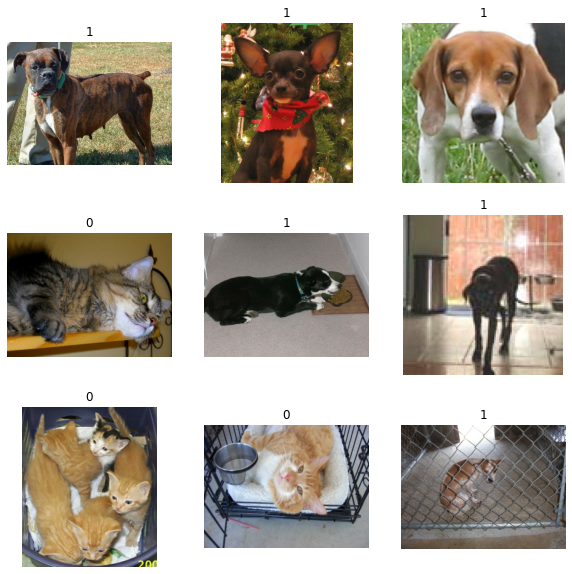

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

We can also see that label 1 is "dog" and label 0 is "cat".

### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer
values between 0 and 255 (RGB level values). This isn't a great fit for feeding a
 neural network. We need to do 2 things:

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer as
 part of the model itself.

In general, it's a good practice to develop models that take raw data as input, as
opposed to models that take already-preprocessed data. The reason being that, if your
model expects preprocessed data, any time you export your model to use it elsewhere
(in a web browser, in a mobile app), you'll need to reimplement the exact same
preprocessing pipeline. This gets very tricky very quickly. So we should do the least
 possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can
only process contiguous batches of data), and we'll do the input value scaling as part
 of the model, when we create it.

Let's resize images to 150x150:

In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Besides, let's batch the data and use caching & prefetching to optimize loading speed.

In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
 introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the first image of the first batch looks like after various random
 transformations:

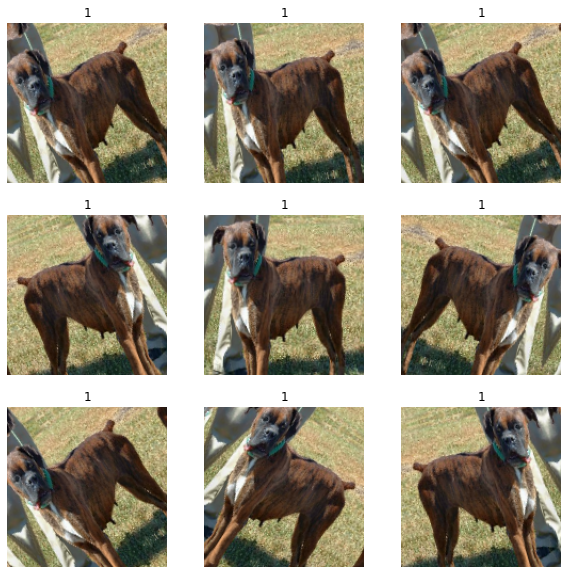

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Normalization` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [14]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

    8192/83683744 [..............................] - ETA: 1s

 4202496/83683744 [>.............................] - ETA: 4s

 8396800/83683744 [==>...........................] - ETA: 2s

16785408/83683744 [=====>........................] - ETA: 1s

28942336/83683744 [=========>....................] - ETA: 0s

34168832/83683744 [===========>..................] - ETA: 0s

46276608/83683744 [===============>..............] - ETA: 0s



51904512/83683744 [=================>............] - ETA: 0s

58728448/83683744 [====================>.........] - ETA: 0s

70434816/83683744 [========================>.....] - ETA: 0s

83689472/83683744 [==============================] - 1s 0us/step


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049  

## Train the top layer

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


  1/291 [..............................] - ETA: 27:45 - loss: 0.5308 - binary_accuracy: 0.6562

  3/291 [..............................] - ETA: 8s - loss: 0.5423 - binary_accuracy: 0.6875   

  5/291 [..............................] - ETA: 8s - loss: 0.5400 - binary_accuracy: 0.7025

  7/291 [..............................] - ETA: 7s - loss: 0.5428 - binary_accuracy: 0.7098

  9/291 [..............................] - ETA: 7s - loss: 0.5378 - binary_accuracy: 0.7139

 11/291 [>.............................] - ETA: 7s - loss: 0.5295 - binary_accuracy: 0.7191

 13/291 [>.............................] - ETA: 7s - loss: 0.5201 - binary_accuracy: 0.7248

 15/291 [>.............................] - ETA: 7s - loss: 0.5093 - binary_accuracy: 0.7310

 17/291 [>.............................] - ETA: 7s - loss: 0.4986 - binary_accuracy: 0.7367

 19/291 [>.............................] - ETA: 7s - loss: 0.4884 - binary_accuracy: 0.7422

 21/291 [=>............................] - ETA: 7s - loss: 0.4789 - binary_accuracy: 0.7474

 23/291 [=>............................] - ETA: 7s - loss: 0.4698 - binary_accuracy: 0.7525

 25/291 [=>............................] - ETA: 7s - loss: 0.4611 - binary_accuracy: 0.7574

 27/291 [=>............................] - ETA: 7s - loss: 0.4530 - binary_accuracy: 0.7621

 29/291 [=>............................] - ETA: 7s - loss: 0.4455 - binary_accuracy: 0.7667

 31/291 [==>...........................] - ETA: 7s - loss: 0.4384 - binary_accuracy: 0.7711

 33/291 [==>...........................] - ETA: 7s - loss: 0.4315 - binary_accuracy: 0.7753

 35/291 [==>...........................] - ETA: 7s - loss: 0.4249 - binary_accuracy: 0.7794

 37/291 [==>...........................] - ETA: 6s - loss: 0.4186 - binary_accuracy: 0.7833

 39/291 [===>..........................] - ETA: 6s - loss: 0.4125 - binary_accuracy: 0.7871

 41/291 [===>..........................] - ETA: 6s - loss: 0.4066 - binary_accuracy: 0.7908

 43/291 [===>..........................] - ETA: 6s - loss: 0.4010 - binary_accuracy: 0.7943

 45/291 [===>..........................] - ETA: 6s - loss: 0.3957 - binary_accuracy: 0.7977

 47/291 [===>..........................] - ETA: 6s - loss: 0.3907 - binary_accuracy: 0.8009

 49/291 [====>.........................] - ETA: 6s - loss: 0.3858 - binary_accuracy: 0.8039

 51/291 [====>.........................] - ETA: 6s - loss: 0.3812 - binary_accuracy: 0.8069

 53/291 [====>.........................] - ETA: 6s - loss: 0.3767 - binary_accuracy: 0.8097

 55/291 [====>.........................] - ETA: 6s - loss: 0.3724 - binary_accuracy: 0.8124

 57/291 [====>.........................] - ETA: 6s - loss: 0.3682 - binary_accuracy: 0.8149

 59/291 [=====>........................] - ETA: 6s - loss: 0.3642 - binary_accuracy: 0.8174

 61/291 [=====>........................] - ETA: 6s - loss: 0.3603 - binary_accuracy: 0.8198

 63/291 [=====>........................] - ETA: 6s - loss: 0.3566 - binary_accuracy: 0.8221

 65/291 [=====>........................] - ETA: 6s - loss: 0.3529 - binary_accuracy: 0.8244

 67/291 [=====>........................] - ETA: 6s - loss: 0.3495 - binary_accuracy: 0.8265

 69/291 [======>.......................] - ETA: 6s - loss: 0.3461 - binary_accuracy: 0.8286

 71/291 [======>.......................] - ETA: 6s - loss: 0.3429 - binary_accuracy: 0.8305

 73/291 [======>.......................] - ETA: 6s - loss: 0.3398 - binary_accuracy: 0.8324

 75/291 [======>.......................] - ETA: 5s - loss: 0.3369 - binary_accuracy: 0.8342

 77/291 [======>.......................] - ETA: 5s - loss: 0.3341 - binary_accuracy: 0.8359

 79/291 [=======>......................] - ETA: 5s - loss: 0.3313 - binary_accuracy: 0.8376

 81/291 [=======>......................] - ETA: 5s - loss: 0.3286 - binary_accuracy: 0.8392

 83/291 [=======>......................] - ETA: 5s - loss: 0.3260 - binary_accuracy: 0.8408

 85/291 [=======>......................] - ETA: 5s - loss: 0.3234 - binary_accuracy: 0.8423

 87/291 [=======>......................] - ETA: 5s - loss: 0.3210 - binary_accuracy: 0.8438

 89/291 [========>.....................] - ETA: 5s - loss: 0.3186 - binary_accuracy: 0.8451

 91/291 [========>.....................] - ETA: 5s - loss: 0.3163 - binary_accuracy: 0.8465

 93/291 [========>.....................] - ETA: 5s - loss: 0.3140 - binary_accuracy: 0.8478

 95/291 [========>.....................] - ETA: 5s - loss: 0.3118 - binary_accuracy: 0.8490

 97/291 [=========>....................] - ETA: 5s - loss: 0.3097 - binary_accuracy: 0.8502

 99/291 [=========>....................] - ETA: 5s - loss: 0.3077 - binary_accuracy: 0.8514

101/291 [=========>....................] - ETA: 5s - loss: 0.3057 - binary_accuracy: 0.8525

103/291 [=========>....................] - ETA: 5s - loss: 0.3038 - binary_accuracy: 0.8535

105/291 [=========>....................] - ETA: 5s - loss: 0.3020 - binary_accuracy: 0.8546

107/291 [==========>...................] - ETA: 5s - loss: 0.3002 - binary_accuracy: 0.8556

109/291 [==========>...................] - ETA: 5s - loss: 0.2984 - binary_accuracy: 0.8565

111/291 [==========>...................] - ETA: 4s - loss: 0.2967 - binary_accuracy: 0.8575

113/291 [==========>...................] - ETA: 4s - loss: 0.2951 - binary_accuracy: 0.8584

115/291 [==========>...................] - ETA: 4s - loss: 0.2934 - binary_accuracy: 0.8593

117/291 [===========>..................] - ETA: 4s - loss: 0.2918 - binary_accuracy: 0.8601

119/291 [===========>..................] - ETA: 4s - loss: 0.2903 - binary_accuracy: 0.8610

121/291 [===========>..................] - ETA: 4s - loss: 0.2888 - binary_accuracy: 0.8618

123/291 [===========>..................] - ETA: 4s - loss: 0.2873 - binary_accuracy: 0.8626

125/291 [===========>..................] - ETA: 4s - loss: 0.2859 - binary_accuracy: 0.8634

127/291 [============>.................] - ETA: 4s - loss: 0.2845 - binary_accuracy: 0.8642

129/291 [============>.................] - ETA: 4s - loss: 0.2831 - binary_accuracy: 0.8649

131/291 [============>.................] - ETA: 4s - loss: 0.2818 - binary_accuracy: 0.8656

133/291 [============>.................] - ETA: 4s - loss: 0.2805 - binary_accuracy: 0.8663

135/291 [============>.................] - ETA: 4s - loss: 0.2792 - binary_accuracy: 0.8670

137/291 [=============>................] - ETA: 4s - loss: 0.2780 - binary_accuracy: 0.8677

139/291 [=============>................] - ETA: 4s - loss: 0.2767 - binary_accuracy: 0.8684

141/291 [=============>................] - ETA: 4s - loss: 0.2755 - binary_accuracy: 0.8690

143/291 [=============>................] - ETA: 4s - loss: 0.2743 - binary_accuracy: 0.8696

145/291 [=============>................] - ETA: 4s - loss: 0.2732 - binary_accuracy: 0.8702

147/291 [==============>...............] - ETA: 3s - loss: 0.2720 - binary_accuracy: 0.8708

149/291 [==============>...............] - ETA: 3s - loss: 0.2709 - binary_accuracy: 0.8714

151/291 [==============>...............] - ETA: 3s - loss: 0.2698 - binary_accuracy: 0.8720

153/291 [==============>...............] - ETA: 3s - loss: 0.2687 - binary_accuracy: 0.8726

155/291 [==============>...............] - ETA: 3s - loss: 0.2676 - binary_accuracy: 0.8731

157/291 [===============>..............] - ETA: 3s - loss: 0.2665 - binary_accuracy: 0.8737

159/291 [===============>..............] - ETA: 3s - loss: 0.2655 - binary_accuracy: 0.8743

161/291 [===============>..............] - ETA: 3s - loss: 0.2645 - binary_accuracy: 0.8748

163/291 [===============>..............] - ETA: 3s - loss: 0.2635 - binary_accuracy: 0.8753

165/291 [================>.............] - ETA: 3s - loss: 0.2625 - binary_accuracy: 0.8758

167/291 [================>.............] - ETA: 3s - loss: 0.2616 - binary_accuracy: 0.8763

169/291 [================>.............] - ETA: 3s - loss: 0.2606 - binary_accuracy: 0.8768

171/291 [================>.............] - ETA: 3s - loss: 0.2597 - binary_accuracy: 0.8773

173/291 [================>.............] - ETA: 3s - loss: 0.2588 - binary_accuracy: 0.8778

175/291 [=================>............] - ETA: 3s - loss: 0.2579 - binary_accuracy: 0.8783

177/291 [=================>............] - ETA: 3s - loss: 0.2570 - binary_accuracy: 0.8787

179/291 [=================>............] - ETA: 3s - loss: 0.2561 - binary_accuracy: 0.8792

181/291 [=================>............] - ETA: 3s - loss: 0.2553 - binary_accuracy: 0.8797

183/291 [=================>............] - ETA: 2s - loss: 0.2545 - binary_accuracy: 0.8801

185/291 [==================>...........] - ETA: 2s - loss: 0.2536 - binary_accuracy: 0.8805

187/291 [==================>...........] - ETA: 2s - loss: 0.2528 - binary_accuracy: 0.8810

189/291 [==================>...........] - ETA: 2s - loss: 0.2520 - binary_accuracy: 0.8814

191/291 [==================>...........] - ETA: 2s - loss: 0.2513 - binary_accuracy: 0.8818

193/291 [==================>...........] - ETA: 2s - loss: 0.2505 - binary_accuracy: 0.8822

195/291 [===================>..........] - ETA: 2s - loss: 0.2498 - binary_accuracy: 0.8826

197/291 [===================>..........] - ETA: 2s - loss: 0.2491 - binary_accuracy: 0.8830

199/291 [===================>..........] - ETA: 2s - loss: 0.2483 - binary_accuracy: 0.8834

201/291 [===================>..........] - ETA: 2s - loss: 0.2476 - binary_accuracy: 0.8837

203/291 [===================>..........] - ETA: 2s - loss: 0.2469 - binary_accuracy: 0.8841

205/291 [====================>.........] - ETA: 2s - loss: 0.2462 - binary_accuracy: 0.8845

207/291 [====================>.........] - ETA: 2s - loss: 0.2456 - binary_accuracy: 0.8848

209/291 [====================>.........] - ETA: 2s - loss: 0.2449 - binary_accuracy: 0.8852

212/291 [====================>.........] - ETA: 2s - loss: 0.2439 - binary_accuracy: 0.8857

215/291 [=====================>........] - ETA: 2s - loss: 0.2430 - binary_accuracy: 0.8862

218/291 [=====================>........] - ETA: 1s - loss: 0.2420 - binary_accuracy: 0.8867

221/291 [=====================>........] - ETA: 2s - loss: 0.2411 - binary_accuracy: 0.8872

223/291 [=====================>........] - ETA: 2s - loss: 0.2405 - binary_accuracy: 0.8875

225/291 [======================>.......] - ETA: 2s - loss: 0.2399 - binary_accuracy: 0.8879

227/291 [======================>.......] - ETA: 2s - loss: 0.2393 - binary_accuracy: 0.8882

229/291 [======================>.......] - ETA: 2s - loss: 0.2387 - binary_accuracy: 0.8885

231/291 [======================>.......] - ETA: 1s - loss: 0.2381 - binary_accuracy: 0.8888

233/291 [=======================>......] - ETA: 1s - loss: 0.2375 - binary_accuracy: 0.8891

235/291 [=======================>......] - ETA: 1s - loss: 0.2370 - binary_accuracy: 0.8895

237/291 [=======================>......] - ETA: 1s - loss: 0.2364 - binary_accuracy: 0.8898

239/291 [=======================>......] - ETA: 1s - loss: 0.2358 - binary_accuracy: 0.8901

241/291 [=======================>......] - ETA: 1s - loss: 0.2352 - binary_accuracy: 0.8904

243/291 [========================>.....] - ETA: 1s - loss: 0.2347 - binary_accuracy: 0.8907

245/291 [========================>.....] - ETA: 1s - loss: 0.2341 - binary_accuracy: 0.8910

247/291 [========================>.....] - ETA: 1s - loss: 0.2336 - binary_accuracy: 0.8913

249/291 [========================>.....] - ETA: 1s - loss: 0.2330 - binary_accuracy: 0.8916

251/291 [========================>.....] - ETA: 1s - loss: 0.2325 - binary_accuracy: 0.8919

253/291 [=========================>....] - ETA: 1s - loss: 0.2320 - binary_accuracy: 0.8922

255/291 [=========================>....] - ETA: 1s - loss: 0.2314 - binary_accuracy: 0.8924

257/291 [=========================>....] - ETA: 1s - loss: 0.2309 - binary_accuracy: 0.8927

259/291 [=========================>....] - ETA: 1s - loss: 0.2304 - binary_accuracy: 0.8930

261/291 [=========================>....] - ETA: 0s - loss: 0.2299 - binary_accuracy: 0.8933

263/291 [==========================>...] - ETA: 0s - loss: 0.2294 - binary_accuracy: 0.8936

265/291 [==========================>...] - ETA: 0s - loss: 0.2289 - binary_accuracy: 0.8938

267/291 [==========================>...] - ETA: 0s - loss: 0.2284 - binary_accuracy: 0.8941

269/291 [==========================>...] - ETA: 0s - loss: 0.2279 - binary_accuracy: 0.8944

271/291 [==========================>...] - ETA: 0s - loss: 0.2275 - binary_accuracy: 0.8946

273/291 [===========================>..] - ETA: 0s - loss: 0.2270 - binary_accuracy: 0.8949

275/291 [===========================>..] - ETA: 0s - loss: 0.2265 - binary_accuracy: 0.8951

277/291 [===========================>..] - ETA: 0s - loss: 0.2260 - binary_accuracy: 0.8954

279/291 [===========================>..] - ETA: 0s - loss: 0.2255 - binary_accuracy: 0.8957

281/291 [===========================>..] - ETA: 0s - loss: 0.2251 - binary_accuracy: 0.8959

284/291 [============================>.] - ETA: 0s - loss: 0.2244 - binary_accuracy: 0.8963

287/291 [============================>.] - ETA: 0s - loss: 0.2237 - binary_accuracy: 0.8966

290/291 [============================>.] - ETA: 0s - loss: 0.2230 - binary_accuracy: 0.8970

291/291 [==============================] - ETA: 0s - loss: 0.2228 - binary_accuracy: 0.8971

291/291 [==============================] - 20s 49ms/step - loss: 0.2226 - binary_accuracy: 0.8972 - val_loss: 0.0805 - val_binary_accuracy: 0.9703


Epoch 2/20
  1/291 [..............................] - ETA: 8s - loss: 0.1374 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1343 - binary_accuracy: 0.9134

  7/291 [..............................] - ETA: 6s - loss: 0.1424 - binary_accuracy: 0.9250

 10/291 [>.............................] - ETA: 6s - loss: 0.1464 - binary_accuracy: 0.9293

 13/291 [>.............................] - ETA: 6s - loss: 0.1503 - binary_accuracy: 0.9305

 16/291 [>.............................] - ETA: 6s - loss: 0.1506 - binary_accuracy: 0.9318

 19/291 [>.............................] - ETA: 6s - loss: 0.1487 - binary_accuracy: 0.9337

 22/291 [=>............................] - ETA: 6s - loss: 0.1466 - binary_accuracy: 0.9355

 25/291 [=>............................] - ETA: 6s - loss: 0.1452 - binary_accuracy: 0.9365

 28/291 [=>............................] - ETA: 6s - loss: 0.1437 - binary_accuracy: 0.9375

 31/291 [==>...........................] - ETA: 6s - loss: 0.1431 - binary_accuracy: 0.9380

 34/291 [==>...........................] - ETA: 5s - loss: 0.1424 - binary_accuracy: 0.9384

 37/291 [==>...........................] - ETA: 5s - loss: 0.1421 - binary_accuracy: 0.9387

 40/291 [===>..........................] - ETA: 5s - loss: 0.1417 - binary_accuracy: 0.9391

 43/291 [===>..........................] - ETA: 5s - loss: 0.1413 - binary_accuracy: 0.9394

 46/291 [===>..........................] - ETA: 5s - loss: 0.1409 - binary_accuracy: 0.9397

 49/291 [====>.........................] - ETA: 5s - loss: 0.1405 - binary_accuracy: 0.9399

 52/291 [====>.........................] - ETA: 5s - loss: 0.1400 - binary_accuracy: 0.9402

 55/291 [====>.........................] - ETA: 5s - loss: 0.1396 - binary_accuracy: 0.9404

 58/291 [====>.........................] - ETA: 5s - loss: 0.1390 - binary_accuracy: 0.9406

 61/291 [=====>........................] - ETA: 5s - loss: 0.1385 - binary_accuracy: 0.9408

 64/291 [=====>........................] - ETA: 5s - loss: 0.1379 - binary_accuracy: 0.9410

 67/291 [=====>........................] - ETA: 5s - loss: 0.1373 - binary_accuracy: 0.9413

 70/291 [======>.......................] - ETA: 5s - loss: 0.1367 - binary_accuracy: 0.9415

 73/291 [======>.......................] - ETA: 4s - loss: 0.1361 - binary_accuracy: 0.9418

 76/291 [======>.......................] - ETA: 4s - loss: 0.1357 - binary_accuracy: 0.9420

 79/291 [=======>......................] - ETA: 4s - loss: 0.1353 - binary_accuracy: 0.9422

 82/291 [=======>......................] - ETA: 4s - loss: 0.1349 - binary_accuracy: 0.9424

 85/291 [=======>......................] - ETA: 4s - loss: 0.1344 - binary_accuracy: 0.9427

 88/291 [========>.....................] - ETA: 4s - loss: 0.1339 - binary_accuracy: 0.9429

 91/291 [========>.....................] - ETA: 4s - loss: 0.1335 - binary_accuracy: 0.9431

 94/291 [========>.....................] - ETA: 4s - loss: 0.1330 - binary_accuracy: 0.9433

 97/291 [=========>....................] - ETA: 4s - loss: 0.1326 - binary_accuracy: 0.9435

100/291 [=========>....................] - ETA: 4s - loss: 0.1322 - binary_accuracy: 0.9436

103/291 [=========>....................] - ETA: 4s - loss: 0.1319 - binary_accuracy: 0.9437

106/291 [=========>....................] - ETA: 4s - loss: 0.1316 - binary_accuracy: 0.9438

109/291 [==========>...................] - ETA: 4s - loss: 0.1314 - binary_accuracy: 0.9439

112/291 [==========>...................] - ETA: 4s - loss: 0.1312 - binary_accuracy: 0.9440

115/291 [==========>...................] - ETA: 4s - loss: 0.1310 - binary_accuracy: 0.9441

118/291 [===========>..................] - ETA: 3s - loss: 0.1308 - binary_accuracy: 0.9442

121/291 [===========>..................] - ETA: 3s - loss: 0.1307 - binary_accuracy: 0.9442

124/291 [===========>..................] - ETA: 3s - loss: 0.1305 - binary_accuracy: 0.9443

127/291 [============>.................] - ETA: 3s - loss: 0.1304 - binary_accuracy: 0.9443

130/291 [============>.................] - ETA: 3s - loss: 0.1303 - binary_accuracy: 0.9444

133/291 [============>.................] - ETA: 3s - loss: 0.1302 - binary_accuracy: 0.9445

136/291 [=============>................] - ETA: 3s - loss: 0.1301 - binary_accuracy: 0.9445

139/291 [=============>................] - ETA: 3s - loss: 0.1300 - binary_accuracy: 0.9445

142/291 [=============>................] - ETA: 3s - loss: 0.1299 - binary_accuracy: 0.9446

145/291 [=============>................] - ETA: 3s - loss: 0.1297 - binary_accuracy: 0.9446

148/291 [==============>...............] - ETA: 3s - loss: 0.1296 - binary_accuracy: 0.9446

151/291 [==============>...............] - ETA: 3s - loss: 0.1295 - binary_accuracy: 0.9447

154/291 [==============>...............] - ETA: 3s - loss: 0.1293 - binary_accuracy: 0.9448

157/291 [===============>..............] - ETA: 3s - loss: 0.1292 - binary_accuracy: 0.9448

160/291 [===============>..............] - ETA: 2s - loss: 0.1290 - binary_accuracy: 0.9449

163/291 [===============>..............] - ETA: 2s - loss: 0.1289 - binary_accuracy: 0.9449

166/291 [================>.............] - ETA: 2s - loss: 0.1288 - binary_accuracy: 0.9450

169/291 [================>.............] - ETA: 2s - loss: 0.1287 - binary_accuracy: 0.9450

172/291 [================>.............] - ETA: 2s - loss: 0.1285 - binary_accuracy: 0.9451

175/291 [=================>............] - ETA: 2s - loss: 0.1284 - binary_accuracy: 0.9451

178/291 [=================>............] - ETA: 2s - loss: 0.1283 - binary_accuracy: 0.9451

181/291 [=================>............] - ETA: 2s - loss: 0.1282 - binary_accuracy: 0.9452

184/291 [=================>............] - ETA: 2s - loss: 0.1281 - binary_accuracy: 0.9452

187/291 [==================>...........] - ETA: 2s - loss: 0.1280 - binary_accuracy: 0.9452

190/291 [==================>...........] - ETA: 2s - loss: 0.1279 - binary_accuracy: 0.9452

193/291 [==================>...........] - ETA: 2s - loss: 0.1278 - binary_accuracy: 0.9452

196/291 [===================>..........] - ETA: 2s - loss: 0.1277 - binary_accuracy: 0.9453

199/291 [===================>..........] - ETA: 2s - loss: 0.1277 - binary_accuracy: 0.9453

202/291 [===================>..........] - ETA: 2s - loss: 0.1276 - binary_accuracy: 0.9453

205/291 [====================>.........] - ETA: 1s - loss: 0.1275 - binary_accuracy: 0.9453

208/291 [====================>.........] - ETA: 1s - loss: 0.1274 - binary_accuracy: 0.9453

211/291 [====================>.........] - ETA: 1s - loss: 0.1273 - binary_accuracy: 0.9454

214/291 [=====================>........] - ETA: 1s - loss: 0.1273 - binary_accuracy: 0.9454

217/291 [=====================>........] - ETA: 1s - loss: 0.1272 - binary_accuracy: 0.9454

220/291 [=====================>........] - ETA: 1s - loss: 0.1271 - binary_accuracy: 0.9454

223/291 [=====================>........] - ETA: 1s - loss: 0.1270 - binary_accuracy: 0.9454

226/291 [======================>.......] - ETA: 1s - loss: 0.1269 - binary_accuracy: 0.9455

229/291 [======================>.......] - ETA: 1s - loss: 0.1268 - binary_accuracy: 0.9455

232/291 [======================>.......] - ETA: 1s - loss: 0.1267 - binary_accuracy: 0.9455

235/291 [=======================>......] - ETA: 1s - loss: 0.1266 - binary_accuracy: 0.9456

238/291 [=======================>......] - ETA: 1s - loss: 0.1265 - binary_accuracy: 0.9456

241/291 [=======================>......] - ETA: 1s - loss: 0.1264 - binary_accuracy: 0.9456

244/291 [========================>.....] - ETA: 1s - loss: 0.1263 - binary_accuracy: 0.9457

247/291 [========================>.....] - ETA: 1s - loss: 0.1262 - binary_accuracy: 0.9457

250/291 [========================>.....] - ETA: 0s - loss: 0.1261 - binary_accuracy: 0.9458

252/291 [========================>.....] - ETA: 0s - loss: 0.1260 - binary_accuracy: 0.9458

255/291 [=========================>....] - ETA: 0s - loss: 0.1259 - binary_accuracy: 0.9458

258/291 [=========================>....] - ETA: 0s - loss: 0.1258 - binary_accuracy: 0.9459

261/291 [=========================>....] - ETA: 0s - loss: 0.1257 - binary_accuracy: 0.9459

264/291 [==========================>...] - ETA: 0s - loss: 0.1256 - binary_accuracy: 0.9460

267/291 [==========================>...] - ETA: 0s - loss: 0.1255 - binary_accuracy: 0.9460

270/291 [==========================>...] - ETA: 0s - loss: 0.1254 - binary_accuracy: 0.9461

273/291 [===========================>..] - ETA: 0s - loss: 0.1253 - binary_accuracy: 0.9461

276/291 [===========================>..] - ETA: 0s - loss: 0.1252 - binary_accuracy: 0.9462

279/291 [===========================>..] - ETA: 0s - loss: 0.1251 - binary_accuracy: 0.9462

282/291 [============================>.] - ETA: 0s - loss: 0.1250 - binary_accuracy: 0.9463

285/291 [============================>.] - ETA: 0s - loss: 0.1249 - binary_accuracy: 0.9463

288/291 [============================>.] - ETA: 0s - loss: 0.1248 - binary_accuracy: 0.9464

290/291 [============================>.] - ETA: 0s - loss: 0.1247 - binary_accuracy: 0.9464

291/291 [==============================] - 8s 29ms/step - loss: 0.1246 - binary_accuracy: 0.9464 - val_loss: 0.0757 - val_binary_accuracy: 0.9712


Epoch 3/20
  1/291 [..............................] - ETA: 10s - loss: 0.1521 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1532 - binary_accuracy: 0.9147 

  7/291 [..............................] - ETA: 6s - loss: 0.1437 - binary_accuracy: 0.9215

 10/291 [>.............................] - ETA: 6s - loss: 0.1401 - binary_accuracy: 0.9242

 13/291 [>.............................] - ETA: 6s - loss: 0.1389 - binary_accuracy: 0.9257

 16/291 [>.............................] - ETA: 6s - loss: 0.1367 - binary_accuracy: 0.9281

 19/291 [>.............................] - ETA: 6s - loss: 0.1337 - binary_accuracy: 0.9303

 22/291 [=>............................] - ETA: 6s - loss: 0.1312 - binary_accuracy: 0.9320

 25/291 [=>............................] - ETA: 6s - loss: 0.1297 - binary_accuracy: 0.9333

 28/291 [=>............................] - ETA: 6s - loss: 0.1280 - binary_accuracy: 0.9346

 31/291 [==>...........................] - ETA: 6s - loss: 0.1267 - binary_accuracy: 0.9356

 34/291 [==>...........................] - ETA: 5s - loss: 0.1259 - binary_accuracy: 0.9364

 37/291 [==>...........................] - ETA: 5s - loss: 0.1253 - binary_accuracy: 0.9369

 40/291 [===>..........................] - ETA: 5s - loss: 0.1246 - binary_accuracy: 0.9374

 43/291 [===>..........................] - ETA: 5s - loss: 0.1238 - binary_accuracy: 0.9379

 46/291 [===>..........................] - ETA: 5s - loss: 0.1231 - binary_accuracy: 0.9384

 49/291 [====>.........................] - ETA: 5s - loss: 0.1226 - binary_accuracy: 0.9389

 52/291 [====>.........................] - ETA: 5s - loss: 0.1220 - binary_accuracy: 0.9394

 55/291 [====>.........................] - ETA: 5s - loss: 0.1214 - binary_accuracy: 0.9400

 58/291 [====>.........................] - ETA: 5s - loss: 0.1207 - binary_accuracy: 0.9405

 61/291 [=====>........................] - ETA: 5s - loss: 0.1199 - binary_accuracy: 0.9410

 64/291 [=====>........................] - ETA: 5s - loss: 0.1192 - binary_accuracy: 0.9416

 67/291 [=====>........................] - ETA: 5s - loss: 0.1186 - binary_accuracy: 0.9421

 70/291 [======>.......................] - ETA: 5s - loss: 0.1180 - binary_accuracy: 0.9425

 73/291 [======>.......................] - ETA: 5s - loss: 0.1175 - binary_accuracy: 0.9429

 75/291 [======>.......................] - ETA: 5s - loss: 0.1172 - binary_accuracy: 0.9431

 78/291 [=======>......................] - ETA: 4s - loss: 0.1167 - binary_accuracy: 0.9434

 81/291 [=======>......................] - ETA: 4s - loss: 0.1164 - binary_accuracy: 0.9437

 84/291 [=======>......................] - ETA: 4s - loss: 0.1161 - binary_accuracy: 0.9440

 87/291 [=======>......................] - ETA: 4s - loss: 0.1158 - binary_accuracy: 0.9442

 90/291 [========>.....................] - ETA: 4s - loss: 0.1156 - binary_accuracy: 0.9444

 93/291 [========>.....................] - ETA: 4s - loss: 0.1154 - binary_accuracy: 0.9446

 96/291 [========>.....................] - ETA: 4s - loss: 0.1152 - binary_accuracy: 0.9448

 99/291 [=========>....................] - ETA: 4s - loss: 0.1151 - binary_accuracy: 0.9449

102/291 [=========>....................] - ETA: 4s - loss: 0.1149 - binary_accuracy: 0.9450

105/291 [=========>....................] - ETA: 4s - loss: 0.1148 - binary_accuracy: 0.9451

108/291 [==========>...................] - ETA: 4s - loss: 0.1147 - binary_accuracy: 0.9452

111/291 [==========>...................] - ETA: 4s - loss: 0.1147 - binary_accuracy: 0.9453

114/291 [==========>...................] - ETA: 4s - loss: 0.1146 - binary_accuracy: 0.9454

117/291 [===========>..................] - ETA: 4s - loss: 0.1145 - binary_accuracy: 0.9455

120/291 [===========>..................] - ETA: 3s - loss: 0.1144 - binary_accuracy: 0.9456

123/291 [===========>..................] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9457

126/291 [===========>..................] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9458

129/291 [============>.................] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9459

132/291 [============>.................] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9459

135/291 [============>.................] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9460

138/291 [=============>................] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9460

141/291 [=============>................] - ETA: 3s - loss: 0.1142 - binary_accuracy: 0.9461

143/291 [=============>................] - ETA: 3s - loss: 0.1142 - binary_accuracy: 0.9461

146/291 [==============>...............] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9462

149/291 [==============>...............] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9463

152/291 [==============>...............] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9463

155/291 [==============>...............] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9464

158/291 [===============>..............] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9464

161/291 [===============>..............] - ETA: 2s - loss: 0.1143 - binary_accuracy: 0.9465

164/291 [===============>..............] - ETA: 2s - loss: 0.1144 - binary_accuracy: 0.9465

167/291 [================>.............] - ETA: 2s - loss: 0.1144 - binary_accuracy: 0.9466

170/291 [================>.............] - ETA: 2s - loss: 0.1144 - binary_accuracy: 0.9467

173/291 [================>.............] - ETA: 2s - loss: 0.1143 - binary_accuracy: 0.9467

176/291 [=================>............] - ETA: 2s - loss: 0.1143 - binary_accuracy: 0.9468

179/291 [=================>............] - ETA: 2s - loss: 0.1143 - binary_accuracy: 0.9469

182/291 [=================>............] - ETA: 2s - loss: 0.1144 - binary_accuracy: 0.9469

185/291 [==================>...........] - ETA: 2s - loss: 0.1144 - binary_accuracy: 0.9470

188/291 [==================>...........] - ETA: 2s - loss: 0.1145 - binary_accuracy: 0.9470

191/291 [==================>...........] - ETA: 2s - loss: 0.1145 - binary_accuracy: 0.9470

194/291 [===================>..........] - ETA: 2s - loss: 0.1146 - binary_accuracy: 0.9471

197/291 [===================>..........] - ETA: 2s - loss: 0.1147 - binary_accuracy: 0.9471

200/291 [===================>..........] - ETA: 2s - loss: 0.1147 - binary_accuracy: 0.9471

203/291 [===================>..........] - ETA: 2s - loss: 0.1148 - binary_accuracy: 0.9472

206/291 [====================>.........] - ETA: 1s - loss: 0.1149 - binary_accuracy: 0.9472

209/291 [====================>.........] - ETA: 1s - loss: 0.1149 - binary_accuracy: 0.9472

211/291 [====================>.........] - ETA: 1s - loss: 0.1150 - binary_accuracy: 0.9472

213/291 [====================>.........] - ETA: 1s - loss: 0.1150 - binary_accuracy: 0.9473

216/291 [=====================>........] - ETA: 1s - loss: 0.1151 - binary_accuracy: 0.9473

219/291 [=====================>........] - ETA: 1s - loss: 0.1151 - binary_accuracy: 0.9473

222/291 [=====================>........] - ETA: 1s - loss: 0.1152 - binary_accuracy: 0.9473

225/291 [======================>.......] - ETA: 1s - loss: 0.1152 - binary_accuracy: 0.9473

228/291 [======================>.......] - ETA: 1s - loss: 0.1153 - binary_accuracy: 0.9474

231/291 [======================>.......] - ETA: 1s - loss: 0.1153 - binary_accuracy: 0.9474

234/291 [=======================>......] - ETA: 1s - loss: 0.1153 - binary_accuracy: 0.9474

237/291 [=======================>......] - ETA: 1s - loss: 0.1153 - binary_accuracy: 0.9475

240/291 [=======================>......] - ETA: 1s - loss: 0.1153 - binary_accuracy: 0.9475

243/291 [========================>.....] - ETA: 1s - loss: 0.1154 - binary_accuracy: 0.9475

246/291 [========================>.....] - ETA: 1s - loss: 0.1154 - binary_accuracy: 0.9475

249/291 [========================>.....] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9476

252/291 [========================>.....] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9476

255/291 [=========================>....] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9476

258/291 [=========================>....] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9476

261/291 [=========================>....] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9476

264/291 [==========================>...] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9477

267/291 [==========================>...] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9477

269/291 [==========================>...] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9477

272/291 [===========================>..] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9477

275/291 [===========================>..] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9478

278/291 [===========================>..] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9478

281/291 [===========================>..] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9478

284/291 [============================>.] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9479

287/291 [============================>.] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9479

290/291 [============================>.] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9479

291/291 [==============================] - 8s 29ms/step - loss: 0.1153 - binary_accuracy: 0.9480 - val_loss: 0.0724 - val_binary_accuracy: 0.9733


Epoch 4/20
  1/291 [..............................] - ETA: 7s - loss: 0.2410 - binary_accuracy: 0.8750

  4/291 [..............................] - ETA: 6s - loss: 0.1951 - binary_accuracy: 0.9115

  7/291 [..............................] - ETA: 6s - loss: 0.1708 - binary_accuracy: 0.9298

 10/291 [>.............................] - ETA: 6s - loss: 0.1621 - binary_accuracy: 0.9353

 13/291 [>.............................] - ETA: 6s - loss: 0.1566 - binary_accuracy: 0.9388

 16/291 [>.............................] - ETA: 6s - loss: 0.1507 - binary_accuracy: 0.9418

 19/291 [>.............................] - ETA: 6s - loss: 0.1448 - binary_accuracy: 0.9447

 22/291 [=>............................] - ETA: 6s - loss: 0.1398 - binary_accuracy: 0.9470

 25/291 [=>............................] - ETA: 6s - loss: 0.1353 - binary_accuracy: 0.9490

 28/291 [=>............................] - ETA: 6s - loss: 0.1317 - binary_accuracy: 0.9506

 31/291 [==>...........................] - ETA: 6s - loss: 0.1293 - binary_accuracy: 0.9515

 34/291 [==>...........................] - ETA: 5s - loss: 0.1274 - binary_accuracy: 0.9522

 37/291 [==>...........................] - ETA: 5s - loss: 0.1257 - binary_accuracy: 0.9528

 40/291 [===>..........................] - ETA: 5s - loss: 0.1241 - binary_accuracy: 0.9533

 43/291 [===>..........................] - ETA: 5s - loss: 0.1226 - binary_accuracy: 0.9538

 46/291 [===>..........................] - ETA: 5s - loss: 0.1212 - binary_accuracy: 0.9542

 49/291 [====>.........................] - ETA: 5s - loss: 0.1198 - binary_accuracy: 0.9547

 52/291 [====>.........................] - ETA: 5s - loss: 0.1186 - binary_accuracy: 0.9551

 55/291 [====>.........................] - ETA: 5s - loss: 0.1175 - binary_accuracy: 0.9555

 58/291 [====>.........................] - ETA: 5s - loss: 0.1165 - binary_accuracy: 0.9559

 61/291 [=====>........................] - ETA: 5s - loss: 0.1154 - binary_accuracy: 0.9562

 64/291 [=====>........................] - ETA: 5s - loss: 0.1143 - binary_accuracy: 0.9566

 67/291 [=====>........................] - ETA: 5s - loss: 0.1133 - binary_accuracy: 0.9570

 70/291 [======>.......................] - ETA: 5s - loss: 0.1124 - binary_accuracy: 0.9573

 73/291 [======>.......................] - ETA: 5s - loss: 0.1115 - binary_accuracy: 0.9577

 76/291 [======>.......................] - ETA: 4s - loss: 0.1108 - binary_accuracy: 0.9579

 79/291 [=======>......................] - ETA: 4s - loss: 0.1102 - binary_accuracy: 0.9581

 82/291 [=======>......................] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9583

 85/291 [=======>......................] - ETA: 4s - loss: 0.1091 - binary_accuracy: 0.9585

 88/291 [========>.....................] - ETA: 4s - loss: 0.1086 - binary_accuracy: 0.9586

 91/291 [========>.....................] - ETA: 4s - loss: 0.1082 - binary_accuracy: 0.9587

 94/291 [========>.....................] - ETA: 4s - loss: 0.1078 - binary_accuracy: 0.9588

 97/291 [=========>....................] - ETA: 4s - loss: 0.1074 - binary_accuracy: 0.9590

 99/291 [=========>....................] - ETA: 4s - loss: 0.1072 - binary_accuracy: 0.9590

102/291 [=========>....................] - ETA: 4s - loss: 0.1069 - binary_accuracy: 0.9591

105/291 [=========>....................] - ETA: 4s - loss: 0.1066 - binary_accuracy: 0.9591

108/291 [==========>...................] - ETA: 4s - loss: 0.1064 - binary_accuracy: 0.9591

111/291 [==========>...................] - ETA: 4s - loss: 0.1062 - binary_accuracy: 0.9592

114/291 [==========>...................] - ETA: 4s - loss: 0.1061 - binary_accuracy: 0.9592

117/291 [===========>..................] - ETA: 4s - loss: 0.1059 - binary_accuracy: 0.9592

120/291 [===========>..................] - ETA: 3s - loss: 0.1058 - binary_accuracy: 0.9591

123/291 [===========>..................] - ETA: 3s - loss: 0.1056 - binary_accuracy: 0.9591

126/291 [===========>..................] - ETA: 3s - loss: 0.1056 - binary_accuracy: 0.9591

129/291 [============>.................] - ETA: 3s - loss: 0.1055 - binary_accuracy: 0.9591

132/291 [============>.................] - ETA: 3s - loss: 0.1054 - binary_accuracy: 0.9591

135/291 [============>.................] - ETA: 3s - loss: 0.1054 - binary_accuracy: 0.9590

138/291 [=============>................] - ETA: 3s - loss: 0.1053 - binary_accuracy: 0.9590

141/291 [=============>................] - ETA: 3s - loss: 0.1053 - binary_accuracy: 0.9589

144/291 [=============>................] - ETA: 3s - loss: 0.1053 - binary_accuracy: 0.9589

147/291 [==============>...............] - ETA: 3s - loss: 0.1053 - binary_accuracy: 0.9588

150/291 [==============>...............] - ETA: 3s - loss: 0.1052 - binary_accuracy: 0.9588

153/291 [==============>...............] - ETA: 3s - loss: 0.1052 - binary_accuracy: 0.9587

156/291 [===============>..............] - ETA: 3s - loss: 0.1051 - binary_accuracy: 0.9587

159/291 [===============>..............] - ETA: 3s - loss: 0.1051 - binary_accuracy: 0.9587

162/291 [===============>..............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9586

165/291 [================>.............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9586

168/291 [================>.............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9586

171/291 [================>.............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9585

174/291 [================>.............] - ETA: 2s - loss: 0.1049 - binary_accuracy: 0.9585

177/291 [=================>............] - ETA: 2s - loss: 0.1049 - binary_accuracy: 0.9584

180/291 [=================>............] - ETA: 2s - loss: 0.1049 - binary_accuracy: 0.9584

183/291 [=================>............] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9583

186/291 [==================>...........] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9583

189/291 [==================>...........] - ETA: 2s - loss: 0.1050 - binary_accuracy: 0.9583

192/291 [==================>...........] - ETA: 2s - loss: 0.1051 - binary_accuracy: 0.9582

195/291 [===================>..........] - ETA: 2s - loss: 0.1051 - binary_accuracy: 0.9582

198/291 [===================>..........] - ETA: 2s - loss: 0.1052 - binary_accuracy: 0.9581

201/291 [===================>..........] - ETA: 2s - loss: 0.1052 - binary_accuracy: 0.9581

204/291 [====================>.........] - ETA: 2s - loss: 0.1053 - binary_accuracy: 0.9580

207/291 [====================>.........] - ETA: 1s - loss: 0.1053 - binary_accuracy: 0.9580

210/291 [====================>.........] - ETA: 1s - loss: 0.1054 - binary_accuracy: 0.9580

213/291 [====================>.........] - ETA: 1s - loss: 0.1054 - binary_accuracy: 0.9579

216/291 [=====================>........] - ETA: 1s - loss: 0.1054 - binary_accuracy: 0.9579

219/291 [=====================>........] - ETA: 1s - loss: 0.1055 - binary_accuracy: 0.9579

222/291 [=====================>........] - ETA: 1s - loss: 0.1055 - binary_accuracy: 0.9578

225/291 [======================>.......] - ETA: 1s - loss: 0.1055 - binary_accuracy: 0.9578

228/291 [======================>.......] - ETA: 1s - loss: 0.1055 - binary_accuracy: 0.9578

231/291 [======================>.......] - ETA: 1s - loss: 0.1055 - binary_accuracy: 0.9578

234/291 [=======================>......] - ETA: 1s - loss: 0.1055 - binary_accuracy: 0.9578

237/291 [=======================>......] - ETA: 1s - loss: 0.1056 - binary_accuracy: 0.9577

240/291 [=======================>......] - ETA: 1s - loss: 0.1056 - binary_accuracy: 0.9577

243/291 [========================>.....] - ETA: 1s - loss: 0.1056 - binary_accuracy: 0.9577

246/291 [========================>.....] - ETA: 1s - loss: 0.1056 - binary_accuracy: 0.9577

249/291 [========================>.....] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9577

252/291 [========================>.....] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9577

255/291 [=========================>....] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9577

258/291 [=========================>....] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9576

261/291 [=========================>....] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9576

264/291 [==========================>...] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9576

267/291 [==========================>...] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9576

270/291 [==========================>...] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9576

273/291 [===========================>..] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9576

276/291 [===========================>..] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9576

279/291 [===========================>..] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9576

282/291 [============================>.] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9576

285/291 [============================>.] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9575

288/291 [============================>.] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9575

291/291 [==============================] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9575

291/291 [==============================] - 8s 29ms/step - loss: 0.1055 - binary_accuracy: 0.9575 - val_loss: 0.0753 - val_binary_accuracy: 0.9721


Epoch 5/20
  1/291 [..............................] - ETA: 7s - loss: 0.1323 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1095 - binary_accuracy: 0.9427

  7/291 [..............................] - ETA: 6s - loss: 0.0975 - binary_accuracy: 0.9582

 10/291 [>.............................] - ETA: 6s - loss: 0.0959 - binary_accuracy: 0.9625

 13/291 [>.............................] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9641

 16/291 [>.............................] - ETA: 6s - loss: 0.0954 - binary_accuracy: 0.9651

 19/291 [>.............................] - ETA: 6s - loss: 0.0939 - binary_accuracy: 0.9662

 22/291 [=>............................] - ETA: 6s - loss: 0.0925 - binary_accuracy: 0.9670

 25/291 [=>............................] - ETA: 5s - loss: 0.0916 - binary_accuracy: 0.9674

 28/291 [=>............................] - ETA: 5s - loss: 0.0909 - binary_accuracy: 0.9676

 31/291 [==>...........................] - ETA: 5s - loss: 0.0907 - binary_accuracy: 0.9678

 34/291 [==>...........................] - ETA: 5s - loss: 0.0909 - binary_accuracy: 0.9679

 37/291 [==>...........................] - ETA: 5s - loss: 0.0910 - binary_accuracy: 0.9679

 40/291 [===>..........................] - ETA: 5s - loss: 0.0912 - binary_accuracy: 0.9679

 43/291 [===>..........................] - ETA: 5s - loss: 0.0913 - binary_accuracy: 0.9678

 46/291 [===>..........................] - ETA: 5s - loss: 0.0916 - binary_accuracy: 0.9677

 49/291 [====>.........................] - ETA: 5s - loss: 0.0920 - binary_accuracy: 0.9675

 52/291 [====>.........................] - ETA: 5s - loss: 0.0924 - binary_accuracy: 0.9674

 55/291 [====>.........................] - ETA: 5s - loss: 0.0925 - binary_accuracy: 0.9672

 58/291 [====>.........................] - ETA: 5s - loss: 0.0927 - binary_accuracy: 0.9671

 61/291 [=====>........................] - ETA: 5s - loss: 0.0927 - binary_accuracy: 0.9669

 64/291 [=====>........................] - ETA: 5s - loss: 0.0928 - binary_accuracy: 0.9668

 67/291 [=====>........................] - ETA: 5s - loss: 0.0928 - binary_accuracy: 0.9666

 70/291 [======>.......................] - ETA: 4s - loss: 0.0930 - binary_accuracy: 0.9664

 73/291 [======>.......................] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9662

 76/291 [======>.......................] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9660

 79/291 [=======>......................] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9658

 82/291 [=======>......................] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9657

 85/291 [=======>......................] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9655

 88/291 [========>.....................] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9653

 91/291 [========>.....................] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9651

 94/291 [========>.....................] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9650

 97/291 [=========>....................] - ETA: 4s - loss: 0.0947 - binary_accuracy: 0.9648

100/291 [=========>....................] - ETA: 4s - loss: 0.0949 - binary_accuracy: 0.9647

103/291 [=========>....................] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9645

106/291 [=========>....................] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9643

109/291 [==========>...................] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9642

112/291 [==========>...................] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9640

115/291 [==========>...................] - ETA: 3s - loss: 0.0958 - binary_accuracy: 0.9639

118/291 [===========>..................] - ETA: 3s - loss: 0.0960 - binary_accuracy: 0.9638

121/291 [===========>..................] - ETA: 3s - loss: 0.0962 - binary_accuracy: 0.9636

124/291 [===========>..................] - ETA: 3s - loss: 0.0964 - binary_accuracy: 0.9635

127/291 [============>.................] - ETA: 3s - loss: 0.0967 - binary_accuracy: 0.9633

130/291 [============>.................] - ETA: 3s - loss: 0.0969 - binary_accuracy: 0.9632

133/291 [============>.................] - ETA: 3s - loss: 0.0972 - binary_accuracy: 0.9630

136/291 [=============>................] - ETA: 3s - loss: 0.0974 - binary_accuracy: 0.9628

139/291 [=============>................] - ETA: 3s - loss: 0.0976 - binary_accuracy: 0.9627

142/291 [=============>................] - ETA: 3s - loss: 0.0979 - binary_accuracy: 0.9625

145/291 [=============>................] - ETA: 3s - loss: 0.0981 - binary_accuracy: 0.9624

148/291 [==============>...............] - ETA: 3s - loss: 0.0982 - binary_accuracy: 0.9623

151/291 [==============>...............] - ETA: 3s - loss: 0.0984 - binary_accuracy: 0.9622

154/291 [==============>...............] - ETA: 3s - loss: 0.0985 - binary_accuracy: 0.9621

157/291 [===============>..............] - ETA: 3s - loss: 0.0987 - binary_accuracy: 0.9620

160/291 [===============>..............] - ETA: 2s - loss: 0.0988 - binary_accuracy: 0.9619

163/291 [===============>..............] - ETA: 2s - loss: 0.0990 - binary_accuracy: 0.9618

166/291 [================>.............] - ETA: 2s - loss: 0.0992 - binary_accuracy: 0.9616

169/291 [================>.............] - ETA: 2s - loss: 0.0993 - binary_accuracy: 0.9615

172/291 [================>.............] - ETA: 2s - loss: 0.0995 - binary_accuracy: 0.9614

175/291 [=================>............] - ETA: 2s - loss: 0.0996 - binary_accuracy: 0.9613

178/291 [=================>............] - ETA: 2s - loss: 0.0997 - binary_accuracy: 0.9612

181/291 [=================>............] - ETA: 2s - loss: 0.0999 - binary_accuracy: 0.9611

184/291 [=================>............] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9610

187/291 [==================>...........] - ETA: 2s - loss: 0.1001 - binary_accuracy: 0.9609

190/291 [==================>...........] - ETA: 2s - loss: 0.1003 - binary_accuracy: 0.9608

193/291 [==================>...........] - ETA: 2s - loss: 0.1004 - binary_accuracy: 0.9607

196/291 [===================>..........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9606

199/291 [===================>..........] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9605

202/291 [===================>..........] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9605

205/291 [====================>.........] - ETA: 1s - loss: 0.1009 - binary_accuracy: 0.9604

208/291 [====================>.........] - ETA: 1s - loss: 0.1010 - binary_accuracy: 0.9603

211/291 [====================>.........] - ETA: 1s - loss: 0.1011 - binary_accuracy: 0.9602

214/291 [=====================>........] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9601

217/291 [=====================>........] - ETA: 1s - loss: 0.1014 - binary_accuracy: 0.9600

220/291 [=====================>........] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9599

223/291 [=====================>........] - ETA: 1s - loss: 0.1016 - binary_accuracy: 0.9599

226/291 [======================>.......] - ETA: 1s - loss: 0.1017 - binary_accuracy: 0.9598

229/291 [======================>.......] - ETA: 1s - loss: 0.1017 - binary_accuracy: 0.9597

232/291 [======================>.......] - ETA: 1s - loss: 0.1018 - binary_accuracy: 0.9597

235/291 [=======================>......] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9596

238/291 [=======================>......] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9596

241/291 [=======================>......] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9595

244/291 [========================>.....] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9595

247/291 [========================>.....] - ETA: 0s - loss: 0.1021 - binary_accuracy: 0.9594

250/291 [========================>.....] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.9594

253/291 [=========================>....] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.9593

256/291 [=========================>....] - ETA: 0s - loss: 0.1023 - binary_accuracy: 0.9593

259/291 [=========================>....] - ETA: 0s - loss: 0.1023 - binary_accuracy: 0.9593

262/291 [==========================>...] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9592

265/291 [==========================>...] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9592

268/291 [==========================>...] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9591

271/291 [==========================>...] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9591

274/291 [===========================>..] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9591

277/291 [===========================>..] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9590

280/291 [===========================>..] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9590

283/291 [============================>.] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9590

286/291 [============================>.] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9589

289/291 [============================>.] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9589

291/291 [==============================] - 8s 28ms/step - loss: 0.1026 - binary_accuracy: 0.9589 - val_loss: 0.0750 - val_binary_accuracy: 0.9703


Epoch 6/20
  1/291 [..............................] - ETA: 10s - loss: 0.1305 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.1110 - binary_accuracy: 0.9421 

  7/291 [..............................] - ETA: 6s - loss: 0.1041 - binary_accuracy: 0.9489

 10/291 [>.............................] - ETA: 6s - loss: 0.1098 - binary_accuracy: 0.9498

 13/291 [>.............................] - ETA: 6s - loss: 0.1128 - binary_accuracy: 0.9503

 16/291 [>.............................] - ETA: 6s - loss: 0.1146 - binary_accuracy: 0.9503

 19/291 [>.............................] - ETA: 6s - loss: 0.1145 - binary_accuracy: 0.9507

 22/291 [=>............................] - ETA: 6s - loss: 0.1142 - binary_accuracy: 0.9514

 25/291 [=>............................] - ETA: 6s - loss: 0.1137 - binary_accuracy: 0.9518

 28/291 [=>............................] - ETA: 6s - loss: 0.1128 - binary_accuracy: 0.9522

 31/291 [==>...........................] - ETA: 5s - loss: 0.1123 - binary_accuracy: 0.9525

 34/291 [==>...........................] - ETA: 5s - loss: 0.1118 - binary_accuracy: 0.9528

 37/291 [==>...........................] - ETA: 5s - loss: 0.1112 - binary_accuracy: 0.9532

 40/291 [===>..........................] - ETA: 5s - loss: 0.1105 - binary_accuracy: 0.9536

 43/291 [===>..........................] - ETA: 5s - loss: 0.1098 - binary_accuracy: 0.9540

 46/291 [===>..........................] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9543

 49/291 [====>.........................] - ETA: 5s - loss: 0.1088 - binary_accuracy: 0.9546

 52/291 [====>.........................] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9549

 55/291 [====>.........................] - ETA: 5s - loss: 0.1079 - binary_accuracy: 0.9552

 58/291 [====>.........................] - ETA: 5s - loss: 0.1073 - binary_accuracy: 0.9555

 61/291 [=====>........................] - ETA: 5s - loss: 0.1067 - binary_accuracy: 0.9558

 64/291 [=====>........................] - ETA: 5s - loss: 0.1061 - binary_accuracy: 0.9561

 67/291 [=====>........................] - ETA: 5s - loss: 0.1056 - binary_accuracy: 0.9563

 70/291 [======>.......................] - ETA: 5s - loss: 0.1052 - binary_accuracy: 0.9566

 73/291 [======>.......................] - ETA: 4s - loss: 0.1048 - binary_accuracy: 0.9568

 76/291 [======>.......................] - ETA: 4s - loss: 0.1045 - binary_accuracy: 0.9570

 79/291 [=======>......................] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9571

 82/291 [=======>......................] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9572

 85/291 [=======>......................] - ETA: 4s - loss: 0.1037 - binary_accuracy: 0.9573

 88/291 [========>.....................] - ETA: 4s - loss: 0.1035 - binary_accuracy: 0.9573

 91/291 [========>.....................] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9574

 94/291 [========>.....................] - ETA: 4s - loss: 0.1031 - binary_accuracy: 0.9574

 97/291 [=========>....................] - ETA: 4s - loss: 0.1029 - binary_accuracy: 0.9575

100/291 [=========>....................] - ETA: 4s - loss: 0.1028 - binary_accuracy: 0.9575

103/291 [=========>....................] - ETA: 4s - loss: 0.1027 - binary_accuracy: 0.9575

106/291 [=========>....................] - ETA: 4s - loss: 0.1026 - binary_accuracy: 0.9576

109/291 [==========>...................] - ETA: 4s - loss: 0.1026 - binary_accuracy: 0.9576

112/291 [==========>...................] - ETA: 4s - loss: 0.1026 - binary_accuracy: 0.9576

115/291 [==========>...................] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9576

118/291 [===========>..................] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9577

121/291 [===========>..................] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9577

124/291 [===========>..................] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9577

127/291 [============>.................] - ETA: 3s - loss: 0.1028 - binary_accuracy: 0.9577

130/291 [============>.................] - ETA: 3s - loss: 0.1028 - binary_accuracy: 0.9578

133/291 [============>.................] - ETA: 3s - loss: 0.1029 - binary_accuracy: 0.9578

136/291 [=============>................] - ETA: 3s - loss: 0.1030 - binary_accuracy: 0.9578

139/291 [=============>................] - ETA: 3s - loss: 0.1030 - binary_accuracy: 0.9578

142/291 [=============>................] - ETA: 3s - loss: 0.1030 - binary_accuracy: 0.9577

145/291 [=============>................] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9577

148/291 [==============>...............] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9577

151/291 [==============>...............] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9577

154/291 [==============>...............] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9577

157/291 [===============>..............] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9578

160/291 [===============>..............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9578

163/291 [===============>..............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9578

166/291 [================>.............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9578

169/291 [================>.............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9578

172/291 [================>.............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9578

175/291 [=================>............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9578

178/291 [=================>............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9578

181/291 [=================>............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9578

184/291 [=================>............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9579

187/291 [==================>...........] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9579

190/291 [==================>...........] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9579

193/291 [==================>...........] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9579

196/291 [===================>..........] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9579

199/291 [===================>..........] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9579

202/291 [===================>..........] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9580

205/291 [====================>.........] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9580

208/291 [====================>.........] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9580

211/291 [====================>.........] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9580

214/291 [=====================>........] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9580

217/291 [=====================>........] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9581

220/291 [=====================>........] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9581

223/291 [=====================>........] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9581

226/291 [======================>.......] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9581

229/291 [======================>.......] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9581

232/291 [======================>.......] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9582

235/291 [=======================>......] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9582

238/291 [=======================>......] - ETA: 1s - loss: 0.1029 - binary_accuracy: 0.9582

241/291 [=======================>......] - ETA: 1s - loss: 0.1029 - binary_accuracy: 0.9582

244/291 [========================>.....] - ETA: 1s - loss: 0.1029 - binary_accuracy: 0.9583

247/291 [========================>.....] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.9583

250/291 [========================>.....] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.9583

253/291 [=========================>....] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.9583

256/291 [=========================>....] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9584

259/291 [=========================>....] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9584

262/291 [==========================>...] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9584

265/291 [==========================>...] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9584

268/291 [==========================>...] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9585

271/291 [==========================>...] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9585

274/291 [===========================>..] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9585

277/291 [===========================>..] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9585

280/291 [===========================>..] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9586

283/291 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9586

286/291 [============================>.] - ETA: 0s - loss: 0.1023 - binary_accuracy: 0.9586

289/291 [============================>.] - ETA: 0s - loss: 0.1023 - binary_accuracy: 0.9586

291/291 [==============================] - 8s 28ms/step - loss: 0.1022 - binary_accuracy: 0.9587 - val_loss: 0.0723 - val_binary_accuracy: 0.9716


Epoch 7/20
  1/291 [..............................] - ETA: 6s - loss: 0.1351 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.0901 - binary_accuracy: 0.9590

  7/291 [..............................] - ETA: 6s - loss: 0.0836 - binary_accuracy: 0.9661

 10/291 [>.............................] - ETA: 6s - loss: 0.0879 - binary_accuracy: 0.9667

 13/291 [>.............................] - ETA: 6s - loss: 0.0918 - binary_accuracy: 0.9656

 16/291 [>.............................] - ETA: 6s - loss: 0.0927 - binary_accuracy: 0.9653

 19/291 [>.............................] - ETA: 6s - loss: 0.0919 - binary_accuracy: 0.9654

 22/291 [=>............................] - ETA: 6s - loss: 0.0917 - binary_accuracy: 0.9654

 25/291 [=>............................] - ETA: 6s - loss: 0.0926 - binary_accuracy: 0.9649

 28/291 [=>............................] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9644

 31/291 [==>...........................] - ETA: 5s - loss: 0.0942 - binary_accuracy: 0.9639

 34/291 [==>...........................] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9634

 37/291 [==>...........................] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9629

 40/291 [===>..........................] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9624

 43/291 [===>..........................] - ETA: 5s - loss: 0.0971 - binary_accuracy: 0.9620

 46/291 [===>..........................] - ETA: 5s - loss: 0.0974 - binary_accuracy: 0.9617

 49/291 [====>.........................] - ETA: 5s - loss: 0.0976 - binary_accuracy: 0.9615

 52/291 [====>.........................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9613

 55/291 [====>.........................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9612

 58/291 [====>.........................] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9611

 61/291 [=====>........................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9610

 64/291 [=====>........................] - ETA: 5s - loss: 0.0977 - binary_accuracy: 0.9610

 67/291 [=====>........................] - ETA: 5s - loss: 0.0977 - binary_accuracy: 0.9609

 70/291 [======>.......................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9609

 73/291 [======>.......................] - ETA: 4s - loss: 0.0978 - binary_accuracy: 0.9608

 76/291 [======>.......................] - ETA: 4s - loss: 0.0979 - binary_accuracy: 0.9608

 79/291 [=======>......................] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9607

 82/291 [=======>......................] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9606

 85/291 [=======>......................] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9606

 88/291 [========>.....................] - ETA: 4s - loss: 0.0981 - binary_accuracy: 0.9605

 91/291 [========>.....................] - ETA: 4s - loss: 0.0981 - binary_accuracy: 0.9604

 94/291 [========>.....................] - ETA: 4s - loss: 0.0982 - binary_accuracy: 0.9603

 97/291 [=========>....................] - ETA: 4s - loss: 0.0982 - binary_accuracy: 0.9601

100/291 [=========>....................] - ETA: 4s - loss: 0.0983 - binary_accuracy: 0.9599

103/291 [=========>....................] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9597

106/291 [=========>....................] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9595

109/291 [==========>...................] - ETA: 4s - loss: 0.0989 - binary_accuracy: 0.9593

112/291 [==========>...................] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9592

115/291 [==========>...................] - ETA: 4s - loss: 0.0992 - binary_accuracy: 0.9590

118/291 [===========>..................] - ETA: 3s - loss: 0.0994 - binary_accuracy: 0.9589

121/291 [===========>..................] - ETA: 3s - loss: 0.0995 - binary_accuracy: 0.9588

124/291 [===========>..................] - ETA: 3s - loss: 0.0996 - binary_accuracy: 0.9586

127/291 [============>.................] - ETA: 3s - loss: 0.0998 - binary_accuracy: 0.9585

130/291 [============>.................] - ETA: 3s - loss: 0.1000 - binary_accuracy: 0.9584

133/291 [============>.................] - ETA: 3s - loss: 0.1001 - binary_accuracy: 0.9582

136/291 [=============>................] - ETA: 3s - loss: 0.1002 - binary_accuracy: 0.9581

139/291 [=============>................] - ETA: 3s - loss: 0.1004 - binary_accuracy: 0.9580

142/291 [=============>................] - ETA: 3s - loss: 0.1005 - binary_accuracy: 0.9579

145/291 [=============>................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9579

148/291 [==============>...............] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9578

151/291 [==============>...............] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9577

154/291 [==============>...............] - ETA: 3s - loss: 0.1008 - binary_accuracy: 0.9577

157/291 [===============>..............] - ETA: 3s - loss: 0.1008 - binary_accuracy: 0.9576

160/291 [===============>..............] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9576

163/291 [===============>..............] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9576

166/291 [================>.............] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9575

169/291 [================>.............] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9575

172/291 [================>.............] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9575

175/291 [=================>............] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9575

178/291 [=================>............] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9575

181/291 [=================>............] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9574

184/291 [=================>............] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9574

187/291 [==================>...........] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9574

190/291 [==================>...........] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9574

193/291 [==================>...........] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9574

196/291 [===================>..........] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9573

199/291 [===================>..........] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9573

202/291 [===================>..........] - ETA: 2s - loss: 0.1012 - binary_accuracy: 0.9573

205/291 [====================>.........] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9573

208/291 [====================>.........] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9573

211/291 [====================>.........] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9572

214/291 [=====================>........] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9572

217/291 [=====================>........] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9572

220/291 [=====================>........] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9572

223/291 [=====================>........] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9572

226/291 [======================>.......] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9571

229/291 [======================>.......] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9571

232/291 [======================>.......] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9571

235/291 [=======================>......] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9571

238/291 [=======================>......] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9571

241/291 [=======================>......] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9571

244/291 [========================>.....] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9571

247/291 [========================>.....] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9571

250/291 [========================>.....] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9571

253/291 [=========================>....] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9571

256/291 [=========================>....] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9571

259/291 [=========================>....] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9571

262/291 [==========================>...] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.9571

265/291 [==========================>...] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9571

268/291 [==========================>...] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9571

271/291 [==========================>...] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9571

274/291 [===========================>..] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9571

277/291 [===========================>..] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9571

280/291 [===========================>..] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9571

283/291 [============================>.] - ETA: 0s - loss: 0.1009 - binary_accuracy: 0.9570

286/291 [============================>.] - ETA: 0s - loss: 0.1009 - binary_accuracy: 0.9570

289/291 [============================>.] - ETA: 0s - loss: 0.1009 - binary_accuracy: 0.9570

291/291 [==============================] - 8s 28ms/step - loss: 0.1009 - binary_accuracy: 0.9570 - val_loss: 0.0731 - val_binary_accuracy: 0.9708


Epoch 8/20
  1/291 [..............................] - ETA: 7s - loss: 0.1755 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1102 - binary_accuracy: 0.9342

  7/291 [..............................] - ETA: 6s - loss: 0.0918 - binary_accuracy: 0.9468

 10/291 [>.............................] - ETA: 6s - loss: 0.0869 - binary_accuracy: 0.9513

 13/291 [>.............................] - ETA: 6s - loss: 0.0883 - binary_accuracy: 0.9518

 16/291 [>.............................] - ETA: 6s - loss: 0.0901 - binary_accuracy: 0.9522

 19/291 [>.............................] - ETA: 6s - loss: 0.0899 - binary_accuracy: 0.9532

 22/291 [=>............................] - ETA: 6s - loss: 0.0889 - binary_accuracy: 0.9543

 25/291 [=>............................] - ETA: 6s - loss: 0.0882 - binary_accuracy: 0.9551

 28/291 [=>............................] - ETA: 6s - loss: 0.0879 - binary_accuracy: 0.9556

 31/291 [==>...........................] - ETA: 5s - loss: 0.0880 - binary_accuracy: 0.9559

 34/291 [==>...........................] - ETA: 5s - loss: 0.0884 - binary_accuracy: 0.9563

 37/291 [==>...........................] - ETA: 5s - loss: 0.0886 - binary_accuracy: 0.9566

 40/291 [===>..........................] - ETA: 5s - loss: 0.0887 - binary_accuracy: 0.9569

 43/291 [===>..........................] - ETA: 5s - loss: 0.0887 - binary_accuracy: 0.9571

 46/291 [===>..........................] - ETA: 5s - loss: 0.0887 - binary_accuracy: 0.9572

 49/291 [====>.........................] - ETA: 5s - loss: 0.0890 - binary_accuracy: 0.9574

 52/291 [====>.........................] - ETA: 5s - loss: 0.0892 - binary_accuracy: 0.9575

 55/291 [====>.........................] - ETA: 5s - loss: 0.0894 - binary_accuracy: 0.9576

 58/291 [====>.........................] - ETA: 5s - loss: 0.0895 - binary_accuracy: 0.9576

 61/291 [=====>........................] - ETA: 5s - loss: 0.0895 - binary_accuracy: 0.9577

 64/291 [=====>........................] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9577

 67/291 [=====>........................] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9578

 70/291 [======>.......................] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9578

 73/291 [======>.......................] - ETA: 4s - loss: 0.0896 - binary_accuracy: 0.9579

 76/291 [======>.......................] - ETA: 4s - loss: 0.0897 - binary_accuracy: 0.9580

 79/291 [=======>......................] - ETA: 4s - loss: 0.0897 - binary_accuracy: 0.9580

 82/291 [=======>......................] - ETA: 4s - loss: 0.0898 - binary_accuracy: 0.9580

 85/291 [=======>......................] - ETA: 4s - loss: 0.0898 - binary_accuracy: 0.9581

 88/291 [========>.....................] - ETA: 4s - loss: 0.0899 - binary_accuracy: 0.9581

 91/291 [========>.....................] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9582

 94/291 [========>.....................] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9582

 97/291 [=========>....................] - ETA: 4s - loss: 0.0901 - binary_accuracy: 0.9582

100/291 [=========>....................] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9582

103/291 [=========>....................] - ETA: 4s - loss: 0.0903 - binary_accuracy: 0.9581

106/291 [=========>....................] - ETA: 4s - loss: 0.0904 - binary_accuracy: 0.9581

109/291 [==========>...................] - ETA: 4s - loss: 0.0906 - binary_accuracy: 0.9581

112/291 [==========>...................] - ETA: 4s - loss: 0.0907 - binary_accuracy: 0.9580

115/291 [==========>...................] - ETA: 4s - loss: 0.0908 - binary_accuracy: 0.9580

118/291 [===========>..................] - ETA: 3s - loss: 0.0909 - binary_accuracy: 0.9580

121/291 [===========>..................] - ETA: 3s - loss: 0.0910 - binary_accuracy: 0.9580

124/291 [===========>..................] - ETA: 3s - loss: 0.0910 - binary_accuracy: 0.9580

127/291 [============>.................] - ETA: 3s - loss: 0.0911 - binary_accuracy: 0.9580

130/291 [============>.................] - ETA: 3s - loss: 0.0912 - binary_accuracy: 0.9579

133/291 [============>.................] - ETA: 3s - loss: 0.0913 - binary_accuracy: 0.9579

136/291 [=============>................] - ETA: 3s - loss: 0.0914 - binary_accuracy: 0.9579

139/291 [=============>................] - ETA: 3s - loss: 0.0915 - binary_accuracy: 0.9579

142/291 [=============>................] - ETA: 3s - loss: 0.0915 - binary_accuracy: 0.9578

145/291 [=============>................] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9578

148/291 [==============>...............] - ETA: 3s - loss: 0.0916 - binary_accuracy: 0.9578

151/291 [==============>...............] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9578

154/291 [==============>...............] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9578

157/291 [===============>..............] - ETA: 3s - loss: 0.0917 - binary_accuracy: 0.9578

160/291 [===============>..............] - ETA: 2s - loss: 0.0918 - binary_accuracy: 0.9578

163/291 [===============>..............] - ETA: 2s - loss: 0.0919 - binary_accuracy: 0.9578

166/291 [================>.............] - ETA: 2s - loss: 0.0919 - binary_accuracy: 0.9578

169/291 [================>.............] - ETA: 2s - loss: 0.0920 - binary_accuracy: 0.9578

172/291 [================>.............] - ETA: 2s - loss: 0.0921 - binary_accuracy: 0.9578

175/291 [=================>............] - ETA: 2s - loss: 0.0921 - binary_accuracy: 0.9578

178/291 [=================>............] - ETA: 2s - loss: 0.0922 - binary_accuracy: 0.9578

181/291 [=================>............] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9578

184/291 [=================>............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9578

187/291 [==================>...........] - ETA: 2s - loss: 0.0925 - binary_accuracy: 0.9577

190/291 [==================>...........] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9577

193/291 [==================>...........] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9577

196/291 [===================>..........] - ETA: 2s - loss: 0.0928 - binary_accuracy: 0.9577

199/291 [===================>..........] - ETA: 2s - loss: 0.0929 - binary_accuracy: 0.9577

202/291 [===================>..........] - ETA: 2s - loss: 0.0930 - binary_accuracy: 0.9577

205/291 [====================>.........] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9576

208/291 [====================>.........] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9576

211/291 [====================>.........] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9576

214/291 [=====================>........] - ETA: 1s - loss: 0.0934 - binary_accuracy: 0.9576

217/291 [=====================>........] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9576

220/291 [=====================>........] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9575

223/291 [=====================>........] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9575

226/291 [======================>.......] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9575

229/291 [======================>.......] - ETA: 1s - loss: 0.0939 - binary_accuracy: 0.9575

232/291 [======================>.......] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9575

235/291 [=======================>......] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9575

238/291 [=======================>......] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9575

241/291 [=======================>......] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9575

244/291 [========================>.....] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9575

247/291 [========================>.....] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9575

250/291 [========================>.....] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9575

253/291 [=========================>....] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.9575

256/291 [=========================>....] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.9575

259/291 [=========================>....] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.9575

262/291 [==========================>...] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.9575

265/291 [==========================>...] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.9575

268/291 [==========================>...] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.9575

271/291 [==========================>...] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.9576

274/291 [===========================>..] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9576

277/291 [===========================>..] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9576

280/291 [===========================>..] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9576

283/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9576

286/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9576

289/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9576

291/291 [==============================] - 8s 28ms/step - loss: 0.0947 - binary_accuracy: 0.9576 - val_loss: 0.0726 - val_binary_accuracy: 0.9716


Epoch 9/20
  1/291 [..............................] - ETA: 8s - loss: 0.0773 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.0616 - binary_accuracy: 0.9733

  7/291 [..............................] - ETA: 6s - loss: 0.0595 - binary_accuracy: 0.9756

 10/291 [>.............................] - ETA: 6s - loss: 0.0602 - binary_accuracy: 0.9754

 13/291 [>.............................] - ETA: 6s - loss: 0.0624 - binary_accuracy: 0.9739

 16/291 [>.............................] - ETA: 6s - loss: 0.0646 - binary_accuracy: 0.9729

 19/291 [>.............................] - ETA: 6s - loss: 0.0655 - binary_accuracy: 0.9724

 22/291 [=>............................] - ETA: 6s - loss: 0.0669 - binary_accuracy: 0.9719

 25/291 [=>............................] - ETA: 5s - loss: 0.0683 - binary_accuracy: 0.9714

 28/291 [=>............................] - ETA: 5s - loss: 0.0694 - binary_accuracy: 0.9709

 31/291 [==>...........................] - ETA: 5s - loss: 0.0706 - binary_accuracy: 0.9705

 34/291 [==>...........................] - ETA: 5s - loss: 0.0714 - binary_accuracy: 0.9702

 37/291 [==>...........................] - ETA: 5s - loss: 0.0720 - binary_accuracy: 0.9701

 40/291 [===>..........................] - ETA: 5s - loss: 0.0724 - binary_accuracy: 0.9701

 43/291 [===>..........................] - ETA: 5s - loss: 0.0727 - binary_accuracy: 0.9701

 46/291 [===>..........................] - ETA: 5s - loss: 0.0730 - binary_accuracy: 0.9700

 49/291 [====>.........................] - ETA: 5s - loss: 0.0733 - binary_accuracy: 0.9698

 52/291 [====>.........................] - ETA: 5s - loss: 0.0735 - binary_accuracy: 0.9696

 55/291 [====>.........................] - ETA: 5s - loss: 0.0736 - binary_accuracy: 0.9695

 58/291 [====>.........................] - ETA: 5s - loss: 0.0737 - binary_accuracy: 0.9693

 61/291 [=====>........................] - ETA: 5s - loss: 0.0738 - binary_accuracy: 0.9692

 64/291 [=====>........................] - ETA: 5s - loss: 0.0739 - binary_accuracy: 0.9690

 67/291 [=====>........................] - ETA: 5s - loss: 0.0741 - binary_accuracy: 0.9688

 70/291 [======>.......................] - ETA: 5s - loss: 0.0744 - binary_accuracy: 0.9686

 73/291 [======>.......................] - ETA: 4s - loss: 0.0747 - binary_accuracy: 0.9683

 76/291 [======>.......................] - ETA: 4s - loss: 0.0750 - binary_accuracy: 0.9680

 79/291 [=======>......................] - ETA: 4s - loss: 0.0754 - binary_accuracy: 0.9677

 82/291 [=======>......................] - ETA: 4s - loss: 0.0756 - binary_accuracy: 0.9675

 85/291 [=======>......................] - ETA: 4s - loss: 0.0759 - binary_accuracy: 0.9673

 88/291 [========>.....................] - ETA: 4s - loss: 0.0761 - binary_accuracy: 0.9671

 91/291 [========>.....................] - ETA: 4s - loss: 0.0763 - binary_accuracy: 0.9670

 94/291 [========>.....................] - ETA: 4s - loss: 0.0765 - binary_accuracy: 0.9668

 97/291 [=========>....................] - ETA: 4s - loss: 0.0767 - binary_accuracy: 0.9667

100/291 [=========>....................] - ETA: 4s - loss: 0.0770 - binary_accuracy: 0.9665

103/291 [=========>....................] - ETA: 4s - loss: 0.0772 - binary_accuracy: 0.9664

106/291 [=========>....................] - ETA: 4s - loss: 0.0774 - binary_accuracy: 0.9662

109/291 [==========>...................] - ETA: 4s - loss: 0.0777 - binary_accuracy: 0.9660

112/291 [==========>...................] - ETA: 4s - loss: 0.0779 - binary_accuracy: 0.9659

115/291 [==========>...................] - ETA: 3s - loss: 0.0782 - binary_accuracy: 0.9657

118/291 [===========>..................] - ETA: 3s - loss: 0.0784 - binary_accuracy: 0.9656

121/291 [===========>..................] - ETA: 3s - loss: 0.0786 - binary_accuracy: 0.9655

124/291 [===========>..................] - ETA: 3s - loss: 0.0788 - binary_accuracy: 0.9653

127/291 [============>.................] - ETA: 3s - loss: 0.0791 - binary_accuracy: 0.9652

130/291 [============>.................] - ETA: 3s - loss: 0.0793 - binary_accuracy: 0.9651

133/291 [============>.................] - ETA: 3s - loss: 0.0795 - binary_accuracy: 0.9649

136/291 [=============>................] - ETA: 3s - loss: 0.0797 - binary_accuracy: 0.9648

139/291 [=============>................] - ETA: 3s - loss: 0.0799 - binary_accuracy: 0.9647

142/291 [=============>................] - ETA: 3s - loss: 0.0802 - binary_accuracy: 0.9646

145/291 [=============>................] - ETA: 3s - loss: 0.0804 - binary_accuracy: 0.9645

148/291 [==============>...............] - ETA: 3s - loss: 0.0806 - binary_accuracy: 0.9644

151/291 [==============>...............] - ETA: 3s - loss: 0.0808 - binary_accuracy: 0.9643

154/291 [==============>...............] - ETA: 3s - loss: 0.0810 - binary_accuracy: 0.9642

157/291 [===============>..............] - ETA: 3s - loss: 0.0811 - binary_accuracy: 0.9642

160/291 [===============>..............] - ETA: 2s - loss: 0.0813 - binary_accuracy: 0.9641

163/291 [===============>..............] - ETA: 2s - loss: 0.0814 - binary_accuracy: 0.9640

166/291 [================>.............] - ETA: 2s - loss: 0.0816 - binary_accuracy: 0.9640

169/291 [================>.............] - ETA: 2s - loss: 0.0817 - binary_accuracy: 0.9639

172/291 [================>.............] - ETA: 2s - loss: 0.0818 - binary_accuracy: 0.9639

175/291 [=================>............] - ETA: 2s - loss: 0.0819 - binary_accuracy: 0.9638

178/291 [=================>............] - ETA: 2s - loss: 0.0820 - binary_accuracy: 0.9638

181/291 [=================>............] - ETA: 2s - loss: 0.0822 - binary_accuracy: 0.9637

184/291 [=================>............] - ETA: 2s - loss: 0.0824 - binary_accuracy: 0.9637

187/291 [==================>...........] - ETA: 2s - loss: 0.0826 - binary_accuracy: 0.9636

190/291 [==================>...........] - ETA: 2s - loss: 0.0827 - binary_accuracy: 0.9636

193/291 [==================>...........] - ETA: 2s - loss: 0.0829 - binary_accuracy: 0.9635

196/291 [===================>..........] - ETA: 2s - loss: 0.0831 - binary_accuracy: 0.9634

199/291 [===================>..........] - ETA: 2s - loss: 0.0833 - binary_accuracy: 0.9634

202/291 [===================>..........] - ETA: 2s - loss: 0.0835 - binary_accuracy: 0.9633

205/291 [====================>.........] - ETA: 1s - loss: 0.0837 - binary_accuracy: 0.9633

208/291 [====================>.........] - ETA: 1s - loss: 0.0839 - binary_accuracy: 0.9632

211/291 [====================>.........] - ETA: 1s - loss: 0.0840 - binary_accuracy: 0.9632

214/291 [=====================>........] - ETA: 1s - loss: 0.0842 - binary_accuracy: 0.9631

217/291 [=====================>........] - ETA: 1s - loss: 0.0844 - binary_accuracy: 0.9631

220/291 [=====================>........] - ETA: 1s - loss: 0.0845 - binary_accuracy: 0.9631

223/291 [=====================>........] - ETA: 1s - loss: 0.0847 - binary_accuracy: 0.9630

226/291 [======================>.......] - ETA: 1s - loss: 0.0849 - binary_accuracy: 0.9630

229/291 [======================>.......] - ETA: 1s - loss: 0.0850 - binary_accuracy: 0.9629

232/291 [======================>.......] - ETA: 1s - loss: 0.0851 - binary_accuracy: 0.9629

235/291 [=======================>......] - ETA: 1s - loss: 0.0852 - binary_accuracy: 0.9629

238/291 [=======================>......] - ETA: 1s - loss: 0.0854 - binary_accuracy: 0.9628

241/291 [=======================>......] - ETA: 1s - loss: 0.0855 - binary_accuracy: 0.9628

244/291 [========================>.....] - ETA: 1s - loss: 0.0856 - binary_accuracy: 0.9628

247/291 [========================>.....] - ETA: 0s - loss: 0.0857 - binary_accuracy: 0.9628

250/291 [========================>.....] - ETA: 0s - loss: 0.0858 - binary_accuracy: 0.9627

253/291 [=========================>....] - ETA: 0s - loss: 0.0859 - binary_accuracy: 0.9627

256/291 [=========================>....] - ETA: 0s - loss: 0.0861 - binary_accuracy: 0.9627

259/291 [=========================>....] - ETA: 0s - loss: 0.0862 - binary_accuracy: 0.9626

262/291 [==========================>...] - ETA: 0s - loss: 0.0863 - binary_accuracy: 0.9626

265/291 [==========================>...] - ETA: 0s - loss: 0.0864 - binary_accuracy: 0.9626

268/291 [==========================>...] - ETA: 0s - loss: 0.0865 - binary_accuracy: 0.9626

271/291 [==========================>...] - ETA: 0s - loss: 0.0866 - binary_accuracy: 0.9625

274/291 [===========================>..] - ETA: 0s - loss: 0.0867 - binary_accuracy: 0.9625

277/291 [===========================>..] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9625

280/291 [===========================>..] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9625

283/291 [============================>.] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9624

286/291 [============================>.] - ETA: 0s - loss: 0.0870 - binary_accuracy: 0.9624

289/291 [============================>.] - ETA: 0s - loss: 0.0871 - binary_accuracy: 0.9624

291/291 [==============================] - 8s 28ms/step - loss: 0.0872 - binary_accuracy: 0.9624 - val_loss: 0.0720 - val_binary_accuracy: 0.9712


Epoch 10/20
  1/291 [..............................] - ETA: 9s - loss: 0.0381 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.0628 - binary_accuracy: 0.9544

  7/291 [..............................] - ETA: 6s - loss: 0.0708 - binary_accuracy: 0.9558

 10/291 [>.............................] - ETA: 6s - loss: 0.0772 - binary_accuracy: 0.9576

 13/291 [>.............................] - ETA: 6s - loss: 0.0810 - binary_accuracy: 0.9586

 16/291 [>.............................] - ETA: 6s - loss: 0.0842 - binary_accuracy: 0.9581

 19/291 [>.............................] - ETA: 6s - loss: 0.0850 - binary_accuracy: 0.9584

 22/291 [=>............................] - ETA: 5s - loss: 0.0852 - binary_accuracy: 0.9588

 25/291 [=>............................] - ETA: 5s - loss: 0.0863 - binary_accuracy: 0.9588

 28/291 [=>............................] - ETA: 5s - loss: 0.0874 - binary_accuracy: 0.9586

 31/291 [==>...........................] - ETA: 5s - loss: 0.0887 - binary_accuracy: 0.9583

 34/291 [==>...........................] - ETA: 5s - loss: 0.0895 - binary_accuracy: 0.9580

 37/291 [==>...........................] - ETA: 5s - loss: 0.0898 - binary_accuracy: 0.9580

 40/291 [===>..........................] - ETA: 5s - loss: 0.0899 - binary_accuracy: 0.9581

 43/291 [===>..........................] - ETA: 5s - loss: 0.0898 - binary_accuracy: 0.9582

 46/291 [===>..........................] - ETA: 5s - loss: 0.0897 - binary_accuracy: 0.9584

 49/291 [====>.........................] - ETA: 5s - loss: 0.0898 - binary_accuracy: 0.9585

 52/291 [====>.........................] - ETA: 5s - loss: 0.0898 - binary_accuracy: 0.9587

 55/291 [====>.........................] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9589

 58/291 [====>.........................] - ETA: 5s - loss: 0.0894 - binary_accuracy: 0.9591

 61/291 [=====>........................] - ETA: 5s - loss: 0.0892 - binary_accuracy: 0.9593

 64/291 [=====>........................] - ETA: 5s - loss: 0.0891 - binary_accuracy: 0.9594

 67/291 [=====>........................] - ETA: 5s - loss: 0.0889 - binary_accuracy: 0.9596

 70/291 [======>.......................] - ETA: 4s - loss: 0.0888 - binary_accuracy: 0.9598

 73/291 [======>.......................] - ETA: 4s - loss: 0.0886 - binary_accuracy: 0.9599

 76/291 [======>.......................] - ETA: 4s - loss: 0.0884 - binary_accuracy: 0.9600

 79/291 [=======>......................] - ETA: 4s - loss: 0.0883 - binary_accuracy: 0.9602

 82/291 [=======>......................] - ETA: 4s - loss: 0.0881 - binary_accuracy: 0.9603

 85/291 [=======>......................] - ETA: 4s - loss: 0.0879 - binary_accuracy: 0.9604

 88/291 [========>.....................] - ETA: 4s - loss: 0.0877 - binary_accuracy: 0.9605

 91/291 [========>.....................] - ETA: 4s - loss: 0.0876 - binary_accuracy: 0.9606

 94/291 [========>.....................] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9608

 97/291 [=========>....................] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9608

100/291 [=========>....................] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9609

103/291 [=========>....................] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9609

106/291 [=========>....................] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9609

109/291 [==========>...................] - ETA: 4s - loss: 0.0875 - binary_accuracy: 0.9609

112/291 [==========>...................] - ETA: 4s - loss: 0.0875 - binary_accuracy: 0.9609

115/291 [==========>...................] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9610

118/291 [===========>..................] - ETA: 3s - loss: 0.0876 - binary_accuracy: 0.9610

121/291 [===========>..................] - ETA: 3s - loss: 0.0876 - binary_accuracy: 0.9610

124/291 [===========>..................] - ETA: 3s - loss: 0.0877 - binary_accuracy: 0.9610

127/291 [============>.................] - ETA: 3s - loss: 0.0877 - binary_accuracy: 0.9610

130/291 [============>.................] - ETA: 3s - loss: 0.0878 - binary_accuracy: 0.9611

133/291 [============>.................] - ETA: 3s - loss: 0.0878 - binary_accuracy: 0.9611

136/291 [=============>................] - ETA: 3s - loss: 0.0878 - binary_accuracy: 0.9611

139/291 [=============>................] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9612

142/291 [=============>................] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9612

145/291 [=============>................] - ETA: 3s - loss: 0.0880 - binary_accuracy: 0.9612

148/291 [==============>...............] - ETA: 3s - loss: 0.0880 - binary_accuracy: 0.9612

151/291 [==============>...............] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9612

154/291 [==============>...............] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9613

157/291 [===============>..............] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9613

160/291 [===============>..............] - ETA: 2s - loss: 0.0882 - binary_accuracy: 0.9613

163/291 [===============>..............] - ETA: 2s - loss: 0.0882 - binary_accuracy: 0.9614

166/291 [================>.............] - ETA: 2s - loss: 0.0883 - binary_accuracy: 0.9614

169/291 [================>.............] - ETA: 2s - loss: 0.0883 - binary_accuracy: 0.9614

172/291 [================>.............] - ETA: 2s - loss: 0.0884 - binary_accuracy: 0.9615

175/291 [=================>............] - ETA: 2s - loss: 0.0884 - binary_accuracy: 0.9615

178/291 [=================>............] - ETA: 2s - loss: 0.0884 - binary_accuracy: 0.9615

181/291 [=================>............] - ETA: 2s - loss: 0.0885 - binary_accuracy: 0.9615

184/291 [=================>............] - ETA: 2s - loss: 0.0885 - binary_accuracy: 0.9616

187/291 [==================>...........] - ETA: 2s - loss: 0.0885 - binary_accuracy: 0.9616

190/291 [==================>...........] - ETA: 2s - loss: 0.0885 - binary_accuracy: 0.9616

193/291 [==================>...........] - ETA: 2s - loss: 0.0886 - binary_accuracy: 0.9616

196/291 [===================>..........] - ETA: 2s - loss: 0.0886 - binary_accuracy: 0.9617

199/291 [===================>..........] - ETA: 2s - loss: 0.0886 - binary_accuracy: 0.9617

202/291 [===================>..........] - ETA: 1s - loss: 0.0886 - binary_accuracy: 0.9617

205/291 [====================>.........] - ETA: 1s - loss: 0.0887 - binary_accuracy: 0.9617

208/291 [====================>.........] - ETA: 1s - loss: 0.0887 - binary_accuracy: 0.9618

211/291 [====================>.........] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9618

214/291 [=====================>........] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9618

217/291 [=====================>........] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9618

220/291 [=====================>........] - ETA: 1s - loss: 0.0889 - binary_accuracy: 0.9618

223/291 [=====================>........] - ETA: 1s - loss: 0.0889 - binary_accuracy: 0.9618

226/291 [======================>.......] - ETA: 1s - loss: 0.0889 - binary_accuracy: 0.9618

229/291 [======================>.......] - ETA: 1s - loss: 0.0889 - binary_accuracy: 0.9618

232/291 [======================>.......] - ETA: 1s - loss: 0.0890 - binary_accuracy: 0.9619

235/291 [=======================>......] - ETA: 1s - loss: 0.0890 - binary_accuracy: 0.9619

238/291 [=======================>......] - ETA: 1s - loss: 0.0890 - binary_accuracy: 0.9619

241/291 [=======================>......] - ETA: 1s - loss: 0.0890 - binary_accuracy: 0.9619

244/291 [========================>.....] - ETA: 1s - loss: 0.0890 - binary_accuracy: 0.9619

247/291 [========================>.....] - ETA: 0s - loss: 0.0890 - binary_accuracy: 0.9619

250/291 [========================>.....] - ETA: 0s - loss: 0.0890 - binary_accuracy: 0.9620

253/291 [=========================>....] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9620

256/291 [=========================>....] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9620

259/291 [=========================>....] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9620

262/291 [==========================>...] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9620

265/291 [==========================>...] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9621

268/291 [==========================>...] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9621

271/291 [==========================>...] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9621

274/291 [===========================>..] - ETA: 0s - loss: 0.0892 - binary_accuracy: 0.9621

277/291 [===========================>..] - ETA: 0s - loss: 0.0892 - binary_accuracy: 0.9621

280/291 [===========================>..] - ETA: 0s - loss: 0.0892 - binary_accuracy: 0.9621

283/291 [============================>.] - ETA: 0s - loss: 0.0892 - binary_accuracy: 0.9621

286/291 [============================>.] - ETA: 0s - loss: 0.0892 - binary_accuracy: 0.9621

289/291 [============================>.] - ETA: 0s - loss: 0.0892 - binary_accuracy: 0.9622

291/291 [==============================] - 8s 28ms/step - loss: 0.0892 - binary_accuracy: 0.9622 - val_loss: 0.0711 - val_binary_accuracy: 0.9716


Epoch 11/20
  1/291 [..............................] - ETA: 10s - loss: 0.0973 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.1102 - binary_accuracy: 0.9583 

  7/291 [..............................] - ETA: 6s - loss: 0.1123 - binary_accuracy: 0.9605

 10/291 [>.............................] - ETA: 6s - loss: 0.1197 - binary_accuracy: 0.9558

 13/291 [>.............................] - ETA: 6s - loss: 0.1232 - binary_accuracy: 0.9532

 16/291 [>.............................] - ETA: 6s - loss: 0.1232 - binary_accuracy: 0.9526

 19/291 [>.............................] - ETA: 6s - loss: 0.1219 - binary_accuracy: 0.9526

 22/291 [=>............................] - ETA: 6s - loss: 0.1208 - binary_accuracy: 0.9527

 25/291 [=>............................] - ETA: 6s - loss: 0.1205 - binary_accuracy: 0.9528

 28/291 [=>............................] - ETA: 6s - loss: 0.1201 - binary_accuracy: 0.9528

 31/291 [==>...........................] - ETA: 5s - loss: 0.1197 - binary_accuracy: 0.9528

 34/291 [==>...........................] - ETA: 5s - loss: 0.1195 - binary_accuracy: 0.9529

 37/291 [==>...........................] - ETA: 5s - loss: 0.1190 - binary_accuracy: 0.9530

 40/291 [===>..........................] - ETA: 5s - loss: 0.1184 - binary_accuracy: 0.9533

 43/291 [===>..........................] - ETA: 5s - loss: 0.1177 - binary_accuracy: 0.9535

 46/291 [===>..........................] - ETA: 5s - loss: 0.1171 - binary_accuracy: 0.9537

 49/291 [====>.........................] - ETA: 5s - loss: 0.1165 - binary_accuracy: 0.9540

 52/291 [====>.........................] - ETA: 5s - loss: 0.1159 - binary_accuracy: 0.9543

 55/291 [====>.........................] - ETA: 5s - loss: 0.1152 - binary_accuracy: 0.9546

 58/291 [====>.........................] - ETA: 5s - loss: 0.1144 - binary_accuracy: 0.9548

 61/291 [=====>........................] - ETA: 5s - loss: 0.1137 - binary_accuracy: 0.9550

 64/291 [=====>........................] - ETA: 5s - loss: 0.1130 - binary_accuracy: 0.9552

 67/291 [=====>........................] - ETA: 5s - loss: 0.1124 - binary_accuracy: 0.9554

 70/291 [======>.......................] - ETA: 5s - loss: 0.1119 - binary_accuracy: 0.9555

 73/291 [======>.......................] - ETA: 4s - loss: 0.1114 - binary_accuracy: 0.9556

 76/291 [======>.......................] - ETA: 4s - loss: 0.1109 - binary_accuracy: 0.9556

 79/291 [=======>......................] - ETA: 4s - loss: 0.1104 - binary_accuracy: 0.9557

 82/291 [=======>......................] - ETA: 4s - loss: 0.1099 - binary_accuracy: 0.9559

 85/291 [=======>......................] - ETA: 4s - loss: 0.1094 - binary_accuracy: 0.9560

 88/291 [========>.....................] - ETA: 4s - loss: 0.1088 - binary_accuracy: 0.9561

 91/291 [========>.....................] - ETA: 4s - loss: 0.1084 - binary_accuracy: 0.9562

 94/291 [========>.....................] - ETA: 4s - loss: 0.1079 - binary_accuracy: 0.9564

 97/291 [=========>....................] - ETA: 4s - loss: 0.1074 - binary_accuracy: 0.9565

100/291 [=========>....................] - ETA: 4s - loss: 0.1069 - binary_accuracy: 0.9566

103/291 [=========>....................] - ETA: 4s - loss: 0.1064 - binary_accuracy: 0.9567

106/291 [=========>....................] - ETA: 4s - loss: 0.1060 - binary_accuracy: 0.9569

109/291 [==========>...................] - ETA: 4s - loss: 0.1056 - binary_accuracy: 0.9570

112/291 [==========>...................] - ETA: 4s - loss: 0.1052 - binary_accuracy: 0.9571

115/291 [==========>...................] - ETA: 4s - loss: 0.1048 - binary_accuracy: 0.9572

118/291 [===========>..................] - ETA: 3s - loss: 0.1045 - binary_accuracy: 0.9573

121/291 [===========>..................] - ETA: 3s - loss: 0.1041 - binary_accuracy: 0.9574

124/291 [===========>..................] - ETA: 3s - loss: 0.1038 - binary_accuracy: 0.9575

127/291 [============>.................] - ETA: 3s - loss: 0.1036 - binary_accuracy: 0.9576

130/291 [============>.................] - ETA: 3s - loss: 0.1033 - binary_accuracy: 0.9577

133/291 [============>.................] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9578

136/291 [=============>................] - ETA: 3s - loss: 0.1029 - binary_accuracy: 0.9579

139/291 [=============>................] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9579

142/291 [=============>................] - ETA: 3s - loss: 0.1025 - binary_accuracy: 0.9580

145/291 [=============>................] - ETA: 3s - loss: 0.1022 - binary_accuracy: 0.9581

148/291 [==============>...............] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9582

151/291 [==============>...............] - ETA: 3s - loss: 0.1019 - binary_accuracy: 0.9582

154/291 [==============>...............] - ETA: 3s - loss: 0.1017 - binary_accuracy: 0.9583

157/291 [===============>..............] - ETA: 3s - loss: 0.1015 - binary_accuracy: 0.9584

160/291 [===============>..............] - ETA: 3s - loss: 0.1013 - binary_accuracy: 0.9584

163/291 [===============>..............] - ETA: 2s - loss: 0.1013 - binary_accuracy: 0.9585

166/291 [================>.............] - ETA: 2s - loss: 0.1012 - binary_accuracy: 0.9586

169/291 [================>.............] - ETA: 2s - loss: 0.1011 - binary_accuracy: 0.9586

172/291 [================>.............] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9587

175/291 [=================>............] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9588

178/291 [=================>............] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9588

181/291 [=================>............] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9589

184/291 [=================>............] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9589

187/291 [==================>...........] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9590

190/291 [==================>...........] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9590

193/291 [==================>...........] - ETA: 2s - loss: 0.1006 - binary_accuracy: 0.9591

195/291 [===================>..........] - ETA: 2s - loss: 0.1006 - binary_accuracy: 0.9591

198/291 [===================>..........] - ETA: 2s - loss: 0.1006 - binary_accuracy: 0.9592

200/291 [===================>..........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9592

203/291 [===================>..........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9593

206/291 [====================>.........] - ETA: 1s - loss: 0.1004 - binary_accuracy: 0.9593

209/291 [====================>.........] - ETA: 1s - loss: 0.1004 - binary_accuracy: 0.9594

212/291 [====================>.........] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9594

215/291 [=====================>........] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9595

218/291 [=====================>........] - ETA: 1s - loss: 0.1002 - binary_accuracy: 0.9595

221/291 [=====================>........] - ETA: 1s - loss: 0.1001 - binary_accuracy: 0.9596

224/291 [======================>.......] - ETA: 1s - loss: 0.1001 - binary_accuracy: 0.9596

227/291 [======================>.......] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9597

230/291 [======================>.......] - ETA: 1s - loss: 0.1000 - binary_accuracy: 0.9598

233/291 [=======================>......] - ETA: 1s - loss: 0.0999 - binary_accuracy: 0.9598

236/291 [=======================>......] - ETA: 1s - loss: 0.0999 - binary_accuracy: 0.9599

239/291 [=======================>......] - ETA: 1s - loss: 0.0998 - binary_accuracy: 0.9599

242/291 [=======================>......] - ETA: 1s - loss: 0.0997 - binary_accuracy: 0.9600

245/291 [========================>.....] - ETA: 1s - loss: 0.0997 - binary_accuracy: 0.9600

248/291 [========================>.....] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.9601

251/291 [========================>.....] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.9601

254/291 [=========================>....] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.9602

257/291 [=========================>....] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.9603

260/291 [=========================>....] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.9603

263/291 [==========================>...] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.9604

266/291 [==========================>...] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.9604

269/291 [==========================>...] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.9605

272/291 [===========================>..] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.9605

275/291 [===========================>..] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.9606

278/291 [===========================>..] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.9606

281/291 [===========================>..] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9607

284/291 [============================>.] - ETA: 0s - loss: 0.0988 - binary_accuracy: 0.9607

287/291 [============================>.] - ETA: 0s - loss: 0.0988 - binary_accuracy: 0.9607

290/291 [============================>.] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.9608

291/291 [==============================] - 8s 29ms/step - loss: 0.0987 - binary_accuracy: 0.9608 - val_loss: 0.0752 - val_binary_accuracy: 0.9712


Epoch 12/20
  1/291 [..............................] - ETA: 9s - loss: 0.0481 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 6s - loss: 0.0727 - binary_accuracy: 0.9622

  7/291 [..............................] - ETA: 6s - loss: 0.0837 - binary_accuracy: 0.9591

 10/291 [>.............................] - ETA: 6s - loss: 0.0924 - binary_accuracy: 0.9579

 13/291 [>.............................] - ETA: 6s - loss: 0.0983 - binary_accuracy: 0.9572

 16/291 [>.............................] - ETA: 6s - loss: 0.1009 - binary_accuracy: 0.9564

 19/291 [>.............................] - ETA: 6s - loss: 0.1013 - binary_accuracy: 0.9561

 22/291 [=>............................] - ETA: 6s - loss: 0.1006 - binary_accuracy: 0.9563

 25/291 [=>............................] - ETA: 6s - loss: 0.1001 - binary_accuracy: 0.9566

 28/291 [=>............................] - ETA: 6s - loss: 0.0995 - binary_accuracy: 0.9570

 31/291 [==>...........................] - ETA: 6s - loss: 0.0993 - binary_accuracy: 0.9571

 34/291 [==>...........................] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9573

 37/291 [==>...........................] - ETA: 5s - loss: 0.0988 - binary_accuracy: 0.9575

 40/291 [===>..........................] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9578

 43/291 [===>..........................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9581

 46/291 [===>..........................] - ETA: 5s - loss: 0.0972 - binary_accuracy: 0.9585

 49/291 [====>.........................] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9588

 52/291 [====>.........................] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9590

 55/291 [====>.........................] - ETA: 5s - loss: 0.0959 - binary_accuracy: 0.9592

 58/291 [====>.........................] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9593

 61/291 [=====>........................] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9594

 64/291 [=====>........................] - ETA: 5s - loss: 0.0950 - binary_accuracy: 0.9594

 67/291 [=====>........................] - ETA: 5s - loss: 0.0948 - binary_accuracy: 0.9595

 70/291 [======>.......................] - ETA: 5s - loss: 0.0947 - binary_accuracy: 0.9596

 73/291 [======>.......................] - ETA: 5s - loss: 0.0945 - binary_accuracy: 0.9596

 76/291 [======>.......................] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9597

 79/291 [=======>......................] - ETA: 4s - loss: 0.0943 - binary_accuracy: 0.9597

 82/291 [=======>......................] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9598

 85/291 [=======>......................] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9598

 88/291 [========>.....................] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9599

 91/291 [========>.....................] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9599

 94/291 [========>.....................] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9599

 97/291 [=========>....................] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9599

100/291 [=========>....................] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9599

103/291 [=========>....................] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9598

106/291 [=========>....................] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9598

109/291 [==========>...................] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9598

112/291 [==========>...................] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9598

115/291 [==========>...................] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9598

118/291 [===========>..................] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9597

121/291 [===========>..................] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9597

124/291 [===========>..................] - ETA: 3s - loss: 0.0943 - binary_accuracy: 0.9597

127/291 [============>.................] - ETA: 3s - loss: 0.0943 - binary_accuracy: 0.9597

130/291 [============>.................] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9597

133/291 [============>.................] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9597

136/291 [=============>................] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9597

139/291 [=============>................] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9597

142/291 [=============>................] - ETA: 3s - loss: 0.0946 - binary_accuracy: 0.9597

145/291 [=============>................] - ETA: 3s - loss: 0.0947 - binary_accuracy: 0.9597

148/291 [==============>...............] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9597

151/291 [==============>...............] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9597

154/291 [==============>...............] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9597

157/291 [===============>..............] - ETA: 3s - loss: 0.0948 - binary_accuracy: 0.9597

160/291 [===============>..............] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9597

163/291 [===============>..............] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9597

166/291 [================>.............] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9597

169/291 [================>.............] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9597

172/291 [================>.............] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9597

175/291 [=================>............] - ETA: 2s - loss: 0.0951 - binary_accuracy: 0.9597

178/291 [=================>............] - ETA: 2s - loss: 0.0951 - binary_accuracy: 0.9597

181/291 [=================>............] - ETA: 2s - loss: 0.0951 - binary_accuracy: 0.9597

184/291 [=================>............] - ETA: 2s - loss: 0.0952 - binary_accuracy: 0.9597

187/291 [==================>...........] - ETA: 2s - loss: 0.0952 - binary_accuracy: 0.9596

190/291 [==================>...........] - ETA: 2s - loss: 0.0953 - binary_accuracy: 0.9596

193/291 [==================>...........] - ETA: 2s - loss: 0.0954 - binary_accuracy: 0.9596

196/291 [===================>..........] - ETA: 2s - loss: 0.0955 - binary_accuracy: 0.9596

199/291 [===================>..........] - ETA: 2s - loss: 0.0956 - binary_accuracy: 0.9596

202/291 [===================>..........] - ETA: 2s - loss: 0.0956 - binary_accuracy: 0.9596

205/291 [====================>.........] - ETA: 1s - loss: 0.0957 - binary_accuracy: 0.9595

208/291 [====================>.........] - ETA: 1s - loss: 0.0958 - binary_accuracy: 0.9595

211/291 [====================>.........] - ETA: 1s - loss: 0.0959 - binary_accuracy: 0.9595

214/291 [=====================>........] - ETA: 1s - loss: 0.0959 - binary_accuracy: 0.9595

217/291 [=====================>........] - ETA: 1s - loss: 0.0960 - binary_accuracy: 0.9595

220/291 [=====================>........] - ETA: 1s - loss: 0.0960 - binary_accuracy: 0.9595

223/291 [=====================>........] - ETA: 1s - loss: 0.0961 - binary_accuracy: 0.9595

226/291 [======================>.......] - ETA: 1s - loss: 0.0961 - binary_accuracy: 0.9595

229/291 [======================>.......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9595

232/291 [======================>.......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9595

235/291 [=======================>......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9595

238/291 [=======================>......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9595

241/291 [=======================>......] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9595

244/291 [========================>.....] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9595

247/291 [========================>.....] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9595

250/291 [========================>.....] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

253/291 [=========================>....] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

256/291 [=========================>....] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.9595

259/291 [=========================>....] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.9595

262/291 [==========================>...] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.9595

265/291 [==========================>...] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

268/291 [==========================>...] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

271/291 [==========================>...] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

274/291 [===========================>..] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

277/291 [===========================>..] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

280/291 [===========================>..] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

283/291 [============================>.] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

286/291 [============================>.] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

289/291 [============================>.] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9595

291/291 [==============================] - 8s 29ms/step - loss: 0.0962 - binary_accuracy: 0.9595 - val_loss: 0.0715 - val_binary_accuracy: 0.9738


Epoch 13/20
  1/291 [..............................] - ETA: 6s - loss: 0.1894 - binary_accuracy: 0.9062

  3/291 [..............................] - ETA: 7s - loss: 0.1753 - binary_accuracy: 0.9080

  6/291 [..............................] - ETA: 6s - loss: 0.1485 - binary_accuracy: 0.9283

  9/291 [..............................] - ETA: 6s - loss: 0.1357 - binary_accuracy: 0.9367

 12/291 [>.............................] - ETA: 6s - loss: 0.1333 - binary_accuracy: 0.9394

 15/291 [>.............................] - ETA: 6s - loss: 0.1332 - binary_accuracy: 0.9403

 18/291 [>.............................] - ETA: 6s - loss: 0.1304 - binary_accuracy: 0.9419

 21/291 [=>............................] - ETA: 6s - loss: 0.1269 - binary_accuracy: 0.9436

 24/291 [=>............................] - ETA: 6s - loss: 0.1242 - binary_accuracy: 0.9450

 27/291 [=>............................] - ETA: 6s - loss: 0.1215 - binary_accuracy: 0.9465

 30/291 [==>...........................] - ETA: 5s - loss: 0.1197 - binary_accuracy: 0.9475

 33/291 [==>...........................] - ETA: 5s - loss: 0.1189 - binary_accuracy: 0.9483

 36/291 [==>...........................] - ETA: 5s - loss: 0.1184 - binary_accuracy: 0.9490

 39/291 [===>..........................] - ETA: 5s - loss: 0.1179 - binary_accuracy: 0.9495

 42/291 [===>..........................] - ETA: 5s - loss: 0.1173 - binary_accuracy: 0.9500

 45/291 [===>..........................] - ETA: 5s - loss: 0.1166 - binary_accuracy: 0.9505

 48/291 [===>..........................] - ETA: 5s - loss: 0.1160 - binary_accuracy: 0.9509

 51/291 [====>.........................] - ETA: 5s - loss: 0.1154 - binary_accuracy: 0.9513

 54/291 [====>.........................] - ETA: 5s - loss: 0.1147 - binary_accuracy: 0.9517

 57/291 [====>.........................] - ETA: 5s - loss: 0.1139 - binary_accuracy: 0.9522

 60/291 [=====>........................] - ETA: 5s - loss: 0.1130 - binary_accuracy: 0.9527

 63/291 [=====>........................] - ETA: 5s - loss: 0.1122 - binary_accuracy: 0.9531

 66/291 [=====>........................] - ETA: 5s - loss: 0.1114 - binary_accuracy: 0.9535

 69/291 [======>.......................] - ETA: 5s - loss: 0.1106 - binary_accuracy: 0.9539

 72/291 [======>.......................] - ETA: 5s - loss: 0.1099 - binary_accuracy: 0.9543

 75/291 [======>.......................] - ETA: 4s - loss: 0.1092 - binary_accuracy: 0.9546

 78/291 [=======>......................] - ETA: 4s - loss: 0.1086 - binary_accuracy: 0.9549

 81/291 [=======>......................] - ETA: 4s - loss: 0.1080 - binary_accuracy: 0.9552

 84/291 [=======>......................] - ETA: 4s - loss: 0.1074 - binary_accuracy: 0.9554

 87/291 [=======>......................] - ETA: 4s - loss: 0.1069 - binary_accuracy: 0.9557

 90/291 [========>.....................] - ETA: 4s - loss: 0.1064 - binary_accuracy: 0.9559

 93/291 [========>.....................] - ETA: 4s - loss: 0.1059 - binary_accuracy: 0.9561

 96/291 [========>.....................] - ETA: 4s - loss: 0.1054 - binary_accuracy: 0.9563

 99/291 [=========>....................] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9565

102/291 [=========>....................] - ETA: 4s - loss: 0.1046 - binary_accuracy: 0.9567

105/291 [=========>....................] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9569

108/291 [==========>...................] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9570

111/291 [==========>...................] - ETA: 4s - loss: 0.1035 - binary_accuracy: 0.9572

114/291 [==========>...................] - ETA: 4s - loss: 0.1032 - binary_accuracy: 0.9573

117/291 [===========>..................] - ETA: 3s - loss: 0.1029 - binary_accuracy: 0.9575

120/291 [===========>..................] - ETA: 3s - loss: 0.1026 - binary_accuracy: 0.9576

123/291 [===========>..................] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9577

126/291 [===========>..................] - ETA: 3s - loss: 0.1020 - binary_accuracy: 0.9578

129/291 [============>.................] - ETA: 3s - loss: 0.1017 - binary_accuracy: 0.9579

132/291 [============>.................] - ETA: 3s - loss: 0.1015 - binary_accuracy: 0.9580

135/291 [============>.................] - ETA: 3s - loss: 0.1012 - binary_accuracy: 0.9581

138/291 [=============>................] - ETA: 3s - loss: 0.1010 - binary_accuracy: 0.9582

141/291 [=============>................] - ETA: 3s - loss: 0.1008 - binary_accuracy: 0.9583

144/291 [=============>................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9584

147/291 [==============>...............] - ETA: 3s - loss: 0.1004 - binary_accuracy: 0.9584

150/291 [==============>...............] - ETA: 3s - loss: 0.1002 - binary_accuracy: 0.9585

153/291 [==============>...............] - ETA: 3s - loss: 0.1000 - binary_accuracy: 0.9586

156/291 [===============>..............] - ETA: 3s - loss: 0.0998 - binary_accuracy: 0.9587

159/291 [===============>..............] - ETA: 3s - loss: 0.0996 - binary_accuracy: 0.9587

162/291 [===============>..............] - ETA: 2s - loss: 0.0994 - binary_accuracy: 0.9588

165/291 [================>.............] - ETA: 2s - loss: 0.0993 - binary_accuracy: 0.9589

168/291 [================>.............] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9589

171/291 [================>.............] - ETA: 2s - loss: 0.0990 - binary_accuracy: 0.9590

174/291 [================>.............] - ETA: 2s - loss: 0.0989 - binary_accuracy: 0.9591

177/291 [=================>............] - ETA: 2s - loss: 0.0988 - binary_accuracy: 0.9591

180/291 [=================>............] - ETA: 2s - loss: 0.0986 - binary_accuracy: 0.9592

183/291 [=================>............] - ETA: 2s - loss: 0.0986 - binary_accuracy: 0.9593

186/291 [==================>...........] - ETA: 2s - loss: 0.0985 - binary_accuracy: 0.9593

189/291 [==================>...........] - ETA: 2s - loss: 0.0984 - binary_accuracy: 0.9594

192/291 [==================>...........] - ETA: 2s - loss: 0.0983 - binary_accuracy: 0.9594

195/291 [===================>..........] - ETA: 2s - loss: 0.0982 - binary_accuracy: 0.9595

198/291 [===================>..........] - ETA: 2s - loss: 0.0982 - binary_accuracy: 0.9595

201/291 [===================>..........] - ETA: 2s - loss: 0.0982 - binary_accuracy: 0.9596

204/291 [====================>.........] - ETA: 1s - loss: 0.0981 - binary_accuracy: 0.9596

207/291 [====================>.........] - ETA: 1s - loss: 0.0981 - binary_accuracy: 0.9596

210/291 [====================>.........] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9597

213/291 [====================>.........] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9597

216/291 [=====================>........] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9597

219/291 [=====================>........] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9598

222/291 [=====================>........] - ETA: 1s - loss: 0.0980 - binary_accuracy: 0.9598

225/291 [======================>.......] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9598

228/291 [======================>.......] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9599

231/291 [======================>.......] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9599

233/291 [=======================>......] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9599

236/291 [=======================>......] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9600

239/291 [=======================>......] - ETA: 1s - loss: 0.0978 - binary_accuracy: 0.9600

242/291 [=======================>......] - ETA: 1s - loss: 0.0978 - binary_accuracy: 0.9600

245/291 [========================>.....] - ETA: 1s - loss: 0.0978 - binary_accuracy: 0.9601

248/291 [========================>.....] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.9601

251/291 [========================>.....]

 - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.9602

254/291 [=========================>....] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.9602

257/291 [=========================>....] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.9602

260/291 [=========================>....] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.9603

263/291 [==========================>...] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.9603

266/291 [==========================>...] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.9603

269/291 [==========================>...] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.9604

272/291 [===========================>..] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.9604

275/291 [===========================>..] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.9604

278/291 [===========================>..] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.9605

281/291 [===========================>..] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.9605

284/291 [============================>.] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.9605

287/291 [============================>.] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.9606

290/291 [============================>.] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.9606

291/291 [==============================] - 8s 28ms/step - loss: 0.0972 - binary_accuracy: 0.9606 - val_loss: 0.0700 - val_binary_accuracy: 0.9725


Epoch 14/20
  1/291 [..............................] - ETA: 7s - loss: 0.0914 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.0922 - binary_accuracy: 0.9512

  7/291 [..............................] - ETA: 6s - loss: 0.0948 - binary_accuracy: 0.9542

 10/291 [>.............................] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9568

 13/291 [>.............................] - ETA: 6s - loss: 0.0964 - binary_accuracy: 0.9582

 16/291 [>.............................] - ETA: 6s - loss: 0.0970 - binary_accuracy: 0.9589

 19/291 [>.............................] - ETA: 6s - loss: 0.0970 - binary_accuracy: 0.9595

 22/291 [=>............................] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9599

 25/291 [=>............................] - ETA: 6s - loss: 0.0967 - binary_accuracy: 0.9601

 28/291 [=>............................] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9601

 31/291 [==>...........................] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9599

 34/291 [==>...........................] - ETA: 5s - loss: 0.0969 - binary_accuracy: 0.9596

 37/291 [==>...........................] - ETA: 5s - loss: 0.0972 - binary_accuracy: 0.9593

 40/291 [===>..........................] - ETA: 5s - loss: 0.0974 - binary_accuracy: 0.9591

 43/291 [===>..........................] - ETA: 5s - loss: 0.0975 - binary_accuracy: 0.9589

 46/291 [===>..........................] - ETA: 5s - loss: 0.0976 - binary_accuracy: 0.9588

 49/291 [====>.........................] - ETA: 5s - loss: 0.0976 - binary_accuracy: 0.9587

 52/291 [====>.........................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9586

 55/291 [====>.........................] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9586

 58/291 [====>.........................] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9585

 61/291 [=====>........................] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9585

 64/291 [=====>........................] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9585

 67/291 [=====>........................] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9584

 70/291 [======>.......................] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9584

 73/291 [======>.......................] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9584

 76/291 [======>.......................] - ETA: 4s - loss: 0.0981 - binary_accuracy: 0.9584

 79/291 [=======>......................] - ETA: 4s - loss: 0.0982 - binary_accuracy: 0.9583

 82/291 [=======>......................] - ETA: 4s - loss: 0.0983 - binary_accuracy: 0.9583

 85/291 [=======>......................] - ETA: 4s - loss: 0.0984 - binary_accuracy: 0.9582

 88/291 [========>.....................] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9582

 91/291 [========>.....................] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9581

 94/291 [========>.....................] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9580

 97/291 [=========>....................] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9579

100/291 [=========>....................] - ETA: 4s - loss: 0.0988 - binary_accuracy: 0.9578

103/291 [=========>....................] - ETA: 4s - loss: 0.0989 - binary_accuracy: 0.9577

106/291 [=========>....................] - ETA: 4s - loss: 0.0989 - binary_accuracy: 0.9577

109/291 [==========>...................] - ETA: 4s - loss: 0.0989 - binary_accuracy: 0.9576

112/291 [==========>...................] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9576

115/291 [==========>...................] - ETA: 3s - loss: 0.0990 - binary_accuracy: 0.9575

118/291 [===========>..................] - ETA: 3s - loss: 0.0990 - binary_accuracy: 0.9575

121/291 [===========>..................] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9575

124/291 [===========>..................] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9574

127/291 [============>.................] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9574

130/291 [============>.................] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9574

133/291 [============>.................] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9574

136/291 [=============>................] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9574

139/291 [=============>................] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9573

142/291 [=============>................] - ETA: 3s - loss: 0.0992 - binary_accuracy: 0.9573

145/291 [=============>................] - ETA: 3s - loss: 0.0992 - binary_accuracy: 0.9573

148/291 [==============>...............] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9573

151/291 [==============>...............] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9572

154/291 [==============>...............] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9572

157/291 [===============>..............] - ETA: 3s - loss: 0.0994 - binary_accuracy: 0.9572

160/291 [===============>..............] - ETA: 2s - loss: 0.0995 - binary_accuracy: 0.9572

163/291 [===============>..............] - ETA: 2s - loss: 0.0996 - binary_accuracy: 0.9571

166/291 [================>.............] - ETA: 2s - loss: 0.0997 - binary_accuracy: 0.9571

169/291 [================>.............] - ETA: 2s - loss: 0.0998 - binary_accuracy: 0.9571

172/291 [================>.............] - ETA: 2s - loss: 0.0999 - binary_accuracy: 0.9570

175/291 [=================>............] - ETA: 2s - loss: 0.1000 - binary_accuracy: 0.9570

178/291 [=================>............] - ETA: 2s - loss: 0.1001 - binary_accuracy: 0.9570

181/291 [=================>............] - ETA: 2s - loss: 0.1002 - binary_accuracy: 0.9570

184/291 [=================>............] - ETA: 2s - loss: 0.1003 - binary_accuracy: 0.9569

187/291 [==================>...........] - ETA: 2s - loss: 0.1004 - binary_accuracy: 0.9569

190/291 [==================>...........] - ETA: 2s - loss: 0.1005 - binary_accuracy: 0.9569

193/291 [==================>...........] - ETA: 2s - loss: 0.1007 - binary_accuracy: 0.9568

196/291 [===================>..........] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9568

199/291 [===================>..........] - ETA: 2s - loss: 0.1009 - binary_accuracy: 0.9568

202/291 [===================>..........] - ETA: 2s - loss: 0.1010 - binary_accuracy: 0.9568

205/291 [====================>.........] - ETA: 1s - loss: 0.1010 - binary_accuracy: 0.9568

208/291 [====================>.........] - ETA: 1s - loss: 0.1011 - binary_accuracy: 0.9568

211/291 [====================>.........] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9568

214/291 [=====================>........] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9568

217/291 [=====================>........] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9567

220/291 [=====================>........] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9567

223/291 [=====================>........] - ETA: 1s - loss: 0.1014 - binary_accuracy: 0.9567

226/291 [======================>.......] - ETA: 1s - loss: 0.1014 - binary_accuracy: 0.9567

229/291 [======================>.......] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9567

232/291 [======================>.......] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9567

235/291 [=======================>......] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9567

238/291 [=======================>......] - ETA: 1s - loss: 0.1016 - binary_accuracy: 0.9567

241/291 [=======================>......] - ETA: 1s - loss: 0.1016 - binary_accuracy: 0.9567

244/291 [========================>.....] - ETA: 1s - loss: 0.1016 - binary_accuracy: 0.9568

247/291 [========================>.....] - ETA: 0s - loss: 0.1016 - binary_accuracy: 0.9568

250/291 [========================>.....] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.9568

253/291 [=========================>....] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.9568

256/291 [=========================>....] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.9568

259/291 [=========================>....] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.9568

262/291 [==========================>...] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.9568

265/291 [==========================>...] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.9568

268/291 [==========================>...] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.9568

271/291 [==========================>...] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9568

274/291 [===========================>..] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9568

277/291 [===========================>..] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9568

280/291 [===========================>..] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9568

283/291 [============================>.] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9568

286/291 [============================>.] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9568

289/291 [============================>.] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.9568

291/291 [==============================] - 8s 28ms/step - loss: 0.1019 - binary_accuracy: 0.9568 - val_loss: 0.0779 - val_binary_accuracy: 0.9690


Epoch 15/20
  1/291 [..............................] - ETA: 7s - loss: 0.0427 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 6s - loss: 0.0629 - binary_accuracy: 0.9792

  7/291 [..............................] - ETA: 6s - loss: 0.0888 - binary_accuracy: 0.9690

 10/291 [>.............................] - ETA: 6s - loss: 0.1025 - binary_accuracy: 0.9625

 13/291 [>.............................] - ETA: 6s - loss: 0.1083 - binary_accuracy: 0.9593

 16/291 [>.............................] - ETA: 6s - loss: 0.1096 - binary_accuracy: 0.9582

 19/291 [>.............................] - ETA: 6s - loss: 0.1087 - binary_accuracy: 0.9580

 22/291 [=>............................] - ETA: 6s - loss: 0.1073 - binary_accuracy: 0.9583

 25/291 [=>............................] - ETA: 6s - loss: 0.1061 - binary_accuracy: 0.9585

 28/291 [=>............................] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9589

 31/291 [==>...........................] - ETA: 5s - loss: 0.1034 - binary_accuracy: 0.9592

 34/291 [==>...........................] - ETA: 5s - loss: 0.1026 - binary_accuracy: 0.9593

 37/291 [==>...........................] - ETA: 5s - loss: 0.1018 - binary_accuracy: 0.9593

 40/291 [===>..........................] - ETA: 5s - loss: 0.1010 - binary_accuracy: 0.9593

 43/291 [===>..........................] - ETA: 5s - loss: 0.1002 - binary_accuracy: 0.9594

 46/291 [===>..........................] - ETA: 5s - loss: 0.0994 - binary_accuracy: 0.9595

 49/291 [====>.........................] - ETA: 5s - loss: 0.0986 - binary_accuracy: 0.9597

 52/291 [====>.........................] - ETA: 5s - loss: 0.0980 - binary_accuracy: 0.9598

 55/291 [====>.........................] - ETA: 5s - loss: 0.0975 - binary_accuracy: 0.9599

 58/291 [====>.........................] - ETA: 5s - loss: 0.0970 - binary_accuracy: 0.9599

 61/291 [=====>........................] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9601

 64/291 [=====>........................] - ETA: 5s - loss: 0.0960 - binary_accuracy: 0.9602

 67/291 [=====>........................] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9604

 70/291 [======>.......................] - ETA: 5s - loss: 0.0952 - binary_accuracy: 0.9605

 73/291 [======>.......................] - ETA: 4s - loss: 0.0947 - binary_accuracy: 0.9606

 76/291 [======>.......................] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9607

 79/291 [=======>......................] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9608

 82/291 [=======>......................] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9608

 85/291 [=======>......................] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9609

 88/291 [========>.....................] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9609

 91/291 [========>.....................] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9610

 94/291 [========>.....................] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9610

 97/291 [=========>....................] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9611

100/291 [=========>....................] - ETA: 4s - loss: 0.0928 - binary_accuracy: 0.9611

103/291 [=========>....................] - ETA: 4s - loss: 0.0926 - binary_accuracy: 0.9611

106/291 [=========>....................] - ETA: 4s - loss: 0.0925 - binary_accuracy: 0.9611

109/291 [==========>...................] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9611

112/291 [==========>...................] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9611

115/291 [==========>...................] - ETA: 4s - loss: 0.0923 - binary_accuracy: 0.9612

118/291 [===========>..................] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9612

121/291 [===========>..................] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9612

124/291 [===========>..................] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9613

127/291 [============>.................] - ETA: 3s - loss: 0.0921 - binary_accuracy: 0.9613

130/291 [============>.................] - ETA: 3s - loss: 0.0921 - binary_accuracy: 0.9613

133/291 [============>.................] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9613

136/291 [=============>................] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9613

139/291 [=============>................] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9613

142/291 [=============>................] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9613

145/291 [=============>................] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9613

148/291 [==============>...............] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9613

151/291 [==============>...............] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9613

154/291 [==============>...............] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9613

157/291 [===============>..............] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9614

160/291 [===============>..............] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9614

163/291 [===============>..............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9614

166/291 [================>.............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9614

169/291 [================>.............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9614

172/291 [================>.............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9614

175/291 [=================>............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9614

178/291 [=================>............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9614

181/291 [=================>............] - ETA: 2s - loss: 0.0925 - binary_accuracy: 0.9614

184/291 [=================>............] - ETA: 2s - loss: 0.0925 - binary_accuracy: 0.9614

187/291 [==================>...........] - ETA: 2s - loss: 0.0925 - binary_accuracy: 0.9614

190/291 [==================>...........] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9614

193/291 [==================>...........] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9614

196/291 [===================>..........] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9614

199/291 [===================>..........] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9614

202/291 [===================>..........] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9614

205/291 [====================>.........] - ETA: 1s - loss: 0.0928 - binary_accuracy: 0.9614

208/291 [====================>.........] - ETA: 1s - loss: 0.0928 - binary_accuracy: 0.9614

211/291 [====================>.........] - ETA: 1s - loss: 0.0928 - binary_accuracy: 0.9614

214/291 [=====================>........] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9614

217/291 [=====================>........] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9614

220/291 [=====================>........] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9614

223/291 [=====================>........] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9613

226/291 [======================>.......] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9613

229/291 [======================>.......] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9613

232/291 [======================>.......] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9613

235/291 [=======================>......] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9613

238/291 [=======================>......] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9613

241/291 [=======================>......] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9613

244/291 [========================>.....] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9613

247/291 [========================>.....] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9613

250/291 [========================>.....] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9613

253/291 [=========================>....] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9613

256/291 [=========================>....] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9613

259/291 [=========================>....] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9613

262/291 [==========================>...] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9613

265/291 [==========================>...] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9613

268/291 [==========================>...] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9614

271/291 [==========================>...] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9614

274/291 [===========================>..] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9614

277/291 [===========================>..] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9614

280/291 [===========================>..] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9614

283/291 [============================>.] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9614

286/291 [============================>.] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9614

289/291 [============================>.] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9614

291/291 [==============================] - 8s 28ms/step - loss: 0.0929 - binary_accuracy: 0.9614 - val_loss: 0.0700 - val_binary_accuracy: 0.9729


Epoch 16/20
  1/291 [..............................] - ETA: 6s - loss: 0.1269 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 6s - loss: 0.1004 - binary_accuracy: 0.9368

  7/291 [..............................] - ETA: 6s - loss: 0.1057 - binary_accuracy: 0.9414

 10/291 [>.............................] - ETA: 6s - loss: 0.1069 - binary_accuracy: 0.9442

 13/291 [>.............................] - ETA: 6s - loss: 0.1091 - binary_accuracy: 0.9458

 16/291 [>.............................] - ETA: 6s - loss: 0.1088 - binary_accuracy: 0.9475

 19/291 [>.............................] - ETA: 6s - loss: 0.1068 - binary_accuracy: 0.9497

 22/291 [=>............................] - ETA: 6s - loss: 0.1054 - binary_accuracy: 0.9512

 25/291 [=>............................] - ETA: 6s - loss: 0.1046 - binary_accuracy: 0.9526

 28/291 [=>............................] - ETA: 5s - loss: 0.1037 - binary_accuracy: 0.9538

 31/291 [==>...........................] - ETA: 5s - loss: 0.1027 - binary_accuracy: 0.9550

 34/291 [==>...........................] - ETA: 5s - loss: 0.1021 - binary_accuracy: 0.9558

 37/291 [==>...........................] - ETA: 5s - loss: 0.1014 - binary_accuracy: 0.9564

 40/291 [===>..........................] - ETA: 5s - loss: 0.1008 - binary_accuracy: 0.9567

 43/291 [===>..........................] - ETA: 5s - loss: 0.1003 - binary_accuracy: 0.9570

 46/291 [===>..........................] - ETA: 5s - loss: 0.0998 - binary_accuracy: 0.9573

 49/291 [====>.........................] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9576

 52/291 [====>.........................] - ETA: 5s - loss: 0.0988 - binary_accuracy: 0.9578

 55/291 [====>.........................] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9581

 58/291 [====>.........................] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9583

 61/291 [=====>........................] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9585

 64/291 [=====>........................] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9588

 67/291 [=====>........................] - ETA: 5s - loss: 0.0962 - binary_accuracy: 0.9590

 70/291 [======>.......................] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9591

 73/291 [======>.......................] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9593

 76/291 [======>.......................] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9593

 79/291 [=======>......................] - ETA: 4s - loss: 0.0949 - binary_accuracy: 0.9594

 82/291 [=======>......................] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9595

 85/291 [=======>......................] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9596

 88/291 [========>.....................] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9597

 91/291 [========>.....................] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9597

 94/291 [========>.....................] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9598

 97/291 [=========>....................] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9598

100/291 [=========>....................] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9599

103/291 [=========>....................] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9599

106/291 [=========>....................] - ETA: 4s - loss: 0.0930 - binary_accuracy: 0.9599

109/291 [==========>...................] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9599

112/291 [==========>...................] - ETA: 4s - loss: 0.0928 - binary_accuracy: 0.9599

115/291 [==========>...................] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9600

118/291 [===========>..................] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9600

121/291 [===========>..................] - ETA: 3s - loss: 0.0927 - binary_accuracy: 0.9600

124/291 [===========>..................] - ETA: 3s - loss: 0.0926 - binary_accuracy: 0.9601

127/291 [============>.................] - ETA: 3s - loss: 0.0926 - binary_accuracy: 0.9601

130/291 [============>.................] - ETA: 3s - loss: 0.0925 - binary_accuracy: 0.9601

133/291 [============>.................] - ETA: 3s - loss: 0.0925 - binary_accuracy: 0.9601

136/291 [=============>................] - ETA: 3s - loss: 0.0925 - binary_accuracy: 0.9602

139/291 [=============>................] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9602

142/291 [=============>................] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9603

145/291 [=============>................] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9603

148/291 [==============>...............] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9604

151/291 [==============>...............] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9604

154/291 [==============>...............] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9605

157/291 [===============>..............] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9605

160/291 [===============>..............] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9606

163/291 [===============>..............] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9606

166/291 [================>.............] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9606

169/291 [================>.............] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9606

172/291 [================>.............] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9606

175/291 [=================>............] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9607

178/291 [=================>............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9607

181/291 [=================>............] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9607

184/291 [=================>............] - ETA: 2s - loss: 0.0925 - binary_accuracy: 0.9607

187/291 [==================>...........] - ETA: 2s - loss: 0.0925 - binary_accuracy: 0.9607

190/291 [==================>...........] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9607

193/291 [==================>...........] - ETA: 2s - loss: 0.0926 - binary_accuracy: 0.9607

196/291 [===================>..........] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9607

199/291 [===================>..........] - ETA: 2s - loss: 0.0928 - binary_accuracy: 0.9607

202/291 [===================>..........] - ETA: 2s - loss: 0.0929 - binary_accuracy: 0.9607

205/291 [====================>.........] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9607

208/291 [====================>.........] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9607

211/291 [====================>.........] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9607

214/291 [=====================>........] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9607

217/291 [=====================>........] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9607

220/291 [=====================>........] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9607

223/291 [=====================>........] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9607

226/291 [======================>.......] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9607

229/291 [======================>.......] - ETA: 1s - loss: 0.0934 - binary_accuracy: 0.9607

232/291 [======================>.......] - ETA: 1s - loss: 0.0934 - binary_accuracy: 0.9608

235/291 [=======================>......] - ETA: 1s - loss: 0.0934 - binary_accuracy: 0.9608

238/291 [=======================>......] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9608

241/291 [=======================>......] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9608

244/291 [========================>.....] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9608

247/291 [========================>.....] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9608

250/291 [========================>.....] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9608

253/291 [=========================>....] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9608

256/291 [=========================>....] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9608

259/291 [=========================>....] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9608

262/291 [==========================>...] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9608

265/291 [==========================>...] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9608

268/291 [==========================>...] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9608

271/291 [==========================>...] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9609

274/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9609

277/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9609

280/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9609

283/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9609

286/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9609

289/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9609

291/291 [==============================] - 8s 28ms/step - loss: 0.0937 - binary_accuracy: 0.9610 - val_loss: 0.0698 - val_binary_accuracy: 0.9742


Epoch 17/20
  1/291 [..............................] - ETA: 7s - loss: 0.0807 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.0914 - binary_accuracy: 0.9401

  7/291 [..............................] - ETA: 6s - loss: 0.0900 - binary_accuracy: 0.9471

 10/291 [>.............................] - ETA: 6s - loss: 0.0979 - binary_accuracy: 0.9478

 13/291 [>.............................] - ETA: 6s - loss: 0.1054 - binary_accuracy: 0.9468

 16/291 [>.............................] - ETA: 6s - loss: 0.1073 - binary_accuracy: 0.9479

 19/291 [>.............................] - ETA: 6s - loss: 0.1073 - binary_accuracy: 0.9488

 21/291 [=>............................] - ETA: 6s - loss: 0.1075 - binary_accuracy: 0.9494

 24/291 [=>............................] - ETA: 6s - loss: 0.1079 - binary_accuracy: 0.9499

 27/291 [=>............................] - ETA: 5s - loss: 0.1075 - binary_accuracy: 0.9507

 30/291 [==>...........................] - ETA: 5s - loss: 0.1070 - binary_accuracy: 0.9515

 33/291 [==>...........................] - ETA: 5s - loss: 0.1065 - binary_accuracy: 0.9521

 36/291 [==>...........................] - ETA: 5s - loss: 0.1062 - binary_accuracy: 0.9526

 39/291 [===>..........................] - ETA: 5s - loss: 0.1057 - binary_accuracy: 0.9533

 42/291 [===>..........................] - ETA: 5s - loss: 0.1052 - binary_accuracy: 0.9539

 45/291 [===>..........................] - ETA: 5s - loss: 0.1049 - binary_accuracy: 0.9543

 48/291 [===>..........................] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9546

 51/291 [====>.........................] - ETA: 5s - loss: 0.1041 - binary_accuracy: 0.9551

 54/291 [====>.........................] - ETA: 5s - loss: 0.1037 - binary_accuracy: 0.9555

 57/291 [====>.........................] - ETA: 5s - loss: 0.1033 - binary_accuracy: 0.9558

 60/291 [=====>........................] - ETA: 5s - loss: 0.1028 - binary_accuracy: 0.9561

 63/291 [=====>........................] - ETA: 5s - loss: 0.1024 - binary_accuracy: 0.9564

 66/291 [=====>........................] - ETA: 5s - loss: 0.1019 - binary_accuracy: 0.9567

 69/291 [======>.......................] - ETA: 4s - loss: 0.1014 - binary_accuracy: 0.9571

 72/291 [======>.......................] - ETA: 4s - loss: 0.1010 - binary_accuracy: 0.9574

 75/291 [======>.......................] - ETA: 4s - loss: 0.1006 - binary_accuracy: 0.9576

 78/291 [=======>......................] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9578

 81/291 [=======>......................] - ETA: 4s - loss: 0.1000 - binary_accuracy: 0.9580

 84/291 [=======>......................] - ETA: 4s - loss: 0.0996 - binary_accuracy: 0.9582

 87/291 [=======>......................] - ETA: 4s - loss: 0.0993 - binary_accuracy: 0.9584

 90/291 [========>.....................] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9586

 93/291 [========>.....................] - ETA: 4s - loss: 0.0988 - binary_accuracy: 0.9587

 96/291 [========>.....................] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9588

 99/291 [=========>....................] - ETA: 4s - loss: 0.0983 - binary_accuracy: 0.9589

101/291 [=========>....................] - ETA: 4s - loss: 0.0982 - binary_accuracy: 0.9590

104/291 [=========>....................] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9591

107/291 [==========>...................] - ETA: 4s - loss: 0.0978 - binary_accuracy: 0.9592

110/291 [==========>...................] - ETA: 4s - loss: 0.0976 - binary_accuracy: 0.9593

113/291 [==========>...................] - ETA: 3s - loss: 0.0974 - binary_accuracy: 0.9594

116/291 [==========>...................] - ETA: 3s - loss: 0.0973 - binary_accuracy: 0.9594

119/291 [===========>..................] - ETA: 3s - loss: 0.0971 - binary_accuracy: 0.9595

122/291 [===========>..................] - ETA: 3s - loss: 0.0970 - binary_accuracy: 0.9596

125/291 [===========>..................] - ETA: 3s - loss: 0.0968 - binary_accuracy: 0.9596

128/291 [============>.................] - ETA: 3s - loss: 0.0967 - binary_accuracy: 0.9597

131/291 [============>.................] - ETA: 3s - loss: 0.0966 - binary_accuracy: 0.9597

134/291 [============>.................] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9598

137/291 [=============>................] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9598

140/291 [=============>................] - ETA: 3s - loss: 0.0962 - binary_accuracy: 0.9599

143/291 [=============>................] - ETA: 3s - loss: 0.0961 - binary_accuracy: 0.9600

146/291 [==============>...............] - ETA: 3s - loss: 0.0960 - binary_accuracy: 0.9600

149/291 [==============>...............] - ETA: 3s - loss: 0.0959 - binary_accuracy: 0.9601

152/291 [==============>...............] - ETA: 3s - loss: 0.0958 - binary_accuracy: 0.9601

155/291 [==============>...............] - ETA: 3s - loss: 0.0956 - binary_accuracy: 0.9601

158/291 [===============>..............] - ETA: 2s - loss: 0.0955 - binary_accuracy: 0.9602

161/291 [===============>..............] - ETA: 2s - loss: 0.0955 - binary_accuracy: 0.9602

164/291 [===============>..............] - ETA: 2s - loss: 0.0954 - binary_accuracy: 0.9603

167/291 [================>.............] - ETA: 2s - loss: 0.0953 - binary_accuracy: 0.9603

170/291 [================>.............] - ETA: 2s - loss: 0.0952 - binary_accuracy: 0.9603

173/291 [================>.............] - ETA: 2s - loss: 0.0952 - binary_accuracy: 0.9604

176/291 [=================>............] - ETA: 2s - loss: 0.0951 - binary_accuracy: 0.9604

179/291 [=================>............] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9604

182/291 [=================>............] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9605

185/291 [==================>...........] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9605

188/291 [==================>...........] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9605

191/291 [==================>...........] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9605

194/291 [===================>..........] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9606

197/291 [===================>..........] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9606

200/291 [===================>..........] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9606

203/291 [===================>..........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9606

206/291 [====================>.........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9606

209/291 [====================>.........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9607

212/291 [====================>.........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9607

215/291 [=====================>........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9607

218/291 [=====================>........] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9607

221/291 [=====================>........] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9607

224/291 [======================>.......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9607

227/291 [======================>.......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9608

230/291 [======================>.......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9608

233/291 [=======================>......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9608

236/291 [=======================>......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9608

239/291 [=======================>......] - ETA: 1s - loss: 0.0951 - binary_accuracy: 0.9608

242/291 [=======================>......] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9609

245/291 [========================>.....] - ETA: 1s - loss: 0.0950 - binary_accuracy: 0.9609

248/291 [========================>.....] - ETA: 0s - loss: 0.0950 - binary_accuracy: 0.9609

251/291 [========================>.....] - ETA: 0s - loss: 0.0950 - binary_accuracy: 0.9610

254/291 [=========================>....] - ETA: 0s - loss: 0.0950 - binary_accuracy: 0.9610

257/291 [=========================>....] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.9610

260/291 [=========================>....] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.9610

263/291 [==========================>...] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.9610

266/291 [==========================>...] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.9611

269/291 [==========================>...] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.9611

272/291 [===========================>..] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.9611

275/291 [===========================>..] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.9611

278/291 [===========================>..] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.9612

281/291 [===========================>..] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.9612

284/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9612

287/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9612

290/291 [============================>.] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.9612

291/291 [==============================] - 8s 28ms/step - loss: 0.0945 - binary_accuracy: 0.9613 - val_loss: 0.0671 - val_binary_accuracy: 0.9759


Epoch 18/20
  1/291 [..............................] - ETA: 6s - loss: 0.1423 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 6s - loss: 0.1010 - binary_accuracy: 0.9505

  7/291 [..............................] - ETA: 6s - loss: 0.0842 - binary_accuracy: 0.9583

 10/291 [>.............................] - ETA: 6s - loss: 0.0824 - binary_accuracy: 0.9570

 13/291 [>.............................] - ETA: 6s - loss: 0.0829 - binary_accuracy: 0.9561

 16/291 [>.............................] - ETA: 6s - loss: 0.0833 - binary_accuracy: 0.9558

 19/291 [>.............................] - ETA: 6s - loss: 0.0836 - binary_accuracy: 0.9554

 22/291 [=>............................] - ETA: 6s - loss: 0.0840 - binary_accuracy: 0.9554

 25/291 [=>............................] - ETA: 6s - loss: 0.0843 - binary_accuracy: 0.9554

 28/291 [=>............................] - ETA: 6s - loss: 0.0848 - binary_accuracy: 0.9556

 31/291 [==>...........................] - ETA: 5s - loss: 0.0860 - binary_accuracy: 0.9557

 34/291 [==>...........................] - ETA: 5s - loss: 0.0867 - binary_accuracy: 0.9557

 37/291 [==>...........................] - ETA: 5s - loss: 0.0870 - binary_accuracy: 0.9559

 40/291 [===>..........................] - ETA: 5s - loss: 0.0873 - binary_accuracy: 0.9562

 43/291 [===>..........................] - ETA: 5s - loss: 0.0874 - binary_accuracy: 0.9564

 46/291 [===>..........................] - ETA: 5s - loss: 0.0876 - binary_accuracy: 0.9565

 49/291 [====>.........................] - ETA: 5s - loss: 0.0879 - binary_accuracy: 0.9566

 52/291 [====>.........................] - ETA: 5s - loss: 0.0881 - binary_accuracy: 0.9568

 55/291 [====>.........................] - ETA: 5s - loss: 0.0881 - binary_accuracy: 0.9570

 58/291 [====>.........................] - ETA: 5s - loss: 0.0879 - binary_accuracy: 0.9572

 61/291 [=====>........................] - ETA: 5s - loss: 0.0877 - binary_accuracy: 0.9575

 64/291 [=====>........................] - ETA: 5s - loss: 0.0875 - binary_accuracy: 0.9578

 67/291 [=====>........................] - ETA: 5s - loss: 0.0872 - binary_accuracy: 0.9581

 70/291 [======>.......................] - ETA: 5s - loss: 0.0870 - binary_accuracy: 0.9584

 73/291 [======>.......................] - ETA: 4s - loss: 0.0868 - binary_accuracy: 0.9586

 76/291 [======>.......................] - ETA: 4s - loss: 0.0867 - binary_accuracy: 0.9588

 79/291 [=======>......................] - ETA: 4s - loss: 0.0866 - binary_accuracy: 0.9589

 82/291 [=======>......................] - ETA: 4s - loss: 0.0866 - binary_accuracy: 0.9590

 85/291 [=======>......................] - ETA: 4s - loss: 0.0867 - binary_accuracy: 0.9591

 88/291 [========>.....................] - ETA: 4s - loss: 0.0867 - binary_accuracy: 0.9591

 91/291 [========>.....................] - ETA: 4s - loss: 0.0868 - binary_accuracy: 0.9591

 94/291 [========>.....................] - ETA: 4s - loss: 0.0868 - binary_accuracy: 0.9592

 97/291 [=========>....................] - ETA: 4s - loss: 0.0868 - binary_accuracy: 0.9592

100/291 [=========>....................] - ETA: 4s - loss: 0.0868 - binary_accuracy: 0.9592

103/291 [=========>....................] - ETA: 4s - loss: 0.0868 - binary_accuracy: 0.9593

106/291 [=========>....................] - ETA: 4s - loss: 0.0868 - binary_accuracy: 0.9593

109/291 [==========>...................] - ETA: 4s - loss: 0.0868 - binary_accuracy: 0.9593

112/291 [==========>...................] - ETA: 4s - loss: 0.0869 - binary_accuracy: 0.9594

115/291 [==========>...................] - ETA: 3s - loss: 0.0869 - binary_accuracy: 0.9594

118/291 [===========>..................] - ETA: 3s - loss: 0.0869 - binary_accuracy: 0.9594

121/291 [===========>..................] - ETA: 3s - loss: 0.0869 - binary_accuracy: 0.9595

124/291 [===========>..................] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9595

127/291 [============>.................] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9595

130/291 [============>.................] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9596

133/291 [============>.................] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9596

136/291 [=============>................] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9596

139/291 [=============>................] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9597

142/291 [=============>................] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9597

145/291 [=============>................] - ETA: 3s - loss: 0.0868 - binary_accuracy: 0.9598

148/291 [==============>...............] - ETA: 3s - loss: 0.0867 - binary_accuracy: 0.9598

151/291 [==============>...............] - ETA: 3s - loss: 0.0867 - binary_accuracy: 0.9599

154/291 [==============>...............] - ETA: 3s - loss: 0.0867 - binary_accuracy: 0.9599

157/291 [===============>..............] - ETA: 3s - loss: 0.0867 - binary_accuracy: 0.9600

160/291 [===============>..............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9600

163/291 [===============>..............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9601

166/291 [================>.............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9601

169/291 [================>.............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9601

172/291 [================>.............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9602

175/291 [=================>............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9602

178/291 [=================>............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9602

181/291 [=================>............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9603

184/291 [=================>............] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9603

187/291 [==================>...........] - ETA: 2s - loss: 0.0866 - binary_accuracy: 0.9603

190/291 [==================>...........] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9603

193/291 [==================>...........] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9604

196/291 [===================>..........] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9604

199/291 [===================>..........] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9604

202/291 [===================>..........] - ETA: 2s - loss: 0.0867 - binary_accuracy: 0.9604

205/291 [====================>.........] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9605

208/291 [====================>.........] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9605

211/291 [====================>.........] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9605

214/291 [=====================>........] - ETA: 1s - loss: 0.0868 - binary_accuracy: 0.9605

217/291 [=====================>........] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9605

220/291 [=====================>........] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9606

223/291 [=====================>........] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9606

226/291 [======================>.......] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9606

229/291 [======================>.......] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9606

232/291 [======================>.......] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9607

235/291 [=======================>......] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9607

238/291 [=======================>......] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9607

241/291 [=======================>......] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9608

244/291 [========================>.....] - ETA: 1s - loss: 0.0869 - binary_accuracy: 0.9608

247/291 [========================>.....] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9608

250/291 [========================>.....] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9609

253/291 [=========================>....] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9609

256/291 [=========================>....] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9609

259/291 [=========================>....] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9610

262/291 [==========================>...] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9610

265/291 [==========================>...] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9610

268/291 [==========================>...] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9610

271/291 [==========================>...] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9610

274/291 [===========================>..] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9611

277/291 [===========================>..] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9611

280/291 [===========================>..] - ETA: 0s - loss: 0.0869 - binary_accuracy: 0.9611

283/291 [============================>.] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9611

286/291 [============================>.] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9612

289/291 [============================>.] - ETA: 0s - loss: 0.0868 - binary_accuracy: 0.9612

291/291 [==============================] - 8s 28ms/step - loss: 0.0868 - binary_accuracy: 0.9612 - val_loss: 0.0692 - val_binary_accuracy: 0.9738


Epoch 19/20
  1/291 [..............................] - ETA: 7s - loss: 0.0688 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 6s - loss: 0.0988 - binary_accuracy: 0.9538

  7/291 [..............................] - ETA: 6s - loss: 0.0932 - binary_accuracy: 0.9572

 10/291 [>.............................] - ETA: 6s - loss: 0.0932 - binary_accuracy: 0.9583

 13/291 [>.............................] - ETA: 6s - loss: 0.0969 - binary_accuracy: 0.9585

 16/291 [>.............................] - ETA: 6s - loss: 0.0987 - binary_accuracy: 0.9589

 19/291 [>.............................] - ETA: 6s - loss: 0.0986 - binary_accuracy: 0.9592

 22/291 [=>............................] - ETA: 6s - loss: 0.0976 - binary_accuracy: 0.9599

 25/291 [=>............................] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9604

 28/291 [=>............................] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9608

 31/291 [==>...........................] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9609

 34/291 [==>...........................] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9608

 37/291 [==>...........................] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9608

 40/291 [===>..........................] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9607

 43/291 [===>..........................] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9607

 46/291 [===>..........................] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9607

 49/291 [====>.........................] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9608

 52/291 [====>.........................] - ETA: 5s - loss: 0.0958 - binary_accuracy: 0.9609

 55/291 [====>.........................] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9610

 58/291 [====>.........................] - ETA: 5s - loss: 0.0951 - binary_accuracy: 0.9612

 61/291 [=====>........................] - ETA: 5s - loss: 0.0946 - binary_accuracy: 0.9614

 64/291 [=====>........................] - ETA: 5s - loss: 0.0941 - binary_accuracy: 0.9615

 67/291 [=====>........................] - ETA: 5s - loss: 0.0937 - binary_accuracy: 0.9617

 70/291 [======>.......................] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9619

 73/291 [======>.......................] - ETA: 4s - loss: 0.0928 - binary_accuracy: 0.9621

 76/291 [======>.......................] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9623

 79/291 [=======>......................] - ETA: 4s - loss: 0.0920 - binary_accuracy: 0.9624

 82/291 [=======>......................] - ETA: 4s - loss: 0.0916 - binary_accuracy: 0.9626

 85/291 [=======>......................] - ETA: 4s - loss: 0.0912 - binary_accuracy: 0.9628

 88/291 [========>.....................] - ETA: 4s - loss: 0.0909 - binary_accuracy: 0.9629

 91/291 [========>.....................] - ETA: 4s - loss: 0.0905 - binary_accuracy: 0.9631

 94/291 [========>.....................] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9632

 97/291 [=========>....................] - ETA: 4s - loss: 0.0899 - binary_accuracy: 0.9633

100/291 [=========>....................] - ETA: 4s - loss: 0.0896 - binary_accuracy: 0.9633

103/291 [=========>....................] - ETA: 4s - loss: 0.0894 - binary_accuracy: 0.9634

106/291 [=========>....................] - ETA: 4s - loss: 0.0891 - binary_accuracy: 0.9635

109/291 [==========>...................] - ETA: 4s - loss: 0.0889 - binary_accuracy: 0.9636

112/291 [==========>...................] - ETA: 4s - loss: 0.0887 - binary_accuracy: 0.9637

115/291 [==========>...................] - ETA: 3s - loss: 0.0884 - binary_accuracy: 0.9638

118/291 [===========>..................] - ETA: 3s - loss: 0.0882 - binary_accuracy: 0.9639

121/291 [===========>..................] - ETA: 3s - loss: 0.0880 - binary_accuracy: 0.9639

124/291 [===========>..................] - ETA: 3s - loss: 0.0879 - binary_accuracy: 0.9640

127/291 [============>.................] - ETA: 3s - loss: 0.0878 - binary_accuracy: 0.9641

130/291 [============>.................] - ETA: 3s - loss: 0.0877 - binary_accuracy: 0.9641

133/291 [============>.................] - ETA: 3s - loss: 0.0876 - binary_accuracy: 0.9642

136/291 [=============>................] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9642

139/291 [=============>................] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9642

142/291 [=============>................] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9642

145/291 [=============>................] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9643

148/291 [==============>...............] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9643

151/291 [==============>...............] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9643

154/291 [==============>...............] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9643

157/291 [===============>..............] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9643

160/291 [===============>..............] - ETA: 2s - loss: 0.0875 - binary_accuracy: 0.9644

163/291 [===============>..............] - ETA: 2s - loss: 0.0875 - binary_accuracy: 0.9644

166/291 [================>.............] - ETA: 2s - loss: 0.0875 - binary_accuracy: 0.9644

169/291 [================>.............] - ETA: 2s - loss: 0.0875 - binary_accuracy: 0.9644

172/291 [================>.............] - ETA: 2s - loss: 0.0874 - binary_accuracy: 0.9644

175/291 [=================>............] - ETA: 2s - loss: 0.0874 - binary_accuracy: 0.9644

178/291 [=================>............] - ETA: 2s - loss: 0.0874 - binary_accuracy: 0.9644

181/291 [=================>............] - ETA: 2s - loss: 0.0873 - binary_accuracy: 0.9645

184/291 [=================>............] - ETA: 2s - loss: 0.0873 - binary_accuracy: 0.9645

187/291 [==================>...........] - ETA: 2s - loss: 0.0873 - binary_accuracy: 0.9645

190/291 [==================>...........] - ETA: 2s - loss: 0.0873 - binary_accuracy: 0.9645

193/291 [==================>...........] - ETA: 2s - loss: 0.0873 - binary_accuracy: 0.9645

196/291 [===================>..........] - ETA: 2s - loss: 0.0873 - binary_accuracy: 0.9645

199/291 [===================>..........] - ETA: 2s - loss: 0.0872 - binary_accuracy: 0.9645

202/291 [===================>..........] - ETA: 2s - loss: 0.0872 - binary_accuracy: 0.9645

205/291 [====================>.........] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9645

208/291 [====================>.........] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9645

211/291 [====================>.........] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9645

214/291 [=====================>........] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9645

217/291 [=====================>........] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9645

220/291 [=====================>........] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9645

223/291 [=====================>........] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9645

226/291 [======================>.......] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9645

229/291 [======================>.......] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9646

232/291 [======================>.......] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9646

235/291 [=======================>......] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9646

238/291 [=======================>......] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9646

241/291 [=======================>......] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9646

244/291 [========================>.....] - ETA: 1s - loss: 0.0872 - binary_accuracy: 0.9646

247/291 [========================>.....] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

250/291 [========================>.....] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

253/291 [=========================>....] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

256/291 [=========================>....] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

259/291 [=========================>....] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

262/291 [==========================>...] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

265/291 [==========================>...] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

268/291 [==========================>...] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

271/291 [==========================>...] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

274/291 [===========================>..] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

277/291 [===========================>..] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

280/291 [===========================>..] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

283/291 [============================>.] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

286/291 [============================>.] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

289/291 [============================>.] - ETA: 0s - loss: 0.0872 - binary_accuracy: 0.9646

291/291 [==============================] - 8s 28ms/step - loss: 0.0871 - binary_accuracy: 0.9647 - val_loss: 0.0691 - val_binary_accuracy: 0.9746


Epoch 20/20
  1/291 [..............................] - ETA: 6s - loss: 0.0748 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 7s - loss: 0.0845 - binary_accuracy: 0.9410

  6/291 [..............................] - ETA: 6s - loss: 0.0812 - binary_accuracy: 0.9484

  9/291 [..............................] - ETA: 6s - loss: 0.0825 - binary_accuracy: 0.9511

 12/291 [>.............................] - ETA: 6s - loss: 0.0889 - binary_accuracy: 0.9493

 15/291 [>.............................] - ETA: 6s - loss: 0.0911 - binary_accuracy: 0.9498

 18/291 [>.............................] - ETA: 6s - loss: 0.0909 - binary_accuracy: 0.9508

 21/291 [=>............................] - ETA: 6s - loss: 0.0903 - binary_accuracy: 0.9518

 24/291 [=>............................] - ETA: 6s - loss: 0.0901 - binary_accuracy: 0.9525

 27/291 [=>............................] - ETA: 5s - loss: 0.0895 - binary_accuracy: 0.9532

 30/291 [==>...........................] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9536

 33/291 [==>...........................] - ETA: 5s - loss: 0.0895 - binary_accuracy: 0.9540

 36/291 [==>...........................] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9545

 39/291 [===>..........................] - ETA: 5s - loss: 0.0894 - binary_accuracy: 0.9552

 42/291 [===>..........................] - ETA: 5s - loss: 0.0892 - binary_accuracy: 0.9557

 45/291 [===>..........................] - ETA: 5s - loss: 0.0889 - binary_accuracy: 0.9562

 48/291 [===>..........................] - ETA: 5s - loss: 0.0886 - binary_accuracy: 0.9567

 51/291 [====>.........................] - ETA: 5s - loss: 0.0885 - binary_accuracy: 0.9570

 54/291 [====>.........................] - ETA: 5s - loss: 0.0885 - binary_accuracy: 0.9572

 57/291 [====>.........................] - ETA: 5s - loss: 0.0884 - binary_accuracy: 0.9575

 60/291 [=====>........................] - ETA: 5s - loss: 0.0882 - binary_accuracy: 0.9577

 63/291 [=====>........................] - ETA: 5s - loss: 0.0880 - binary_accuracy: 0.9580

 66/291 [=====>........................] - ETA: 5s - loss: 0.0878 - binary_accuracy: 0.9583

 69/291 [======>.......................] - ETA: 5s - loss: 0.0876 - binary_accuracy: 0.9585

 72/291 [======>.......................] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9588

 75/291 [======>.......................] - ETA: 4s - loss: 0.0873 - binary_accuracy: 0.9590

 78/291 [=======>......................] - ETA: 4s - loss: 0.0872 - binary_accuracy: 0.9591

 81/291 [=======>......................] - ETA: 4s - loss: 0.0871 - binary_accuracy: 0.9593

 84/291 [=======>......................] - ETA: 4s - loss: 0.0871 - binary_accuracy: 0.9594

 87/291 [=======>......................] - ETA: 4s - loss: 0.0870 - binary_accuracy: 0.9595

 90/291 [========>.....................] - ETA: 4s - loss: 0.0870 - binary_accuracy: 0.9596

 93/291 [========>.....................] - ETA: 4s - loss: 0.0871 - binary_accuracy: 0.9597

 96/291 [========>.....................] - ETA: 4s - loss: 0.0871 - binary_accuracy: 0.9598

 99/291 [=========>....................] - ETA: 4s - loss: 0.0871 - binary_accuracy: 0.9599

102/291 [=========>....................] - ETA: 4s - loss: 0.0872 - binary_accuracy: 0.9600

105/291 [=========>....................] - ETA: 4s - loss: 0.0872 - binary_accuracy: 0.9601

108/291 [==========>...................] - ETA: 4s - loss: 0.0872 - binary_accuracy: 0.9602

111/291 [==========>...................] - ETA: 4s - loss: 0.0873 - binary_accuracy: 0.9602

114/291 [==========>...................] - ETA: 4s - loss: 0.0874 - binary_accuracy: 0.9603

117/291 [===========>..................] - ETA: 3s - loss: 0.0874 - binary_accuracy: 0.9604

120/291 [===========>..................] - ETA: 3s - loss: 0.0874 - binary_accuracy: 0.9604

123/291 [===========>..................] - ETA: 3s - loss: 0.0875 - binary_accuracy: 0.9605

126/291 [===========>..................] - ETA: 3s - loss: 0.0877 - binary_accuracy: 0.9605

129/291 [============>.................] - ETA: 3s - loss: 0.0878 - binary_accuracy: 0.9605

132/291 [============>.................] - ETA: 3s - loss: 0.0880 - binary_accuracy: 0.9605

135/291 [============>.................] - ETA: 3s - loss: 0.0882 - binary_accuracy: 0.9604

138/291 [=============>................] - ETA: 3s - loss: 0.0883 - binary_accuracy: 0.9604

141/291 [=============>................] - ETA: 3s - loss: 0.0885 - binary_accuracy: 0.9604

144/291 [=============>................] - ETA: 3s - loss: 0.0887 - binary_accuracy: 0.9604

147/291 [==============>...............] - ETA: 3s - loss: 0.0888 - binary_accuracy: 0.9603

150/291 [==============>...............] - ETA: 3s - loss: 0.0890 - binary_accuracy: 0.9603

153/291 [==============>...............] - ETA: 3s - loss: 0.0891 - binary_accuracy: 0.9603

156/291 [===============>..............] - ETA: 3s - loss: 0.0893 - binary_accuracy: 0.9603

159/291 [===============>..............] - ETA: 2s - loss: 0.0894 - binary_accuracy: 0.9602

162/291 [===============>..............] - ETA: 2s - loss: 0.0896 - binary_accuracy: 0.9602

165/291 [================>.............] - ETA: 2s - loss: 0.0897 - binary_accuracy: 0.9602

168/291 [================>.............] - ETA: 2s - loss: 0.0898 - binary_accuracy: 0.9602

171/291 [================>.............] - ETA: 2s - loss: 0.0899 - binary_accuracy: 0.9602

174/291 [================>.............] - ETA: 2s - loss: 0.0900 - binary_accuracy: 0.9601

177/291 [=================>............] - ETA: 2s - loss: 0.0901 - binary_accuracy: 0.9601

180/291 [=================>............] - ETA: 2s - loss: 0.0902 - binary_accuracy: 0.9601

183/291 [=================>............] - ETA: 2s - loss: 0.0903 - binary_accuracy: 0.9601

186/291 [==================>...........] - ETA: 2s - loss: 0.0904 - binary_accuracy: 0.9601

189/291 [==================>...........] - ETA: 2s - loss: 0.0905 - binary_accuracy: 0.9601

192/291 [==================>...........] - ETA: 2s - loss: 0.0906 - binary_accuracy: 0.9601

195/291 [===================>..........] - ETA: 2s - loss: 0.0908 - binary_accuracy: 0.9601

198/291 [===================>..........] - ETA: 2s - loss: 0.0909 - binary_accuracy: 0.9601

201/291 [===================>..........] - ETA: 2s - loss: 0.0910 - binary_accuracy: 0.9601

204/291 [====================>.........] - ETA: 1s - loss: 0.0911 - binary_accuracy: 0.9601

207/291 [====================>.........] - ETA: 1s - loss: 0.0912 - binary_accuracy: 0.9601

210/291 [====================>.........] - ETA: 1s - loss: 0.0913 - binary_accuracy: 0.9601

213/291 [====================>.........] - ETA: 1s - loss: 0.0914 - binary_accuracy: 0.9601

216/291 [=====================>........] - ETA: 1s - loss: 0.0914 - binary_accuracy: 0.9601

219/291 [=====================>........] - ETA: 1s - loss: 0.0915 - binary_accuracy: 0.9601

222/291 [=====================>........] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9601

225/291 [======================>.......] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9601

228/291 [======================>.......] - ETA: 1s - loss: 0.0917 - binary_accuracy: 0.9601

231/291 [======================>.......] - ETA: 1s - loss: 0.0917 - binary_accuracy: 0.9601

234/291 [=======================>......] - ETA: 1s - loss: 0.0918 - binary_accuracy: 0.9601

237/291 [=======================>......] - ETA: 1s - loss: 0.0918 - binary_accuracy: 0.9601

240/291 [=======================>......] - ETA: 1s - loss: 0.0918 - binary_accuracy: 0.9601

243/291 [========================>.....] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9601

246/291 [========================>.....] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9601

249/291 [========================>.....] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9601

252/291 [========================>.....] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9602

255/291 [=========================>....] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9602

258/291 [=========================>....] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9602

261/291 [=========================>....] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9602

264/291 [==========================>...] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9602

267/291 [==========================>...] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9602

270/291 [==========================>...] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9602

273/291 [===========================>..] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9602

276/291 [===========================>..] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9603

279/291 [===========================>..] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9603

282/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9603

285/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9603

288/291 [============================>.] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9603

291/291 [==============================] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9603

291/291 [==============================] - 8s 28ms/step - loss: 0.0922 - binary_accuracy: 0.9603 - val_loss: 0.0721 - val_binary_accuracy: 0.9738


## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.

In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049  

  1/291 [..............................] - ETA: 21:38 - loss: 0.1005 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 36s - loss: 0.0965 - binary_accuracy: 0.9453  

  3/291 [..............................] - ETA: 36s - loss: 0.0900 - binary_accuracy: 0.9497

  4/291 [..............................] - ETA: 35s - loss: 0.0927 - binary_accuracy: 0.9505

  5/291 [..............................] - ETA: 35s - loss: 0.0945 - binary_accuracy: 0.9517

  6/291 [..............................] - ETA: 35s - loss: 0.0977 - binary_accuracy: 0.9519

  7/291 [..............................] - ETA: 35s - loss: 0.0991 - binary_accuracy: 0.9524

  8/291 [..............................] - ETA: 35s - loss: 0.0992 - binary_accuracy: 0.9535

  9/291 [..............................] - ETA: 35s - loss: 0.1007 - binary_accuracy: 0.9532

 10/291 [>.............................] - ETA: 34s - loss: 0.1018 - binary_accuracy: 0.9529

 11/291 [>.............................] - ETA: 34s - loss: 0.1022 - binary_accuracy: 0.9525

 12/291 [>.............................] - ETA: 34s - loss: 0.1022 - binary_accuracy: 0.9524

 13/291 [>.............................] - ETA: 34s - loss: 0.1024 - binary_accuracy: 0.9522

 14/291 [>.............................] - ETA: 34s - loss: 0.1025 - binary_accuracy: 0.9519

 15/291 [>.............................] - ETA: 34s - loss: 0.1023 - binary_accuracy: 0.9518

 16/291 [>.............................] - ETA: 34s - loss: 0.1019 - binary_accuracy: 0.9519

 17/291 [>.............................] - ETA: 34s - loss: 0.1011 - binary_accuracy: 0.9521

 18/291 [>.............................] - ETA: 33s - loss: 0.1004 - binary_accuracy: 0.9524

 19/291 [>.............................] - ETA: 33s - loss: 0.0996 - binary_accuracy: 0.9527

 20/291 [=>............................] - ETA: 33s - loss: 0.0987 - binary_accuracy: 0.9531

 21/291 [=>............................] - ETA: 33s - loss: 0.0981 - binary_accuracy: 0.9535

 22/291 [=>............................] - ETA: 33s - loss: 0.0977 - binary_accuracy: 0.9538

 23/291 [=>............................] - ETA: 33s - loss: 0.0976 - binary_accuracy: 0.9541

 24/291 [=>............................] - ETA: 33s - loss: 0.0973 - binary_accuracy: 0.9544

 25/291 [=>............................] - ETA: 33s - loss: 0.0970 - binary_accuracy: 0.9547

 26/291 [=>............................] - ETA: 32s - loss: 0.0967 - binary_accuracy: 0.9550

 27/291 [=>............................] - ETA: 32s - loss: 0.0964 - binary_accuracy: 0.9554

 28/291 [=>............................] - ETA: 32s - loss: 0.0960 - binary_accuracy: 0.9557

 29/291 [=>............................] - ETA: 32s - loss: 0.0957 - binary_accuracy: 0.9560

 30/291 [==>...........................] - ETA: 32s - loss: 0.0953 - binary_accuracy: 0.9563

 31/291 [==>...........................] - ETA: 32s - loss: 0.0950 - binary_accuracy: 0.9565

 32/291 [==>...........................] - ETA: 32s - loss: 0.0947 - binary_accuracy: 0.9568

 33/291 [==>...........................] - ETA: 32s - loss: 0.0945 - binary_accuracy: 0.9570

 34/291 [==>...........................] - ETA: 31s - loss: 0.0942 - binary_accuracy: 0.9572

 35/291 [==>...........................] - ETA: 31s - loss: 0.0940 - binary_accuracy: 0.9574

 36/291 [==>...........................] - ETA: 31s - loss: 0.0937 - binary_accuracy: 0.9576

 37/291 [==>...........................] - ETA: 31s - loss: 0.0934 - binary_accuracy: 0.9579

 38/291 [==>...........................] - ETA: 31s - loss: 0.0933 - binary_accuracy: 0.9581

 39/291 [===>..........................] - ETA: 31s - loss: 0.0932 - binary_accuracy: 0.9582

 40/291 [===>..........................] - ETA: 31s - loss: 0.0931 - binary_accuracy: 0.9583

 41/291 [===>..........................] - ETA: 31s - loss: 0.0931 - binary_accuracy: 0.9584

 42/291 [===>..........................] - ETA: 30s - loss: 0.0930 - binary_accuracy: 0.9585

 43/291 [===>..........................] - ETA: 30s - loss: 0.0930 - binary_accuracy: 0.9587

 44/291 [===>..........................] - ETA: 30s - loss: 0.0929 - binary_accuracy: 0.9588

 45/291 [===>..........................] - ETA: 30s - loss: 0.0929 - binary_accuracy: 0.9589

 46/291 [===>..........................] - ETA: 30s - loss: 0.0928 - binary_accuracy: 0.9591

 47/291 [===>..........................] - ETA: 30s - loss: 0.0927 - binary_accuracy: 0.9592

 48/291 [===>..........................] - ETA: 30s - loss: 0.0926 - binary_accuracy: 0.9593

 49/291 [====>.........................] - ETA: 30s - loss: 0.0925 - binary_accuracy: 0.9595

 50/291 [====>.........................] - ETA: 29s - loss: 0.0924 - binary_accuracy: 0.9596

 51/291 [====>.........................] - ETA: 29s - loss: 0.0923 - binary_accuracy: 0.9597

 52/291 [====>.........................] - ETA: 29s - loss: 0.0922 - binary_accuracy: 0.9598

 53/291 [====>.........................] - ETA: 29s - loss: 0.0921 - binary_accuracy: 0.9600

 54/291 [====>.........................] - ETA: 29s - loss: 0.0920 - binary_accuracy: 0.9601

 55/291 [====>.........................] - ETA: 29s - loss: 0.0919 - binary_accuracy: 0.9602

 56/291 [====>.........................] - ETA: 29s - loss: 0.0917 - binary_accuracy: 0.9604

 57/291 [====>.........................] - ETA: 29s - loss: 0.0916 - binary_accuracy: 0.9605

 58/291 [====>.........................] - ETA: 28s - loss: 0.0915 - binary_accuracy: 0.9606

 59/291 [=====>........................] - ETA: 28s - loss: 0.0913 - binary_accuracy: 0.9607

 60/291 [=====>........................] - ETA: 28s - loss: 0.0912 - binary_accuracy: 0.9608

 61/291 [=====>........................] - ETA: 28s - loss: 0.0910 - binary_accuracy: 0.9610

 62/291 [=====>........................] - ETA: 28s - loss: 0.0908 - binary_accuracy: 0.9611

 63/291 [=====>........................] - ETA: 28s - loss: 0.0907 - binary_accuracy: 0.9612

 64/291 [=====>........................] - ETA: 28s - loss: 0.0905 - binary_accuracy: 0.9613

 65/291 [=====>........................] - ETA: 28s - loss: 0.0904 - binary_accuracy: 0.9615

 66/291 [=====>........................] - ETA: 27s - loss: 0.0902 - binary_accuracy: 0.9616

 67/291 [=====>........................] - ETA: 27s - loss: 0.0901 - binary_accuracy: 0.9617

 68/291 [======>.......................] - ETA: 27s - loss: 0.0899 - binary_accuracy: 0.9618

 69/291 [======>.......................] - ETA: 27s - loss: 0.0898 - binary_accuracy: 0.9619

 70/291 [======>.......................] - ETA: 27s - loss: 0.0896 - binary_accuracy: 0.9621

 71/291 [======>.......................] - ETA: 27s - loss: 0.0895 - binary_accuracy: 0.9622

 72/291 [======>.......................] - ETA: 27s - loss: 0.0893 - binary_accuracy: 0.9623

 73/291 [======>.......................] - ETA: 27s - loss: 0.0892 - binary_accuracy: 0.9624

 74/291 [======>.......................] - ETA: 26s - loss: 0.0891 - binary_accuracy: 0.9624

 75/291 [======>.......................] - ETA: 26s - loss: 0.0890 - binary_accuracy: 0.9625

 76/291 [======>.......................] - ETA: 26s - loss: 0.0889 - binary_accuracy: 0.9626

 77/291 [======>.......................] - ETA: 26s - loss: 0.0888 - binary_accuracy: 0.9626

 78/291 [=======>......................] - ETA: 26s - loss: 0.0887 - binary_accuracy: 0.9627

 79/291 [=======>......................] - ETA: 26s - loss: 0.0886 - binary_accuracy: 0.9628

 80/291 [=======>......................] - ETA: 26s - loss: 0.0884 - binary_accuracy: 0.9629

 81/291 [=======>......................] - ETA: 26s - loss: 0.0883 - binary_accuracy: 0.9629

 82/291 [=======>......................] - ETA: 25s - loss: 0.0882 - binary_accuracy: 0.9630

 83/291 [=======>......................] - ETA: 25s - loss: 0.0881 - binary_accuracy: 0.9631

 84/291 [=======>......................] - ETA: 25s - loss: 0.0880 - binary_accuracy: 0.9632

 85/291 [=======>......................] - ETA: 25s - loss: 0.0879 - binary_accuracy: 0.9632

 86/291 [=======>......................] - ETA: 25s - loss: 0.0878 - binary_accuracy: 0.9633

 87/291 [=======>......................] - ETA: 25s - loss: 0.0876 - binary_accuracy: 0.9634

 88/291 [========>.....................] - ETA: 25s - loss: 0.0875 - binary_accuracy: 0.9634

 89/291 [========>.....................] - ETA: 25s - loss: 0.0874 - binary_accuracy: 0.9635

 90/291 [========>.....................] - ETA: 24s - loss: 0.0873 - binary_accuracy: 0.9636

 91/291 [========>.....................] - ETA: 24s - loss: 0.0872 - binary_accuracy: 0.9636

 92/291 [========>.....................] - ETA: 24s - loss: 0.0871 - binary_accuracy: 0.9637

 93/291 [========>.....................] - ETA: 24s - loss: 0.0870 - binary_accuracy: 0.9638

 94/291 [========>.....................] - ETA: 24s - loss: 0.0868 - binary_accuracy: 0.9639

 95/291 [========>.....................] - ETA: 24s - loss: 0.0867 - binary_accuracy: 0.9639

 96/291 [========>.....................] - ETA: 24s - loss: 0.0866 - binary_accuracy: 0.9640

 97/291 [=========>....................] - ETA: 24s - loss: 0.0865 - binary_accuracy: 0.9640

 98/291 [=========>....................] - ETA: 23s - loss: 0.0864 - binary_accuracy: 0.9641

 99/291 [=========>....................] - ETA: 23s - loss: 0.0863 - binary_accuracy: 0.9641

100/291 [=========>....................] - ETA: 23s - loss: 0.0862 - binary_accuracy: 0.9642

101/291 [=========>....................] - ETA: 23s - loss: 0.0861 - binary_accuracy: 0.9642

102/291 [=========>....................] - ETA: 23s - loss: 0.0860 - binary_accuracy: 0.9642

103/291 [=========>....................] - ETA: 23s - loss: 0.0859 - binary_accuracy: 0.9643

104/291 [=========>....................] - ETA: 23s - loss: 0.0858 - binary_accuracy: 0.9643

105/291 [=========>....................] - ETA: 23s - loss: 0.0857 - binary_accuracy: 0.9644

106/291 [=========>....................] - ETA: 22s - loss: 0.0856 - binary_accuracy: 0.9644

107/291 [==========>...................] - ETA: 22s - loss: 0.0856 - binary_accuracy: 0.9645

108/291 [==========>...................] - ETA: 22s - loss: 0.0855 - binary_accuracy: 0.9645

109/291 [==========>...................] - ETA: 22s - loss: 0.0854 - binary_accuracy: 0.9646

110/291 [==========>...................] - ETA: 22s - loss: 0.0853 - binary_accuracy: 0.9646

111/291 [==========>...................] - ETA: 22s - loss: 0.0853 - binary_accuracy: 0.9646

112/291 [==========>...................] - ETA: 22s - loss: 0.0852 - binary_accuracy: 0.9647

113/291 [==========>...................] - ETA: 22s - loss: 0.0851 - binary_accuracy: 0.9647

114/291 [==========>...................] - ETA: 21s - loss: 0.0851 - binary_accuracy: 0.9648

115/291 [==========>...................] - ETA: 21s - loss: 0.0850 - binary_accuracy: 0.9648

116/291 [==========>...................] - ETA: 21s - loss: 0.0850 - binary_accuracy: 0.9648

117/291 [===========>..................] - ETA: 21s - loss: 0.0849 - binary_accuracy: 0.9649

118/291 [===========>..................] - ETA: 21s - loss: 0.0848 - binary_accuracy: 0.9649

119/291 [===========>..................] - ETA: 21s - loss: 0.0848 - binary_accuracy: 0.9649

120/291 [===========>..................] - ETA: 21s - loss: 0.0847 - binary_accuracy: 0.9650

121/291 [===========>..................] - ETA: 21s - loss: 0.0847 - binary_accuracy: 0.9650

122/291 [===========>..................] - ETA: 20s - loss: 0.0846 - binary_accuracy: 0.9650

123/291 [===========>..................] - ETA: 20s - loss: 0.0846 - binary_accuracy: 0.9650

124/291 [===========>..................] - ETA: 20s - loss: 0.0845 - binary_accuracy: 0.9651

125/291 [===========>..................] - ETA: 20s - loss: 0.0845 - binary_accuracy: 0.9651

126/291 [===========>..................] - ETA: 20s - loss: 0.0845 - binary_accuracy: 0.9651

127/291 [============>.................] - ETA: 20s - loss: 0.0845 - binary_accuracy: 0.9651

128/291 [============>.................] - ETA: 20s - loss: 0.0844 - binary_accuracy: 0.9652

129/291 [============>.................] - ETA: 20s - loss: 0.0844 - binary_accuracy: 0.9652

130/291 [============>.................] - ETA: 19s - loss: 0.0844 - binary_accuracy: 0.9652

131/291 [============>.................] - ETA: 19s - loss: 0.0844 - binary_accuracy: 0.9652

132/291 [============>.................] - ETA: 19s - loss: 0.0844 - binary_accuracy: 0.9652

133/291 [============>.................] - ETA: 19s - loss: 0.0843 - binary_accuracy: 0.9653

134/291 [============>.................] - ETA: 19s - loss: 0.0843 - binary_accuracy: 0.9653

135/291 [============>.................] - ETA: 19s - loss: 0.0843 - binary_accuracy: 0.9653

136/291 [=============>................] - ETA: 19s - loss: 0.0843 - binary_accuracy: 0.9653

137/291 [=============>................] - ETA: 19s - loss: 0.0843 - binary_accuracy: 0.9653

138/291 [=============>................] - ETA: 18s - loss: 0.0842 - binary_accuracy: 0.9654

139/291 [=============>................] - ETA: 18s - loss: 0.0842 - binary_accuracy: 0.9654

140/291 [=============>................] - ETA: 18s - loss: 0.0842 - binary_accuracy: 0.9654

141/291 [=============>................] - ETA: 18s - loss: 0.0842 - binary_accuracy: 0.9654

142/291 [=============>................] - ETA: 18s - loss: 0.0842 - binary_accuracy: 0.9654

143/291 [=============>................] - ETA: 18s - loss: 0.0841 - binary_accuracy: 0.9655

144/291 [=============>................] - ETA: 18s - loss: 0.0841 - binary_accuracy: 0.9655

145/291 [=============>................] - ETA: 18s - loss: 0.0841 - binary_accuracy: 0.9655

146/291 [==============>...............] - ETA: 17s - loss: 0.0841 - binary_accuracy: 0.9655

147/291 [==============>...............] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9655

148/291 [==============>...............] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9655

149/291 [==============>...............] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9656

150/291 [==============>...............] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9656

151/291 [==============>...............] - ETA: 17s - loss: 0.0839 - binary_accuracy: 0.9656

152/291 [==============>...............] - ETA: 17s - loss: 0.0839 - binary_accuracy: 0.9656

153/291 [==============>...............] - ETA: 17s - loss: 0.0839 - binary_accuracy: 0.9656

154/291 [==============>...............] - ETA: 16s - loss: 0.0839 - binary_accuracy: 0.9657

155/291 [==============>...............] - ETA: 16s - loss: 0.0838 - binary_accuracy: 0.9657

156/291 [===============>..............] - ETA: 16s - loss: 0.0838 - binary_accuracy: 0.9657

157/291 [===============>..............] - ETA: 16s - loss: 0.0838 - binary_accuracy: 0.9657

158/291 [===============>..............] - ETA: 16s - loss: 0.0838 - binary_accuracy: 0.9657

159/291 [===============>..............] - ETA: 16s - loss: 0.0837 - binary_accuracy: 0.9658

160/291 [===============>..............] - ETA: 16s - loss: 0.0837 - binary_accuracy: 0.9658

161/291 [===============>..............] - ETA: 16s - loss: 0.0837 - binary_accuracy: 0.9658

162/291 [===============>..............] - ETA: 15s - loss: 0.0837 - binary_accuracy: 0.9658

163/291 [===============>..............] - ETA: 15s - loss: 0.0837 - binary_accuracy: 0.9658

164/291 [===============>..............] - ETA: 15s - loss: 0.0837 - binary_accuracy: 0.9658

165/291 [================>.............] - ETA: 15s - loss: 0.0837 - binary_accuracy: 0.9658

166/291 [================>.............] - ETA: 15s - loss: 0.0836 - binary_accuracy: 0.9659

167/291 [================>.............] - ETA: 15s - loss: 0.0836 - binary_accuracy: 0.9659

168/291 [================>.............] - ETA: 15s - loss: 0.0836 - binary_accuracy: 0.9659

169/291 [================>.............] - ETA: 15s - loss: 0.0836 - binary_accuracy: 0.9659

170/291 [================>.............] - ETA: 14s - loss: 0.0836 - binary_accuracy: 0.9659

171/291 [================>.............] - ETA: 14s - loss: 0.0835 - binary_accuracy: 0.9659

172/291 [================>.............] - ETA: 14s - loss: 0.0835 - binary_accuracy: 0.9660

173/291 [================>.............] - ETA: 14s - loss: 0.0835 - binary_accuracy: 0.9660

174/291 [================>.............] - ETA: 14s - loss: 0.0835 - binary_accuracy: 0.9660

175/291 [=================>............] - ETA: 14s - loss: 0.0834 - binary_accuracy: 0.9660

176/291 [=================>............] - ETA: 14s - loss: 0.0834 - binary_accuracy: 0.9660

177/291 [=================>............] - ETA: 14s - loss: 0.0834 - binary_accuracy: 0.9661

178/291 [=================>............] - ETA: 13s - loss: 0.0834 - binary_accuracy: 0.9661

179/291 [=================>............] - ETA: 13s - loss: 0.0834 - binary_accuracy: 0.9661

180/291 [=================>............] - ETA: 13s - loss: 0.0833 - binary_accuracy: 0.9661

181/291 [=================>............] - ETA: 13s - loss: 0.0833 - binary_accuracy: 0.9661

182/291 [=================>............] - ETA: 13s - loss: 0.0833 - binary_accuracy: 0.9661

183/291 [=================>............] - ETA: 13s - loss: 0.0833 - binary_accuracy: 0.9662

184/291 [=================>............] - ETA: 13s - loss: 0.0833 - binary_accuracy: 0.9662

185/291 [==================>...........] - ETA: 13s - loss: 0.0832 - binary_accuracy: 0.9662

186/291 [==================>...........] - ETA: 13s - loss: 0.0832 - binary_accuracy: 0.9662

187/291 [==================>...........] - ETA: 12s - loss: 0.0832 - binary_accuracy: 0.9662

188/291 [==================>...........] - ETA: 12s - loss: 0.0832 - binary_accuracy: 0.9663

189/291 [==================>...........] - ETA: 12s - loss: 0.0832 - binary_accuracy: 0.9663

190/291 [==================>...........] - ETA: 12s - loss: 0.0832 - binary_accuracy: 0.9663

191/291 [==================>...........] - ETA: 12s - loss: 0.0831 - binary_accuracy: 0.9663

192/291 [==================>...........] - ETA: 12s - loss: 0.0831 - binary_accuracy: 0.9663

193/291 [==================>...........] - ETA: 12s - loss: 0.0831 - binary_accuracy: 0.9663

194/291 [===================>..........] - ETA: 12s - loss: 0.0831 - binary_accuracy: 0.9663

195/291 [===================>..........] - ETA: 11s - loss: 0.0831 - binary_accuracy: 0.9663

196/291 [===================>..........] - ETA: 11s - loss: 0.0831 - binary_accuracy: 0.9664

197/291 [===================>..........] - ETA: 11s - loss: 0.0831 - binary_accuracy: 0.9664

198/291 [===================>..........] - ETA: 11s - loss: 0.0831 - binary_accuracy: 0.9664

199/291 [===================>..........] - ETA: 11s - loss: 0.0831 - binary_accuracy: 0.9664

200/291 [===================>..........] - ETA: 11s - loss: 0.0831 - binary_accuracy: 0.9664

201/291 [===================>..........] - ETA: 11s - loss: 0.0831 - binary_accuracy: 0.9664

202/291 [===================>..........] - ETA: 11s - loss: 0.0831 - binary_accuracy: 0.9665

203/291 [===================>..........] - ETA: 10s - loss: 0.0831 - binary_accuracy: 0.9665

204/291 [====================>.........] - ETA: 10s - loss: 0.0830 - binary_accuracy: 0.9665

205/291 [====================>.........] - ETA: 10s - loss: 0.0830 - binary_accuracy: 0.9665

206/291 [====================>.........] - ETA: 10s - loss: 0.0830 - binary_accuracy: 0.9665

207/291 [====================>.........] - ETA: 10s - loss: 0.0830 - binary_accuracy: 0.9665

208/291 [====================>.........] - ETA: 10s - loss: 0.0830 - binary_accuracy: 0.9665

209/291 [====================>.........] - ETA: 10s - loss: 0.0830 - binary_accuracy: 0.9665

210/291 [====================>.........] - ETA: 10s - loss: 0.0830 - binary_accuracy: 0.9666

211/291 [====================>.........] - ETA: 9s - loss: 0.0830 - binary_accuracy: 0.9666 

212/291 [====================>.........] - ETA: 9s - loss: 0.0830 - binary_accuracy: 0.9666

213/291 [====================>.........] - ETA: 9s - loss: 0.0830 - binary_accuracy: 0.9666

214/291 [=====================>........] - ETA: 9s - loss: 0.0830 - binary_accuracy: 0.9666

215/291 [=====================>........] - ETA: 9s - loss: 0.0830 - binary_accuracy: 0.9666

216/291 [=====================>........] - ETA: 9s - loss: 0.0829 - binary_accuracy: 0.9666

217/291 [=====================>........] - ETA: 9s - loss: 0.0829 - binary_accuracy: 0.9666

218/291 [=====================>........] - ETA: 9s - loss: 0.0829 - binary_accuracy: 0.9667

219/291 [=====================>........] - ETA: 8s - loss: 0.0829 - binary_accuracy: 0.9667

220/291 [=====================>........] - ETA: 8s - loss: 0.0829 - binary_accuracy: 0.9667

221/291 [=====================>........] - ETA: 8s - loss: 0.0829 - binary_accuracy: 0.9667

222/291 [=====================>........] - ETA: 8s - loss: 0.0829 - binary_accuracy: 0.9667

223/291 [=====================>........] - ETA: 8s - loss: 0.0829 - binary_accuracy: 0.9667

224/291 [======================>.......] - ETA: 8s - loss: 0.0828 - binary_accuracy: 0.9667

225/291 [======================>.......] - ETA: 8s - loss: 0.0828 - binary_accuracy: 0.9667

226/291 [======================>.......] - ETA: 8s - loss: 0.0828 - binary_accuracy: 0.9668

227/291 [======================>.......] - ETA: 7s - loss: 0.0828 - binary_accuracy: 0.9668

228/291 [======================>.......] - ETA: 7s - loss: 0.0828 - binary_accuracy: 0.9668

229/291 [======================>.......] - ETA: 7s - loss: 0.0828 - binary_accuracy: 0.9668

230/291 [======================>.......] - ETA: 7s - loss: 0.0828 - binary_accuracy: 0.9668

231/291 [======================>.......] - ETA: 7s - loss: 0.0828 - binary_accuracy: 0.9668

232/291 [======================>.......] - ETA: 7s - loss: 0.0827 - binary_accuracy: 0.9668

233/291 [=======================>......] - ETA: 7s - loss: 0.0827 - binary_accuracy: 0.9668

234/291 [=======================>......] - ETA: 7s - loss: 0.0827 - binary_accuracy: 0.9669

235/291 [=======================>......] - ETA: 6s - loss: 0.0827 - binary_accuracy: 0.9669

236/291 [=======================>......] - ETA: 6s - loss: 0.0827 - binary_accuracy: 0.9669

237/291 [=======================>......] - ETA: 6s - loss: 0.0827 - binary_accuracy: 0.9669

238/291 [=======================>......] - ETA: 6s - loss: 0.0826 - binary_accuracy: 0.9669

239/291 [=======================>......] - ETA: 6s - loss: 0.0826 - binary_accuracy: 0.9669

240/291 [=======================>......] - ETA: 6s - loss: 0.0826 - binary_accuracy: 0.9669

241/291 [=======================>......] - ETA: 6s - loss: 0.0826 - binary_accuracy: 0.9670

242/291 [=======================>......] - ETA: 6s - loss: 0.0826 - binary_accuracy: 0.9670

243/291 [========================>.....] - ETA: 5s - loss: 0.0826 - binary_accuracy: 0.9670

244/291 [========================>.....] - ETA: 5s - loss: 0.0825 - binary_accuracy: 0.9670

245/291 [========================>.....] - ETA: 5s - loss: 0.0825 - binary_accuracy: 0.9670

246/291 [========================>.....] - ETA: 5s - loss: 0.0825 - binary_accuracy: 0.9670

247/291 [========================>.....] - ETA: 5s - loss: 0.0825 - binary_accuracy: 0.9670

248/291 [========================>.....] - ETA: 5s - loss: 0.0825 - binary_accuracy: 0.9671

249/291 [========================>.....] - ETA: 5s - loss: 0.0824 - binary_accuracy: 0.9671

250/291 [========================>.....] - ETA: 5s - loss: 0.0824 - binary_accuracy: 0.9671

251/291 [========================>.....] - ETA: 4s - loss: 0.0824 - binary_accuracy: 0.9671

252/291 [========================>.....] - ETA: 4s - loss: 0.0824 - binary_accuracy: 0.9671

253/291 [=========================>....] - ETA: 4s - loss: 0.0824 - binary_accuracy: 0.9671

254/291 [=========================>....] - ETA: 4s - loss: 0.0823 - binary_accuracy: 0.9671

255/291 [=========================>....] - ETA: 4s - loss: 0.0823 - binary_accuracy: 0.9671

256/291 [=========================>....] - ETA: 4s - loss: 0.0823 - binary_accuracy: 0.9672

257/291 [=========================>....] - ETA: 4s - loss: 0.0823 - binary_accuracy: 0.9672

258/291 [=========================>....] - ETA: 4s - loss: 0.0823 - binary_accuracy: 0.9672

259/291 [=========================>....] - ETA: 3s - loss: 0.0822 - binary_accuracy: 0.9672

260/291 [=========================>....] - ETA: 3s - loss: 0.0822 - binary_accuracy: 0.9672

261/291 [=========================>....] - ETA: 3s - loss: 0.0822 - binary_accuracy: 0.9672

262/291 [==========================>...] - ETA: 3s - loss: 0.0822 - binary_accuracy: 0.9672

263/291 [==========================>...] - ETA: 3s - loss: 0.0821 - binary_accuracy: 0.9673

264/291 [==========================>...] - ETA: 3s - loss: 0.0821 - binary_accuracy: 0.9673

265/291 [==========================>...] - ETA: 3s - loss: 0.0821 - binary_accuracy: 0.9673

266/291 [==========================>...] - ETA: 3s - loss: 0.0821 - binary_accuracy: 0.9673

267/291 [==========================>...] - ETA: 2s - loss: 0.0820 - binary_accuracy: 0.9673

268/291 [==========================>...] - ETA: 2s - loss: 0.0820 - binary_accuracy: 0.9673

269/291 [==========================>...] - ETA: 2s - loss: 0.0820 - binary_accuracy: 0.9673

270/291 [==========================>...] - ETA: 2s - loss: 0.0820 - binary_accuracy: 0.9674

271/291 [==========================>...] - ETA: 2s - loss: 0.0820 - binary_accuracy: 0.9674

272/291 [===========================>..] - ETA: 2s - loss: 0.0819 - binary_accuracy: 0.9674

273/291 [===========================>..] - ETA: 2s - loss: 0.0819 - binary_accuracy: 0.9674

274/291 [===========================>..] - ETA: 2s - loss: 0.0819 - binary_accuracy: 0.9674

275/291 [===========================>..] - ETA: 1s - loss: 0.0818 - binary_accuracy: 0.9674

276/291 [===========================>..] - ETA: 1s - loss: 0.0818 - binary_accuracy: 0.9674

277/291 [===========================>..] - ETA: 1s - loss: 0.0818 - binary_accuracy: 0.9675

278/291 [===========================>..] - ETA: 1s - loss: 0.0818 - binary_accuracy: 0.9675

279/291 [===========================>..] - ETA: 1s - loss: 0.0817 - binary_accuracy: 0.9675

280/291 [===========================>..] - ETA: 1s - loss: 0.0817 - binary_accuracy: 0.9675

281/291 [===========================>..] - ETA: 1s - loss: 0.0817 - binary_accuracy: 0.9675

282/291 [============================>.] - ETA: 1s - loss: 0.0817 - binary_accuracy: 0.9675

283/291 [============================>.] - ETA: 0s - loss: 0.0816 - binary_accuracy: 0.9675

284/291 [============================>.] - ETA: 0s - loss: 0.0816 - binary_accuracy: 0.9676

285/291 [============================>.] - ETA: 0s - loss: 0.0816 - binary_accuracy: 0.9676

286/291 [============================>.] - ETA: 0s - loss: 0.0816 - binary_accuracy: 0.9676

287/291 [============================>.] - ETA: 0s - loss: 0.0815 - binary_accuracy: 0.9676

288/291 [============================>.] - ETA: 0s - loss: 0.0815 - binary_accuracy: 0.9676

289/291 [============================>.] - ETA: 0s - loss: 0.0815 - binary_accuracy: 0.9676

290/291 [============================>.] - ETA: 0s - loss: 0.0815 - binary_accuracy: 0.9676

291/291 [==============================] - ETA: 0s - loss: 0.0814 - binary_accuracy: 0.9676

291/291 [==============================] - 43s 133ms/step - loss: 0.0814 - binary_accuracy: 0.9677 - val_loss: 0.0527 - val_binary_accuracy: 0.9776


Epoch 2/10
  1/291 [..............................] - ETA: 35s - loss: 0.0739 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 35s - loss: 0.0615 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 35s - loss: 0.0526 - binary_accuracy: 0.9618

  4/291 [..............................] - ETA: 35s - loss: 0.0471 - binary_accuracy: 0.9674

  5/291 [..............................] - ETA: 35s - loss: 0.0453 - binary_accuracy: 0.9702

  6/291 [..............................] - ETA: 35s - loss: 0.0455 - binary_accuracy: 0.9717

  7/291 [..............................] - ETA: 35s - loss: 0.0454 - binary_accuracy: 0.9726

  8/291 [..............................] - ETA: 35s - loss: 0.0455 - binary_accuracy: 0.9731

  9/291 [..............................] - ETA: 35s - loss: 0.0492 - binary_accuracy: 0.9726

 10/291 [>.............................] - ETA: 34s - loss: 0.0518 - binary_accuracy: 0.9725

 11/291 [>.............................] - ETA: 34s - loss: 0.0539 - binary_accuracy: 0.9724

 12/291 [>.............................] - ETA: 34s - loss: 0.0554 - binary_accuracy: 0.9726

 13/291 [>.............................] - ETA: 34s - loss: 0.0564 - binary_accuracy: 0.9728

 14/291 [>.............................] - ETA: 34s - loss: 0.0570 - binary_accuracy: 0.9732

 15/291 [>.............................] - ETA: 34s - loss: 0.0576 - binary_accuracy: 0.9734

 16/291 [>.............................] - ETA: 34s - loss: 0.0580 - binary_accuracy: 0.9736

 17/291 [>.............................] - ETA: 33s - loss: 0.0581 - binary_accuracy: 0.9739

 18/291 [>.............................] - ETA: 33s - loss: 0.0582 - binary_accuracy: 0.9742

 19/291 [>.............................] - ETA: 33s - loss: 0.0581 - binary_accuracy: 0.9745

 20/291 [=>............................] - ETA: 33s - loss: 0.0579 - binary_accuracy: 0.9748

 21/291 [=>............................] - ETA: 33s - loss: 0.0581 - binary_accuracy: 0.9750

 22/291 [=>............................] - ETA: 33s - loss: 0.0581 - binary_accuracy: 0.9753

 23/291 [=>............................] - ETA: 33s - loss: 0.0581 - binary_accuracy: 0.9755

 24/291 [=>............................] - ETA: 33s - loss: 0.0581 - binary_accuracy: 0.9756

 25/291 [=>............................] - ETA: 32s - loss: 0.0580 - binary_accuracy: 0.9758

 26/291 [=>............................] - ETA: 32s - loss: 0.0578 - binary_accuracy: 0.9760

 27/291 [=>............................] - ETA: 32s - loss: 0.0578 - binary_accuracy: 0.9761

 28/291 [=>............................] - ETA: 32s - loss: 0.0577 - binary_accuracy: 0.9762

 29/291 [=>............................] - ETA: 32s - loss: 0.0576 - binary_accuracy: 0.9763

 30/291 [==>...........................] - ETA: 32s - loss: 0.0575 - binary_accuracy: 0.9764

 31/291 [==>...........................] - ETA: 32s - loss: 0.0575 - binary_accuracy: 0.9765

 32/291 [==>...........................] - ETA: 32s - loss: 0.0575 - binary_accuracy: 0.9765

 33/291 [==>...........................] - ETA: 31s - loss: 0.0575 - binary_accuracy: 0.9766

 34/291 [==>...........................] - ETA: 31s - loss: 0.0575 - binary_accuracy: 0.9767

 35/291 [==>...........................] - ETA: 31s - loss: 0.0576 - binary_accuracy: 0.9767

 36/291 [==>...........................] - ETA: 31s - loss: 0.0576 - binary_accuracy: 0.9767

 37/291 [==>...........................] - ETA: 31s - loss: 0.0576 - binary_accuracy: 0.9768

 38/291 [==>...........................] - ETA: 31s - loss: 0.0576 - binary_accuracy: 0.9768

 39/291 [===>..........................] - ETA: 31s - loss: 0.0576 - binary_accuracy: 0.9769

 40/291 [===>..........................] - ETA: 31s - loss: 0.0575 - binary_accuracy: 0.9770

 41/291 [===>..........................] - ETA: 30s - loss: 0.0576 - binary_accuracy: 0.9770

 42/291 [===>..........................] - ETA: 30s - loss: 0.0576 - binary_accuracy: 0.9771

 43/291 [===>..........................] - ETA: 30s - loss: 0.0576 - binary_accuracy: 0.9771

 44/291 [===>..........................] - ETA: 30s - loss: 0.0576 - binary_accuracy: 0.9772

 45/291 [===>..........................] - ETA: 30s - loss: 0.0576 - binary_accuracy: 0.9772

 46/291 [===>..........................] - ETA: 30s - loss: 0.0576 - binary_accuracy: 0.9773

 47/291 [===>..........................] - ETA: 30s - loss: 0.0576 - binary_accuracy: 0.9774

 48/291 [===>..........................] - ETA: 30s - loss: 0.0575 - binary_accuracy: 0.9774

 49/291 [====>.........................] - ETA: 29s - loss: 0.0575 - binary_accuracy: 0.9775

 50/291 [====>.........................] - ETA: 29s - loss: 0.0574 - binary_accuracy: 0.9776

 51/291 [====>.........................] - ETA: 29s - loss: 0.0573 - binary_accuracy: 0.9776

 52/291 [====>.........................] - ETA: 29s - loss: 0.0572 - binary_accuracy: 0.9777

 53/291 [====>.........................] - ETA: 29s - loss: 0.0572 - binary_accuracy: 0.9778

 54/291 [====>.........................] - ETA: 29s - loss: 0.0571 - binary_accuracy: 0.9779

 55/291 [====>.........................] - ETA: 29s - loss: 0.0570 - binary_accuracy: 0.9779

 56/291 [====>.........................] - ETA: 29s - loss: 0.0569 - binary_accuracy: 0.9780

 57/291 [====>.........................] - ETA: 28s - loss: 0.0568 - binary_accuracy: 0.9781

 58/291 [====>.........................] - ETA: 28s - loss: 0.0567 - binary_accuracy: 0.9782

 59/291 [=====>........................] - ETA: 28s - loss: 0.0565 - binary_accuracy: 0.9782

 60/291 [=====>........................] - ETA: 28s - loss: 0.0564 - binary_accuracy: 0.9783

 61/291 [=====>........................] - ETA: 28s - loss: 0.0563 - binary_accuracy: 0.9784

 62/291 [=====>........................] - ETA: 28s - loss: 0.0562 - binary_accuracy: 0.9784

 63/291 [=====>........................] - ETA: 28s - loss: 0.0561 - binary_accuracy: 0.9785

 64/291 [=====>........................] - ETA: 28s - loss: 0.0560 - binary_accuracy: 0.9786

 65/291 [=====>........................] - ETA: 27s - loss: 0.0558 - binary_accuracy: 0.9786

 66/291 [=====>........................] - ETA: 27s - loss: 0.0557 - binary_accuracy: 0.9787

 67/291 [=====>........................] - ETA: 27s - loss: 0.0556 - binary_accuracy: 0.9788

 68/291 [======>.......................] - ETA: 27s - loss: 0.0555 - binary_accuracy: 0.9788

 69/291 [======>.......................] - ETA: 27s - loss: 0.0555 - binary_accuracy: 0.9789

 70/291 [======>.......................] - ETA: 27s - loss: 0.0554 - binary_accuracy: 0.9789

 71/291 [======>.......................] - ETA: 27s - loss: 0.0553 - binary_accuracy: 0.9790

 72/291 [======>.......................] - ETA: 27s - loss: 0.0552 - binary_accuracy: 0.9790

 73/291 [======>.......................] - ETA: 26s - loss: 0.0551 - binary_accuracy: 0.9791

 74/291 [======>.......................] - ETA: 26s - loss: 0.0551 - binary_accuracy: 0.9791

 75/291 [======>.......................] - ETA: 26s - loss: 0.0550 - binary_accuracy: 0.9791

 76/291 [======>.......................] - ETA: 26s - loss: 0.0549 - binary_accuracy: 0.9791

 77/291 [======>.......................] - ETA: 26s - loss: 0.0549 - binary_accuracy: 0.9792

 78/291 [=======>......................] - ETA: 26s - loss: 0.0548 - binary_accuracy: 0.9792

 79/291 [=======>......................] - ETA: 26s - loss: 0.0547 - binary_accuracy: 0.9792

 80/291 [=======>......................] - ETA: 26s - loss: 0.0547 - binary_accuracy: 0.9793

 81/291 [=======>......................] - ETA: 25s - loss: 0.0546 - binary_accuracy: 0.9793

 82/291 [=======>......................] - ETA: 25s - loss: 0.0546 - binary_accuracy: 0.9793

 83/291 [=======>......................] - ETA: 25s - loss: 0.0545 - binary_accuracy: 0.9793

 84/291 [=======>......................] - ETA: 25s - loss: 0.0544 - binary_accuracy: 0.9793

 85/291 [=======>......................] - ETA: 25s - loss: 0.0544 - binary_accuracy: 0.9794

 86/291 [=======>......................] - ETA: 25s - loss: 0.0543 - binary_accuracy: 0.9794

 87/291 [=======>......................] - ETA: 25s - loss: 0.0543 - binary_accuracy: 0.9794

 88/291 [========>.....................] - ETA: 25s - loss: 0.0542 - binary_accuracy: 0.9794

 89/291 [========>.....................] - ETA: 24s - loss: 0.0542 - binary_accuracy: 0.9794

 90/291 [========>.....................] - ETA: 24s - loss: 0.0542 - binary_accuracy: 0.9794

 91/291 [========>.....................] - ETA: 24s - loss: 0.0541 - binary_accuracy: 0.9794

 92/291 [========>.....................] - ETA: 24s - loss: 0.0541 - binary_accuracy: 0.9795

 93/291 [========>.....................] - ETA: 24s - loss: 0.0540 - binary_accuracy: 0.9795

 94/291 [========>.....................] - ETA: 24s - loss: 0.0540 - binary_accuracy: 0.9795

 95/291 [========>.....................] - ETA: 24s - loss: 0.0539 - binary_accuracy: 0.9795

 96/291 [========>.....................] - ETA: 24s - loss: 0.0539 - binary_accuracy: 0.9795

 97/291 [=========>....................] - ETA: 23s - loss: 0.0539 - binary_accuracy: 0.9795

 98/291 [=========>....................] - ETA: 23s - loss: 0.0538 - binary_accuracy: 0.9795

 99/291 [=========>....................] - ETA: 23s - loss: 0.0538 - binary_accuracy: 0.9795

100/291 [=========>....................] - ETA: 23s - loss: 0.0538 - binary_accuracy: 0.9795

101/291 [=========>....................] - ETA: 23s - loss: 0.0538 - binary_accuracy: 0.9795

102/291 [=========>....................] - ETA: 23s - loss: 0.0538 - binary_accuracy: 0.9796

103/291 [=========>....................] - ETA: 23s - loss: 0.0538 - binary_accuracy: 0.9796

104/291 [=========>....................] - ETA: 23s - loss: 0.0538 - binary_accuracy: 0.9796

105/291 [=========>....................] - ETA: 23s - loss: 0.0538 - binary_accuracy: 0.9796

106/291 [=========>....................] - ETA: 22s - loss: 0.0538 - binary_accuracy: 0.9796

107/291 [==========>...................] - ETA: 22s - loss: 0.0538 - binary_accuracy: 0.9796

108/291 [==========>...................] - ETA: 22s - loss: 0.0539 - binary_accuracy: 0.9796

109/291 [==========>...................] - ETA: 22s - loss: 0.0539 - binary_accuracy: 0.9796

110/291 [==========>...................] - ETA: 22s - loss: 0.0539 - binary_accuracy: 0.9796

111/291 [==========>...................] - ETA: 22s - loss: 0.0539 - binary_accuracy: 0.9796

112/291 [==========>...................] - ETA: 22s - loss: 0.0539 - binary_accuracy: 0.9796

113/291 [==========>...................] - ETA: 22s - loss: 0.0539 - binary_accuracy: 0.9796

114/291 [==========>...................] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9796

115/291 [==========>...................] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9796

116/291 [==========>...................] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9796

117/291 [===========>..................] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9796

118/291 [===========>..................] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9796

119/291 [===========>..................] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9796

120/291 [===========>..................] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9796

121/291 [===========>..................] - ETA: 21s - loss: 0.0539 - binary_accuracy: 0.9796

122/291 [===========>..................] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9796

123/291 [===========>..................] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9796

124/291 [===========>..................] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9796

125/291 [===========>..................] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9796

126/291 [===========>..................] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9796

127/291 [============>.................] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9796

128/291 [============>.................] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9796

129/291 [============>.................] - ETA: 20s - loss: 0.0539 - binary_accuracy: 0.9796

130/291 [============>.................] - ETA: 19s - loss: 0.0539 - binary_accuracy: 0.9796

131/291 [============>.................] - ETA: 19s - loss: 0.0539 - binary_accuracy: 0.9796

132/291 [============>.................] - ETA: 19s - loss: 0.0539 - binary_accuracy: 0.9797

133/291 [============>.................] - ETA: 19s - loss: 0.0539 - binary_accuracy: 0.9797

134/291 [============>.................] - ETA: 19s - loss: 0.0539 - binary_accuracy: 0.9797

135/291 [============>.................] - ETA: 19s - loss: 0.0540 - binary_accuracy: 0.9797

136/291 [=============>................] - ETA: 19s - loss: 0.0540 - binary_accuracy: 0.9797

137/291 [=============>................] - ETA: 19s - loss: 0.0540 - binary_accuracy: 0.9797

138/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9797

139/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9797

140/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9797

141/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9797

142/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9797

143/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9797

144/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9797

145/291 [=============>................] - ETA: 18s - loss: 0.0540 - binary_accuracy: 0.9797

146/291 [==============>...............] - ETA: 17s - loss: 0.0540 - binary_accuracy: 0.9797

147/291 [==============>...............] - ETA: 17s - loss: 0.0540 - binary_accuracy: 0.9797

148/291 [==============>...............] - ETA: 17s - loss: 0.0540 - binary_accuracy: 0.9797

149/291 [==============>...............] - ETA: 17s - loss: 0.0540 - binary_accuracy: 0.9797

150/291 [==============>...............] - ETA: 17s - loss: 0.0540 - binary_accuracy: 0.9797

151/291 [==============>...............] - ETA: 17s - loss: 0.0540 - binary_accuracy: 0.9797

152/291 [==============>...............] - ETA: 17s - loss: 0.0540 - binary_accuracy: 0.9797

153/291 [==============>...............] - ETA: 17s - loss: 0.0540 - binary_accuracy: 0.9797

154/291 [==============>...............] - ETA: 16s - loss: 0.0540 - binary_accuracy: 0.9797

155/291 [==============>...............] - ETA: 16s - loss: 0.0540 - binary_accuracy: 0.9797

156/291 [===============>..............] - ETA: 16s - loss: 0.0540 - binary_accuracy: 0.9797

157/291 [===============>..............] - ETA: 16s - loss: 0.0540 - binary_accuracy: 0.9797

158/291 [===============>..............] - ETA: 16s - loss: 0.0540 - binary_accuracy: 0.9797

159/291 [===============>..............] - ETA: 16s - loss: 0.0540 - binary_accuracy: 0.9797

160/291 [===============>..............] - ETA: 16s - loss: 0.0540 - binary_accuracy: 0.9797

161/291 [===============>..............] - ETA: 16s - loss: 0.0540 - binary_accuracy: 0.9797

162/291 [===============>..............] - ETA: 15s - loss: 0.0540 - binary_accuracy: 0.9797

163/291 [===============>..............] - ETA: 15s - loss: 0.0540 - binary_accuracy: 0.9797

164/291 [===============>..............] - ETA: 15s - loss: 0.0540 - binary_accuracy: 0.9797

165/291 [================>.............] - ETA: 15s - loss: 0.0540 - binary_accuracy: 0.9797

166/291 [================>.............] - ETA: 15s - loss: 0.0540 - binary_accuracy: 0.9797

167/291 [================>.............] - ETA: 15s - loss: 0.0540 - binary_accuracy: 0.9797

168/291 [================>.............] - ETA: 15s - loss: 0.0540 - binary_accuracy: 0.9797

169/291 [================>.............] - ETA: 15s - loss: 0.0540 - binary_accuracy: 0.9797

170/291 [================>.............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

171/291 [================>.............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

172/291 [================>.............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

173/291 [================>.............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

174/291 [================>.............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

175/291 [=================>............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

176/291 [=================>............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

177/291 [=================>............] - ETA: 14s - loss: 0.0540 - binary_accuracy: 0.9797

178/291 [=================>............] - ETA: 13s - loss: 0.0540 - binary_accuracy: 0.9797

179/291 [=================>............] - ETA: 13s - loss: 0.0540 - binary_accuracy: 0.9797

180/291 [=================>............] - ETA: 13s - loss: 0.0540 - binary_accuracy: 0.9797

181/291 [=================>............] - ETA: 13s - loss: 0.0540 - binary_accuracy: 0.9797

182/291 [=================>............] - ETA: 13s - loss: 0.0540 - binary_accuracy: 0.9797

183/291 [=================>............] - ETA: 13s - loss: 0.0540 - binary_accuracy: 0.9797

184/291 [=================>............] - ETA: 13s - loss: 0.0540 - binary_accuracy: 0.9797

185/291 [==================>...........] - ETA: 13s - loss: 0.0540 - binary_accuracy: 0.9797

186/291 [==================>...........] - ETA: 12s - loss: 0.0540 - binary_accuracy: 0.9797

187/291 [==================>...........] - ETA: 12s - loss: 0.0541 - binary_accuracy: 0.9797

188/291 [==================>...........] - ETA: 12s - loss: 0.0541 - binary_accuracy: 0.9797

189/291 [==================>...........] - ETA: 12s - loss: 0.0541 - binary_accuracy: 0.9797

190/291 [==================>...........] - ETA: 12s - loss: 0.0541 - binary_accuracy: 0.9797

191/291 [==================>...........] - ETA: 12s - loss: 0.0541 - binary_accuracy: 0.9797

192/291 [==================>...........] - ETA: 12s - loss: 0.0541 - binary_accuracy: 0.9797

193/291 [==================>...........] - ETA: 12s - loss: 0.0541 - binary_accuracy: 0.9797

194/291 [===================>..........] - ETA: 12s - loss: 0.0542 - binary_accuracy: 0.9797

195/291 [===================>..........] - ETA: 11s - loss: 0.0542 - binary_accuracy: 0.9797

196/291 [===================>..........] - ETA: 11s - loss: 0.0542 - binary_accuracy: 0.9797

197/291 [===================>..........] - ETA: 11s - loss: 0.0542 - binary_accuracy: 0.9797

198/291 [===================>..........] - ETA: 11s - loss: 0.0542 - binary_accuracy: 0.9797

199/291 [===================>..........] - ETA: 11s - loss: 0.0542 - binary_accuracy: 0.9797

200/291 [===================>..........] - ETA: 11s - loss: 0.0542 - binary_accuracy: 0.9797

201/291 [===================>..........] - ETA: 11s - loss: 0.0543 - binary_accuracy: 0.9797

202/291 [===================>..........] - ETA: 11s - loss: 0.0543 - binary_accuracy: 0.9797

203/291 [===================>..........] - ETA: 10s - loss: 0.0543 - binary_accuracy: 0.9797

204/291 [====================>.........] - ETA: 10s - loss: 0.0543 - binary_accuracy: 0.9797

205/291 [====================>.........] - ETA: 10s - loss: 0.0543 - binary_accuracy: 0.9797

206/291 [====================>.........] - ETA: 10s - loss: 0.0543 - binary_accuracy: 0.9796

207/291 [====================>.........] - ETA: 10s - loss: 0.0543 - binary_accuracy: 0.9796

208/291 [====================>.........] - ETA: 10s - loss: 0.0543 - binary_accuracy: 0.9796

209/291 [====================>.........] - ETA: 10s - loss: 0.0544 - binary_accuracy: 0.9796

210/291 [====================>.........] - ETA: 10s - loss: 0.0544 - binary_accuracy: 0.9796

211/291 [====================>.........] - ETA: 9s - loss: 0.0544 - binary_accuracy: 0.9796 

212/291 [====================>.........] - ETA: 9s - loss: 0.0544 - binary_accuracy: 0.9796

213/291 [====================>.........] - ETA: 9s - loss: 0.0544 - binary_accuracy: 0.9796

214/291 [=====================>........] - ETA: 9s - loss: 0.0544 - binary_accuracy: 0.9796

215/291 [=====================>........] - ETA: 9s - loss: 0.0544 - binary_accuracy: 0.9796

216/291 [=====================>........] - ETA: 9s - loss: 0.0544 - binary_accuracy: 0.9796

217/291 [=====================>........] - ETA: 9s - loss: 0.0544 - binary_accuracy: 0.9796

218/291 [=====================>........] - ETA: 9s - loss: 0.0545 - binary_accuracy: 0.9796

219/291 [=====================>........] - ETA: 8s - loss: 0.0545 - binary_accuracy: 0.9796

220/291 [=====================>........] - ETA: 8s - loss: 0.0545 - binary_accuracy: 0.9796

221/291 [=====================>........] - ETA: 8s - loss: 0.0545 - binary_accuracy: 0.9796

222/291 [=====================>........] - ETA: 8s - loss: 0.0545 - binary_accuracy: 0.9796

223/291 [=====================>........] - ETA: 8s - loss: 0.0545 - binary_accuracy: 0.9796

224/291 [======================>.......] - ETA: 8s - loss: 0.0545 - binary_accuracy: 0.9796

225/291 [======================>.......] - ETA: 8s - loss: 0.0545 - binary_accuracy: 0.9796

226/291 [======================>.......] - ETA: 8s - loss: 0.0545 - binary_accuracy: 0.9796

227/291 [======================>.......] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9796

228/291 [======================>.......] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9796

229/291 [======================>.......] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9796

230/291 [======================>.......] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9796

231/291 [======================>.......] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9796

232/291 [======================>.......] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9795

233/291 [=======================>......] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9795

234/291 [=======================>......] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9795

235/291 [=======================>......] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9795

236/291 [=======================>......] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9795

237/291 [=======================>......] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9795

238/291 [=======================>......] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9795

239/291 [=======================>......] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9795

240/291 [=======================>......] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9795

241/291 [=======================>......] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9795

242/291 [=======================>......] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9795

243/291 [========================>.....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9795

244/291 [========================>.....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9795

245/291 [========================>.....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9795

246/291 [========================>.....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9795

247/291 [========================>.....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9795

248/291 [========================>.....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9795

249/291 [========================>.....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9796

250/291 [========================>.....] - ETA: 5s - loss: 0.0545 - binary_accuracy: 0.9796

251/291 [========================>.....] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9796

252/291 [========================>.....] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9796

253/291 [=========================>....] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9796

254/291 [=========================>....] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9796

255/291 [=========================>....] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9796

256/291 [=========================>....] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9796

257/291 [=========================>....] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9796

258/291 [=========================>....] - ETA: 4s - loss: 0.0545 - binary_accuracy: 0.9796

259/291 [=========================>....] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9796

260/291 [=========================>....] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9796

261/291 [=========================>....] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9796

262/291 [==========================>...] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9796

263/291 [==========================>...] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9796

264/291 [==========================>...] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9796

265/291 [==========================>...] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9796

266/291 [==========================>...] - ETA: 3s - loss: 0.0545 - binary_accuracy: 0.9796

267/291 [==========================>...] - ETA: 2s - loss: 0.0545 - binary_accuracy: 0.9796

268/291 [==========================>...] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9796

269/291 [==========================>...] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9796

270/291 [==========================>...] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9796

271/291 [==========================>...] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9796

272/291 [===========================>..] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9796

273/291 [===========================>..] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9796

274/291 [===========================>..] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9796

275/291 [===========================>..] - ETA: 1s - loss: 0.0544 - binary_accuracy: 0.9796

276/291 [===========================>..] - ETA: 1s - loss: 0.0544 - binary_accuracy: 0.9796

277/291 [===========================>..] - ETA: 1s - loss: 0.0544 - binary_accuracy: 0.9796

278/291 [===========================>..] - ETA: 1s - loss: 0.0544 - binary_accuracy: 0.9796

279/291 [===========================>..] - ETA: 1s - loss: 0.0544 - binary_accuracy: 0.9796

280/291 [===========================>..] - ETA: 1s - loss: 0.0544 - binary_accuracy: 0.9796

281/291 [===========================>..] - ETA: 1s - loss: 0.0544 - binary_accuracy: 0.9796

282/291 [============================>.] - ETA: 1s - loss: 0.0544 - binary_accuracy: 0.9796

283/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

284/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

285/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

286/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

287/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

288/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

289/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

290/291 [============================>.] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

291/291 [==============================] - ETA: 0s - loss: 0.0544 - binary_accuracy: 0.9796

291/291 [==============================] - 38s 129ms/step - loss: 0.0544 - binary_accuracy: 0.9796 - val_loss: 0.0537 - val_binary_accuracy: 0.9776


Epoch 3/10
  1/291 [..............................] - ETA: 38s - loss: 0.0329 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 35s - loss: 0.0434 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 37s - loss: 0.0495 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 36s - loss: 0.0510 - binary_accuracy: 0.9707

  5/291 [..............................] - ETA: 36s - loss: 0.0500 - binary_accuracy: 0.9728

  6/291 [..............................] - ETA: 36s - loss: 0.0498 - binary_accuracy: 0.9739

  7/291 [..............................] - ETA: 36s - loss: 0.0490 - binary_accuracy: 0.9751

  8/291 [..............................] - ETA: 35s - loss: 0.0483 - binary_accuracy: 0.9757

  9/291 [..............................] - ETA: 35s - loss: 0.0495 - binary_accuracy: 0.9757

 10/291 [>.............................] - ETA: 35s - loss: 0.0501 - binary_accuracy: 0.9760

 11/291 [>.............................] - ETA: 35s - loss: 0.0504 - binary_accuracy: 0.9763

 12/291 [>.............................] - ETA: 35s - loss: 0.0513 - binary_accuracy: 0.9766

 13/291 [>.............................] - ETA: 34s - loss: 0.0525 - binary_accuracy: 0.9767

 14/291 [>.............................] - ETA: 34s - loss: 0.0533 - binary_accuracy: 0.9769

 15/291 [>.............................] - ETA: 34s - loss: 0.0539 - binary_accuracy: 0.9771

 16/291 [>.............................] - ETA: 34s - loss: 0.0542 - binary_accuracy: 0.9772

 17/291 [>.............................] - ETA: 34s - loss: 0.0544 - binary_accuracy: 0.9773

 18/291 [>.............................] - ETA: 34s - loss: 0.0544 - binary_accuracy: 0.9775

 19/291 [>.............................] - ETA: 33s - loss: 0.0546 - binary_accuracy: 0.9777

 20/291 [=>............................] - ETA: 33s - loss: 0.0547 - binary_accuracy: 0.9778

 21/291 [=>............................] - ETA: 33s - loss: 0.0550 - binary_accuracy: 0.9778

 22/291 [=>............................] - ETA: 33s - loss: 0.0552 - binary_accuracy: 0.9779

 23/291 [=>............................] - ETA: 33s - loss: 0.0553 - binary_accuracy: 0.9780

 24/291 [=>............................] - ETA: 33s - loss: 0.0554 - binary_accuracy: 0.9781

 25/291 [=>............................] - ETA: 33s - loss: 0.0554 - binary_accuracy: 0.9782

 26/291 [=>............................] - ETA: 33s - loss: 0.0556 - binary_accuracy: 0.9783

 27/291 [=>............................] - ETA: 32s - loss: 0.0557 - binary_accuracy: 0.9785

 28/291 [=>............................] - ETA: 32s - loss: 0.0557 - binary_accuracy: 0.9786

 29/291 [=>............................] - ETA: 32s - loss: 0.0558 - binary_accuracy: 0.9787

 30/291 [==>...........................] - ETA: 32s - loss: 0.0558 - binary_accuracy: 0.9788

 31/291 [==>...........................] - ETA: 32s - loss: 0.0558 - binary_accuracy: 0.9789

 32/291 [==>...........................] - ETA: 32s - loss: 0.0558 - binary_accuracy: 0.9790

 33/291 [==>...........................] - ETA: 32s - loss: 0.0560 - binary_accuracy: 0.9791

 34/291 [==>...........................] - ETA: 31s - loss: 0.0562 - binary_accuracy: 0.9791

 35/291 [==>...........................] - ETA: 31s - loss: 0.0564 - binary_accuracy: 0.9791

 36/291 [==>...........................] - ETA: 31s - loss: 0.0566 - binary_accuracy: 0.9791

 37/291 [==>...........................] - ETA: 31s - loss: 0.0567 - binary_accuracy: 0.9792

 38/291 [==>...........................] - ETA: 31s - loss: 0.0568 - binary_accuracy: 0.9792

 39/291 [===>..........................] - ETA: 31s - loss: 0.0568 - binary_accuracy: 0.9793

 40/291 [===>..........................] - ETA: 31s - loss: 0.0568 - binary_accuracy: 0.9793

 41/291 [===>..........................] - ETA: 31s - loss: 0.0569 - binary_accuracy: 0.9793

 42/291 [===>..........................] - ETA: 30s - loss: 0.0569 - binary_accuracy: 0.9794

 43/291 [===>..........................] - ETA: 30s - loss: 0.0569 - binary_accuracy: 0.9794

 44/291 [===>..........................] - ETA: 30s - loss: 0.0569 - binary_accuracy: 0.9794

 45/291 [===>..........................] - ETA: 30s - loss: 0.0569 - binary_accuracy: 0.9795

 46/291 [===>..........................] - ETA: 30s - loss: 0.0569 - binary_accuracy: 0.9795

 47/291 [===>..........................] - ETA: 30s - loss: 0.0569 - binary_accuracy: 0.9795

 48/291 [===>..........................] - ETA: 30s - loss: 0.0569 - binary_accuracy: 0.9795

 49/291 [====>.........................] - ETA: 30s - loss: 0.0569 - binary_accuracy: 0.9795

 50/291 [====>.........................] - ETA: 29s - loss: 0.0568 - binary_accuracy: 0.9795

 51/291 [====>.........................] - ETA: 29s - loss: 0.0569 - binary_accuracy: 0.9795

 52/291 [====>.........................] - ETA: 29s - loss: 0.0568 - binary_accuracy: 0.9796

 53/291 [====>.........................] - ETA: 29s - loss: 0.0568 - binary_accuracy: 0.9796

 54/291 [====>.........................] - ETA: 29s - loss: 0.0568 - binary_accuracy: 0.9796

 55/291 [====>.........................] - ETA: 29s - loss: 0.0567 - binary_accuracy: 0.9796

 56/291 [====>.........................] - ETA: 29s - loss: 0.0566 - binary_accuracy: 0.9797

 57/291 [====>.........................] - ETA: 29s - loss: 0.0566 - binary_accuracy: 0.9797

 58/291 [====>.........................] - ETA: 28s - loss: 0.0565 - binary_accuracy: 0.9797

 59/291 [=====>........................] - ETA: 28s - loss: 0.0564 - binary_accuracy: 0.9798

 60/291 [=====>........................] - ETA: 28s - loss: 0.0564 - binary_accuracy: 0.9798

 61/291 [=====>........................] - ETA: 28s - loss: 0.0563 - binary_accuracy: 0.9799

 62/291 [=====>........................] - ETA: 28s - loss: 0.0562 - binary_accuracy: 0.9799

 63/291 [=====>........................] - ETA: 28s - loss: 0.0561 - binary_accuracy: 0.9799

 64/291 [=====>........................] - ETA: 28s - loss: 0.0560 - binary_accuracy: 0.9800

 65/291 [=====>........................] - ETA: 28s - loss: 0.0559 - binary_accuracy: 0.9800

 66/291 [=====>........................] - ETA: 27s - loss: 0.0558 - binary_accuracy: 0.9801

 67/291 [=====>........................] - ETA: 27s - loss: 0.0557 - binary_accuracy: 0.9801

 68/291 [======>.......................] - ETA: 27s - loss: 0.0556 - binary_accuracy: 0.9801

 69/291 [======>.......................] - ETA: 27s - loss: 0.0555 - binary_accuracy: 0.9802

 70/291 [======>.......................] - ETA: 27s - loss: 0.0554 - binary_accuracy: 0.9802

 71/291 [======>.......................] - ETA: 27s - loss: 0.0553 - binary_accuracy: 0.9802

 72/291 [======>.......................] - ETA: 27s - loss: 0.0552 - binary_accuracy: 0.9803

 73/291 [======>.......................] - ETA: 27s - loss: 0.0551 - binary_accuracy: 0.9803

 74/291 [======>.......................] - ETA: 26s - loss: 0.0550 - binary_accuracy: 0.9803

 75/291 [======>.......................] - ETA: 26s - loss: 0.0549 - binary_accuracy: 0.9804

 76/291 [======>.......................] - ETA: 26s - loss: 0.0548 - binary_accuracy: 0.9804

 77/291 [======>.......................] - ETA: 26s - loss: 0.0547 - binary_accuracy: 0.9805

 78/291 [=======>......................] - ETA: 26s - loss: 0.0546 - binary_accuracy: 0.9805

 79/291 [=======>......................] - ETA: 26s - loss: 0.0545 - binary_accuracy: 0.9805

 80/291 [=======>......................] - ETA: 26s - loss: 0.0544 - binary_accuracy: 0.9806

 81/291 [=======>......................] - ETA: 26s - loss: 0.0543 - binary_accuracy: 0.9806

 82/291 [=======>......................] - ETA: 25s - loss: 0.0542 - binary_accuracy: 0.9807

 83/291 [=======>......................] - ETA: 25s - loss: 0.0541 - binary_accuracy: 0.9807

 84/291 [=======>......................] - ETA: 25s - loss: 0.0539 - binary_accuracy: 0.9807

 85/291 [=======>......................] - ETA: 25s - loss: 0.0538 - binary_accuracy: 0.9808

 86/291 [=======>......................] - ETA: 25s - loss: 0.0537 - binary_accuracy: 0.9808

 87/291 [=======>......................] - ETA: 25s - loss: 0.0536 - binary_accuracy: 0.9809

 88/291 [========>.....................] - ETA: 25s - loss: 0.0535 - binary_accuracy: 0.9809

 89/291 [========>.....................] - ETA: 25s - loss: 0.0534 - binary_accuracy: 0.9809

 90/291 [========>.....................] - ETA: 24s - loss: 0.0533 - binary_accuracy: 0.9810

 91/291 [========>.....................] - ETA: 24s - loss: 0.0532 - binary_accuracy: 0.9810

 92/291 [========>.....................] - ETA: 24s - loss: 0.0531 - binary_accuracy: 0.9810

 93/291 [========>.....................] - ETA: 24s - loss: 0.0530 - binary_accuracy: 0.9811

 94/291 [========>.....................] - ETA: 24s - loss: 0.0529 - binary_accuracy: 0.9811

 95/291 [========>.....................] - ETA: 24s - loss: 0.0528 - binary_accuracy: 0.9811

 96/291 [========>.....................] - ETA: 24s - loss: 0.0527 - binary_accuracy: 0.9812

 97/291 [=========>....................] - ETA: 24s - loss: 0.0526 - binary_accuracy: 0.9812

 98/291 [=========>....................] - ETA: 23s - loss: 0.0526 - binary_accuracy: 0.9812

 99/291 [=========>....................] - ETA: 23s - loss: 0.0525 - binary_accuracy: 0.9812

100/291 [=========>....................] - ETA: 23s - loss: 0.0524 - binary_accuracy: 0.9813

101/291 [=========>....................] - ETA: 23s - loss: 0.0523 - binary_accuracy: 0.9813

102/291 [=========>....................] - ETA: 23s - loss: 0.0523 - binary_accuracy: 0.9813

103/291 [=========>....................] - ETA: 23s - loss: 0.0522 - binary_accuracy: 0.9813

104/291 [=========>....................] - ETA: 23s - loss: 0.0521 - binary_accuracy: 0.9813

105/291 [=========>....................] - ETA: 23s - loss: 0.0521 - binary_accuracy: 0.9813

106/291 [=========>....................] - ETA: 22s - loss: 0.0520 - binary_accuracy: 0.9814

107/291 [==========>...................] - ETA: 22s - loss: 0.0520 - binary_accuracy: 0.9814

108/291 [==========>...................] - ETA: 22s - loss: 0.0519 - binary_accuracy: 0.9814

109/291 [==========>...................] - ETA: 22s - loss: 0.0519 - binary_accuracy: 0.9814

110/291 [==========>...................] - ETA: 22s - loss: 0.0518 - binary_accuracy: 0.9814

111/291 [==========>...................] - ETA: 22s - loss: 0.0518 - binary_accuracy: 0.9815

112/291 [==========>...................] - ETA: 22s - loss: 0.0517 - binary_accuracy: 0.9815

113/291 [==========>...................] - ETA: 22s - loss: 0.0517 - binary_accuracy: 0.9815

114/291 [==========>...................] - ETA: 21s - loss: 0.0516 - binary_accuracy: 0.9815

115/291 [==========>...................] - ETA: 21s - loss: 0.0516 - binary_accuracy: 0.9815

116/291 [==========>...................] - ETA: 21s - loss: 0.0515 - binary_accuracy: 0.9816

117/291 [===========>..................] - ETA: 21s - loss: 0.0515 - binary_accuracy: 0.9816

118/291 [===========>..................] - ETA: 21s - loss: 0.0514 - binary_accuracy: 0.9816

119/291 [===========>..................] - ETA: 21s - loss: 0.0514 - binary_accuracy: 0.9816

120/291 [===========>..................] - ETA: 21s - loss: 0.0513 - binary_accuracy: 0.9816

121/291 [===========>..................] - ETA: 21s - loss: 0.0513 - binary_accuracy: 0.9816

122/291 [===========>..................] - ETA: 20s - loss: 0.0512 - binary_accuracy: 0.9817

123/291 [===========>..................] - ETA: 20s - loss: 0.0512 - binary_accuracy: 0.9817

124/291 [===========>..................] - ETA: 20s - loss: 0.0511 - binary_accuracy: 0.9817

125/291 [===========>..................] - ETA: 20s - loss: 0.0511 - binary_accuracy: 0.9817

126/291 [===========>..................] - ETA: 20s - loss: 0.0510 - binary_accuracy: 0.9817

127/291 [============>.................] - ETA: 20s - loss: 0.0510 - binary_accuracy: 0.9818

128/291 [============>.................] - ETA: 20s - loss: 0.0509 - binary_accuracy: 0.9818

129/291 [============>.................] - ETA: 20s - loss: 0.0509 - binary_accuracy: 0.9818

130/291 [============>.................] - ETA: 19s - loss: 0.0508 - binary_accuracy: 0.9818

131/291 [============>.................] - ETA: 19s - loss: 0.0508 - binary_accuracy: 0.9818

132/291 [============>.................] - ETA: 19s - loss: 0.0507 - binary_accuracy: 0.9818

133/291 [============>.................] - ETA: 19s - loss: 0.0507 - binary_accuracy: 0.9818

134/291 [============>.................] - ETA: 19s - loss: 0.0506 - binary_accuracy: 0.9819

135/291 [============>.................] - ETA: 19s - loss: 0.0506 - binary_accuracy: 0.9819

136/291 [=============>................] - ETA: 19s - loss: 0.0505 - binary_accuracy: 0.9819

137/291 [=============>................] - ETA: 19s - loss: 0.0505 - binary_accuracy: 0.9819

138/291 [=============>................] - ETA: 18s - loss: 0.0504 - binary_accuracy: 0.9819

139/291 [=============>................] - ETA: 18s - loss: 0.0504 - binary_accuracy: 0.9820

140/291 [=============>................] - ETA: 18s - loss: 0.0503 - binary_accuracy: 0.9820

141/291 [=============>................] - ETA: 18s - loss: 0.0503 - binary_accuracy: 0.9820

142/291 [=============>................] - ETA: 18s - loss: 0.0502 - binary_accuracy: 0.9820

143/291 [=============>................] - ETA: 18s - loss: 0.0502 - binary_accuracy: 0.9820

144/291 [=============>................] - ETA: 18s - loss: 0.0501 - binary_accuracy: 0.9820

145/291 [=============>................] - ETA: 18s - loss: 0.0501 - binary_accuracy: 0.9820

146/291 [==============>...............] - ETA: 17s - loss: 0.0501 - binary_accuracy: 0.9820

147/291 [==============>...............] - ETA: 17s - loss: 0.0500 - binary_accuracy: 0.9820

148/291 [==============>...............] - ETA: 17s - loss: 0.0500 - binary_accuracy: 0.9820

149/291 [==============>...............] - ETA: 17s - loss: 0.0499 - binary_accuracy: 0.9820

150/291 [==============>...............] - ETA: 17s - loss: 0.0499 - binary_accuracy: 0.9821

151/291 [==============>...............] - ETA: 17s - loss: 0.0498 - binary_accuracy: 0.9821

152/291 [==============>...............] - ETA: 17s - loss: 0.0498 - binary_accuracy: 0.9821

153/291 [==============>...............] - ETA: 17s - loss: 0.0498 - binary_accuracy: 0.9821

154/291 [==============>...............] - ETA: 16s - loss: 0.0497 - binary_accuracy: 0.9821

155/291 [==============>...............] - ETA: 16s - loss: 0.0497 - binary_accuracy: 0.9821

156/291 [===============>..............] - ETA: 16s - loss: 0.0496 - binary_accuracy: 0.9821

157/291 [===============>..............] - ETA: 16s - loss: 0.0496 - binary_accuracy: 0.9821

158/291 [===============>..............] - ETA: 16s - loss: 0.0495 - binary_accuracy: 0.9821

159/291 [===============>..............] - ETA: 16s - loss: 0.0495 - binary_accuracy: 0.9821

160/291 [===============>..............] - ETA: 16s - loss: 0.0495 - binary_accuracy: 0.9822

161/291 [===============>..............] - ETA: 16s - loss: 0.0494 - binary_accuracy: 0.9822

162/291 [===============>..............] - ETA: 15s - loss: 0.0494 - binary_accuracy: 0.9822

163/291 [===============>..............] - ETA: 15s - loss: 0.0494 - binary_accuracy: 0.9822

164/291 [===============>..............] - ETA: 15s - loss: 0.0493 - binary_accuracy: 0.9822

165/291 [================>.............] - ETA: 15s - loss: 0.0493 - binary_accuracy: 0.9822

166/291 [================>.............] - ETA: 15s - loss: 0.0493 - binary_accuracy: 0.9822

167/291 [================>.............] - ETA: 15s - loss: 0.0492 - binary_accuracy: 0.9822

168/291 [================>.............] - ETA: 15s - loss: 0.0492 - binary_accuracy: 0.9822

169/291 [================>.............] - ETA: 15s - loss: 0.0492 - binary_accuracy: 0.9822

170/291 [================>.............] - ETA: 14s - loss: 0.0492 - binary_accuracy: 0.9822

171/291 [================>.............] - ETA: 14s - loss: 0.0491 - binary_accuracy: 0.9822

172/291 [================>.............] - ETA: 14s - loss: 0.0491 - binary_accuracy: 0.9822

173/291 [================>.............] - ETA: 14s - loss: 0.0491 - binary_accuracy: 0.9822

174/291 [================>.............] - ETA: 14s - loss: 0.0491 - binary_accuracy: 0.9822

175/291 [=================>............] - ETA: 14s - loss: 0.0490 - binary_accuracy: 0.9822

176/291 [=================>............] - ETA: 14s - loss: 0.0490 - binary_accuracy: 0.9823

177/291 [=================>............] - ETA: 14s - loss: 0.0490 - binary_accuracy: 0.9823

178/291 [=================>............] - ETA: 13s - loss: 0.0490 - binary_accuracy: 0.9823

179/291 [=================>............] - ETA: 13s - loss: 0.0490 - binary_accuracy: 0.9823

180/291 [=================>............] - ETA: 13s - loss: 0.0490 - binary_accuracy: 0.9823

181/291 [=================>............] - ETA: 13s - loss: 0.0489 - binary_accuracy: 0.9823

182/291 [=================>............] - ETA: 13s - loss: 0.0489 - binary_accuracy: 0.9823

183/291 [=================>............] - ETA: 13s - loss: 0.0489 - binary_accuracy: 0.9823

184/291 [=================>............] - ETA: 13s - loss: 0.0489 - binary_accuracy: 0.9823

185/291 [==================>...........] - ETA: 13s - loss: 0.0489 - binary_accuracy: 0.9823

186/291 [==================>...........] - ETA: 13s - loss: 0.0489 - binary_accuracy: 0.9823

187/291 [==================>...........] - ETA: 12s - loss: 0.0489 - binary_accuracy: 0.9823

188/291 [==================>...........] - ETA: 12s - loss: 0.0489 - binary_accuracy: 0.9823

189/291 [==================>...........] - ETA: 12s - loss: 0.0488 - binary_accuracy: 0.9823

190/291 [==================>...........] - ETA: 12s - loss: 0.0488 - binary_accuracy: 0.9823

191/291 [==================>...........] - ETA: 12s - loss: 0.0488 - binary_accuracy: 0.9823

192/291 [==================>...........] - ETA: 12s - loss: 0.0488 - binary_accuracy: 0.9823

193/291 [==================>...........] - ETA: 12s - loss: 0.0488 - binary_accuracy: 0.9823

194/291 [===================>..........] - ETA: 12s - loss: 0.0488 - binary_accuracy: 0.9823

195/291 [===================>..........] - ETA: 11s - loss: 0.0488 - binary_accuracy: 0.9823

196/291 [===================>..........] - ETA: 11s - loss: 0.0488 - binary_accuracy: 0.9823

197/291 [===================>..........] - ETA: 11s - loss: 0.0488 - binary_accuracy: 0.9823

198/291 [===================>..........] - ETA: 11s - loss: 0.0488 - binary_accuracy: 0.9823

199/291 [===================>..........] - ETA: 11s - loss: 0.0488 - binary_accuracy: 0.9823

200/291 [===================>..........] - ETA: 11s - loss: 0.0487 - binary_accuracy: 0.9823

201/291 [===================>..........] - ETA: 11s - loss: 0.0487 - binary_accuracy: 0.9823

202/291 [===================>..........] - ETA: 11s - loss: 0.0487 - binary_accuracy: 0.9823

203/291 [===================>..........] - ETA: 10s - loss: 0.0487 - binary_accuracy: 0.9823

204/291 [====================>.........] - ETA: 10s - loss: 0.0487 - binary_accuracy: 0.9823

205/291 [====================>.........] - ETA: 10s - loss: 0.0487 - binary_accuracy: 0.9823

206/291 [====================>.........] - ETA: 10s - loss: 0.0487 - binary_accuracy: 0.9823

207/291 [====================>.........] - ETA: 10s - loss: 0.0487 - binary_accuracy: 0.9823

208/291 [====================>.........] - ETA: 10s - loss: 0.0487 - binary_accuracy: 0.9823

209/291 [====================>.........] - ETA: 10s - loss: 0.0487 - binary_accuracy: 0.9823

210/291 [====================>.........] - ETA: 10s - loss: 0.0487 - binary_accuracy: 0.9823

211/291 [====================>.........] - ETA: 9s - loss: 0.0487 - binary_accuracy: 0.9823 

212/291 [====================>.........] - ETA: 9s - loss: 0.0487 - binary_accuracy: 0.9823

213/291 [====================>.........] - ETA: 9s - loss: 0.0487 - binary_accuracy: 0.9823

214/291 [=====================>........] - ETA: 9s - loss: 0.0487 - binary_accuracy: 0.9823

215/291 [=====================>........] - ETA: 9s - loss: 0.0487 - binary_accuracy: 0.9822

216/291 [=====================>........] - ETA: 9s - loss: 0.0487 - binary_accuracy: 0.9822

217/291 [=====================>........] - ETA: 9s - loss: 0.0487 - binary_accuracy: 0.9822

218/291 [=====================>........] - ETA: 9s - loss: 0.0487 - binary_accuracy: 0.9822

219/291 [=====================>........] - ETA: 8s - loss: 0.0486 - binary_accuracy: 0.9822

220/291 [=====================>........] - ETA: 8s - loss: 0.0486 - binary_accuracy: 0.9822

221/291 [=====================>........] - ETA: 8s - loss: 0.0486 - binary_accuracy: 0.9822

222/291 [=====================>........] - ETA: 8s - loss: 0.0486 - binary_accuracy: 0.9822

223/291 [=====================>........] - ETA: 8s - loss: 0.0486 - binary_accuracy: 0.9822

224/291 [======================>.......] - ETA: 8s - loss: 0.0486 - binary_accuracy: 0.9822

225/291 [======================>.......] - ETA: 8s - loss: 0.0486 - binary_accuracy: 0.9822

226/291 [======================>.......] - ETA: 8s - loss: 0.0486 - binary_accuracy: 0.9822

227/291 [======================>.......] - ETA: 7s - loss: 0.0486 - binary_accuracy: 0.9822

228/291 [======================>.......] - ETA: 7s - loss: 0.0486 - binary_accuracy: 0.9822

229/291 [======================>.......] - ETA: 7s - loss: 0.0486 - binary_accuracy: 0.9822

230/291 [======================>.......] - ETA: 7s - loss: 0.0486 - binary_accuracy: 0.9822

231/291 [======================>.......] - ETA: 7s - loss: 0.0486 - binary_accuracy: 0.9822

232/291 [======================>.......] - ETA: 7s - loss: 0.0486 - binary_accuracy: 0.9822

233/291 [=======================>......] - ETA: 7s - loss: 0.0486 - binary_accuracy: 0.9822

234/291 [=======================>......] - ETA: 7s - loss: 0.0486 - binary_accuracy: 0.9822

235/291 [=======================>......] - ETA: 6s - loss: 0.0486 - binary_accuracy: 0.9822

236/291 [=======================>......] - ETA: 6s - loss: 0.0486 - binary_accuracy: 0.9822

237/291 [=======================>......] - ETA: 6s - loss: 0.0486 - binary_accuracy: 0.9822

238/291 [=======================>......] - ETA: 6s - loss: 0.0486 - binary_accuracy: 0.9822

239/291 [=======================>......] - ETA: 6s - loss: 0.0485 - binary_accuracy: 0.9822

240/291 [=======================>......] - ETA: 6s - loss: 0.0485 - binary_accuracy: 0.9822

241/291 [=======================>......] - ETA: 6s - loss: 0.0485 - binary_accuracy: 0.9822

242/291 [=======================>......] - ETA: 6s - loss: 0.0485 - binary_accuracy: 0.9822

243/291 [========================>.....] - ETA: 5s - loss: 0.0485 - binary_accuracy: 0.9822

244/291 [========================>.....] - ETA: 5s - loss: 0.0485 - binary_accuracy: 0.9822

245/291 [========================>.....] - ETA: 5s - loss: 0.0485 - binary_accuracy: 0.9822

246/291 [========================>.....] - ETA: 5s - loss: 0.0485 - binary_accuracy: 0.9822

247/291 [========================>.....] - ETA: 5s - loss: 0.0485 - binary_accuracy: 0.9822

248/291 [========================>.....] - ETA: 5s - loss: 0.0485 - binary_accuracy: 0.9822

249/291 [========================>.....] - ETA: 5s - loss: 0.0485 - binary_accuracy: 0.9822

250/291 [========================>.....] - ETA: 5s - loss: 0.0485 - binary_accuracy: 0.9822

251/291 [========================>.....] - ETA: 4s - loss: 0.0485 - binary_accuracy: 0.9822

252/291 [========================>.....] - ETA: 4s - loss: 0.0484 - binary_accuracy: 0.9822

253/291 [=========================>....] - ETA: 4s - loss: 0.0484 - binary_accuracy: 0.9822

254/291 [=========================>....] - ETA: 4s - loss: 0.0484 - binary_accuracy: 0.9822

255/291 [=========================>....] - ETA: 4s - loss: 0.0484 - binary_accuracy: 0.9822

256/291 [=========================>....] - ETA: 4s - loss: 0.0484 - binary_accuracy: 0.9822

257/291 [=========================>....] - ETA: 4s - loss: 0.0484 - binary_accuracy: 0.9822

258/291 [=========================>....] - ETA: 4s - loss: 0.0484 - binary_accuracy: 0.9822

259/291 [=========================>....] - ETA: 3s - loss: 0.0484 - binary_accuracy: 0.9822

260/291 [=========================>....] - ETA: 3s - loss: 0.0484 - binary_accuracy: 0.9822

261/291 [=========================>....] - ETA: 3s - loss: 0.0484 - binary_accuracy: 0.9822

262/291 [==========================>...] - ETA: 3s - loss: 0.0484 - binary_accuracy: 0.9822

263/291 [==========================>...] - ETA: 3s - loss: 0.0484 - binary_accuracy: 0.9822

264/291 [==========================>...] - ETA: 3s - loss: 0.0483 - binary_accuracy: 0.9822

265/291 [==========================>...] - ETA: 3s - loss: 0.0483 - binary_accuracy: 0.9822

266/291 [==========================>...] - ETA: 3s - loss: 0.0483 - binary_accuracy: 0.9822

267/291 [==========================>...] - ETA: 2s - loss: 0.0483 - binary_accuracy: 0.9822

268/291 [==========================>...] - ETA: 2s - loss: 0.0483 - binary_accuracy: 0.9822

269/291 [==========================>...] - ETA: 2s - loss: 0.0483 - binary_accuracy: 0.9822

270/291 [==========================>...] - ETA: 2s - loss: 0.0483 - binary_accuracy: 0.9822

271/291 [==========================>...] - ETA: 2s - loss: 0.0483 - binary_accuracy: 0.9822

272/291 [===========================>..] - ETA: 2s - loss: 0.0483 - binary_accuracy: 0.9822

273/291 [===========================>..] - ETA: 2s - loss: 0.0483 - binary_accuracy: 0.9822

274/291 [===========================>..] - ETA: 2s - loss: 0.0483 - binary_accuracy: 0.9822

275/291 [===========================>..] - ETA: 1s - loss: 0.0482 - binary_accuracy: 0.9822

276/291 [===========================>..] - ETA: 1s - loss: 0.0482 - binary_accuracy: 0.9822

277/291 [===========================>..] - ETA: 1s - loss: 0.0482 - binary_accuracy: 0.9822

278/291 [===========================>..] - ETA: 1s - loss: 0.0482 - binary_accuracy: 0.9822

279/291 [===========================>..] - ETA: 1s - loss: 0.0482 - binary_accuracy: 0.9822

280/291 [===========================>..] - ETA: 1s - loss: 0.0482 - binary_accuracy: 0.9822

281/291 [===========================>..] - ETA: 1s - loss: 0.0482 - binary_accuracy: 0.9822

282/291 [============================>.] - ETA: 1s - loss: 0.0482 - binary_accuracy: 0.9822

283/291 [============================>.] - ETA: 0s - loss: 0.0482 - binary_accuracy: 0.9822

284/291 [============================>.] - ETA: 0s - loss: 0.0481 - binary_accuracy: 0.9822

285/291 [============================>.] - ETA: 0s - loss: 0.0481 - binary_accuracy: 0.9822

286/291 [============================>.] - ETA: 0s - loss: 0.0481 - binary_accuracy: 0.9822

287/291 [============================>.] - ETA: 0s - loss: 0.0481 - binary_accuracy: 0.9822

288/291 [============================>.] - ETA: 0s - loss: 0.0481 - binary_accuracy: 0.9822

289/291 [============================>.] - ETA: 0s - loss: 0.0481 - binary_accuracy: 0.9822

290/291 [============================>.] - ETA: 0s - loss: 0.0481 - binary_accuracy: 0.9822

291/291 [==============================] - ETA: 0s - loss: 0.0481 - binary_accuracy: 0.9822

291/291 [==============================] - 38s 129ms/step - loss: 0.0481 - binary_accuracy: 0.9822 - val_loss: 0.0471 - val_binary_accuracy: 0.9789


Epoch 4/10
  1/291 [..............................] - ETA: 36s - loss: 0.0204 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 36s - loss: 0.0243 - binary_accuracy: 0.9922

  3/291 [..............................] - ETA: 35s - loss: 0.0228 - binary_accuracy: 0.9913

  4/291 [..............................] - ETA: 35s - loss: 0.0289 - binary_accuracy: 0.9876

  5/291 [..............................] - ETA: 35s - loss: 0.0308 - binary_accuracy: 0.9864

  6/291 [..............................] - ETA: 35s - loss: 0.0320 - binary_accuracy: 0.9852

  7/291 [..............................] - ETA: 35s - loss: 0.0323 - binary_accuracy: 0.9847

  8/291 [..............................] - ETA: 35s - loss: 0.0326 - binary_accuracy: 0.9842

  9/291 [..............................] - ETA: 34s - loss: 0.0337 - binary_accuracy: 0.9836

 10/291 [>.............................] - ETA: 34s - loss: 0.0345 - binary_accuracy: 0.9834

 11/291 [>.............................] - ETA: 34s - loss: 0.0348 - binary_accuracy: 0.9834

 12/291 [>.............................] - ETA: 34s - loss: 0.0350 - binary_accuracy: 0.9834

 13/291 [>.............................] - ETA: 34s - loss: 0.0350 - binary_accuracy: 0.9836

 14/291 [>.............................] - ETA: 34s - loss: 0.0349 - binary_accuracy: 0.9838

 15/291 [>.............................] - ETA: 34s - loss: 0.0347 - binary_accuracy: 0.9841

 16/291 [>.............................] - ETA: 34s - loss: 0.0345 - binary_accuracy: 0.9843

 17/291 [>.............................] - ETA: 33s - loss: 0.0342 - binary_accuracy: 0.9846

 18/291 [>.............................] - ETA: 33s - loss: 0.0338 - binary_accuracy: 0.9849

 19/291 [>.............................] - ETA: 33s - loss: 0.0335 - binary_accuracy: 0.9852

 20/291 [=>............................] - ETA: 33s - loss: 0.0331 - binary_accuracy: 0.9854

 21/291 [=>............................] - ETA: 33s - loss: 0.0327 - binary_accuracy: 0.9857

 22/291 [=>............................] - ETA: 33s - loss: 0.0324 - binary_accuracy: 0.9860

 23/291 [=>............................] - ETA: 33s - loss: 0.0322 - binary_accuracy: 0.9862

 24/291 [=>............................] - ETA: 32s - loss: 0.0319 - binary_accuracy: 0.9865

 25/291 [=>............................] - ETA: 32s - loss: 0.0316 - binary_accuracy: 0.9867

 26/291 [=>............................] - ETA: 32s - loss: 0.0314 - binary_accuracy: 0.9868

 27/291 [=>............................] - ETA: 32s - loss: 0.0312 - binary_accuracy: 0.9869

 28/291 [=>............................] - ETA: 32s - loss: 0.0310 - binary_accuracy: 0.9871

 29/291 [=>............................] - ETA: 32s - loss: 0.0309 - binary_accuracy: 0.9872

 30/291 [==>...........................] - ETA: 32s - loss: 0.0308 - binary_accuracy: 0.9872

 31/291 [==>...........................] - ETA: 32s - loss: 0.0307 - binary_accuracy: 0.9873

 32/291 [==>...........................] - ETA: 31s - loss: 0.0305 - binary_accuracy: 0.9874

 33/291 [==>...........................] - ETA: 31s - loss: 0.0304 - binary_accuracy: 0.9875

 34/291 [==>...........................] - ETA: 31s - loss: 0.0303 - binary_accuracy: 0.9876

 35/291 [==>...........................] - ETA: 31s - loss: 0.0301 - binary_accuracy: 0.9877

 36/291 [==>...........................] - ETA: 31s - loss: 0.0300 - binary_accuracy: 0.9878

 37/291 [==>...........................] - ETA: 31s - loss: 0.0298 - binary_accuracy: 0.9878

 38/291 [==>...........................] - ETA: 31s - loss: 0.0297 - binary_accuracy: 0.9879

 39/291 [===>..........................] - ETA: 31s - loss: 0.0296 - binary_accuracy: 0.9879

 40/291 [===>..........................] - ETA: 30s - loss: 0.0296 - binary_accuracy: 0.9880

 41/291 [===>..........................] - ETA: 30s - loss: 0.0296 - binary_accuracy: 0.9880

 42/291 [===>..........................] - ETA: 30s - loss: 0.0295 - binary_accuracy: 0.9880

 43/291 [===>..........................] - ETA: 30s - loss: 0.0295 - binary_accuracy: 0.9880

 44/291 [===>..........................] - ETA: 30s - loss: 0.0295 - binary_accuracy: 0.9881

 45/291 [===>..........................] - ETA: 30s - loss: 0.0294 - binary_accuracy: 0.9881

 46/291 [===>..........................] - ETA: 30s - loss: 0.0294 - binary_accuracy: 0.9881

 47/291 [===>..........................] - ETA: 30s - loss: 0.0294 - binary_accuracy: 0.9881

 48/291 [===>..........................] - ETA: 30s - loss: 0.0294 - binary_accuracy: 0.9882

 49/291 [====>.........................] - ETA: 29s - loss: 0.0294 - binary_accuracy: 0.9882

 50/291 [====>.........................] - ETA: 29s - loss: 0.0293 - binary_accuracy: 0.9882

 51/291 [====>.........................] - ETA: 29s - loss: 0.0293 - binary_accuracy: 0.9882

 52/291 [====>.........................] - ETA: 29s - loss: 0.0292 - binary_accuracy: 0.9883

 53/291 [====>.........................] - ETA: 29s - loss: 0.0292 - binary_accuracy: 0.9883

 54/291 [====>.........................] - ETA: 29s - loss: 0.0291 - binary_accuracy: 0.9883

 55/291 [====>.........................] - ETA: 29s - loss: 0.0291 - binary_accuracy: 0.9883

 56/291 [====>.........................] - ETA: 29s - loss: 0.0290 - binary_accuracy: 0.9884

 57/291 [====>.........................] - ETA: 28s - loss: 0.0290 - binary_accuracy: 0.9884

 58/291 [====>.........................] - ETA: 28s - loss: 0.0290 - binary_accuracy: 0.9884

 59/291 [=====>........................] - ETA: 28s - loss: 0.0289 - binary_accuracy: 0.9884

 60/291 [=====>........................] - ETA: 28s - loss: 0.0289 - binary_accuracy: 0.9884

 61/291 [=====>........................] - ETA: 28s - loss: 0.0288 - binary_accuracy: 0.9885

 62/291 [=====>........................] - ETA: 28s - loss: 0.0288 - binary_accuracy: 0.9885

 63/291 [=====>........................] - ETA: 28s - loss: 0.0288 - binary_accuracy: 0.9885

 64/291 [=====>........................] - ETA: 28s - loss: 0.0287 - binary_accuracy: 0.9885

 65/291 [=====>........................] - ETA: 27s - loss: 0.0287 - binary_accuracy: 0.9885

 66/291 [=====>........................] - ETA: 27s - loss: 0.0287 - binary_accuracy: 0.9886

 67/291 [=====>........................] - ETA: 27s - loss: 0.0286 - binary_accuracy: 0.9886

 68/291 [======>.......................] - ETA: 27s - loss: 0.0286 - binary_accuracy: 0.9886

 69/291 [======>.......................] - ETA: 27s - loss: 0.0285 - binary_accuracy: 0.9886

 70/291 [======>.......................] - ETA: 27s - loss: 0.0285 - binary_accuracy: 0.9887

 71/291 [======>.......................] - ETA: 27s - loss: 0.0284 - binary_accuracy: 0.9887

 72/291 [======>.......................] - ETA: 27s - loss: 0.0284 - binary_accuracy: 0.9887

 73/291 [======>.......................] - ETA: 26s - loss: 0.0283 - binary_accuracy: 0.9887

 74/291 [======>.......................] - ETA: 26s - loss: 0.0283 - binary_accuracy: 0.9888

 75/291 [======>.......................] - ETA: 26s - loss: 0.0282 - binary_accuracy: 0.9888

 76/291 [======>.......................] - ETA: 26s - loss: 0.0282 - binary_accuracy: 0.9888

 77/291 [======>.......................] - ETA: 26s - loss: 0.0282 - binary_accuracy: 0.9888

 78/291 [=======>......................] - ETA: 26s - loss: 0.0282 - binary_accuracy: 0.9888

 79/291 [=======>......................] - ETA: 26s - loss: 0.0282 - binary_accuracy: 0.9888

 80/291 [=======>......................] - ETA: 26s - loss: 0.0281 - binary_accuracy: 0.9889

 81/291 [=======>......................] - ETA: 25s - loss: 0.0281 - binary_accuracy: 0.9889

 82/291 [=======>......................] - ETA: 25s - loss: 0.0281 - binary_accuracy: 0.9889

 83/291 [=======>......................] - ETA: 25s - loss: 0.0281 - binary_accuracy: 0.9889

 84/291 [=======>......................] - ETA: 25s - loss: 0.0281 - binary_accuracy: 0.9889

 85/291 [=======>......................] - ETA: 25s - loss: 0.0281 - binary_accuracy: 0.9889

 86/291 [=======>......................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9889

 87/291 [=======>......................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9889

 88/291 [========>.....................] - ETA: 25s - loss: 0.0280 - binary_accuracy: 0.9889

 89/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9889

 90/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9889

 91/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9889

 92/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9889

 93/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9889

 94/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9889

 95/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9889

 96/291 [========>.....................] - ETA: 24s - loss: 0.0280 - binary_accuracy: 0.9889

 97/291 [=========>....................] - ETA: 23s - loss: 0.0280 - binary_accuracy: 0.9889

 98/291 [=========>....................] - ETA: 23s - loss: 0.0281 - binary_accuracy: 0.9889

 99/291 [=========>....................] - ETA: 23s - loss: 0.0281 - binary_accuracy: 0.9889

100/291 [=========>....................] - ETA: 23s - loss: 0.0281 - binary_accuracy: 0.9889

101/291 [=========>....................] - ETA: 23s - loss: 0.0281 - binary_accuracy: 0.9889

102/291 [=========>....................] - ETA: 23s - loss: 0.0281 - binary_accuracy: 0.9889

103/291 [=========>....................] - ETA: 23s - loss: 0.0281 - binary_accuracy: 0.9889

104/291 [=========>....................] - ETA: 23s - loss: 0.0282 - binary_accuracy: 0.9888

105/291 [=========>....................] - ETA: 22s - loss: 0.0282 - binary_accuracy: 0.9888

106/291 [=========>....................] - ETA: 22s - loss: 0.0282 - binary_accuracy: 0.9888

107/291 [==========>...................] - ETA: 22s - loss: 0.0283 - binary_accuracy: 0.9888

108/291 [==========>...................] - ETA: 22s - loss: 0.0283 - binary_accuracy: 0.9888

109/291 [==========>...................] - ETA: 22s - loss: 0.0283 - binary_accuracy: 0.9888

110/291 [==========>...................] - ETA: 22s - loss: 0.0283 - binary_accuracy: 0.9887

111/291 [==========>...................] - ETA: 22s - loss: 0.0284 - binary_accuracy: 0.9887

112/291 [==========>...................] - ETA: 22s - loss: 0.0284 - binary_accuracy: 0.9887

113/291 [==========>...................] - ETA: 21s - loss: 0.0284 - binary_accuracy: 0.9887

114/291 [==========>...................] - ETA: 21s - loss: 0.0285 - binary_accuracy: 0.9887

115/291 [==========>...................] - ETA: 21s - loss: 0.0285 - binary_accuracy: 0.9887

116/291 [==========>...................] - ETA: 21s - loss: 0.0285 - binary_accuracy: 0.9886

117/291 [===========>..................] - ETA: 21s - loss: 0.0286 - binary_accuracy: 0.9886

118/291 [===========>..................] - ETA: 21s - loss: 0.0286 - binary_accuracy: 0.9886

119/291 [===========>..................] - ETA: 21s - loss: 0.0286 - binary_accuracy: 0.9886

120/291 [===========>..................] - ETA: 21s - loss: 0.0287 - binary_accuracy: 0.9886

121/291 [===========>..................] - ETA: 20s - loss: 0.0287 - binary_accuracy: 0.9885

122/291 [===========>..................] - ETA: 20s - loss: 0.0288 - binary_accuracy: 0.9885

123/291 [===========>..................] - ETA: 20s - loss: 0.0288 - binary_accuracy: 0.9885

124/291 [===========>..................] - ETA: 20s - loss: 0.0288 - binary_accuracy: 0.9885

125/291 [===========>..................] - ETA: 20s - loss: 0.0289 - binary_accuracy: 0.9885

126/291 [===========>..................] - ETA: 20s - loss: 0.0289 - binary_accuracy: 0.9884

127/291 [============>.................] - ETA: 20s - loss: 0.0290 - binary_accuracy: 0.9884

128/291 [============>.................] - ETA: 20s - loss: 0.0290 - binary_accuracy: 0.9884

129/291 [============>.................] - ETA: 19s - loss: 0.0291 - binary_accuracy: 0.9884

130/291 [============>.................] - ETA: 19s - loss: 0.0291 - binary_accuracy: 0.9884

131/291 [============>.................] - ETA: 19s - loss: 0.0292 - binary_accuracy: 0.9883

132/291 [============>.................] - ETA: 19s - loss: 0.0292 - binary_accuracy: 0.9883

133/291 [============>.................] - ETA: 19s - loss: 0.0293 - binary_accuracy: 0.9883

134/291 [============>.................] - ETA: 19s - loss: 0.0293 - binary_accuracy: 0.9883

135/291 [============>.................] - ETA: 19s - loss: 0.0294 - binary_accuracy: 0.9882

136/291 [=============>................] - ETA: 19s - loss: 0.0294 - binary_accuracy: 0.9882

137/291 [=============>................] - ETA: 19s - loss: 0.0295 - binary_accuracy: 0.9882

138/291 [=============>................] - ETA: 18s - loss: 0.0295 - binary_accuracy: 0.9882

139/291 [=============>................] - ETA: 18s - loss: 0.0296 - binary_accuracy: 0.9882

140/291 [=============>................] - ETA: 18s - loss: 0.0296 - binary_accuracy: 0.9881

141/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9881

142/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9881

143/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9881

144/291 [=============>................] - ETA: 18s - loss: 0.0298 - binary_accuracy: 0.9881

145/291 [=============>................] - ETA: 18s - loss: 0.0298 - binary_accuracy: 0.9880

146/291 [==============>...............] - ETA: 17s - loss: 0.0299 - binary_accuracy: 0.9880

147/291 [==============>...............] - ETA: 17s - loss: 0.0299 - binary_accuracy: 0.9880

148/291 [==============>...............] - ETA: 17s - loss: 0.0299 - binary_accuracy: 0.9880

149/291 [==============>...............] - ETA: 17s - loss: 0.0300 - binary_accuracy: 0.9880

150/291 [==============>...............] - ETA: 17s - loss: 0.0300 - binary_accuracy: 0.9879

151/291 [==============>...............] - ETA: 17s - loss: 0.0301 - binary_accuracy: 0.9879

152/291 [==============>...............] - ETA: 17s - loss: 0.0301 - binary_accuracy: 0.9879

153/291 [==============>...............] - ETA: 17s - loss: 0.0301 - binary_accuracy: 0.9879

154/291 [==============>...............] - ETA: 16s - loss: 0.0301 - binary_accuracy: 0.9879

155/291 [==============>...............] - ETA: 16s - loss: 0.0302 - binary_accuracy: 0.9879

156/291 [===============>..............] - ETA: 16s - loss: 0.0302 - binary_accuracy: 0.9879

157/291 [===============>..............] - ETA: 16s - loss: 0.0302 - binary_accuracy: 0.9878

158/291 [===============>..............] - ETA: 16s - loss: 0.0303 - binary_accuracy: 0.9878

159/291 [===============>..............] - ETA: 16s - loss: 0.0303 - binary_accuracy: 0.9878

160/291 [===============>..............] - ETA: 16s - loss: 0.0303 - binary_accuracy: 0.9878

161/291 [===============>..............] - ETA: 16s - loss: 0.0303 - binary_accuracy: 0.9878

162/291 [===============>..............] - ETA: 15s - loss: 0.0304 - binary_accuracy: 0.9878

163/291 [===============>..............] - ETA: 15s - loss: 0.0304 - binary_accuracy: 0.9878

164/291 [===============>..............] - ETA: 15s - loss: 0.0304 - binary_accuracy: 0.9878

165/291 [================>.............] - ETA: 15s - loss: 0.0304 - binary_accuracy: 0.9878

166/291 [================>.............] - ETA: 15s - loss: 0.0305 - binary_accuracy: 0.9877

167/291 [================>.............] - ETA: 15s - loss: 0.0305 - binary_accuracy: 0.9877

168/291 [================>.............] - ETA: 15s - loss: 0.0305 - binary_accuracy: 0.9877

169/291 [================>.............] - ETA: 15s - loss: 0.0306 - binary_accuracy: 0.9877

170/291 [================>.............] - ETA: 14s - loss: 0.0306 - binary_accuracy: 0.9877

171/291 [================>.............] - ETA: 14s - loss: 0.0306 - binary_accuracy: 0.9877

172/291 [================>.............] - ETA: 14s - loss: 0.0306 - binary_accuracy: 0.9877

173/291 [================>.............] - ETA: 14s - loss: 0.0307 - binary_accuracy: 0.9877

174/291 [================>.............] - ETA: 14s - loss: 0.0307 - binary_accuracy: 0.9877

175/291 [=================>............] - ETA: 14s - loss: 0.0307 - binary_accuracy: 0.9877

176/291 [=================>............] - ETA: 14s - loss: 0.0307 - binary_accuracy: 0.9876

177/291 [=================>............] - ETA: 14s - loss: 0.0308 - binary_accuracy: 0.9876

178/291 [=================>............] - ETA: 13s - loss: 0.0308 - binary_accuracy: 0.9876

179/291 [=================>............] - ETA: 13s - loss: 0.0308 - binary_accuracy: 0.9876

180/291 [=================>............] - ETA: 13s - loss: 0.0309 - binary_accuracy: 0.9876

181/291 [=================>............] - ETA: 13s - loss: 0.0309 - binary_accuracy: 0.9876

182/291 [=================>............] - ETA: 13s - loss: 0.0309 - binary_accuracy: 0.9876

183/291 [=================>............] - ETA: 13s - loss: 0.0310 - binary_accuracy: 0.9876

184/291 [=================>............] - ETA: 13s - loss: 0.0310 - binary_accuracy: 0.9876

185/291 [==================>...........] - ETA: 13s - loss: 0.0310 - binary_accuracy: 0.9876

186/291 [==================>...........] - ETA: 12s - loss: 0.0310 - binary_accuracy: 0.9876

187/291 [==================>...........] - ETA: 12s - loss: 0.0311 - binary_accuracy: 0.9875

188/291 [==================>...........] - ETA: 12s - loss: 0.0311 - binary_accuracy: 0.9875

189/291 [==================>...........] - ETA: 12s - loss: 0.0311 - binary_accuracy: 0.9875

190/291 [==================>...........] - ETA: 12s - loss: 0.0312 - binary_accuracy: 0.9875

191/291 [==================>...........] - ETA: 12s - loss: 0.0312 - binary_accuracy: 0.9875

192/291 [==================>...........] - ETA: 12s - loss: 0.0312 - binary_accuracy: 0.9875

193/291 [==================>...........] - ETA: 12s - loss: 0.0313 - binary_accuracy: 0.9875

194/291 [===================>..........] - ETA: 11s - loss: 0.0313 - binary_accuracy: 0.9875

195/291 [===================>..........] - ETA: 11s - loss: 0.0313 - binary_accuracy: 0.9875

196/291 [===================>..........] - ETA: 11s - loss: 0.0313 - binary_accuracy: 0.9875

197/291 [===================>..........] - ETA: 11s - loss: 0.0314 - binary_accuracy: 0.9874

198/291 [===================>..........] - ETA: 11s - loss: 0.0314 - binary_accuracy: 0.9874

199/291 [===================>..........] - ETA: 11s - loss: 0.0314 - binary_accuracy: 0.9874

200/291 [===================>..........] - ETA: 11s - loss: 0.0315 - binary_accuracy: 0.9874

201/291 [===================>..........] - ETA: 11s - loss: 0.0315 - binary_accuracy: 0.9874

202/291 [===================>..........] - ETA: 10s - loss: 0.0315 - binary_accuracy: 0.9874

203/291 [===================>..........] - ETA: 10s - loss: 0.0315 - binary_accuracy: 0.9874

204/291 [====================>.........] - ETA: 10s - loss: 0.0315 - binary_accuracy: 0.9874

205/291 [====================>.........] - ETA: 10s - loss: 0.0316 - binary_accuracy: 0.9874

206/291 [====================>.........] - ETA: 10s - loss: 0.0316 - binary_accuracy: 0.9874

207/291 [====================>.........] - ETA: 10s - loss: 0.0316 - binary_accuracy: 0.9874

208/291 [====================>.........] - ETA: 10s - loss: 0.0316 - binary_accuracy: 0.9874

209/291 [====================>.........] - ETA: 10s - loss: 0.0316 - binary_accuracy: 0.9874

210/291 [====================>.........] - ETA: 9s - loss: 0.0317 - binary_accuracy: 0.9874 

211/291 [====================>.........] - ETA: 9s - loss: 0.0317 - binary_accuracy: 0.9874

212/291 [====================>.........] - ETA: 9s - loss: 0.0317 - binary_accuracy: 0.9873

213/291 [====================>.........] - ETA: 9s - loss: 0.0317 - binary_accuracy: 0.9873

214/291 [=====================>........] - ETA: 9s - loss: 0.0317 - binary_accuracy: 0.9873

215/291 [=====================>........] - ETA: 9s - loss: 0.0318 - binary_accuracy: 0.9873

216/291 [=====================>........] - ETA: 9s - loss: 0.0318 - binary_accuracy: 0.9873

217/291 [=====================>........] - ETA: 9s - loss: 0.0318 - binary_accuracy: 0.9873

218/291 [=====================>........] - ETA: 9s - loss: 0.0318 - binary_accuracy: 0.9873

219/291 [=====================>........] - ETA: 8s - loss: 0.0318 - binary_accuracy: 0.9873

220/291 [=====================>........] - ETA: 8s - loss: 0.0318 - binary_accuracy: 0.9873

221/291 [=====================>........] - ETA: 8s - loss: 0.0319 - binary_accuracy: 0.9873

222/291 [=====================>........] - ETA: 8s - loss: 0.0319 - binary_accuracy: 0.9873

223/291 [=====================>........] - ETA: 8s - loss: 0.0319 - binary_accuracy: 0.9873

224/291 [======================>.......] - ETA: 8s - loss: 0.0319 - binary_accuracy: 0.9873

225/291 [======================>.......] - ETA: 8s - loss: 0.0319 - binary_accuracy: 0.9873

226/291 [======================>.......] - ETA: 8s - loss: 0.0319 - binary_accuracy: 0.9873

227/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9873

228/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9873

229/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9873

230/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9873

231/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9872

232/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9872

233/291 [=======================>......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9872

234/291 [=======================>......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9872

235/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9872

236/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9872

237/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9872

238/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9872

239/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9872

240/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9872

241/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9872

242/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9872

243/291 [========================>.....] - ETA: 5s - loss: 0.0321 - binary_accuracy: 0.9872

244/291 [========================>.....] - ETA: 5s - loss: 0.0321 - binary_accuracy: 0.9872

245/291 [========================>.....] - ETA: 5s - loss: 0.0322 - binary_accuracy: 0.9872

246/291 [========================>.....] - ETA: 5s - loss: 0.0322 - binary_accuracy: 0.9872

247/291 [========================>.....] - ETA: 5s - loss: 0.0322 - binary_accuracy: 0.9872

248/291 [========================>.....] - ETA: 5s - loss: 0.0322 - binary_accuracy: 0.9872

249/291 [========================>.....] - ETA: 5s - loss: 0.0322 - binary_accuracy: 0.9872

250/291 [========================>.....] - ETA: 5s - loss: 0.0322 - binary_accuracy: 0.9872

251/291 [========================>.....] - ETA: 4s - loss: 0.0322 - binary_accuracy: 0.9872

252/291 [========================>.....] - ETA: 4s - loss: 0.0322 - binary_accuracy: 0.9872

253/291 [=========================>....] - ETA: 4s - loss: 0.0322 - binary_accuracy: 0.9872

254/291 [=========================>....] - ETA: 4s - loss: 0.0322 - binary_accuracy: 0.9872

255/291 [=========================>....] - ETA: 4s - loss: 0.0322 - binary_accuracy: 0.9872

256/291 [=========================>....] - ETA: 4s - loss: 0.0322 - binary_accuracy: 0.9872

257/291 [=========================>....] - ETA: 4s - loss: 0.0323 - binary_accuracy: 0.9872

258/291 [=========================>....] - ETA: 4s - loss: 0.0323 - binary_accuracy: 0.9872

259/291 [=========================>....] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9872

260/291 [=========================>....] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9872

261/291 [=========================>....] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9872

262/291 [==========================>...] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9872

263/291 [==========================>...] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9872

264/291 [==========================>...] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9872

265/291 [==========================>...] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9872

266/291 [==========================>...] - ETA: 3s - loss: 0.0323 - binary_accuracy: 0.9872

267/291 [==========================>...] - ETA: 2s - loss: 0.0323 - binary_accuracy: 0.9872

268/291 [==========================>...] - ETA: 2s - loss: 0.0323 - binary_accuracy: 0.9872

269/291 [==========================>...] - ETA: 2s - loss: 0.0323 - binary_accuracy: 0.9872

270/291 [==========================>...] - ETA: 2s - loss: 0.0323 - binary_accuracy: 0.9872

271/291 [==========================>...] - ETA: 2s - loss: 0.0323 - binary_accuracy: 0.9872

272/291 [===========================>..] - ETA: 2s - loss: 0.0324 - binary_accuracy: 0.9872

273/291 [===========================>..] - ETA: 2s - loss: 0.0324 - binary_accuracy: 0.9872

274/291 [===========================>..] - ETA: 2s - loss: 0.0324 - binary_accuracy: 0.9872

275/291 [===========================>..] - ETA: 1s - loss: 0.0324 - binary_accuracy: 0.9872

276/291 [===========================>..] - ETA: 1s - loss: 0.0324 - binary_accuracy: 0.9871

277/291 [===========================>..] - ETA: 1s - loss: 0.0324 - binary_accuracy: 0.9871

278/291 [===========================>..] - ETA: 1s - loss: 0.0324 - binary_accuracy: 0.9871

279/291 [===========================>..] - ETA: 1s - loss: 0.0324 - binary_accuracy: 0.9871

280/291 [===========================>..] - ETA: 1s - loss: 0.0324 - binary_accuracy: 0.9871

281/291 [===========================>..] - ETA: 1s - loss: 0.0324 - binary_accuracy: 0.9871

282/291 [============================>.] - ETA: 1s - loss: 0.0324 - binary_accuracy: 0.9871

283/291 [============================>.] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

284/291 [============================>.] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

285/291 [============================>.] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

286/291 [============================>.] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

287/291 [============================>.] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

288/291 [============================>.] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

289/291 [============================>.] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

290/291 [============================>.] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

291/291 [==============================] - ETA: 0s - loss: 0.0324 - binary_accuracy: 0.9871

291/291 [==============================] - 38s 129ms/step - loss: 0.0324 - binary_accuracy: 0.9871 - val_loss: 0.0551 - val_binary_accuracy: 0.9807


Epoch 5/10
  1/291 [..............................] - ETA: 35s - loss: 0.0165 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0221 - binary_accuracy: 0.9922

  3/291 [..............................] - ETA: 35s - loss: 0.0219 - binary_accuracy: 0.9913

  4/291 [..............................] - ETA: 35s - loss: 0.0213 - binary_accuracy: 0.9915

  5/291 [..............................] - ETA: 35s - loss: 0.0207 - binary_accuracy: 0.9920

  6/291 [..............................] - ETA: 35s - loss: 0.0198 - binary_accuracy: 0.9924

  7/291 [..............................] - ETA: 35s - loss: 0.0191 - binary_accuracy: 0.9929

  8/291 [..............................] - ETA: 34s - loss: 0.0186 - binary_accuracy: 0.9933

  9/291 [..............................] - ETA: 34s - loss: 0.0217 - binary_accuracy: 0.9925

 10/291 [>.............................] - ETA: 34s - loss: 0.0240 - binary_accuracy: 0.9920

 11/291 [>.............................] - ETA: 34s - loss: 0.0256 - binary_accuracy: 0.9917

 12/291 [>.............................] - ETA: 34s - loss: 0.0268 - binary_accuracy: 0.9913

 13/291 [>.............................] - ETA: 34s - loss: 0.0277 - binary_accuracy: 0.9910

 14/291 [>.............................] - ETA: 34s - loss: 0.0283 - binary_accuracy: 0.9909

 15/291 [>.............................] - ETA: 34s - loss: 0.0287 - binary_accuracy: 0.9907

 16/291 [>.............................] - ETA: 33s - loss: 0.0289 - binary_accuracy: 0.9905

 17/291 [>.............................] - ETA: 33s - loss: 0.0291 - binary_accuracy: 0.9904

 18/291 [>.............................] - ETA: 33s - loss: 0.0292 - binary_accuracy: 0.9903

 19/291 [>.............................] - ETA: 33s - loss: 0.0292 - binary_accuracy: 0.9902

 20/291 [=>............................] - ETA: 33s - loss: 0.0292 - binary_accuracy: 0.9901

 21/291 [=>............................] - ETA: 33s - loss: 0.0293 - binary_accuracy: 0.9900

 22/291 [=>............................] - ETA: 33s - loss: 0.0294 - binary_accuracy: 0.9900

 23/291 [=>............................] - ETA: 33s - loss: 0.0294 - binary_accuracy: 0.9899

 24/291 [=>............................] - ETA: 32s - loss: 0.0293 - binary_accuracy: 0.9899

 25/291 [=>............................] - ETA: 32s - loss: 0.0293 - binary_accuracy: 0.9899

 26/291 [=>............................] - ETA: 32s - loss: 0.0292 - binary_accuracy: 0.9899

 27/291 [=>............................] - ETA: 32s - loss: 0.0293 - binary_accuracy: 0.9898

 28/291 [=>............................] - ETA: 32s - loss: 0.0293 - binary_accuracy: 0.9898

 29/291 [=>............................] - ETA: 32s - loss: 0.0293 - binary_accuracy: 0.9898

 30/291 [==>...........................] - ETA: 32s - loss: 0.0292 - binary_accuracy: 0.9898

 31/291 [==>...........................] - ETA: 32s - loss: 0.0292 - binary_accuracy: 0.9898

 32/291 [==>...........................] - ETA: 31s - loss: 0.0294 - binary_accuracy: 0.9897

 33/291 [==>...........................] - ETA: 31s - loss: 0.0296 - binary_accuracy: 0.9897

 34/291 [==>...........................] - ETA: 31s - loss: 0.0297 - binary_accuracy: 0.9897

 35/291 [==>...........................] - ETA: 31s - loss: 0.0299 - binary_accuracy: 0.9897

 36/291 [==>...........................] - ETA: 31s - loss: 0.0300 - binary_accuracy: 0.9896

 37/291 [==>...........................] - ETA: 31s - loss: 0.0301 - binary_accuracy: 0.9896

 38/291 [==>...........................] - ETA: 31s - loss: 0.0302 - binary_accuracy: 0.9896

 39/291 [===>..........................] - ETA: 31s - loss: 0.0303 - binary_accuracy: 0.9896

 40/291 [===>..........................] - ETA: 31s - loss: 0.0304 - binary_accuracy: 0.9896

 41/291 [===>..........................] - ETA: 30s - loss: 0.0305 - binary_accuracy: 0.9896

 42/291 [===>..........................] - ETA: 30s - loss: 0.0305 - binary_accuracy: 0.9896

 43/291 [===>..........................] - ETA: 30s - loss: 0.0306 - binary_accuracy: 0.9896

 44/291 [===>..........................] - ETA: 30s - loss: 0.0306 - binary_accuracy: 0.9896

 45/291 [===>..........................] - ETA: 30s - loss: 0.0306 - binary_accuracy: 0.9896

 46/291 [===>..........................] - ETA: 30s - loss: 0.0307 - binary_accuracy: 0.9896

 47/291 [===>..........................] - ETA: 30s - loss: 0.0307 - binary_accuracy: 0.9896

 48/291 [===>..........................] - ETA: 30s - loss: 0.0307 - binary_accuracy: 0.9896

 49/291 [====>.........................] - ETA: 29s - loss: 0.0307 - binary_accuracy: 0.9896

 50/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9896

 51/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9897

 52/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9897

 53/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9897

 54/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9897

 55/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9897

 56/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9898

 57/291 [====>.........................] - ETA: 28s - loss: 0.0308 - binary_accuracy: 0.9898

 58/291 [====>.........................] - ETA: 28s - loss: 0.0307 - binary_accuracy: 0.9898

 59/291 [=====>........................] - ETA: 28s - loss: 0.0307 - binary_accuracy: 0.9898

 60/291 [=====>........................] - ETA: 28s - loss: 0.0307 - binary_accuracy: 0.9899

 61/291 [=====>........................] - ETA: 28s - loss: 0.0306 - binary_accuracy: 0.9899

 62/291 [=====>........................] - ETA: 28s - loss: 0.0306 - binary_accuracy: 0.9899

 63/291 [=====>........................] - ETA: 28s - loss: 0.0306 - binary_accuracy: 0.9900

 64/291 [=====>........................] - ETA: 28s - loss: 0.0306 - binary_accuracy: 0.9900

 65/291 [=====>........................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9900

 66/291 [=====>........................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9900

 67/291 [=====>........................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9900

 68/291 [======>.......................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9901

 69/291 [======>.......................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9901

 70/291 [======>.......................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9901

 71/291 [======>.......................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9901

 72/291 [======>.......................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9901

 73/291 [======>.......................] - ETA: 26s - loss: 0.0304 - binary_accuracy: 0.9901

 74/291 [======>.......................] - ETA: 26s - loss: 0.0304 - binary_accuracy: 0.9901

 75/291 [======>.......................] - ETA: 26s - loss: 0.0304 - binary_accuracy: 0.9901

 76/291 [======>.......................] - ETA: 26s - loss: 0.0304 - binary_accuracy: 0.9901

 77/291 [======>.......................] - ETA: 26s - loss: 0.0304 - binary_accuracy: 0.9901

 78/291 [=======>......................] - ETA: 26s - loss: 0.0304 - binary_accuracy: 0.9901

 79/291 [=======>......................] - ETA: 26s - loss: 0.0303 - binary_accuracy: 0.9901

 80/291 [=======>......................] - ETA: 26s - loss: 0.0303 - binary_accuracy: 0.9901

 81/291 [=======>......................] - ETA: 25s - loss: 0.0303 - binary_accuracy: 0.9901

 82/291 [=======>......................] - ETA: 25s - loss: 0.0303 - binary_accuracy: 0.9901

 83/291 [=======>......................] - ETA: 25s - loss: 0.0303 - binary_accuracy: 0.9902

 84/291 [=======>......................] - ETA: 25s - loss: 0.0303 - binary_accuracy: 0.9902

 85/291 [=======>......................] - ETA: 25s - loss: 0.0303 - binary_accuracy: 0.9902

 86/291 [=======>......................] - ETA: 25s - loss: 0.0303 - binary_accuracy: 0.9902

 87/291 [=======>......................] - ETA: 25s - loss: 0.0302 - binary_accuracy: 0.9902

 88/291 [========>.....................] - ETA: 25s - loss: 0.0302 - binary_accuracy: 0.9902

 89/291 [========>.....................] - ETA: 24s - loss: 0.0302 - binary_accuracy: 0.9902

 90/291 [========>.....................] - ETA: 24s - loss: 0.0302 - binary_accuracy: 0.9902

 91/291 [========>.....................] - ETA: 24s - loss: 0.0302 - binary_accuracy: 0.9902

 92/291 [========>.....................] - ETA: 24s - loss: 0.0301 - binary_accuracy: 0.9902

 93/291 [========>.....................] - ETA: 24s - loss: 0.0301 - binary_accuracy: 0.9902

 94/291 [========>.....................] - ETA: 24s - loss: 0.0301 - binary_accuracy: 0.9902

 95/291 [========>.....................] - ETA: 24s - loss: 0.0301 - binary_accuracy: 0.9902

 96/291 [========>.....................] - ETA: 24s - loss: 0.0300 - binary_accuracy: 0.9902

 97/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9902

 98/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9902

 99/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9902

100/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9902

101/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9902

102/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9902

103/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9902

104/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9902

105/291 [=========>....................] - ETA: 22s - loss: 0.0300 - binary_accuracy: 0.9902

106/291 [=========>....................] - ETA: 22s - loss: 0.0300 - binary_accuracy: 0.9902

107/291 [==========>...................] - ETA: 22s - loss: 0.0299 - binary_accuracy: 0.9902

108/291 [==========>...................] - ETA: 22s - loss: 0.0299 - binary_accuracy: 0.9902

109/291 [==========>...................] - ETA: 22s - loss: 0.0299 - binary_accuracy: 0.9902

110/291 [==========>...................] - ETA: 22s - loss: 0.0299 - binary_accuracy: 0.9902

111/291 [==========>...................] - ETA: 22s - loss: 0.0299 - binary_accuracy: 0.9902

112/291 [==========>...................] - ETA: 22s - loss: 0.0299 - binary_accuracy: 0.9902

113/291 [==========>...................] - ETA: 22s - loss: 0.0298 - binary_accuracy: 0.9902

114/291 [==========>...................] - ETA: 21s - loss: 0.0298 - binary_accuracy: 0.9902

115/291 [==========>...................] - ETA: 21s - loss: 0.0298 - binary_accuracy: 0.9902

116/291 [==========>...................] - ETA: 21s - loss: 0.0298 - binary_accuracy: 0.9902

117/291 [===========>..................] - ETA: 21s - loss: 0.0298 - binary_accuracy: 0.9902

118/291 [===========>..................] - ETA: 21s - loss: 0.0298 - binary_accuracy: 0.9902

119/291 [===========>..................] - ETA: 21s - loss: 0.0297 - binary_accuracy: 0.9902

120/291 [===========>..................] - ETA: 21s - loss: 0.0297 - binary_accuracy: 0.9902

121/291 [===========>..................] - ETA: 21s - loss: 0.0297 - binary_accuracy: 0.9902

122/291 [===========>..................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

123/291 [===========>..................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

124/291 [===========>..................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

125/291 [===========>..................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

126/291 [===========>..................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

127/291 [============>.................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

128/291 [============>.................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

129/291 [============>.................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

130/291 [============>.................] - ETA: 19s - loss: 0.0297 - binary_accuracy: 0.9902

131/291 [============>.................] - ETA: 19s - loss: 0.0296 - binary_accuracy: 0.9902

132/291 [============>.................] - ETA: 19s - loss: 0.0296 - binary_accuracy: 0.9902

133/291 [============>.................] - ETA: 19s - loss: 0.0296 - binary_accuracy: 0.9902

134/291 [============>.................] - ETA: 19s - loss: 0.0296 - binary_accuracy: 0.9902

135/291 [============>.................] - ETA: 19s - loss: 0.0297 - binary_accuracy: 0.9902

136/291 [=============>................] - ETA: 19s - loss: 0.0297 - binary_accuracy: 0.9901

137/291 [=============>................] - ETA: 19s - loss: 0.0297 - binary_accuracy: 0.9901

138/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9901

139/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9901

140/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9901

141/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9901

142/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9901

143/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9901

144/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9901

145/291 [=============>................] - ETA: 18s - loss: 0.0297 - binary_accuracy: 0.9901

146/291 [==============>...............] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9901

147/291 [==============>...............] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9901

148/291 [==============>...............] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9901

149/291 [==============>...............] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9901

150/291 [==============>...............] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9900

151/291 [==============>...............] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9900

152/291 [==============>...............] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9900

153/291 [==============>...............] - ETA: 17s - loss: 0.0297 - binary_accuracy: 0.9900

154/291 [==============>...............] - ETA: 16s - loss: 0.0297 - binary_accuracy: 0.9900

155/291 [==============>...............] - ETA: 16s - loss: 0.0297 - binary_accuracy: 0.9900

156/291 [===============>..............] - ETA: 16s - loss: 0.0298 - binary_accuracy: 0.9900

157/291 [===============>..............] - ETA: 16s - loss: 0.0298 - binary_accuracy: 0.9900

158/291 [===============>..............] - ETA: 16s - loss: 0.0298 - binary_accuracy: 0.9900

159/291 [===============>..............] - ETA: 16s - loss: 0.0298 - binary_accuracy: 0.9900

160/291 [===============>..............] - ETA: 16s - loss: 0.0298 - binary_accuracy: 0.9900

161/291 [===============>..............] - ETA: 16s - loss: 0.0298 - binary_accuracy: 0.9900

162/291 [===============>..............] - ETA: 15s - loss: 0.0298 - binary_accuracy: 0.9900

163/291 [===============>..............] - ETA: 15s - loss: 0.0298 - binary_accuracy: 0.9900

164/291 [===============>..............] - ETA: 15s - loss: 0.0298 - binary_accuracy: 0.9900

165/291 [================>.............] - ETA: 15s - loss: 0.0298 - binary_accuracy: 0.9900

166/291 [================>.............] - ETA: 15s - loss: 0.0299 - binary_accuracy: 0.9900

167/291 [================>.............] - ETA: 15s - loss: 0.0299 - binary_accuracy: 0.9900

168/291 [================>.............] - ETA: 15s - loss: 0.0299 - binary_accuracy: 0.9900

169/291 [================>.............] - ETA: 15s - loss: 0.0299 - binary_accuracy: 0.9899

170/291 [================>.............] - ETA: 14s - loss: 0.0299 - binary_accuracy: 0.9899

171/291 [================>.............] - ETA: 14s - loss: 0.0299 - binary_accuracy: 0.9899

172/291 [================>.............] - ETA: 14s - loss: 0.0299 - binary_accuracy: 0.9899

173/291 [================>.............] - ETA: 14s - loss: 0.0299 - binary_accuracy: 0.9899

174/291 [================>.............] - ETA: 14s - loss: 0.0299 - binary_accuracy: 0.9899

175/291 [=================>............] - ETA: 14s - loss: 0.0299 - binary_accuracy: 0.9899

176/291 [=================>............] - ETA: 14s - loss: 0.0299 - binary_accuracy: 0.9899

177/291 [=================>............] - ETA: 14s - loss: 0.0299 - binary_accuracy: 0.9899

178/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9899

179/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9899

180/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9899

181/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9899

182/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9899

183/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9899

184/291 [=================>............] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9899

185/291 [==================>...........] - ETA: 13s - loss: 0.0299 - binary_accuracy: 0.9899

186/291 [==================>...........] - ETA: 12s - loss: 0.0299 - binary_accuracy: 0.9899

187/291 [==================>...........] - ETA: 12s - loss: 0.0299 - binary_accuracy: 0.9899

188/291 [==================>...........] - ETA: 12s - loss: 0.0299 - binary_accuracy: 0.9899

189/291 [==================>...........] - ETA: 12s - loss: 0.0299 - binary_accuracy: 0.9899

190/291 [==================>...........] - ETA: 12s - loss: 0.0299 - binary_accuracy: 0.9899

191/291 [==================>...........] - ETA: 12s - loss: 0.0299 - binary_accuracy: 0.9899

192/291 [==================>...........] - ETA: 12s - loss: 0.0299 - binary_accuracy: 0.9899

193/291 [==================>...........] - ETA: 12s - loss: 0.0300 - binary_accuracy: 0.9899

194/291 [===================>..........] - ETA: 11s - loss: 0.0300 - binary_accuracy: 0.9899

195/291 [===================>..........] - ETA: 11s - loss: 0.0300 - binary_accuracy: 0.9899

196/291 [===================>..........] - ETA: 11s - loss: 0.0300 - binary_accuracy: 0.9899

197/291 [===================>..........] - ETA: 11s - loss: 0.0300 - binary_accuracy: 0.9899

198/291 [===================>..........] - ETA: 11s - loss: 0.0300 - binary_accuracy: 0.9899

199/291 [===================>..........] - ETA: 11s - loss: 0.0300 - binary_accuracy: 0.9899

200/291 [===================>..........] - ETA: 11s - loss: 0.0300 - binary_accuracy: 0.9899

201/291 [===================>..........] - ETA: 11s - loss: 0.0300 - binary_accuracy: 0.9899

202/291 [===================>..........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9899

203/291 [===================>..........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9899

204/291 [====================>.........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9899

205/291 [====================>.........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9898

206/291 [====================>.........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9898

207/291 [====================>.........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9898

208/291 [====================>.........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9898

209/291 [====================>.........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9898

210/291 [====================>.........] - ETA: 10s - loss: 0.0300 - binary_accuracy: 0.9898

211/291 [====================>.........] - ETA: 9s - loss: 0.0300 - binary_accuracy: 0.9898 

212/291 [====================>.........] - ETA: 9s - loss: 0.0300 - binary_accuracy: 0.9898

213/291 [====================>.........] - ETA: 9s - loss: 0.0300 - binary_accuracy: 0.9898

214/291 [=====================>........] - ETA: 9s - loss: 0.0300 - binary_accuracy: 0.9898

215/291 [=====================>........] - ETA: 9s - loss: 0.0300 - binary_accuracy: 0.9898

216/291 [=====================>........] - ETA: 9s - loss: 0.0300 - binary_accuracy: 0.9898

217/291 [=====================>........] - ETA: 9s - loss: 0.0300 - binary_accuracy: 0.9898

218/291 [=====================>........] - ETA: 9s - loss: 0.0300 - binary_accuracy: 0.9898

219/291 [=====================>........] - ETA: 8s - loss: 0.0300 - binary_accuracy: 0.9898

220/291 [=====================>........] - ETA: 8s - loss: 0.0300 - binary_accuracy: 0.9898

221/291 [=====================>........] - ETA: 8s - loss: 0.0300 - binary_accuracy: 0.9898

222/291 [=====================>........] - ETA: 8s - loss: 0.0301 - binary_accuracy: 0.9898

223/291 [=====================>........] - ETA: 8s - loss: 0.0301 - binary_accuracy: 0.9898

224/291 [======================>.......] - ETA: 8s - loss: 0.0301 - binary_accuracy: 0.9898

225/291 [======================>.......] - ETA: 8s - loss: 0.0301 - binary_accuracy: 0.9898

226/291 [======================>.......] - ETA: 8s - loss: 0.0301 - binary_accuracy: 0.9898

227/291 [======================>.......] - ETA: 7s - loss: 0.0301 - binary_accuracy: 0.9898

228/291 [======================>.......] - ETA: 7s - loss: 0.0301 - binary_accuracy: 0.9898

229/291 [======================>.......] - ETA: 7s - loss: 0.0301 - binary_accuracy: 0.9898

230/291 [======================>.......] - ETA: 7s - loss: 0.0301 - binary_accuracy: 0.9898

231/291 [======================>.......] - ETA: 7s - loss: 0.0301 - binary_accuracy: 0.9898

232/291 [======================>.......] - ETA: 7s - loss: 0.0301 - binary_accuracy: 0.9898

233/291 [=======================>......] - ETA: 7s - loss: 0.0301 - binary_accuracy: 0.9898

234/291 [=======================>......] - ETA: 7s - loss: 0.0301 - binary_accuracy: 0.9898

235/291 [=======================>......] - ETA: 6s - loss: 0.0301 - binary_accuracy: 0.9898

236/291 [=======================>......] - ETA: 6s - loss: 0.0301 - binary_accuracy: 0.9898

237/291 [=======================>......] - ETA: 6s - loss: 0.0301 - binary_accuracy: 0.9898

238/291 [=======================>......] - ETA: 6s - loss: 0.0301 - binary_accuracy: 0.9898

239/291 [=======================>......] - ETA: 6s - loss: 0.0301 - binary_accuracy: 0.9898

240/291 [=======================>......] - ETA: 6s - loss: 0.0301 - binary_accuracy: 0.9898

241/291 [=======================>......] - ETA: 6s - loss: 0.0300 - binary_accuracy: 0.9898

242/291 [=======================>......] - ETA: 6s - loss: 0.0300 - binary_accuracy: 0.9898

243/291 [========================>.....] - ETA: 5s - loss: 0.0300 - binary_accuracy: 0.9898

244/291 [========================>.....] - ETA: 5s - loss: 0.0300 - binary_accuracy: 0.9898

245/291 [========================>.....] - ETA: 5s - loss: 0.0300 - binary_accuracy: 0.9898

246/291 [========================>.....] - ETA: 5s - loss: 0.0300 - binary_accuracy: 0.9898

247/291 [========================>.....] - ETA: 5s - loss: 0.0300 - binary_accuracy: 0.9898

248/291 [========================>.....] - ETA: 5s - loss: 0.0300 - binary_accuracy: 0.9898

249/291 [========================>.....] - ETA: 5s - loss: 0.0300 - binary_accuracy: 0.9898

250/291 [========================>.....] - ETA: 5s - loss: 0.0300 - binary_accuracy: 0.9898

251/291 [========================>.....] - ETA: 4s - loss: 0.0300 - binary_accuracy: 0.9898

252/291 [========================>.....] - ETA: 4s - loss: 0.0300 - binary_accuracy: 0.9898

253/291 [=========================>....] - ETA: 4s - loss: 0.0300 - binary_accuracy: 0.9898

254/291 [=========================>....] - ETA: 4s - loss: 0.0300 - binary_accuracy: 0.9899

255/291 [=========================>....] - ETA: 4s - loss: 0.0300 - binary_accuracy: 0.9899

256/291 [=========================>....] - ETA: 4s - loss: 0.0300 - binary_accuracy: 0.9899

257/291 [=========================>....] - ETA: 4s - loss: 0.0300 - binary_accuracy: 0.9899

258/291 [=========================>....] - ETA: 4s - loss: 0.0300 - binary_accuracy: 0.9899

259/291 [=========================>....] - ETA: 3s - loss: 0.0300 - binary_accuracy: 0.9899

260/291 [=========================>....] - ETA: 3s - loss: 0.0300 - binary_accuracy: 0.9899

261/291 [=========================>....] - ETA: 3s - loss: 0.0299 - binary_accuracy: 0.9899

262/291 [==========================>...] - ETA: 3s - loss: 0.0299 - binary_accuracy: 0.9899

263/291 [==========================>...] - ETA: 3s - loss: 0.0299 - binary_accuracy: 0.9899

264/291 [==========================>...] - ETA: 3s - loss: 0.0299 - binary_accuracy: 0.9899

265/291 [==========================>...] - ETA: 3s - loss: 0.0299 - binary_accuracy: 0.9899

266/291 [==========================>...] - ETA: 3s - loss: 0.0299 - binary_accuracy: 0.9899

267/291 [==========================>...] - ETA: 2s - loss: 0.0299 - binary_accuracy: 0.9899

268/291 [==========================>...] - ETA: 2s - loss: 0.0299 - binary_accuracy: 0.9899

269/291 [==========================>...] - ETA: 2s - loss: 0.0299 - binary_accuracy: 0.9899

270/291 [==========================>...] - ETA: 2s - loss: 0.0299 - binary_accuracy: 0.9899

271/291 [==========================>...] - ETA: 2s - loss: 0.0299 - binary_accuracy: 0.9899

272/291 [===========================>..] - ETA: 2s - loss: 0.0299 - binary_accuracy: 0.9899

273/291 [===========================>..] - ETA: 2s - loss: 0.0299 - binary_accuracy: 0.9899

274/291 [===========================>..] - ETA: 2s - loss: 0.0299 - binary_accuracy: 0.9899

275/291 [===========================>..] - ETA: 1s - loss: 0.0299 - binary_accuracy: 0.9899

276/291 [===========================>..] - ETA: 1s - loss: 0.0299 - binary_accuracy: 0.9899

277/291 [===========================>..] - ETA: 1s - loss: 0.0299 - binary_accuracy: 0.9899

278/291 [===========================>..] - ETA: 1s - loss: 0.0299 - binary_accuracy: 0.9899

279/291 [===========================>..] - ETA: 1s - loss: 0.0299 - binary_accuracy: 0.9899

280/291 [===========================>..] - ETA: 1s - loss: 0.0298 - binary_accuracy: 0.9899

281/291 [===========================>..] - ETA: 1s - loss: 0.0298 - binary_accuracy: 0.9899

282/291 [============================>.] - ETA: 1s - loss: 0.0298 - binary_accuracy: 0.9899

283/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

284/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

285/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

286/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

287/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

288/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

289/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

290/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

291/291 [==============================] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9899

291/291 [==============================] - 38s 129ms/step - loss: 0.0298 - binary_accuracy: 0.9899 - val_loss: 0.0447 - val_binary_accuracy: 0.9807


Epoch 6/10
  1/291 [..............................] - ETA: 38s - loss: 0.0139 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0107 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0186 - binary_accuracy: 0.9965

  4/291 [..............................] - ETA: 35s - loss: 0.0207 - binary_accuracy: 0.9954

  5/291 [..............................] - ETA: 35s - loss: 0.0209 - binary_accuracy: 0.9951

  6/291 [..............................] - ETA: 35s - loss: 0.0223 - binary_accuracy: 0.9942

  7/291 [..............................] - ETA: 35s - loss: 0.0228 - binary_accuracy: 0.9937

  8/291 [..............................] - ETA: 35s - loss: 0.0229 - binary_accuracy: 0.9935

  9/291 [..............................] - ETA: 34s - loss: 0.0241 - binary_accuracy: 0.9927

 10/291 [>.............................] - ETA: 34s - loss: 0.0251 - binary_accuracy: 0.9919

 11/291 [>.............................] - ETA: 34s - loss: 0.0257 - binary_accuracy: 0.9913

 12/291 [>.............................] - ETA: 34s - loss: 0.0262 - binary_accuracy: 0.9910

 13/291 [>.............................] - ETA: 34s - loss: 0.0265 - binary_accuracy: 0.9906

 14/291 [>.............................] - ETA: 34s - loss: 0.0266 - binary_accuracy: 0.9903

 15/291 [>.............................] - ETA: 34s - loss: 0.0267 - binary_accuracy: 0.9901

 16/291 [>.............................] - ETA: 34s - loss: 0.0267 - binary_accuracy: 0.9900

 17/291 [>.............................] - ETA: 33s - loss: 0.0266 - binary_accuracy: 0.9899

 18/291 [>.............................] - ETA: 33s - loss: 0.0265 - binary_accuracy: 0.9899

 19/291 [>.............................] - ETA: 33s - loss: 0.0263 - binary_accuracy: 0.9899

 20/291 [=>............................] - ETA: 33s - loss: 0.0261 - binary_accuracy: 0.9899

 21/291 [=>............................] - ETA: 33s - loss: 0.0259 - binary_accuracy: 0.9900

 22/291 [=>............................] - ETA: 33s - loss: 0.0257 - binary_accuracy: 0.9901

 23/291 [=>............................] - ETA: 33s - loss: 0.0257 - binary_accuracy: 0.9900

 24/291 [=>............................] - ETA: 33s - loss: 0.0257 - binary_accuracy: 0.9900

 25/291 [=>............................] - ETA: 32s - loss: 0.0256 - binary_accuracy: 0.9900

 26/291 [=>............................] - ETA: 32s - loss: 0.0255 - binary_accuracy: 0.9900

 27/291 [=>............................] - ETA: 32s - loss: 0.0255 - binary_accuracy: 0.9900

 28/291 [=>............................] - ETA: 32s - loss: 0.0255 - binary_accuracy: 0.9899

 29/291 [=>............................] - ETA: 32s - loss: 0.0254 - binary_accuracy: 0.9899

 30/291 [==>...........................] - ETA: 32s - loss: 0.0254 - binary_accuracy: 0.9899

 31/291 [==>...........................] - ETA: 32s - loss: 0.0253 - binary_accuracy: 0.9899

 32/291 [==>...........................] - ETA: 32s - loss: 0.0252 - binary_accuracy: 0.9899

 33/291 [==>...........................] - ETA: 31s - loss: 0.0251 - binary_accuracy: 0.9899

 34/291 [==>...........................] - ETA: 31s - loss: 0.0250 - binary_accuracy: 0.9899

 35/291 [==>...........................] - ETA: 31s - loss: 0.0249 - binary_accuracy: 0.9899

 36/291 [==>...........................] - ETA: 31s - loss: 0.0248 - binary_accuracy: 0.9899

 37/291 [==>...........................] - ETA: 31s - loss: 0.0248 - binary_accuracy: 0.9900

 38/291 [==>...........................] - ETA: 31s - loss: 0.0247 - binary_accuracy: 0.9900

 39/291 [===>..........................] - ETA: 31s - loss: 0.0246 - binary_accuracy: 0.9900

 40/291 [===>..........................] - ETA: 31s - loss: 0.0245 - binary_accuracy: 0.9901

 41/291 [===>..........................] - ETA: 30s - loss: 0.0245 - binary_accuracy: 0.9901

 42/291 [===>..........................] - ETA: 30s - loss: 0.0244 - binary_accuracy: 0.9901

 43/291 [===>..........................] - ETA: 30s - loss: 0.0244 - binary_accuracy: 0.9901

 44/291 [===>..........................] - ETA: 30s - loss: 0.0244 - binary_accuracy: 0.9902

 45/291 [===>..........................] - ETA: 30s - loss: 0.0243 - binary_accuracy: 0.9902

 46/291 [===>..........................] - ETA: 30s - loss: 0.0243 - binary_accuracy: 0.9902

 47/291 [===>..........................] - ETA: 30s - loss: 0.0242 - binary_accuracy: 0.9902

 48/291 [===>..........................] - ETA: 30s - loss: 0.0242 - binary_accuracy: 0.9902

 49/291 [====>.........................] - ETA: 29s - loss: 0.0242 - binary_accuracy: 0.9903

 50/291 [====>.........................] - ETA: 29s - loss: 0.0241 - binary_accuracy: 0.9903

 51/291 [====>.........................] - ETA: 29s - loss: 0.0241 - binary_accuracy: 0.9903

 52/291 [====>.........................] - ETA: 29s - loss: 0.0241 - binary_accuracy: 0.9903

 53/291 [====>.........................] - ETA: 29s - loss: 0.0240 - binary_accuracy: 0.9903

 54/291 [====>.........................] - ETA: 29s - loss: 0.0240 - binary_accuracy: 0.9903

 55/291 [====>.........................] - ETA: 29s - loss: 0.0239 - binary_accuracy: 0.9903

 56/291 [====>.........................] - ETA: 29s - loss: 0.0239 - binary_accuracy: 0.9904

 57/291 [====>.........................] - ETA: 28s - loss: 0.0239 - binary_accuracy: 0.9904

 58/291 [====>.........................] - ETA: 28s - loss: 0.0239 - binary_accuracy: 0.9904

 59/291 [=====>........................] - ETA: 28s - loss: 0.0238 - binary_accuracy: 0.9904

 60/291 [=====>........................] - ETA: 28s - loss: 0.0239 - binary_accuracy: 0.9904

 61/291 [=====>........................] - ETA: 28s - loss: 0.0239 - binary_accuracy: 0.9904

 62/291 [=====>........................] - ETA: 28s - loss: 0.0239 - binary_accuracy: 0.9904

 63/291 [=====>........................] - ETA: 28s - loss: 0.0239 - binary_accuracy: 0.9904

 64/291 [=====>........................] - ETA: 28s - loss: 0.0240 - binary_accuracy: 0.9904

 65/291 [=====>........................] - ETA: 27s - loss: 0.0240 - binary_accuracy: 0.9904

 66/291 [=====>........................] - ETA: 27s - loss: 0.0240 - binary_accuracy: 0.9904

 67/291 [=====>........................] - ETA: 27s - loss: 0.0241 - binary_accuracy: 0.9904

 68/291 [======>.......................] - ETA: 27s - loss: 0.0241 - binary_accuracy: 0.9904

 69/291 [======>.......................] - ETA: 27s - loss: 0.0241 - binary_accuracy: 0.9904

 70/291 [======>.......................] - ETA: 27s - loss: 0.0242 - binary_accuracy: 0.9904

 71/291 [======>.......................] - ETA: 27s - loss: 0.0242 - binary_accuracy: 0.9904

 72/291 [======>.......................] - ETA: 27s - loss: 0.0242 - binary_accuracy: 0.9904

 73/291 [======>.......................] - ETA: 26s - loss: 0.0243 - binary_accuracy: 0.9904

 74/291 [======>.......................] - ETA: 26s - loss: 0.0243 - binary_accuracy: 0.9904

 75/291 [======>.......................] - ETA: 26s - loss: 0.0243 - binary_accuracy: 0.9903

 76/291 [======>.......................] - ETA: 26s - loss: 0.0244 - binary_accuracy: 0.9903

 77/291 [======>.......................] - ETA: 26s - loss: 0.0244 - binary_accuracy: 0.9903

 78/291 [=======>......................] - ETA: 26s - loss: 0.0244 - binary_accuracy: 0.9903

 79/291 [=======>......................] - ETA: 26s - loss: 0.0245 - binary_accuracy: 0.9903

 80/291 [=======>......................] - ETA: 26s - loss: 0.0245 - binary_accuracy: 0.9903

 81/291 [=======>......................] - ETA: 25s - loss: 0.0245 - binary_accuracy: 0.9903

 82/291 [=======>......................] - ETA: 25s - loss: 0.0246 - binary_accuracy: 0.9903

 83/291 [=======>......................] - ETA: 25s - loss: 0.0246 - binary_accuracy: 0.9903

 84/291 [=======>......................] - ETA: 25s - loss: 0.0246 - binary_accuracy: 0.9903

 85/291 [=======>......................] - ETA: 25s - loss: 0.0246 - binary_accuracy: 0.9903

 86/291 [=======>......................] - ETA: 25s - loss: 0.0246 - binary_accuracy: 0.9903

 87/291 [=======>......................] - ETA: 25s - loss: 0.0247 - binary_accuracy: 0.9903

 88/291 [========>.....................] - ETA: 25s - loss: 0.0247 - binary_accuracy: 0.9903

 89/291 [========>.....................] - ETA: 24s - loss: 0.0247 - binary_accuracy: 0.9903

 90/291 [========>.....................] - ETA: 24s - loss: 0.0247 - binary_accuracy: 0.9903

 91/291 [========>.....................] - ETA: 24s - loss: 0.0247 - binary_accuracy: 0.9903

 92/291 [========>.....................] - ETA: 24s - loss: 0.0247 - binary_accuracy: 0.9903

 93/291 [========>.....................] - ETA: 24s - loss: 0.0247 - binary_accuracy: 0.9903

 94/291 [========>.....................] - ETA: 24s - loss: 0.0247 - binary_accuracy: 0.9904

 95/291 [========>.....................] - ETA: 24s - loss: 0.0248 - binary_accuracy: 0.9904

 96/291 [========>.....................] - ETA: 24s - loss: 0.0248 - binary_accuracy: 0.9904

 97/291 [=========>....................] - ETA: 23s - loss: 0.0248 - binary_accuracy: 0.9903

 98/291 [=========>....................] - ETA: 23s - loss: 0.0248 - binary_accuracy: 0.9903

 99/291 [=========>....................] - ETA: 23s - loss: 0.0248 - binary_accuracy: 0.9903

100/291 [=========>....................] - ETA: 23s - loss: 0.0249 - binary_accuracy: 0.9903

101/291 [=========>....................] - ETA: 23s - loss: 0.0249 - binary_accuracy: 0.9903

102/291 [=========>....................] - ETA: 23s - loss: 0.0249 - binary_accuracy: 0.9903

103/291 [=========>....................] - ETA: 23s - loss: 0.0249 - binary_accuracy: 0.9903

104/291 [=========>....................] - ETA: 23s - loss: 0.0249 - binary_accuracy: 0.9903

105/291 [=========>....................] - ETA: 22s - loss: 0.0250 - binary_accuracy: 0.9903

106/291 [=========>....................] - ETA: 22s - loss: 0.0250 - binary_accuracy: 0.9903

107/291 [==========>...................] - ETA: 22s - loss: 0.0250 - binary_accuracy: 0.9903

108/291 [==========>...................] - ETA: 22s - loss: 0.0251 - binary_accuracy: 0.9903

109/291 [==========>...................] - ETA: 22s - loss: 0.0251 - binary_accuracy: 0.9903

110/291 [==========>...................] - ETA: 22s - loss: 0.0251 - binary_accuracy: 0.9903

111/291 [==========>...................] - ETA: 22s - loss: 0.0251 - binary_accuracy: 0.9902

112/291 [==========>...................] - ETA: 22s - loss: 0.0252 - binary_accuracy: 0.9902

113/291 [==========>...................] - ETA: 21s - loss: 0.0252 - binary_accuracy: 0.9902

114/291 [==========>...................] - ETA: 21s - loss: 0.0252 - binary_accuracy: 0.9902

115/291 [==========>...................] - ETA: 21s - loss: 0.0252 - binary_accuracy: 0.9902

116/291 [==========>...................] - ETA: 21s - loss: 0.0253 - binary_accuracy: 0.9902

117/291 [===========>..................] - ETA: 21s - loss: 0.0253 - binary_accuracy: 0.9902

118/291 [===========>..................] - ETA: 21s - loss: 0.0253 - binary_accuracy: 0.9902

119/291 [===========>..................] - ETA: 21s - loss: 0.0253 - binary_accuracy: 0.9902

120/291 [===========>..................] - ETA: 21s - loss: 0.0253 - binary_accuracy: 0.9902

121/291 [===========>..................] - ETA: 21s - loss: 0.0253 - binary_accuracy: 0.9902

122/291 [===========>..................] - ETA: 20s - loss: 0.0253 - binary_accuracy: 0.9902

123/291 [===========>..................] - ETA: 20s - loss: 0.0254 - binary_accuracy: 0.9902

124/291 [===========>..................] - ETA: 20s - loss: 0.0254 - binary_accuracy: 0.9902

125/291 [===========>..................] - ETA: 20s - loss: 0.0254 - binary_accuracy: 0.9902

126/291 [===========>..................] - ETA: 20s - loss: 0.0254 - binary_accuracy: 0.9902

127/291 [============>.................] - ETA: 20s - loss: 0.0254 - binary_accuracy: 0.9902

128/291 [============>.................] - ETA: 20s - loss: 0.0254 - binary_accuracy: 0.9902

129/291 [============>.................] - ETA: 20s - loss: 0.0254 - binary_accuracy: 0.9902

130/291 [============>.................] - ETA: 19s - loss: 0.0254 - binary_accuracy: 0.9902

131/291 [============>.................] - ETA: 19s - loss: 0.0254 - binary_accuracy: 0.9902

132/291 [============>.................] - ETA: 19s - loss: 0.0254 - binary_accuracy: 0.9902

133/291 [============>.................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9902

134/291 [============>.................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9902

135/291 [============>.................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9902

136/291 [=============>................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9902

137/291 [=============>................] - ETA: 19s - loss: 0.0255 - binary_accuracy: 0.9902

138/291 [=============>................] - ETA: 18s - loss: 0.0255 - binary_accuracy: 0.9902

139/291 [=============>................] - ETA: 18s - loss: 0.0255 - binary_accuracy: 0.9902

140/291 [=============>................] - ETA: 18s - loss: 0.0256 - binary_accuracy: 0.9902

141/291 [=============>................] - ETA: 18s - loss: 0.0256 - binary_accuracy: 0.9902

142/291 [=============>................] - ETA: 18s - loss: 0.0256 - binary_accuracy: 0.9902

143/291 [=============>................] - ETA: 18s - loss: 0.0256 - binary_accuracy: 0.9902

144/291 [=============>................] - ETA: 18s - loss: 0.0256 - binary_accuracy: 0.9902

145/291 [=============>................] - ETA: 18s - loss: 0.0256 - binary_accuracy: 0.9902

146/291 [==============>...............] - ETA: 17s - loss: 0.0256 - binary_accuracy: 0.9902

147/291 [==============>...............] - ETA: 17s - loss: 0.0256 - binary_accuracy: 0.9902

148/291 [==============>...............] - ETA: 17s - loss: 0.0256 - binary_accuracy: 0.9902

149/291 [==============>...............] - ETA: 17s - loss: 0.0257 - binary_accuracy: 0.9902

150/291 [==============>...............] - ETA: 17s - loss: 0.0257 - binary_accuracy: 0.9901

151/291 [==============>...............] - ETA: 17s - loss: 0.0257 - binary_accuracy: 0.9901

152/291 [==============>...............] - ETA: 17s - loss: 0.0257 - binary_accuracy: 0.9901

153/291 [==============>...............] - ETA: 17s - loss: 0.0257 - binary_accuracy: 0.9901

154/291 [==============>...............] - ETA: 16s - loss: 0.0257 - binary_accuracy: 0.9901

155/291 [==============>...............] - ETA: 16s - loss: 0.0257 - binary_accuracy: 0.9901

156/291 [===============>..............] - ETA: 16s - loss: 0.0257 - binary_accuracy: 0.9901

157/291 [===============>..............] - ETA: 16s - loss: 0.0257 - binary_accuracy: 0.9901

158/291 [===============>..............] - ETA: 16s - loss: 0.0257 - binary_accuracy: 0.9901

159/291 [===============>..............] - ETA: 16s - loss: 0.0258 - binary_accuracy: 0.9901

160/291 [===============>..............] - ETA: 16s - loss: 0.0258 - binary_accuracy: 0.9901

161/291 [===============>..............] - ETA: 16s - loss: 0.0258 - binary_accuracy: 0.9901

162/291 [===============>..............] - ETA: 15s - loss: 0.0258 - binary_accuracy: 0.9901

163/291 [===============>..............] - ETA: 15s - loss: 0.0258 - binary_accuracy: 0.9901

164/291 [===============>..............] - ETA: 15s - loss: 0.0258 - binary_accuracy: 0.9901

165/291 [================>.............] - ETA: 15s - loss: 0.0258 - binary_accuracy: 0.9901

166/291 [================>.............] - ETA: 15s - loss: 0.0258 - binary_accuracy: 0.9901

167/291 [================>.............] - ETA: 15s - loss: 0.0258 - binary_accuracy: 0.9901

168/291 [================>.............] - ETA: 15s - loss: 0.0258 - binary_accuracy: 0.9901

169/291 [================>.............] - ETA: 15s - loss: 0.0258 - binary_accuracy: 0.9901

170/291 [================>.............] - ETA: 14s - loss: 0.0258 - binary_accuracy: 0.9901

171/291 [================>.............] - ETA: 14s - loss: 0.0258 - binary_accuracy: 0.9901

172/291 [================>.............] - ETA: 14s - loss: 0.0258 - binary_accuracy: 0.9901

173/291 [================>.............] - ETA: 14s - loss: 0.0258 - binary_accuracy: 0.9901

174/291 [================>.............] - ETA: 14s - loss: 0.0259 - binary_accuracy: 0.9901

175/291 [=================>............] - ETA: 14s - loss: 0.0259 - binary_accuracy: 0.9901

176/291 [=================>............] - ETA: 14s - loss: 0.0259 - binary_accuracy: 0.9901

177/291 [=================>............] - ETA: 14s - loss: 0.0259 - binary_accuracy: 0.9901

178/291 [=================>............] - ETA: 13s - loss: 0.0259 - binary_accuracy: 0.9901

179/291 [=================>............] - ETA: 13s - loss: 0.0259 - binary_accuracy: 0.9901

180/291 [=================>............] - ETA: 13s - loss: 0.0259 - binary_accuracy: 0.9901

181/291 [=================>............] - ETA: 13s - loss: 0.0259 - binary_accuracy: 0.9901

182/291 [=================>............] - ETA: 13s - loss: 0.0259 - binary_accuracy: 0.9901

183/291 [=================>............] - ETA: 13s - loss: 0.0259 - binary_accuracy: 0.9901

184/291 [=================>............] - ETA: 13s - loss: 0.0259 - binary_accuracy: 0.9901

185/291 [==================>...........] - ETA: 13s - loss: 0.0259 - binary_accuracy: 0.9901

186/291 [==================>...........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9901

187/291 [==================>...........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9901

188/291 [==================>...........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9901

189/291 [==================>...........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9901

190/291 [==================>...........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9901

191/291 [==================>...........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9901

192/291 [==================>...........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9901

193/291 [==================>...........] - ETA: 12s - loss: 0.0259 - binary_accuracy: 0.9901

194/291 [===================>..........] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9901

195/291 [===================>..........] - ETA: 11s - loss: 0.0259 - binary_accuracy: 0.9901

196/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9901

197/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9901

198/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9901

199/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9901

200/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9901

201/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9901

202/291 [===================>..........] - ETA: 11s - loss: 0.0260 - binary_accuracy: 0.9901

203/291 [===================>..........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9901

204/291 [====================>.........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9901

205/291 [====================>.........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9901

206/291 [====================>.........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9901

207/291 [====================>.........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9901

208/291 [====================>.........] - ETA: 10s - loss: 0.0261 - binary_accuracy: 0.9901

209/291 [====================>.........] - ETA: 10s - loss: 0.0261 - binary_accuracy: 0.9901

210/291 [====================>.........] - ETA: 10s - loss: 0.0261 - binary_accuracy: 0.9901

211/291 [====================>.........] - ETA: 9s - loss: 0.0261 - binary_accuracy: 0.9901 

212/291 [====================>.........] - ETA: 9s - loss: 0.0261 - binary_accuracy: 0.9901

213/291 [====================>.........] - ETA: 9s - loss: 0.0261 - binary_accuracy: 0.9901

214/291 [=====================>........] - ETA: 9s - loss: 0.0261 - binary_accuracy: 0.9901

215/291 [=====================>........] - ETA: 9s - loss: 0.0261 - binary_accuracy: 0.9901

216/291 [=====================>........] - ETA: 9s - loss: 0.0261 - binary_accuracy: 0.9901

217/291 [=====================>........] - ETA: 9s - loss: 0.0261 - binary_accuracy: 0.9901

218/291 [=====================>........] - ETA: 9s - loss: 0.0261 - binary_accuracy: 0.9901

219/291 [=====================>........] - ETA: 8s - loss: 0.0261 - binary_accuracy: 0.9901

220/291 [=====================>........] - ETA: 8s - loss: 0.0261 - binary_accuracy: 0.9901

221/291 [=====================>........] - ETA: 8s - loss: 0.0261 - binary_accuracy: 0.9901

222/291 [=====================>........] - ETA: 8s - loss: 0.0262 - binary_accuracy: 0.9901

223/291 [=====================>........] - ETA: 8s - loss: 0.0262 - binary_accuracy: 0.9901

224/291 [======================>.......] - ETA: 8s - loss: 0.0262 - binary_accuracy: 0.9901

225/291 [======================>.......] - ETA: 8s - loss: 0.0262 - binary_accuracy: 0.9901

226/291 [======================>.......] - ETA: 8s - loss: 0.0262 - binary_accuracy: 0.9901

227/291 [======================>.......] - ETA: 7s - loss: 0.0262 - binary_accuracy: 0.9901

228/291 [======================>.......] - ETA: 7s - loss: 0.0262 - binary_accuracy: 0.9901

229/291 [======================>.......] - ETA: 7s - loss: 0.0262 - binary_accuracy: 0.9901

230/291 [======================>.......] - ETA: 7s - loss: 0.0262 - binary_accuracy: 0.9901

231/291 [======================>.......] - ETA: 7s - loss: 0.0262 - binary_accuracy: 0.9901

232/291 [======================>.......] - ETA: 7s - loss: 0.0262 - binary_accuracy: 0.9901

233/291 [=======================>......] - ETA: 7s - loss: 0.0262 - binary_accuracy: 0.9901

234/291 [=======================>......] - ETA: 7s - loss: 0.0262 - binary_accuracy: 0.9901

235/291 [=======================>......] - ETA: 6s - loss: 0.0262 - binary_accuracy: 0.9901

236/291 [=======================>......] - ETA: 6s - loss: 0.0262 - binary_accuracy: 0.9901

237/291 [=======================>......] - ETA: 6s - loss: 0.0262 - binary_accuracy: 0.9901

238/291 [=======================>......] - ETA: 6s - loss: 0.0262 - binary_accuracy: 0.9901

239/291 [=======================>......] - ETA: 6s - loss: 0.0262 - binary_accuracy: 0.9901

240/291 [=======================>......] - ETA: 6s - loss: 0.0262 - binary_accuracy: 0.9901

241/291 [=======================>......] - ETA: 6s - loss: 0.0262 - binary_accuracy: 0.9901

242/291 [=======================>......] - ETA: 6s - loss: 0.0262 - binary_accuracy: 0.9901

243/291 [========================>.....] - ETA: 5s - loss: 0.0262 - binary_accuracy: 0.9901

244/291 [========================>.....] - ETA: 5s - loss: 0.0262 - binary_accuracy: 0.9901

245/291 [========================>.....] - ETA: 5s - loss: 0.0262 - binary_accuracy: 0.9901

246/291 [========================>.....] - ETA: 5s - loss: 0.0262 - binary_accuracy: 0.9901

247/291 [========================>.....] - ETA: 5s - loss: 0.0262 - binary_accuracy: 0.9901

248/291 [========================>.....] - ETA: 5s - loss: 0.0262 - binary_accuracy: 0.9901

249/291 [========================>.....] - ETA: 5s - loss: 0.0262 - binary_accuracy: 0.9901

250/291 [========================>.....] - ETA: 5s - loss: 0.0262 - binary_accuracy: 0.9901

251/291 [========================>.....] - ETA: 4s - loss: 0.0262 - binary_accuracy: 0.9901

252/291 [========================>.....] - ETA: 4s - loss: 0.0262 - binary_accuracy: 0.9901

253/291 [=========================>....] - ETA: 4s - loss: 0.0262 - binary_accuracy: 0.9901

254/291 [=========================>....] - ETA: 4s - loss: 0.0262 - binary_accuracy: 0.9901

255/291 [=========================>....] - ETA: 4s - loss: 0.0262 - binary_accuracy: 0.9901

256/291 [=========================>....] - ETA: 4s - loss: 0.0262 - binary_accuracy: 0.9901

257/291 [=========================>....] - ETA: 4s - loss: 0.0262 - binary_accuracy: 0.9901

258/291 [=========================>....] - ETA: 4s - loss: 0.0262 - binary_accuracy: 0.9900

259/291 [=========================>....] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9900

260/291 [=========================>....] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9900

261/291 [=========================>....] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9900

262/291 [==========================>...] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9900

263/291 [==========================>...] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9900

264/291 [==========================>...] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9900

265/291 [==========================>...] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9900

266/291 [==========================>...] - ETA: 3s - loss: 0.0263 - binary_accuracy: 0.9901

267/291 [==========================>...] - ETA: 2s - loss: 0.0263 - binary_accuracy: 0.9901

268/291 [==========================>...] - ETA: 2s - loss: 0.0263 - binary_accuracy: 0.9901

269/291 [==========================>...] - ETA: 2s - loss: 0.0263 - binary_accuracy: 0.9901

270/291 [==========================>...] - ETA: 2s - loss: 0.0263 - binary_accuracy: 0.9901

271/291 [==========================>...] - ETA: 2s - loss: 0.0263 - binary_accuracy: 0.9901

272/291 [===========================>..] - ETA: 2s - loss: 0.0263 - binary_accuracy: 0.9901

273/291 [===========================>..] - ETA: 2s - loss: 0.0263 - binary_accuracy: 0.9901

274/291 [===========================>..] - ETA: 2s - loss: 0.0263 - binary_accuracy: 0.9901

275/291 [===========================>..] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9901

276/291 [===========================>..] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9901

277/291 [===========================>..] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9901

278/291 [===========================>..] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9901

279/291 [===========================>..] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9901

280/291 [===========================>..] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9901

281/291 [===========================>..] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9901

282/291 [============================>.] - ETA: 1s - loss: 0.0263 - binary_accuracy: 0.9901

283/291 [============================>.] - ETA: 0s - loss: 0.0263 - binary_accuracy: 0.9901

284/291 [============================>.] - ETA: 0s - loss: 0.0263 - binary_accuracy: 0.9901

285/291 [============================>.] - ETA: 0s - loss: 0.0263 - binary_accuracy: 0.9901

286/291 [============================>.] - ETA: 0s - loss: 0.0263 - binary_accuracy: 0.9901

287/291 [============================>.] - ETA: 0s - loss: 0.0263 - binary_accuracy: 0.9901

288/291 [============================>.] - ETA: 0s - loss: 0.0263 - binary_accuracy: 0.9901

289/291 [============================>.] - ETA: 0s - loss: 0.0263 - binary_accuracy: 0.9901

290/291 [============================>.] - ETA: 0s - loss: 0.0263 - binary_accuracy: 0.9901

291/291 [==============================] - ETA: 0s - loss: 0.0262 - binary_accuracy: 0.9901

291/291 [==============================] - 38s 129ms/step - loss: 0.0262 - binary_accuracy: 0.9901 - val_loss: 0.0469 - val_binary_accuracy: 0.9824


Epoch 7/10
  1/291 [..............................] - ETA: 35s - loss: 0.0032 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0028 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 35s - loss: 0.0040 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 35s - loss: 0.0060 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 35s - loss: 0.0075 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 35s - loss: 0.0085 - binary_accuracy: 1.0000

  7/291 [..............................] - ETA: 35s - loss: 0.0091 - binary_accuracy: 1.0000

  8/291 [..............................] - ETA: 35s - loss: 0.0108 - binary_accuracy: 0.9990

  9/291 [..............................] - ETA: 34s - loss: 0.0131 - binary_accuracy: 0.9980

 10/291 [>.............................] - ETA: 34s - loss: 0.0156 - binary_accuracy: 0.9966

 11/291 [>.............................] - ETA: 34s - loss: 0.0172 - binary_accuracy: 0.9956

 12/291 [>.............................] - ETA: 34s - loss: 0.0184 - binary_accuracy: 0.9949

 13/291 [>.............................] - ETA: 34s - loss: 0.0193 - binary_accuracy: 0.9944

 14/291 [>.............................] - ETA: 34s - loss: 0.0200 - binary_accuracy: 0.9940

 15/291 [>.............................] - ETA: 34s - loss: 0.0206 - binary_accuracy: 0.9937

 16/291 [>.............................] - ETA: 34s - loss: 0.0209 - binary_accuracy: 0.9935

 17/291 [>.............................] - ETA: 33s - loss: 0.0212 - binary_accuracy: 0.9933

 18/291 [>.............................] - ETA: 33s - loss: 0.0216 - binary_accuracy: 0.9931

 19/291 [>.............................] - ETA: 33s - loss: 0.0219 - binary_accuracy: 0.9930

 20/291 [=>............................] - ETA: 33s - loss: 0.0221 - binary_accuracy: 0.9928

 21/291 [=>............................] - ETA: 33s - loss: 0.0223 - binary_accuracy: 0.9928

 22/291 [=>............................] - ETA: 33s - loss: 0.0225 - binary_accuracy: 0.9926

 23/291 [=>............................] - ETA: 33s - loss: 0.0227 - binary_accuracy: 0.9925

 24/291 [=>............................] - ETA: 33s - loss: 0.0230 - binary_accuracy: 0.9924

 25/291 [=>............................] - ETA: 33s - loss: 0.0232 - binary_accuracy: 0.9923

 26/291 [=>............................] - ETA: 33s - loss: 0.0233 - binary_accuracy: 0.9922

 27/291 [=>............................] - ETA: 33s - loss: 0.0238 - binary_accuracy: 0.9920

 28/291 [=>............................] - ETA: 32s - loss: 0.0242 - binary_accuracy: 0.9918

 29/291 [=>............................] - ETA: 32s - loss: 0.0248 - binary_accuracy: 0.9916

 30/291 [==>...........................] - ETA: 32s - loss: 0.0254 - binary_accuracy: 0.9914

 31/291 [==>...........................] - ETA: 32s - loss: 0.0259 - binary_accuracy: 0.9912

 32/291 [==>...........................] - ETA: 32s - loss: 0.0265 - binary_accuracy: 0.9910

 33/291 [==>...........................] - ETA: 32s - loss: 0.0270 - binary_accuracy: 0.9908

 34/291 [==>...........................] - ETA: 32s - loss: 0.0275 - binary_accuracy: 0.9906

 35/291 [==>...........................] - ETA: 32s - loss: 0.0279 - binary_accuracy: 0.9905

 36/291 [==>...........................] - ETA: 31s - loss: 0.0282 - binary_accuracy: 0.9904

 37/291 [==>...........................] - ETA: 31s - loss: 0.0285 - binary_accuracy: 0.9903

 38/291 [==>...........................] - ETA: 31s - loss: 0.0288 - binary_accuracy: 0.9902

 39/291 [===>..........................] - ETA: 31s - loss: 0.0290 - binary_accuracy: 0.9901

 40/291 [===>..........................] - ETA: 31s - loss: 0.0292 - binary_accuracy: 0.9900

 41/291 [===>..........................] - ETA: 31s - loss: 0.0294 - binary_accuracy: 0.9900

 42/291 [===>..........................] - ETA: 31s - loss: 0.0296 - binary_accuracy: 0.9899

 43/291 [===>..........................] - ETA: 30s - loss: 0.0298 - binary_accuracy: 0.9899

 44/291 [===>..........................] - ETA: 30s - loss: 0.0299 - binary_accuracy: 0.9898

 45/291 [===>..........................] - ETA: 30s - loss: 0.0300 - binary_accuracy: 0.9898

 46/291 [===>..........................] - ETA: 30s - loss: 0.0302 - binary_accuracy: 0.9897

 47/291 [===>..........................] - ETA: 30s - loss: 0.0303 - binary_accuracy: 0.9897

 48/291 [===>..........................] - ETA: 30s - loss: 0.0304 - binary_accuracy: 0.9897

 49/291 [====>.........................] - ETA: 30s - loss: 0.0305 - binary_accuracy: 0.9896

 50/291 [====>.........................] - ETA: 30s - loss: 0.0306 - binary_accuracy: 0.9896

 51/291 [====>.........................] - ETA: 29s - loss: 0.0306 - binary_accuracy: 0.9896

 52/291 [====>.........................] - ETA: 29s - loss: 0.0307 - binary_accuracy: 0.9896

 53/291 [====>.........................] - ETA: 29s - loss: 0.0307 - binary_accuracy: 0.9896

 54/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9896

 55/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9896

 56/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9896

 57/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9896

 58/291 [====>.........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9896

 59/291 [=====>........................] - ETA: 29s - loss: 0.0308 - binary_accuracy: 0.9896

 60/291 [=====>........................] - ETA: 28s - loss: 0.0307 - binary_accuracy: 0.9897

 61/291 [=====>........................] - ETA: 28s - loss: 0.0307 - binary_accuracy: 0.9897

 62/291 [=====>........................] - ETA: 28s - loss: 0.0307 - binary_accuracy: 0.9897

 63/291 [=====>........................] - ETA: 28s - loss: 0.0307 - binary_accuracy: 0.9897

 64/291 [=====>........................] - ETA: 28s - loss: 0.0306 - binary_accuracy: 0.9897

 65/291 [=====>........................] - ETA: 28s - loss: 0.0306 - binary_accuracy: 0.9897

 66/291 [=====>........................] - ETA: 28s - loss: 0.0306 - binary_accuracy: 0.9897

 67/291 [=====>........................] - ETA: 28s - loss: 0.0306 - binary_accuracy: 0.9897

 68/291 [======>.......................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9897

 69/291 [======>.......................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9897

 70/291 [======>.......................] - ETA: 27s - loss: 0.0305 - binary_accuracy: 0.9898

 71/291 [======>.......................] - ETA: 27s - loss: 0.0304 - binary_accuracy: 0.9898

 72/291 [======>.......................] - ETA: 27s - loss: 0.0304 - binary_accuracy: 0.9898

 73/291 [======>.......................] - ETA: 27s - loss: 0.0303 - binary_accuracy: 0.9898

 74/291 [======>.......................] - ETA: 27s - loss: 0.0303 - binary_accuracy: 0.9898

 75/291 [======>.......................] - ETA: 26s - loss: 0.0302 - binary_accuracy: 0.9898

 76/291 [======>.......................] - ETA: 26s - loss: 0.0302 - binary_accuracy: 0.9898

 77/291 [======>.......................] - ETA: 26s - loss: 0.0301 - binary_accuracy: 0.9898

 78/291 [=======>......................] - ETA: 26s - loss: 0.0301 - binary_accuracy: 0.9898

 79/291 [=======>......................] - ETA: 26s - loss: 0.0300 - binary_accuracy: 0.9898

 80/291 [=======>......................] - ETA: 26s - loss: 0.0300 - binary_accuracy: 0.9899

 81/291 [=======>......................] - ETA: 26s - loss: 0.0299 - binary_accuracy: 0.9899

 82/291 [=======>......................] - ETA: 26s - loss: 0.0299 - binary_accuracy: 0.9899

 83/291 [=======>......................] - ETA: 25s - loss: 0.0298 - binary_accuracy: 0.9899

 84/291 [=======>......................] - ETA: 25s - loss: 0.0298 - binary_accuracy: 0.9899

 85/291 [=======>......................] - ETA: 25s - loss: 0.0297 - binary_accuracy: 0.9899

 86/291 [=======>......................] - ETA: 25s - loss: 0.0297 - binary_accuracy: 0.9899

 87/291 [=======>......................] - ETA: 25s - loss: 0.0296 - binary_accuracy: 0.9900

 88/291 [========>.....................] - ETA: 25s - loss: 0.0296 - binary_accuracy: 0.9900

 89/291 [========>.....................] - ETA: 25s - loss: 0.0295 - binary_accuracy: 0.9900

 90/291 [========>.....................] - ETA: 25s - loss: 0.0294 - binary_accuracy: 0.9900

 91/291 [========>.....................] - ETA: 24s - loss: 0.0294 - binary_accuracy: 0.9900

 92/291 [========>.....................] - ETA: 24s - loss: 0.0293 - binary_accuracy: 0.9901

 93/291 [========>.....................] - ETA: 24s - loss: 0.0293 - binary_accuracy: 0.9901

 94/291 [========>.....................] - ETA: 24s - loss: 0.0292 - binary_accuracy: 0.9901

 95/291 [========>.....................] - ETA: 24s - loss: 0.0292 - binary_accuracy: 0.9901

 96/291 [========>.....................] - ETA: 24s - loss: 0.0291 - binary_accuracy: 0.9901

 97/291 [=========>....................] - ETA: 24s - loss: 0.0291 - binary_accuracy: 0.9901

 98/291 [=========>....................] - ETA: 24s - loss: 0.0291 - binary_accuracy: 0.9901

 99/291 [=========>....................] - ETA: 23s - loss: 0.0290 - binary_accuracy: 0.9902

100/291 [=========>....................] - ETA: 23s - loss: 0.0290 - binary_accuracy: 0.9902

101/291 [=========>....................] - ETA: 23s - loss: 0.0290 - binary_accuracy: 0.9902

102/291 [=========>....................] - ETA: 23s - loss: 0.0289 - binary_accuracy: 0.9902

103/291 [=========>....................] - ETA: 23s - loss: 0.0289 - binary_accuracy: 0.9902

104/291 [=========>....................] - ETA: 23s - loss: 0.0288 - binary_accuracy: 0.9902

105/291 [=========>....................] - ETA: 23s - loss: 0.0288 - binary_accuracy: 0.9902

106/291 [=========>....................] - ETA: 23s - loss: 0.0288 - binary_accuracy: 0.9902

107/291 [==========>...................] - ETA: 22s - loss: 0.0288 - binary_accuracy: 0.9902

108/291 [==========>...................] - ETA: 22s - loss: 0.0287 - binary_accuracy: 0.9902

109/291 [==========>...................] - ETA: 22s - loss: 0.0287 - binary_accuracy: 0.9902

110/291 [==========>...................] - ETA: 22s - loss: 0.0287 - binary_accuracy: 0.9903

111/291 [==========>...................] - ETA: 22s - loss: 0.0286 - binary_accuracy: 0.9903

112/291 [==========>...................] - ETA: 22s - loss: 0.0286 - binary_accuracy: 0.9903

113/291 [==========>...................] - ETA: 22s - loss: 0.0286 - binary_accuracy: 0.9903

114/291 [==========>...................] - ETA: 22s - loss: 0.0286 - binary_accuracy: 0.9903

115/291 [==========>...................] - ETA: 21s - loss: 0.0285 - binary_accuracy: 0.9903

116/291 [==========>...................] - ETA: 21s - loss: 0.0285 - binary_accuracy: 0.9903

117/291 [===========>..................] - ETA: 21s - loss: 0.0285 - binary_accuracy: 0.9903

118/291 [===========>..................] - ETA: 21s - loss: 0.0284 - binary_accuracy: 0.9903

119/291 [===========>..................] - ETA: 21s - loss: 0.0284 - binary_accuracy: 0.9904

120/291 [===========>..................] - ETA: 21s - loss: 0.0284 - binary_accuracy: 0.9904

121/291 [===========>..................] - ETA: 21s - loss: 0.0284 - binary_accuracy: 0.9904

122/291 [===========>..................] - ETA: 21s - loss: 0.0283 - binary_accuracy: 0.9904

123/291 [===========>..................] - ETA: 20s - loss: 0.0283 - binary_accuracy: 0.9904

124/291 [===========>..................] - ETA: 20s - loss: 0.0283 - binary_accuracy: 0.9904

125/291 [===========>..................] - ETA: 20s - loss: 0.0282 - binary_accuracy: 0.9904

126/291 [===========>..................] - ETA: 20s - loss: 0.0282 - binary_accuracy: 0.9904

127/291 [============>.................] - ETA: 20s - loss: 0.0282 - binary_accuracy: 0.9905

128/291 [============>.................] - ETA: 20s - loss: 0.0282 - binary_accuracy: 0.9905

129/291 [============>.................] - ETA: 20s - loss: 0.0281 - binary_accuracy: 0.9905

130/291 [============>.................] - ETA: 20s - loss: 0.0281 - binary_accuracy: 0.9905

131/291 [============>.................] - ETA: 19s - loss: 0.0281 - binary_accuracy: 0.9905

132/291 [============>.................] - ETA: 19s - loss: 0.0281 - binary_accuracy: 0.9905

133/291 [============>.................] - ETA: 19s - loss: 0.0280 - binary_accuracy: 0.9905

134/291 [============>.................] - ETA: 19s - loss: 0.0280 - binary_accuracy: 0.9905

135/291 [============>.................] - ETA: 19s - loss: 0.0280 - binary_accuracy: 0.9906

136/291 [=============>................] - ETA: 19s - loss: 0.0279 - binary_accuracy: 0.9906

137/291 [=============>................] - ETA: 19s - loss: 0.0279 - binary_accuracy: 0.9906

138/291 [=============>................] - ETA: 19s - loss: 0.0279 - binary_accuracy: 0.9906

139/291 [=============>................] - ETA: 18s - loss: 0.0278 - binary_accuracy: 0.9906

140/291 [=============>................] - ETA: 18s - loss: 0.0278 - binary_accuracy: 0.9906

141/291 [=============>................] - ETA: 18s - loss: 0.0278 - binary_accuracy: 0.9906

142/291 [=============>................] - ETA: 18s - loss: 0.0277 - binary_accuracy: 0.9906

143/291 [=============>................] - ETA: 18s - loss: 0.0277 - binary_accuracy: 0.9907

144/291 [=============>................] - ETA: 18s - loss: 0.0277 - binary_accuracy: 0.9907

145/291 [=============>................] - ETA: 18s - loss: 0.0277 - binary_accuracy: 0.9907

146/291 [==============>...............] - ETA: 18s - loss: 0.0276 - binary_accuracy: 0.9907

147/291 [==============>...............] - ETA: 17s - loss: 0.0276 - binary_accuracy: 0.9907

148/291 [==============>...............] - ETA: 17s - loss: 0.0276 - binary_accuracy: 0.9907

149/291 [==============>...............] - ETA: 17s - loss: 0.0275 - binary_accuracy: 0.9907

150/291 [==============>...............] - ETA: 17s - loss: 0.0275 - binary_accuracy: 0.9908

151/291 [==============>...............] - ETA: 17s - loss: 0.0275 - binary_accuracy: 0.9908

152/291 [==============>...............] - ETA: 17s - loss: 0.0274 - binary_accuracy: 0.9908

153/291 [==============>...............] - ETA: 17s - loss: 0.0274 - binary_accuracy: 0.9908

154/291 [==============>...............] - ETA: 17s - loss: 0.0274 - binary_accuracy: 0.9908

155/291 [==============>...............] - ETA: 16s - loss: 0.0273 - binary_accuracy: 0.9908

156/291 [===============>..............] - ETA: 16s - loss: 0.0273 - binary_accuracy: 0.9908

157/291 [===============>..............] - ETA: 16s - loss: 0.0273 - binary_accuracy: 0.9908

158/291 [===============>..............] - ETA: 16s - loss: 0.0272 - binary_accuracy: 0.9909

159/291 [===============>..............] - ETA: 16s - loss: 0.0272 - binary_accuracy: 0.9909

160/291 [===============>..............] - ETA: 16s - loss: 0.0272 - binary_accuracy: 0.9909

161/291 [===============>..............] - ETA: 16s - loss: 0.0271 - binary_accuracy: 0.9909

162/291 [===============>..............] - ETA: 16s - loss: 0.0271 - binary_accuracy: 0.9909

163/291 [===============>..............] - ETA: 15s - loss: 0.0271 - binary_accuracy: 0.9909

164/291 [===============>..............] - ETA: 15s - loss: 0.0271 - binary_accuracy: 0.9909

165/291 [================>.............] - ETA: 15s - loss: 0.0270 - binary_accuracy: 0.9909

166/291 [================>.............] - ETA: 15s - loss: 0.0270 - binary_accuracy: 0.9909

167/291 [================>.............] - ETA: 15s - loss: 0.0270 - binary_accuracy: 0.9910

168/291 [================>.............] - ETA: 15s - loss: 0.0269 - binary_accuracy: 0.9910

169/291 [================>.............] - ETA: 15s - loss: 0.0269 - binary_accuracy: 0.9910

170/291 [================>.............] - ETA: 15s - loss: 0.0269 - binary_accuracy: 0.9910

171/291 [================>.............] - ETA: 14s - loss: 0.0269 - binary_accuracy: 0.9910

172/291 [================>.............] - ETA: 14s - loss: 0.0268 - binary_accuracy: 0.9910

173/291 [================>.............] - ETA: 14s - loss: 0.0268 - binary_accuracy: 0.9910

174/291 [================>.............] - ETA: 14s - loss: 0.0268 - binary_accuracy: 0.9910

175/291 [=================>............] - ETA: 14s - loss: 0.0268 - binary_accuracy: 0.9910

176/291 [=================>............] - ETA: 14s - loss: 0.0267 - binary_accuracy: 0.9911

177/291 [=================>............] - ETA: 14s - loss: 0.0267 - binary_accuracy: 0.9911

178/291 [=================>............] - ETA: 14s - loss: 0.0267 - binary_accuracy: 0.9911

179/291 [=================>............] - ETA: 13s - loss: 0.0266 - binary_accuracy: 0.9911

180/291 [=================>............] - ETA: 13s - loss: 0.0266 - binary_accuracy: 0.9911

181/291 [=================>............] - ETA: 13s - loss: 0.0266 - binary_accuracy: 0.9911

182/291 [=================>............] - ETA: 13s - loss: 0.0266 - binary_accuracy: 0.9911

183/291 [=================>............] - ETA: 13s - loss: 0.0265 - binary_accuracy: 0.9911

184/291 [=================>............] - ETA: 13s - loss: 0.0265 - binary_accuracy: 0.9911

185/291 [==================>...........] - ETA: 13s - loss: 0.0265 - binary_accuracy: 0.9911

186/291 [==================>...........] - ETA: 13s - loss: 0.0265 - binary_accuracy: 0.9911

187/291 [==================>...........] - ETA: 12s - loss: 0.0264 - binary_accuracy: 0.9912

188/291 [==================>...........] - ETA: 12s - loss: 0.0264 - binary_accuracy: 0.9912

189/291 [==================>...........] - ETA: 12s - loss: 0.0264 - binary_accuracy: 0.9912

190/291 [==================>...........] - ETA: 12s - loss: 0.0264 - binary_accuracy: 0.9912

191/291 [==================>...........] - ETA: 12s - loss: 0.0263 - binary_accuracy: 0.9912

192/291 [==================>...........] - ETA: 12s - loss: 0.0263 - binary_accuracy: 0.9912

193/291 [==================>...........] - ETA: 12s - loss: 0.0263 - binary_accuracy: 0.9912

194/291 [===================>..........] - ETA: 12s - loss: 0.0263 - binary_accuracy: 0.9912

195/291 [===================>..........] - ETA: 11s - loss: 0.0262 - binary_accuracy: 0.9912

196/291 [===================>..........] - ETA: 11s - loss: 0.0262 - binary_accuracy: 0.9912

197/291 [===================>..........] - ETA: 11s - loss: 0.0262 - binary_accuracy: 0.9912

198/291 [===================>..........] - ETA: 11s - loss: 0.0262 - binary_accuracy: 0.9912

199/291 [===================>..........] - ETA: 11s - loss: 0.0261 - binary_accuracy: 0.9912

200/291 [===================>..........] - ETA: 11s - loss: 0.0261 - binary_accuracy: 0.9912

201/291 [===================>..........] - ETA: 11s - loss: 0.0261 - binary_accuracy: 0.9913

202/291 [===================>..........] - ETA: 11s - loss: 0.0261 - binary_accuracy: 0.9913

203/291 [===================>..........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9913

204/291 [====================>.........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9913

205/291 [====================>.........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9913

206/291 [====================>.........] - ETA: 10s - loss: 0.0260 - binary_accuracy: 0.9913

207/291 [====================>.........] - ETA: 10s - loss: 0.0259 - binary_accuracy: 0.9913

208/291 [====================>.........] - ETA: 10s - loss: 0.0259 - binary_accuracy: 0.9913

209/291 [====================>.........] - ETA: 10s - loss: 0.0259 - binary_accuracy: 0.9913

210/291 [====================>.........] - ETA: 10s - loss: 0.0259 - binary_accuracy: 0.9913

211/291 [====================>.........] - ETA: 9s - loss: 0.0258 - binary_accuracy: 0.9913 

212/291 [====================>.........] - ETA: 9s - loss: 0.0258 - binary_accuracy: 0.9913

213/291 [====================>.........] - ETA: 9s - loss: 0.0258 - binary_accuracy: 0.9914

214/291 [=====================>........] - ETA: 9s - loss: 0.0258 - binary_accuracy: 0.9914

215/291 [=====================>........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9914

216/291 [=====================>........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9914

217/291 [=====================>........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9914

218/291 [=====================>........] - ETA: 9s - loss: 0.0257 - binary_accuracy: 0.9914

219/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9914

220/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9914

221/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9914

222/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9914

223/291 [=====================>........] - ETA: 8s - loss: 0.0256 - binary_accuracy: 0.9914

224/291 [======================>.......] - ETA: 8s - loss: 0.0255 - binary_accuracy: 0.9914

225/291 [======================>.......] - ETA: 8s - loss: 0.0255 - binary_accuracy: 0.9914

226/291 [======================>.......] - ETA: 8s - loss: 0.0255 - binary_accuracy: 0.9914

227/291 [======================>.......] - ETA: 7s - loss: 0.0255 - binary_accuracy: 0.9915

228/291 [======================>.......] - ETA: 7s - loss: 0.0254 - binary_accuracy: 0.9915

229/291 [======================>.......] - ETA: 7s - loss: 0.0254 - binary_accuracy: 0.9915

230/291 [======================>.......] - ETA: 7s - loss: 0.0254 - binary_accuracy: 0.9915

231/291 [======================>.......] - ETA: 7s - loss: 0.0254 - binary_accuracy: 0.9915

232/291 [======================>.......] - ETA: 7s - loss: 0.0253 - binary_accuracy: 0.9915

233/291 [=======================>......] - ETA: 7s - loss: 0.0253 - binary_accuracy: 0.9915

234/291 [=======================>......] - ETA: 7s - loss: 0.0253 - binary_accuracy: 0.9915

235/291 [=======================>......] - ETA: 6s - loss: 0.0253 - binary_accuracy: 0.9915

236/291 [=======================>......] - ETA: 6s - loss: 0.0252 - binary_accuracy: 0.9915

237/291 [=======================>......] - ETA: 6s - loss: 0.0252 - binary_accuracy: 0.9915

238/291 [=======================>......] - ETA: 6s - loss: 0.0252 - binary_accuracy: 0.9915

239/291 [=======================>......] - ETA: 6s - loss: 0.0252 - binary_accuracy: 0.9915

240/291 [=======================>......] - ETA: 6s - loss: 0.0252 - binary_accuracy: 0.9915

241/291 [=======================>......] - ETA: 6s - loss: 0.0251 - binary_accuracy: 0.9915

242/291 [=======================>......] - ETA: 6s - loss: 0.0251 - binary_accuracy: 0.9915

243/291 [========================>.....] - ETA: 5s - loss: 0.0251 - binary_accuracy: 0.9916

244/291 [========================>.....] - ETA: 5s - loss: 0.0251 - binary_accuracy: 0.9916

245/291 [========================>.....] - ETA: 5s - loss: 0.0250 - binary_accuracy: 0.9916

246/291 [========================>.....] - ETA: 5s - loss: 0.0250 - binary_accuracy: 0.9916

247/291 [========================>.....] - ETA: 5s - loss: 0.0250 - binary_accuracy: 0.9916

248/291 [========================>.....] - ETA: 5s - loss: 0.0250 - binary_accuracy: 0.9916

249/291 [========================>.....] - ETA: 5s - loss: 0.0250 - binary_accuracy: 0.9916

250/291 [========================>.....] - ETA: 5s - loss: 0.0249 - binary_accuracy: 0.9916

251/291 [========================>.....] - ETA: 4s - loss: 0.0249 - binary_accuracy: 0.9916

252/291 [========================>.....] - ETA: 4s - loss: 0.0249 - binary_accuracy: 0.9916

253/291 [=========================>....] - ETA: 4s - loss: 0.0249 - binary_accuracy: 0.9916

254/291 [=========================>....] - ETA: 4s - loss: 0.0249 - binary_accuracy: 0.9916

255/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9916

256/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9916

257/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9916

258/291 [=========================>....] - ETA: 4s - loss: 0.0248 - binary_accuracy: 0.9916

259/291 [=========================>....] - ETA: 3s - loss: 0.0248 - binary_accuracy: 0.9917

260/291 [=========================>....] - ETA: 3s - loss: 0.0247 - binary_accuracy: 0.9917

261/291 [=========================>....] - ETA: 3s - loss: 0.0247 - binary_accuracy: 0.9917

262/291 [==========================>...] - ETA: 3s - loss: 0.0247 - binary_accuracy: 0.9917

263/291 [==========================>...] - ETA: 3s - loss: 0.0247 - binary_accuracy: 0.9917

264/291 [==========================>...] - ETA: 3s - loss: 0.0247 - binary_accuracy: 0.9917

265/291 [==========================>...] - ETA: 3s - loss: 0.0246 - binary_accuracy: 0.9917

266/291 [==========================>...] - ETA: 3s - loss: 0.0246 - binary_accuracy: 0.9917

267/291 [==========================>...] - ETA: 2s - loss: 0.0246 - binary_accuracy: 0.9917

268/291 [==========================>...] - ETA: 2s - loss: 0.0246 - binary_accuracy: 0.9917

269/291 [==========================>...] - ETA: 2s - loss: 0.0246 - binary_accuracy: 0.9917

270/291 [==========================>...] - ETA: 2s - loss: 0.0246 - binary_accuracy: 0.9917

271/291 [==========================>...] - ETA: 2s - loss: 0.0245 - binary_accuracy: 0.9917

272/291 [===========================>..] - ETA: 2s - loss: 0.0245 - binary_accuracy: 0.9917

273/291 [===========================>..] - ETA: 2s - loss: 0.0245 - binary_accuracy: 0.9917

274/291 [===========================>..] - ETA: 2s - loss: 0.0245 - binary_accuracy: 0.9917

275/291 [===========================>..] - ETA: 1s - loss: 0.0245 - binary_accuracy: 0.9917

276/291 [===========================>..] - ETA: 1s - loss: 0.0244 - binary_accuracy: 0.9917

277/291 [===========================>..] - ETA: 1s - loss: 0.0244 - binary_accuracy: 0.9918

278/291 [===========================>..] - ETA: 1s - loss: 0.0244 - binary_accuracy: 0.9918

279/291 [===========================>..] - ETA: 1s - loss: 0.0244 - binary_accuracy: 0.9918

280/291 [===========================>..] - ETA: 1s - loss: 0.0244 - binary_accuracy: 0.9918

281/291 [===========================>..] - ETA: 1s - loss: 0.0244 - binary_accuracy: 0.9918

282/291 [============================>.] - ETA: 1s - loss: 0.0243 - binary_accuracy: 0.9918

283/291 [============================>.] - ETA: 0s - loss: 0.0243 - binary_accuracy: 0.9918

284/291 [============================>.] - ETA: 0s - loss: 0.0243 - binary_accuracy: 0.9918

285/291 [============================>.] - ETA: 0s - loss: 0.0243 - binary_accuracy: 0.9918

286/291 [============================>.] - ETA: 0s - loss: 0.0243 - binary_accuracy: 0.9918

287/291 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9918

288/291 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9918

289/291 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9918

290/291 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9918

291/291 [==============================] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9918

291/291 [==============================] - 38s 129ms/step - loss: 0.0242 - binary_accuracy: 0.9918 - val_loss: 0.0539 - val_binary_accuracy: 0.9798


Epoch 8/10
  1/291 [..............................] - ETA: 35s - loss: 0.0357 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 35s - loss: 0.0269 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 35s - loss: 0.0222 - binary_accuracy: 0.9618

  4/291 [..............................] - ETA: 35s - loss: 0.0191 - binary_accuracy: 0.9674

  5/291 [..............................] - ETA: 35s - loss: 0.0221 - binary_accuracy: 0.9702

  6/291 [..............................] - ETA: 35s - loss: 0.0235 - binary_accuracy: 0.9726

  7/291 [..............................] - ETA: 35s - loss: 0.0239 - binary_accuracy: 0.9746

  8/291 [..............................] - ETA: 34s - loss: 0.0238 - binary_accuracy: 0.9763

  9/291 [..............................] - ETA: 34s - loss: 0.0235 - binary_accuracy: 0.9778

 10/291 [>.............................] - ETA: 34s - loss: 0.0233 - binary_accuracy: 0.9787

 11/291 [>.............................] - ETA: 34s - loss: 0.0229 - binary_accuracy: 0.9796

 12/291 [>.............................] - ETA: 34s - loss: 0.0225 - binary_accuracy: 0.9805

 13/291 [>.............................] - ETA: 34s - loss: 0.0221 - binary_accuracy: 0.9812

 14/291 [>.............................] - ETA: 34s - loss: 0.0218 - binary_accuracy: 0.9818

 15/291 [>.............................] - ETA: 34s - loss: 0.0215 - binary_accuracy: 0.9823

 16/291 [>.............................] - ETA: 33s - loss: 0.0212 - binary_accuracy: 0.9828

 17/291 [>.............................] - ETA: 33s - loss: 0.0209 - binary_accuracy: 0.9833

 18/291 [>.............................] - ETA: 33s - loss: 0.0205 - binary_accuracy: 0.9837

 19/291 [>.............................] - ETA: 33s - loss: 0.0202 - binary_accuracy: 0.9841

 20/291 [=>............................] - ETA: 33s - loss: 0.0199 - binary_accuracy: 0.9845

 21/291 [=>............................] - ETA: 33s - loss: 0.0196 - binary_accuracy: 0.9849

 22/291 [=>............................] - ETA: 33s - loss: 0.0192 - binary_accuracy: 0.9853

 23/291 [=>............................] - ETA: 33s - loss: 0.0189 - binary_accuracy: 0.9856

 24/291 [=>............................] - ETA: 32s - loss: 0.0186 - binary_accuracy: 0.9860

 25/291 [=>............................] - ETA: 32s - loss: 0.0183 - binary_accuracy: 0.9863

 26/291 [=>............................] - ETA: 32s - loss: 0.0181 - binary_accuracy: 0.9866

 27/291 [=>............................] - ETA: 32s - loss: 0.0178 - binary_accuracy: 0.9868

 28/291 [=>............................] - ETA: 32s - loss: 0.0175 - binary_accuracy: 0.9871

 29/291 [=>............................] - ETA: 32s - loss: 0.0173 - binary_accuracy: 0.9874

 30/291 [==>...........................] - ETA: 32s - loss: 0.0170 - binary_accuracy: 0.9876

 31/291 [==>...........................] - ETA: 32s - loss: 0.0168 - binary_accuracy: 0.9879

 32/291 [==>...........................] - ETA: 31s - loss: 0.0166 - binary_accuracy: 0.9881

 33/291 [==>...........................] - ETA: 31s - loss: 0.0164 - binary_accuracy: 0.9883

 34/291 [==>...........................] - ETA: 31s - loss: 0.0162 - binary_accuracy: 0.9885

 35/291 [==>...........................] - ETA: 31s - loss: 0.0160 - binary_accuracy: 0.9887

 36/291 [==>...........................] - ETA: 31s - loss: 0.0158 - binary_accuracy: 0.9888

 37/291 [==>...........................] - ETA: 31s - loss: 0.0156 - binary_accuracy: 0.9890

 38/291 [==>...........................] - ETA: 31s - loss: 0.0155 - binary_accuracy: 0.9892

 39/291 [===>..........................] - ETA: 31s - loss: 0.0153 - binary_accuracy: 0.9893

 40/291 [===>..........................] - ETA: 30s - loss: 0.0152 - binary_accuracy: 0.9895

 41/291 [===>..........................] - ETA: 30s - loss: 0.0150 - binary_accuracy: 0.9896

 42/291 [===>..........................] - ETA: 30s - loss: 0.0149 - binary_accuracy: 0.9897

 43/291 [===>..........................] - ETA: 30s - loss: 0.0149 - binary_accuracy: 0.9899

 44/291 [===>..........................] - ETA: 30s - loss: 0.0148 - binary_accuracy: 0.9900

 45/291 [===>..........................] - ETA: 30s - loss: 0.0147 - binary_accuracy: 0.9901

 46/291 [===>..........................] - ETA: 30s - loss: 0.0147 - binary_accuracy: 0.9902

 47/291 [===>..........................] - ETA: 30s - loss: 0.0147 - binary_accuracy: 0.9902

 48/291 [===>..........................] - ETA: 29s - loss: 0.0147 - binary_accuracy: 0.9903

 49/291 [====>.........................] - ETA: 29s - loss: 0.0147 - binary_accuracy: 0.9904

 50/291 [====>.........................] - ETA: 29s - loss: 0.0147 - binary_accuracy: 0.9905

 51/291 [====>.........................] - ETA: 29s - loss: 0.0146 - binary_accuracy: 0.9906

 52/291 [====>.........................] - ETA: 29s - loss: 0.0146 - binary_accuracy: 0.9906

 53/291 [====>.........................] - ETA: 29s - loss: 0.0146 - binary_accuracy: 0.9907

 54/291 [====>.........................] - ETA: 29s - loss: 0.0146 - binary_accuracy: 0.9908

 55/291 [====>.........................] - ETA: 29s - loss: 0.0146 - binary_accuracy: 0.9908

 56/291 [====>.........................] - ETA: 29s - loss: 0.0146 - binary_accuracy: 0.9909

 57/291 [====>.........................] - ETA: 28s - loss: 0.0146 - binary_accuracy: 0.9909

 58/291 [====>.........................] - ETA: 28s - loss: 0.0146 - binary_accuracy: 0.9910

 59/291 [=====>........................] - ETA: 28s - loss: 0.0146 - binary_accuracy: 0.9911

 60/291 [=====>........................] - ETA: 28s - loss: 0.0146 - binary_accuracy: 0.9911

 61/291 [=====>........................] - ETA: 28s - loss: 0.0146 - binary_accuracy: 0.9912

 62/291 [=====>........................] - ETA: 28s - loss: 0.0145 - binary_accuracy: 0.9913

 63/291 [=====>........................] - ETA: 28s - loss: 0.0145 - binary_accuracy: 0.9913

 64/291 [=====>........................] - ETA: 28s - loss: 0.0145 - binary_accuracy: 0.9914

 65/291 [=====>........................] - ETA: 27s - loss: 0.0145 - binary_accuracy: 0.9914

 66/291 [=====>........................] - ETA: 27s - loss: 0.0145 - binary_accuracy: 0.9915

 67/291 [=====>........................] - ETA: 27s - loss: 0.0144 - binary_accuracy: 0.9915

 68/291 [======>.......................] - ETA: 27s - loss: 0.0144 - binary_accuracy: 0.9916

 69/291 [======>.......................] - ETA: 27s - loss: 0.0144 - binary_accuracy: 0.9917

 70/291 [======>.......................] - ETA: 27s - loss: 0.0144 - binary_accuracy: 0.9917

 71/291 [======>.......................] - ETA: 27s - loss: 0.0144 - binary_accuracy: 0.9918

 72/291 [======>.......................] - ETA: 27s - loss: 0.0143 - binary_accuracy: 0.9918

 73/291 [======>.......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9919

 74/291 [======>.......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9919

 75/291 [======>.......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9920

 76/291 [======>.......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9920

 77/291 [======>.......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9921

 78/291 [=======>......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9921

 79/291 [=======>......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9921

 80/291 [=======>......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9922

 81/291 [=======>......................] - ETA: 25s - loss: 0.0143 - binary_accuracy: 0.9922

 82/291 [=======>......................] - ETA: 25s - loss: 0.0143 - binary_accuracy: 0.9922

 83/291 [=======>......................] - ETA: 25s - loss: 0.0143 - binary_accuracy: 0.9923

 84/291 [=======>......................] - ETA: 25s - loss: 0.0142 - binary_accuracy: 0.9923

 85/291 [=======>......................] - ETA: 25s - loss: 0.0142 - binary_accuracy: 0.9923

 86/291 [=======>......................] - ETA: 25s - loss: 0.0142 - binary_accuracy: 0.9923

 87/291 [=======>......................] - ETA: 25s - loss: 0.0142 - binary_accuracy: 0.9924

 88/291 [========>.....................] - ETA: 25s - loss: 0.0142 - binary_accuracy: 0.9924

 89/291 [========>.....................] - ETA: 24s - loss: 0.0142 - binary_accuracy: 0.9924

 90/291 [========>.....................] - ETA: 24s - loss: 0.0142 - binary_accuracy: 0.9924

 91/291 [========>.....................] - ETA: 24s - loss: 0.0142 - binary_accuracy: 0.9925

 92/291 [========>.....................] - ETA: 24s - loss: 0.0142 - binary_accuracy: 0.9925

 93/291 [========>.....................] - ETA: 24s - loss: 0.0142 - binary_accuracy: 0.9925

 94/291 [========>.....................] - ETA: 24s - loss: 0.0142 - binary_accuracy: 0.9925

 95/291 [========>.....................] - ETA: 24s - loss: 0.0142 - binary_accuracy: 0.9926

 96/291 [========>.....................] - ETA: 24s - loss: 0.0142 - binary_accuracy: 0.9926

 97/291 [=========>....................] - ETA: 23s - loss: 0.0142 - binary_accuracy: 0.9926

 98/291 [=========>....................] - ETA: 23s - loss: 0.0142 - binary_accuracy: 0.9926

 99/291 [=========>....................] - ETA: 23s - loss: 0.0142 - binary_accuracy: 0.9926

100/291 [=========>....................] - ETA: 23s - loss: 0.0142 - binary_accuracy: 0.9927

101/291 [=========>....................] - ETA: 23s - loss: 0.0142 - binary_accuracy: 0.9927

102/291 [=========>....................] - ETA: 23s - loss: 0.0141 - binary_accuracy: 0.9927

103/291 [=========>....................] - ETA: 23s - loss: 0.0141 - binary_accuracy: 0.9927

104/291 [=========>....................] - ETA: 23s - loss: 0.0141 - binary_accuracy: 0.9927

105/291 [=========>....................] - ETA: 22s - loss: 0.0141 - binary_accuracy: 0.9927

106/291 [=========>....................] - ETA: 22s - loss: 0.0141 - binary_accuracy: 0.9928

107/291 [==========>...................] - ETA: 22s - loss: 0.0141 - binary_accuracy: 0.9928

108/291 [==========>...................] - ETA: 22s - loss: 0.0141 - binary_accuracy: 0.9928

109/291 [==========>...................] - ETA: 22s - loss: 0.0141 - binary_accuracy: 0.9928

110/291 [==========>...................] - ETA: 22s - loss: 0.0141 - binary_accuracy: 0.9928

111/291 [==========>...................] - ETA: 22s - loss: 0.0141 - binary_accuracy: 0.9928

112/291 [==========>...................] - ETA: 22s - loss: 0.0141 - binary_accuracy: 0.9929

113/291 [==========>...................] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9929

114/291 [==========>...................] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9929

115/291 [==========>...................] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9929

116/291 [==========>...................] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9929

117/291 [===========>..................] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9929

118/291 [===========>..................] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9930

119/291 [===========>..................] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9930

120/291 [===========>..................] - ETA: 21s - loss: 0.0141 - binary_accuracy: 0.9930

121/291 [===========>..................] - ETA: 20s - loss: 0.0141 - binary_accuracy: 0.9930

122/291 [===========>..................] - ETA: 20s - loss: 0.0141 - binary_accuracy: 0.9930

123/291 [===========>..................] - ETA: 20s - loss: 0.0141 - binary_accuracy: 0.9930

124/291 [===========>..................] - ETA: 20s - loss: 0.0141 - binary_accuracy: 0.9931

125/291 [===========>..................] - ETA: 20s - loss: 0.0141 - binary_accuracy: 0.9931

126/291 [===========>..................] - ETA: 20s - loss: 0.0141 - binary_accuracy: 0.9931

127/291 [============>.................] - ETA: 20s - loss: 0.0141 - binary_accuracy: 0.9931

128/291 [============>.................] - ETA: 20s - loss: 0.0142 - binary_accuracy: 0.9931

129/291 [============>.................] - ETA: 20s - loss: 0.0142 - binary_accuracy: 0.9931

130/291 [============>.................] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9931

131/291 [============>.................] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9931

132/291 [============>.................] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9931

133/291 [============>.................] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9931

134/291 [============>.................] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9931

135/291 [============>.................] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9931

136/291 [=============>................] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9932

137/291 [=============>................] - ETA: 19s - loss: 0.0142 - binary_accuracy: 0.9932

138/291 [=============>................] - ETA: 18s - loss: 0.0142 - binary_accuracy: 0.9932

139/291 [=============>................] - ETA: 18s - loss: 0.0143 - binary_accuracy: 0.9932

140/291 [=============>................] - ETA: 18s - loss: 0.0143 - binary_accuracy: 0.9932

141/291 [=============>................] - ETA: 18s - loss: 0.0143 - binary_accuracy: 0.9932

142/291 [=============>................] - ETA: 18s - loss: 0.0143 - binary_accuracy: 0.9932

143/291 [=============>................] - ETA: 18s - loss: 0.0143 - binary_accuracy: 0.9932

144/291 [=============>................] - ETA: 18s - loss: 0.0143 - binary_accuracy: 0.9932

145/291 [=============>................] - ETA: 18s - loss: 0.0143 - binary_accuracy: 0.9932

146/291 [==============>...............] - ETA: 17s - loss: 0.0143 - binary_accuracy: 0.9932

147/291 [==============>...............] - ETA: 17s - loss: 0.0143 - binary_accuracy: 0.9932

148/291 [==============>...............] - ETA: 17s - loss: 0.0143 - binary_accuracy: 0.9932

149/291 [==============>...............] - ETA: 17s - loss: 0.0143 - binary_accuracy: 0.9932

150/291 [==============>...............] - ETA: 17s - loss: 0.0144 - binary_accuracy: 0.9932

151/291 [==============>...............] - ETA: 17s - loss: 0.0144 - binary_accuracy: 0.9932

152/291 [==============>...............] - ETA: 17s - loss: 0.0144 - binary_accuracy: 0.9932

153/291 [==============>...............] - ETA: 17s - loss: 0.0144 - binary_accuracy: 0.9932

154/291 [==============>...............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9932

155/291 [==============>...............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9933

156/291 [===============>..............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9933

157/291 [===============>..............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9933

158/291 [===============>..............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9933

159/291 [===============>..............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9933

160/291 [===============>..............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9933

161/291 [===============>..............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9933

162/291 [===============>..............] - ETA: 15s - loss: 0.0144 - binary_accuracy: 0.9933

163/291 [===============>..............] - ETA: 15s - loss: 0.0144 - binary_accuracy: 0.9933

164/291 [===============>..............] - ETA: 15s - loss: 0.0144 - binary_accuracy: 0.9933

165/291 [================>.............] - ETA: 15s - loss: 0.0144 - binary_accuracy: 0.9933

166/291 [================>.............] - ETA: 15s - loss: 0.0144 - binary_accuracy: 0.9933

167/291 [================>.............] - ETA: 15s - loss: 0.0145 - binary_accuracy: 0.9933

168/291 [================>.............] - ETA: 15s - loss: 0.0145 - binary_accuracy: 0.9933

169/291 [================>.............] - ETA: 15s - loss: 0.0145 - binary_accuracy: 0.9933

170/291 [================>.............] - ETA: 14s - loss: 0.0145 - binary_accuracy: 0.9933

171/291 [================>.............] - ETA: 14s - loss: 0.0145 - binary_accuracy: 0.9933

172/291 [================>.............] - ETA: 14s - loss: 0.0145 - binary_accuracy: 0.9934

173/291 [================>.............] - ETA: 14s - loss: 0.0145 - binary_accuracy: 0.9934

174/291 [================>.............] - ETA: 14s - loss: 0.0145 - binary_accuracy: 0.9934

175/291 [=================>............] - ETA: 14s - loss: 0.0145 - binary_accuracy: 0.9934

176/291 [=================>............] - ETA: 14s - loss: 0.0145 - binary_accuracy: 0.9934

177/291 [=================>............] - ETA: 14s - loss: 0.0145 - binary_accuracy: 0.9934

178/291 [=================>............] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9934

179/291 [=================>............] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9934

180/291 [=================>............] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9934

181/291 [=================>............] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9934

182/291 [=================>............] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9934

183/291 [=================>............] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9934

184/291 [=================>............] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9934

185/291 [==================>...........] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9934

186/291 [==================>...........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9934

187/291 [==================>...........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9934

188/291 [==================>...........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9934

189/291 [==================>...........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9934

190/291 [==================>...........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9934

191/291 [==================>...........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9934

192/291 [==================>...........] - ETA: 12s - loss: 0.0145 - binary_accuracy: 0.9934

193/291 [==================>...........] - ETA: 12s - loss: 0.0146 - binary_accuracy: 0.9935

194/291 [===================>..........] - ETA: 11s - loss: 0.0146 - binary_accuracy: 0.9935

195/291 [===================>..........] - ETA: 11s - loss: 0.0146 - binary_accuracy: 0.9935

196/291 [===================>..........] - ETA: 11s - loss: 0.0146 - binary_accuracy: 0.9935

197/291 [===================>..........] - ETA: 11s - loss: 0.0146 - binary_accuracy: 0.9935

198/291 [===================>..........] - ETA: 11s - loss: 0.0146 - binary_accuracy: 0.9935

199/291 [===================>..........] - ETA: 11s - loss: 0.0146 - binary_accuracy: 0.9935

200/291 [===================>..........] - ETA: 11s - loss: 0.0146 - binary_accuracy: 0.9935

201/291 [===================>..........] - ETA: 11s - loss: 0.0146 - binary_accuracy: 0.9935

202/291 [===================>..........] - ETA: 10s - loss: 0.0146 - binary_accuracy: 0.9935

203/291 [===================>..........] - ETA: 10s - loss: 0.0146 - binary_accuracy: 0.9935

204/291 [====================>.........] - ETA: 10s - loss: 0.0146 - binary_accuracy: 0.9935

205/291 [====================>.........] - ETA: 10s - loss: 0.0146 - binary_accuracy: 0.9935

206/291 [====================>.........] - ETA: 10s - loss: 0.0147 - binary_accuracy: 0.9935

207/291 [====================>.........] - ETA: 10s - loss: 0.0147 - binary_accuracy: 0.9935

208/291 [====================>.........] - ETA: 10s - loss: 0.0147 - binary_accuracy: 0.9935

209/291 [====================>.........] - ETA: 10s - loss: 0.0147 - binary_accuracy: 0.9935

210/291 [====================>.........] - ETA: 10s - loss: 0.0147 - binary_accuracy: 0.9935

211/291 [====================>.........] - ETA: 9s - loss: 0.0147 - binary_accuracy: 0.9935 

212/291 [====================>.........] - ETA: 9s - loss: 0.0147 - binary_accuracy: 0.9935

213/291 [====================>.........] - ETA: 9s - loss: 0.0147 - binary_accuracy: 0.9935

214/291 [=====================>........] - ETA: 9s - loss: 0.0147 - binary_accuracy: 0.9935

215/291 [=====================>........] - ETA: 9s - loss: 0.0147 - binary_accuracy: 0.9935

216/291 [=====================>........] - ETA: 9s - loss: 0.0147 - binary_accuracy: 0.9935

217/291 [=====================>........] - ETA: 9s - loss: 0.0147 - binary_accuracy: 0.9935

218/291 [=====================>........] - ETA: 9s - loss: 0.0148 - binary_accuracy: 0.9935

219/291 [=====================>........] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9935

220/291 [=====================>........] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9935

221/291 [=====================>........] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9935

222/291 [=====================>........] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9935

223/291 [=====================>........] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9935

224/291 [======================>.......] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9935

225/291 [======================>.......] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9935

226/291 [======================>.......] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9935

227/291 [======================>.......] - ETA: 7s - loss: 0.0148 - binary_accuracy: 0.9935

228/291 [======================>.......] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9935

229/291 [======================>.......] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9935

230/291 [======================>.......] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9935

231/291 [======================>.......] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9935

232/291 [======================>.......] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9935

233/291 [=======================>......] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9935

234/291 [=======================>......] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9935

235/291 [=======================>......] - ETA: 6s - loss: 0.0149 - binary_accuracy: 0.9935

236/291 [=======================>......] - ETA: 6s - loss: 0.0149 - binary_accuracy: 0.9935

237/291 [=======================>......] - ETA: 6s - loss: 0.0149 - binary_accuracy: 0.9935

238/291 [=======================>......] - ETA: 6s - loss: 0.0149 - binary_accuracy: 0.9935

239/291 [=======================>......] - ETA: 6s - loss: 0.0150 - binary_accuracy: 0.9935

240/291 [=======================>......] - ETA: 6s - loss: 0.0150 - binary_accuracy: 0.9935

241/291 [=======================>......] - ETA: 6s - loss: 0.0150 - binary_accuracy: 0.9935

242/291 [=======================>......] - ETA: 6s - loss: 0.0150 - binary_accuracy: 0.9935

243/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9935

244/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9935

245/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9935

246/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9935

247/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9935

248/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9935

249/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9935

250/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9935

251/291 [========================>.....] - ETA: 4s - loss: 0.0150 - binary_accuracy: 0.9935

252/291 [========================>.....] - ETA: 4s - loss: 0.0150 - binary_accuracy: 0.9935

253/291 [=========================>....] - ETA: 4s - loss: 0.0150 - binary_accuracy: 0.9935

254/291 [=========================>....] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9935

255/291 [=========================>....] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9935

256/291 [=========================>....] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9935

257/291 [=========================>....] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9935

258/291 [=========================>....] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9935

259/291 [=========================>....] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9935

260/291 [=========================>....] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9935

261/291 [=========================>....] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9935

262/291 [==========================>...] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9935

263/291 [==========================>...] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9935

264/291 [==========================>...] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9935

265/291 [==========================>...] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9935

266/291 [==========================>...] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9935

267/291 [==========================>...] - ETA: 2s - loss: 0.0151 - binary_accuracy: 0.9935

268/291 [==========================>...] - ETA: 2s - loss: 0.0151 - binary_accuracy: 0.9935

269/291 [==========================>...] - ETA: 2s - loss: 0.0151 - binary_accuracy: 0.9935

270/291 [==========================>...] - ETA: 2s - loss: 0.0151 - binary_accuracy: 0.9935

271/291 [==========================>...] - ETA: 2s - loss: 0.0151 - binary_accuracy: 0.9935

272/291 [===========================>..] - ETA: 2s - loss: 0.0151 - binary_accuracy: 0.9935

273/291 [===========================>..] - ETA: 2s - loss: 0.0152 - binary_accuracy: 0.9935

274/291 [===========================>..] - ETA: 2s - loss: 0.0152 - binary_accuracy: 0.9935

275/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9935

276/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9935

277/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9935

278/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9935

279/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9935

280/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9935

281/291 [===========================>..] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9935

282/291 [============================>.] - ETA: 1s - loss: 0.0152 - binary_accuracy: 0.9935

283/291 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9935

284/291 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9935

285/291 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9935

286/291 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9935

287/291 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9935

288/291 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9935

289/291 [============================>.] - ETA: 0s - loss: 0.0153 - binary_accuracy: 0.9935

290/291 [============================>.] - ETA: 0s - loss: 0.0153 - binary_accuracy: 0.9935

291/291 [==============================] - ETA: 0s - loss: 0.0153 - binary_accuracy: 0.9935

291/291 [==============================] - 38s 129ms/step - loss: 0.0153 - binary_accuracy: 0.9935 - val_loss: 0.0644 - val_binary_accuracy: 0.9794


Epoch 9/10
  1/291 [..............................] - ETA: 35s - loss: 0.0916 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 35s - loss: 0.0695 - binary_accuracy: 0.9766

  3/291 [..............................] - ETA: 35s - loss: 0.0569 - binary_accuracy: 0.9809

  4/291 [..............................] - ETA: 35s - loss: 0.0489 - binary_accuracy: 0.9837

  5/291 [..............................] - ETA: 35s - loss: 0.0432 - binary_accuracy: 0.9857

  6/291 [..............................] - ETA: 35s - loss: 0.0396 - binary_accuracy: 0.9872

  7/291 [..............................] - ETA: 35s - loss: 0.0370 - binary_accuracy: 0.9884

  8/291 [..............................] - ETA: 35s - loss: 0.0347 - binary_accuracy: 0.9894

  9/291 [..............................] - ETA: 34s - loss: 0.0329 - binary_accuracy: 0.9902

 10/291 [>.............................] - ETA: 34s - loss: 0.0317 - binary_accuracy: 0.9908

 11/291 [>.............................] - ETA: 34s - loss: 0.0305 - binary_accuracy: 0.9914

 12/291 [>.............................] - ETA: 34s - loss: 0.0294 - binary_accuracy: 0.9919

 13/291 [>.............................] - ETA: 34s - loss: 0.0286 - binary_accuracy: 0.9924

 14/291 [>.............................] - ETA: 34s - loss: 0.0277 - binary_accuracy: 0.9927

 15/291 [>.............................] - ETA: 34s - loss: 0.0270 - binary_accuracy: 0.9931

 16/291 [>.............................] - ETA: 34s - loss: 0.0263 - binary_accuracy: 0.9934

 17/291 [>.............................] - ETA: 33s - loss: 0.0257 - binary_accuracy: 0.9937

 18/291 [>.............................] - ETA: 33s - loss: 0.0252 - binary_accuracy: 0.9939

 19/291 [>.............................] - ETA: 33s - loss: 0.0246 - binary_accuracy: 0.9942

 20/291 [=>............................] - ETA: 33s - loss: 0.0241 - binary_accuracy: 0.9944

 21/291 [=>............................] - ETA: 33s - loss: 0.0237 - binary_accuracy: 0.9946

 22/291 [=>............................] - ETA: 33s - loss: 0.0232 - binary_accuracy: 0.9948

 23/291 [=>............................] - ETA: 33s - loss: 0.0228 - binary_accuracy: 0.9949

 24/291 [=>............................] - ETA: 33s - loss: 0.0225 - binary_accuracy: 0.9950

 25/291 [=>............................] - ETA: 32s - loss: 0.0222 - binary_accuracy: 0.9950

 26/291 [=>............................] - ETA: 32s - loss: 0.0219 - binary_accuracy: 0.9951

 27/291 [=>............................] - ETA: 32s - loss: 0.0216 - binary_accuracy: 0.9951

 28/291 [=>............................] - ETA: 32s - loss: 0.0213 - binary_accuracy: 0.9952

 29/291 [=>............................] - ETA: 32s - loss: 0.0211 - binary_accuracy: 0.9952

 30/291 [==>...........................] - ETA: 32s - loss: 0.0208 - binary_accuracy: 0.9953

 31/291 [==>...........................] - ETA: 32s - loss: 0.0205 - binary_accuracy: 0.9953

 32/291 [==>...........................] - ETA: 32s - loss: 0.0203 - binary_accuracy: 0.9954

 33/291 [==>...........................] - ETA: 31s - loss: 0.0201 - binary_accuracy: 0.9955

 34/291 [==>...........................] - ETA: 31s - loss: 0.0198 - binary_accuracy: 0.9955

 35/291 [==>...........................] - ETA: 31s - loss: 0.0197 - binary_accuracy: 0.9955

 36/291 [==>...........................] - ETA: 31s - loss: 0.0195 - binary_accuracy: 0.9956

 37/291 [==>...........................] - ETA: 31s - loss: 0.0193 - binary_accuracy: 0.9956

 38/291 [==>...........................] - ETA: 31s - loss: 0.0192 - binary_accuracy: 0.9956

 39/291 [===>..........................] - ETA: 31s - loss: 0.0190 - binary_accuracy: 0.9956

 40/291 [===>..........................] - ETA: 31s - loss: 0.0189 - binary_accuracy: 0.9957

 41/291 [===>..........................] - ETA: 30s - loss: 0.0187 - binary_accuracy: 0.9957

 42/291 [===>..........................] - ETA: 30s - loss: 0.0186 - binary_accuracy: 0.9957

 43/291 [===>..........................] - ETA: 30s - loss: 0.0185 - binary_accuracy: 0.9958

 44/291 [===>..........................] - ETA: 30s - loss: 0.0184 - binary_accuracy: 0.9958

 45/291 [===>..........................] - ETA: 30s - loss: 0.0182 - binary_accuracy: 0.9958

 46/291 [===>..........................] - ETA: 30s - loss: 0.0181 - binary_accuracy: 0.9958

 47/291 [===>..........................] - ETA: 30s - loss: 0.0180 - binary_accuracy: 0.9958

 48/291 [===>..........................] - ETA: 30s - loss: 0.0179 - binary_accuracy: 0.9958

 49/291 [====>.........................] - ETA: 29s - loss: 0.0178 - binary_accuracy: 0.9959

 50/291 [====>.........................] - ETA: 29s - loss: 0.0177 - binary_accuracy: 0.9959

 51/291 [====>.........................] - ETA: 29s - loss: 0.0176 - binary_accuracy: 0.9959

 52/291 [====>.........................] - ETA: 29s - loss: 0.0175 - binary_accuracy: 0.9959

 53/291 [====>.........................] - ETA: 29s - loss: 0.0174 - binary_accuracy: 0.9959

 54/291 [====>.........................] - ETA: 29s - loss: 0.0173 - binary_accuracy: 0.9959

 55/291 [====>.........................] - ETA: 29s - loss: 0.0172 - binary_accuracy: 0.9959

 56/291 [====>.........................] - ETA: 29s - loss: 0.0171 - binary_accuracy: 0.9959

 57/291 [====>.........................] - ETA: 28s - loss: 0.0171 - binary_accuracy: 0.9959

 58/291 [====>.........................] - ETA: 28s - loss: 0.0170 - binary_accuracy: 0.9960

 59/291 [=====>........................] - ETA: 28s - loss: 0.0169 - binary_accuracy: 0.9960

 60/291 [=====>........................] - ETA: 28s - loss: 0.0168 - binary_accuracy: 0.9960

 61/291 [=====>........................] - ETA: 28s - loss: 0.0167 - binary_accuracy: 0.9960

 62/291 [=====>........................] - ETA: 28s - loss: 0.0166 - binary_accuracy: 0.9960

 63/291 [=====>........................] - ETA: 28s - loss: 0.0165 - binary_accuracy: 0.9960

 64/291 [=====>........................] - ETA: 28s - loss: 0.0164 - binary_accuracy: 0.9960

 65/291 [=====>........................] - ETA: 27s - loss: 0.0164 - binary_accuracy: 0.9960

 66/291 [=====>........................] - ETA: 27s - loss: 0.0163 - binary_accuracy: 0.9960

 67/291 [=====>........................] - ETA: 27s - loss: 0.0162 - binary_accuracy: 0.9960

 68/291 [======>.......................] - ETA: 27s - loss: 0.0161 - binary_accuracy: 0.9961

 69/291 [======>.......................] - ETA: 27s - loss: 0.0160 - binary_accuracy: 0.9961

 70/291 [======>.......................] - ETA: 27s - loss: 0.0159 - binary_accuracy: 0.9961

 71/291 [======>.......................] - ETA: 27s - loss: 0.0159 - binary_accuracy: 0.9961

 72/291 [======>.......................] - ETA: 27s - loss: 0.0158 - binary_accuracy: 0.9961

 73/291 [======>.......................] - ETA: 26s - loss: 0.0157 - binary_accuracy: 0.9961

 74/291 [======>.......................] - ETA: 26s - loss: 0.0156 - binary_accuracy: 0.9961

 75/291 [======>.......................] - ETA: 26s - loss: 0.0156 - binary_accuracy: 0.9961

 76/291 [======>.......................] - ETA: 26s - loss: 0.0155 - binary_accuracy: 0.9961

 77/291 [======>.......................] - ETA: 26s - loss: 0.0154 - binary_accuracy: 0.9962

 78/291 [=======>......................] - ETA: 26s - loss: 0.0154 - binary_accuracy: 0.9962

 79/291 [=======>......................] - ETA: 26s - loss: 0.0153 - binary_accuracy: 0.9962

 80/291 [=======>......................] - ETA: 26s - loss: 0.0153 - binary_accuracy: 0.9962

 81/291 [=======>......................] - ETA: 25s - loss: 0.0153 - binary_accuracy: 0.9962

 82/291 [=======>......................] - ETA: 25s - loss: 0.0152 - binary_accuracy: 0.9961

 83/291 [=======>......................] - ETA: 25s - loss: 0.0152 - binary_accuracy: 0.9961

 84/291 [=======>......................] - ETA: 25s - loss: 0.0152 - binary_accuracy: 0.9961

 85/291 [=======>......................] - ETA: 25s - loss: 0.0152 - binary_accuracy: 0.9961

 86/291 [=======>......................] - ETA: 25s - loss: 0.0151 - binary_accuracy: 0.9961

 87/291 [=======>......................] - ETA: 25s - loss: 0.0151 - binary_accuracy: 0.9961

 88/291 [========>.....................] - ETA: 25s - loss: 0.0151 - binary_accuracy: 0.9961

 89/291 [========>.....................] - ETA: 25s - loss: 0.0151 - binary_accuracy: 0.9961

 90/291 [========>.....................] - ETA: 24s - loss: 0.0150 - binary_accuracy: 0.9960

 91/291 [========>.....................] - ETA: 24s - loss: 0.0150 - binary_accuracy: 0.9960

 92/291 [========>.....................] - ETA: 24s - loss: 0.0150 - binary_accuracy: 0.9960

 93/291 [========>.....................] - ETA: 24s - loss: 0.0150 - binary_accuracy: 0.9960

 94/291 [========>.....................] - ETA: 24s - loss: 0.0150 - binary_accuracy: 0.9960

 95/291 [========>.....................] - ETA: 24s - loss: 0.0150 - binary_accuracy: 0.9959

 96/291 [========>.....................] - ETA: 24s - loss: 0.0150 - binary_accuracy: 0.9959

 97/291 [=========>....................] - ETA: 24s - loss: 0.0149 - binary_accuracy: 0.9959

 98/291 [=========>....................] - ETA: 23s - loss: 0.0149 - binary_accuracy: 0.9959

 99/291 [=========>....................] - ETA: 23s - loss: 0.0149 - binary_accuracy: 0.9959

100/291 [=========>....................] - ETA: 23s - loss: 0.0149 - binary_accuracy: 0.9958

101/291 [=========>....................] - ETA: 23s - loss: 0.0149 - binary_accuracy: 0.9958

102/291 [=========>....................] - ETA: 23s - loss: 0.0149 - binary_accuracy: 0.9958

103/291 [=========>....................] - ETA: 23s - loss: 0.0149 - binary_accuracy: 0.9958

104/291 [=========>....................] - ETA: 23s - loss: 0.0149 - binary_accuracy: 0.9957

105/291 [=========>....................] - ETA: 23s - loss: 0.0149 - binary_accuracy: 0.9957

106/291 [=========>....................] - ETA: 22s - loss: 0.0150 - binary_accuracy: 0.9957

107/291 [==========>...................] - ETA: 22s - loss: 0.0150 - binary_accuracy: 0.9957

108/291 [==========>...................] - ETA: 22s - loss: 0.0150 - binary_accuracy: 0.9956

109/291 [==========>...................] - ETA: 22s - loss: 0.0150 - binary_accuracy: 0.9956

110/291 [==========>...................] - ETA: 22s - loss: 0.0150 - binary_accuracy: 0.9956

111/291 [==========>...................] - ETA: 22s - loss: 0.0150 - binary_accuracy: 0.9956

112/291 [==========>...................] - ETA: 22s - loss: 0.0150 - binary_accuracy: 0.9955

113/291 [==========>...................] - ETA: 22s - loss: 0.0150 - binary_accuracy: 0.9955

114/291 [==========>...................] - ETA: 21s - loss: 0.0150 - binary_accuracy: 0.9955

115/291 [==========>...................] - ETA: 21s - loss: 0.0150 - binary_accuracy: 0.9955

116/291 [==========>...................] - ETA: 21s - loss: 0.0150 - binary_accuracy: 0.9955

117/291 [===========>..................] - ETA: 21s - loss: 0.0150 - binary_accuracy: 0.9954

118/291 [===========>..................] - ETA: 21s - loss: 0.0150 - binary_accuracy: 0.9954

119/291 [===========>..................] - ETA: 21s - loss: 0.0150 - binary_accuracy: 0.9954

120/291 [===========>..................] - ETA: 21s - loss: 0.0150 - binary_accuracy: 0.9954

121/291 [===========>..................] - ETA: 21s - loss: 0.0150 - binary_accuracy: 0.9954

122/291 [===========>..................] - ETA: 20s - loss: 0.0151 - binary_accuracy: 0.9954

123/291 [===========>..................] - ETA: 20s - loss: 0.0151 - binary_accuracy: 0.9953

124/291 [===========>..................] - ETA: 20s - loss: 0.0151 - binary_accuracy: 0.9953

125/291 [===========>..................] - ETA: 20s - loss: 0.0151 - binary_accuracy: 0.9953

126/291 [===========>..................] - ETA: 20s - loss: 0.0151 - binary_accuracy: 0.9953

127/291 [============>.................] - ETA: 20s - loss: 0.0151 - binary_accuracy: 0.9953

128/291 [============>.................] - ETA: 20s - loss: 0.0151 - binary_accuracy: 0.9953

129/291 [============>.................] - ETA: 20s - loss: 0.0151 - binary_accuracy: 0.9952

130/291 [============>.................] - ETA: 19s - loss: 0.0151 - binary_accuracy: 0.9952

131/291 [============>.................] - ETA: 19s - loss: 0.0151 - binary_accuracy: 0.9952

132/291 [============>.................] - ETA: 19s - loss: 0.0152 - binary_accuracy: 0.9952

133/291 [============>.................] - ETA: 19s - loss: 0.0152 - binary_accuracy: 0.9952

134/291 [============>.................] - ETA: 19s - loss: 0.0152 - binary_accuracy: 0.9952

135/291 [============>.................] - ETA: 19s - loss: 0.0152 - binary_accuracy: 0.9952

136/291 [=============>................] - ETA: 19s - loss: 0.0152 - binary_accuracy: 0.9951

137/291 [=============>................] - ETA: 19s - loss: 0.0152 - binary_accuracy: 0.9951

138/291 [=============>................] - ETA: 18s - loss: 0.0152 - binary_accuracy: 0.9951

139/291 [=============>................] - ETA: 18s - loss: 0.0152 - binary_accuracy: 0.9951

140/291 [=============>................] - ETA: 18s - loss: 0.0152 - binary_accuracy: 0.9951

141/291 [=============>................] - ETA: 18s - loss: 0.0153 - binary_accuracy: 0.9951

142/291 [=============>................] - ETA: 18s - loss: 0.0153 - binary_accuracy: 0.9950

143/291 [=============>................] - ETA: 18s - loss: 0.0153 - binary_accuracy: 0.9950

144/291 [=============>................] - ETA: 18s - loss: 0.0153 - binary_accuracy: 0.9950

145/291 [=============>................] - ETA: 18s - loss: 0.0153 - binary_accuracy: 0.9950

146/291 [==============>...............] - ETA: 17s - loss: 0.0154 - binary_accuracy: 0.9950

147/291 [==============>...............] - ETA: 17s - loss: 0.0154 - binary_accuracy: 0.9949

148/291 [==============>...............] - ETA: 17s - loss: 0.0154 - binary_accuracy: 0.9949

149/291 [==============>...............] - ETA: 17s - loss: 0.0154 - binary_accuracy: 0.9949

150/291 [==============>...............] - ETA: 17s - loss: 0.0155 - binary_accuracy: 0.9949

151/291 [==============>...............] - ETA: 17s - loss: 0.0155 - binary_accuracy: 0.9949

152/291 [==============>...............] - ETA: 17s - loss: 0.0155 - binary_accuracy: 0.9948

153/291 [==============>...............] - ETA: 17s - loss: 0.0155 - binary_accuracy: 0.9948

154/291 [==============>...............] - ETA: 16s - loss: 0.0155 - binary_accuracy: 0.9948

155/291 [==============>...............] - ETA: 16s - loss: 0.0156 - binary_accuracy: 0.9948

156/291 [===============>..............] - ETA: 16s - loss: 0.0156 - binary_accuracy: 0.9948

157/291 [===============>..............] - ETA: 16s - loss: 0.0156 - binary_accuracy: 0.9947

158/291 [===============>..............] - ETA: 16s - loss: 0.0157 - binary_accuracy: 0.9947

159/291 [===============>..............] - ETA: 16s - loss: 0.0157 - binary_accuracy: 0.9947

160/291 [===============>..............] - ETA: 16s - loss: 0.0157 - binary_accuracy: 0.9947

161/291 [===============>..............] - ETA: 16s - loss: 0.0157 - binary_accuracy: 0.9947

162/291 [===============>..............] - ETA: 15s - loss: 0.0158 - binary_accuracy: 0.9947

163/291 [===============>..............] - ETA: 15s - loss: 0.0158 - binary_accuracy: 0.9946

164/291 [===============>..............] - ETA: 15s - loss: 0.0158 - binary_accuracy: 0.9946

165/291 [================>.............] - ETA: 15s - loss: 0.0159 - binary_accuracy: 0.9946

166/291 [================>.............] - ETA: 15s - loss: 0.0159 - binary_accuracy: 0.9946

167/291 [================>.............] - ETA: 15s - loss: 0.0159 - binary_accuracy: 0.9946

168/291 [================>.............] - ETA: 15s - loss: 0.0159 - binary_accuracy: 0.9945

169/291 [================>.............] - ETA: 15s - loss: 0.0160 - binary_accuracy: 0.9945

170/291 [================>.............] - ETA: 14s - loss: 0.0160 - binary_accuracy: 0.9945

171/291 [================>.............] - ETA: 14s - loss: 0.0160 - binary_accuracy: 0.9945

172/291 [================>.............] - ETA: 14s - loss: 0.0160 - binary_accuracy: 0.9945

173/291 [================>.............] - ETA: 14s - loss: 0.0161 - binary_accuracy: 0.9944

174/291 [================>.............] - ETA: 14s - loss: 0.0161 - binary_accuracy: 0.9944

175/291 [=================>............] - ETA: 14s - loss: 0.0161 - binary_accuracy: 0.9944

176/291 [=================>............] - ETA: 14s - loss: 0.0161 - binary_accuracy: 0.9944

177/291 [=================>............] - ETA: 14s - loss: 0.0162 - binary_accuracy: 0.9944

178/291 [=================>............] - ETA: 13s - loss: 0.0162 - binary_accuracy: 0.9944

179/291 [=================>............] - ETA: 13s - loss: 0.0162 - binary_accuracy: 0.9943

180/291 [=================>............] - ETA: 13s - loss: 0.0162 - binary_accuracy: 0.9943

181/291 [=================>............] - ETA: 13s - loss: 0.0163 - binary_accuracy: 0.9943

182/291 [=================>............] - ETA: 13s - loss: 0.0163 - binary_accuracy: 0.9943

183/291 [=================>............] - ETA: 13s - loss: 0.0163 - binary_accuracy: 0.9943

184/291 [=================>............] - ETA: 13s - loss: 0.0163 - binary_accuracy: 0.9943

185/291 [==================>...........] - ETA: 13s - loss: 0.0164 - binary_accuracy: 0.9942

186/291 [==================>...........] - ETA: 12s - loss: 0.0164 - binary_accuracy: 0.9942

187/291 [==================>...........] - ETA: 12s - loss: 0.0164 - binary_accuracy: 0.9942

188/291 [==================>...........] - ETA: 12s - loss: 0.0164 - binary_accuracy: 0.9942

189/291 [==================>...........] - ETA: 12s - loss: 0.0164 - binary_accuracy: 0.9942

190/291 [==================>...........] - ETA: 12s - loss: 0.0165 - binary_accuracy: 0.9942

191/291 [==================>...........] - ETA: 12s - loss: 0.0165 - binary_accuracy: 0.9941

192/291 [==================>...........] - ETA: 12s - loss: 0.0165 - binary_accuracy: 0.9941

193/291 [==================>...........] - ETA: 12s - loss: 0.0165 - binary_accuracy: 0.9941

194/291 [===================>..........] - ETA: 11s - loss: 0.0166 - binary_accuracy: 0.9941

195/291 [===================>..........] - ETA: 11s - loss: 0.0166 - binary_accuracy: 0.9941

196/291 [===================>..........] - ETA: 11s - loss: 0.0166 - binary_accuracy: 0.9941

197/291 [===================>..........] - ETA: 11s - loss: 0.0166 - binary_accuracy: 0.9941

198/291 [===================>..........] - ETA: 11s - loss: 0.0167 - binary_accuracy: 0.9940

199/291 [===================>..........] - ETA: 11s - loss: 0.0167 - binary_accuracy: 0.9940

200/291 [===================>..........] - ETA: 11s - loss: 0.0167 - binary_accuracy: 0.9940

201/291 [===================>..........] - ETA: 11s - loss: 0.0167 - binary_accuracy: 0.9940

202/291 [===================>..........] - ETA: 10s - loss: 0.0167 - binary_accuracy: 0.9940

203/291 [===================>..........] - ETA: 10s - loss: 0.0168 - binary_accuracy: 0.9940

204/291 [====================>.........] - ETA: 10s - loss: 0.0168 - binary_accuracy: 0.9939

205/291 [====================>.........] - ETA: 10s - loss: 0.0168 - binary_accuracy: 0.9939

206/291 [====================>.........] - ETA: 10s - loss: 0.0168 - binary_accuracy: 0.9939

207/291 [====================>.........] - ETA: 10s - loss: 0.0168 - binary_accuracy: 0.9939

208/291 [====================>.........] - ETA: 10s - loss: 0.0168 - binary_accuracy: 0.9939

209/291 [====================>.........] - ETA: 10s - loss: 0.0169 - binary_accuracy: 0.9939

210/291 [====================>.........] - ETA: 10s - loss: 0.0169 - binary_accuracy: 0.9939

211/291 [====================>.........] - ETA: 9s - loss: 0.0169 - binary_accuracy: 0.9939 

212/291 [====================>.........] - ETA: 9s - loss: 0.0169 - binary_accuracy: 0.9938

213/291 [====================>.........] - ETA: 9s - loss: 0.0169 - binary_accuracy: 0.9938

214/291 [=====================>........] - ETA: 9s - loss: 0.0169 - binary_accuracy: 0.9938

215/291 [=====================>........] - ETA: 9s - loss: 0.0170 - binary_accuracy: 0.9938

216/291 [=====================>........] - ETA: 9s - loss: 0.0170 - binary_accuracy: 0.9938

217/291 [=====================>........] - ETA: 9s - loss: 0.0170 - binary_accuracy: 0.9938

218/291 [=====================>........] - ETA: 9s - loss: 0.0170 - binary_accuracy: 0.9938

219/291 [=====================>........] - ETA: 8s - loss: 0.0170 - binary_accuracy: 0.9938

220/291 [=====================>........] - ETA: 8s - loss: 0.0170 - binary_accuracy: 0.9938

221/291 [=====================>........] - ETA: 8s - loss: 0.0170 - binary_accuracy: 0.9937

222/291 [=====================>........] - ETA: 8s - loss: 0.0170 - binary_accuracy: 0.9937

223/291 [=====================>........] - ETA: 8s - loss: 0.0171 - binary_accuracy: 0.9937

224/291 [======================>.......] - ETA: 8s - loss: 0.0171 - binary_accuracy: 0.9937

225/291 [======================>.......] - ETA: 8s - loss: 0.0171 - binary_accuracy: 0.9937

226/291 [======================>.......] - ETA: 8s - loss: 0.0171 - binary_accuracy: 0.9937

227/291 [======================>.......] - ETA: 7s - loss: 0.0171 - binary_accuracy: 0.9937

228/291 [======================>.......] - ETA: 7s - loss: 0.0171 - binary_accuracy: 0.9937

229/291 [======================>.......] - ETA: 7s - loss: 0.0171 - binary_accuracy: 0.9937

230/291 [======================>.......] - ETA: 7s - loss: 0.0171 - binary_accuracy: 0.9937

231/291 [======================>.......] - ETA: 7s - loss: 0.0171 - binary_accuracy: 0.9936

232/291 [======================>.......] - ETA: 7s - loss: 0.0172 - binary_accuracy: 0.9936

233/291 [=======================>......] - ETA: 7s - loss: 0.0172 - binary_accuracy: 0.9936

234/291 [=======================>......] - ETA: 7s - loss: 0.0172 - binary_accuracy: 0.9936

235/291 [=======================>......] - ETA: 6s - loss: 0.0172 - binary_accuracy: 0.9936

236/291 [=======================>......] - ETA: 6s - loss: 0.0172 - binary_accuracy: 0.9936

237/291 [=======================>......] - ETA: 6s - loss: 0.0172 - binary_accuracy: 0.9936

238/291 [=======================>......] - ETA: 6s - loss: 0.0172 - binary_accuracy: 0.9936

239/291 [=======================>......] - ETA: 6s - loss: 0.0172 - binary_accuracy: 0.9936

240/291 [=======================>......] - ETA: 6s - loss: 0.0172 - binary_accuracy: 0.9936

241/291 [=======================>......] - ETA: 6s - loss: 0.0172 - binary_accuracy: 0.9936

242/291 [=======================>......] - ETA: 6s - loss: 0.0173 - binary_accuracy: 0.9936

243/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9936

244/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9935

245/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9935

246/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9935

247/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9935

248/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9935

249/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9935

250/291 [========================>.....] - ETA: 5s - loss: 0.0173 - binary_accuracy: 0.9935

251/291 [========================>.....] - ETA: 4s - loss: 0.0173 - binary_accuracy: 0.9935

252/291 [========================>.....] - ETA: 4s - loss: 0.0173 - binary_accuracy: 0.9935

253/291 [=========================>....] - ETA: 4s - loss: 0.0173 - binary_accuracy: 0.9935

254/291 [=========================>....] - ETA: 4s - loss: 0.0173 - binary_accuracy: 0.9935

255/291 [=========================>....] - ETA: 4s - loss: 0.0173 - binary_accuracy: 0.9935

256/291 [=========================>....] - ETA: 4s - loss: 0.0174 - binary_accuracy: 0.9935

257/291 [=========================>....] - ETA: 4s - loss: 0.0174 - binary_accuracy: 0.9935

258/291 [=========================>....] - ETA: 4s - loss: 0.0174 - binary_accuracy: 0.9935

259/291 [=========================>....] - ETA: 3s - loss: 0.0174 - binary_accuracy: 0.9935

260/291 [=========================>....] - ETA: 3s - loss: 0.0174 - binary_accuracy: 0.9935

261/291 [=========================>....] - ETA: 3s - loss: 0.0174 - binary_accuracy: 0.9935

262/291 [==========================>...] - ETA: 3s - loss: 0.0174 - binary_accuracy: 0.9934

263/291 [==========================>...] - ETA: 3s - loss: 0.0174 - binary_accuracy: 0.9934

264/291 [==========================>...] - ETA: 3s - loss: 0.0174 - binary_accuracy: 0.9934

265/291 [==========================>...] - ETA: 3s - loss: 0.0174 - binary_accuracy: 0.9934

266/291 [==========================>...] - ETA: 3s - loss: 0.0174 - binary_accuracy: 0.9934

267/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9934

268/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9934

269/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9934

270/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9934

271/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9934

272/291 [===========================>..] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9934

273/291 [===========================>..] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9934

274/291 [===========================>..] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9934

275/291 [===========================>..] - ETA: 1s - loss: 0.0174 - binary_accuracy: 0.9934

276/291 [===========================>..] - ETA: 1s - loss: 0.0174 - binary_accuracy: 0.9934

277/291 [===========================>..] - ETA: 1s - loss: 0.0175 - binary_accuracy: 0.9934

278/291 [===========================>..] - ETA: 1s - loss: 0.0175 - binary_accuracy: 0.9934

279/291 [===========================>..] - ETA: 1s - loss: 0.0175 - binary_accuracy: 0.9934

280/291 [===========================>..] - ETA: 1s - loss: 0.0175 - binary_accuracy: 0.9934

281/291 [===========================>..] - ETA: 1s - loss: 0.0175 - binary_accuracy: 0.9934

282/291 [============================>.] - ETA: 1s - loss: 0.0175 - binary_accuracy: 0.9934

283/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

284/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

285/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

286/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

287/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

288/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

289/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

290/291 [============================>.] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

291/291 [==============================] - ETA: 0s - loss: 0.0175 - binary_accuracy: 0.9934

291/291 [==============================] - 38s 129ms/step - loss: 0.0175 - binary_accuracy: 0.9934 - val_loss: 0.0496 - val_binary_accuracy: 0.9819


Epoch 10/10
  1/291 [..............................] - ETA: 35s - loss: 7.0851e-04 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 35s - loss: 0.0309 - binary_accuracy: 0.9922    

  3/291 [..............................] - ETA: 35s - loss: 0.0367 - binary_accuracy: 0.9878

  4/291 [..............................] - ETA: 35s - loss: 0.0368 - binary_accuracy: 0.9870

  5/291 [..............................] - ETA: 35s - loss: 0.0354 - binary_accuracy: 0.9871

  6/291 [..............................] - ETA: 35s - loss: 0.0361 - binary_accuracy: 0.9866

  7/291 [..............................] - ETA: 35s - loss: 0.0358 - binary_accuracy: 0.9866

  8/291 [..............................] - ETA: 34s - loss: 0.0352 - binary_accuracy: 0.9868

  9/291 [..............................] - ETA: 34s - loss: 0.0345 - binary_accuracy: 0.9871

 10/291 [>.............................] - ETA: 34s - loss: 0.0348 - binary_accuracy: 0.9872

 11/291 [>.............................] - ETA: 34s - loss: 0.0351 - binary_accuracy: 0.9871

 12/291 [>.............................] - ETA: 34s - loss: 0.0357 - binary_accuracy: 0.9868

 13/291 [>.............................] - ETA: 34s - loss: 0.0362 - binary_accuracy: 0.9865

 14/291 [>.............................] - ETA: 34s - loss: 0.0365 - binary_accuracy: 0.9864

 15/291 [>.............................] - ETA: 34s - loss: 0.0368 - binary_accuracy: 0.9862

 16/291 [>.............................] - ETA: 34s - loss: 0.0370 - binary_accuracy: 0.9861

 17/291 [>.............................] - ETA: 33s - loss: 0.0370 - binary_accuracy: 0.9860

 18/291 [>.............................] - ETA: 33s - loss: 0.0370 - binary_accuracy: 0.9860

 19/291 [>.............................] - ETA: 33s - loss: 0.0368 - binary_accuracy: 0.9861

 20/291 [=>............................] - ETA: 33s - loss: 0.0366 - binary_accuracy: 0.9861

 21/291 [=>............................] - ETA: 33s - loss: 0.0364 - binary_accuracy: 0.9862

 22/291 [=>............................] - ETA: 33s - loss: 0.0363 - binary_accuracy: 0.9862

 23/291 [=>............................] - ETA: 33s - loss: 0.0361 - binary_accuracy: 0.9862

 24/291 [=>............................] - ETA: 32s - loss: 0.0359 - binary_accuracy: 0.9863

 25/291 [=>............................] - ETA: 32s - loss: 0.0356 - binary_accuracy: 0.9863

 26/291 [=>............................] - ETA: 32s - loss: 0.0354 - binary_accuracy: 0.9864

 27/291 [=>............................] - ETA: 32s - loss: 0.0352 - binary_accuracy: 0.9864

 28/291 [=>............................] - ETA: 32s - loss: 0.0350 - binary_accuracy: 0.9865

 29/291 [=>............................] - ETA: 32s - loss: 0.0348 - binary_accuracy: 0.9865

 30/291 [==>...........................] - ETA: 32s - loss: 0.0345 - binary_accuracy: 0.9866

 31/291 [==>...........................] - ETA: 32s - loss: 0.0343 - binary_accuracy: 0.9867

 32/291 [==>...........................] - ETA: 32s - loss: 0.0340 - binary_accuracy: 0.9867

 33/291 [==>...........................] - ETA: 31s - loss: 0.0338 - binary_accuracy: 0.9868

 34/291 [==>...........................] - ETA: 31s - loss: 0.0335 - binary_accuracy: 0.9869

 35/291 [==>...........................] - ETA: 31s - loss: 0.0333 - binary_accuracy: 0.9870

 36/291 [==>...........................] - ETA: 31s - loss: 0.0330 - binary_accuracy: 0.9871

 37/291 [==>...........................] - ETA: 31s - loss: 0.0327 - binary_accuracy: 0.9872

 38/291 [==>...........................] - ETA: 31s - loss: 0.0325 - binary_accuracy: 0.9873

 39/291 [===>..........................] - ETA: 31s - loss: 0.0322 - binary_accuracy: 0.9874

 40/291 [===>..........................] - ETA: 31s - loss: 0.0320 - binary_accuracy: 0.9875

 41/291 [===>..........................] - ETA: 30s - loss: 0.0317 - binary_accuracy: 0.9876

 42/291 [===>..........................] - ETA: 30s - loss: 0.0315 - binary_accuracy: 0.9877

 43/291 [===>..........................] - ETA: 30s - loss: 0.0313 - binary_accuracy: 0.9878

 44/291 [===>..........................] - ETA: 30s - loss: 0.0310 - binary_accuracy: 0.9879

 45/291 [===>..........................] - ETA: 30s - loss: 0.0308 - binary_accuracy: 0.9880

 46/291 [===>..........................] - ETA: 30s - loss: 0.0306 - binary_accuracy: 0.9880

 47/291 [===>..........................] - ETA: 30s - loss: 0.0304 - binary_accuracy: 0.9881

 48/291 [===>..........................] - ETA: 30s - loss: 0.0302 - binary_accuracy: 0.9882

 49/291 [====>.........................] - ETA: 29s - loss: 0.0300 - binary_accuracy: 0.9883

 50/291 [====>.........................] - ETA: 29s - loss: 0.0298 - binary_accuracy: 0.9884

 51/291 [====>.........................] - ETA: 29s - loss: 0.0296 - binary_accuracy: 0.9885

 52/291 [====>.........................] - ETA: 29s - loss: 0.0294 - binary_accuracy: 0.9886

 53/291 [====>.........................] - ETA: 29s - loss: 0.0292 - binary_accuracy: 0.9886

 54/291 [====>.........................] - ETA: 29s - loss: 0.0290 - binary_accuracy: 0.9887

 55/291 [====>.........................] - ETA: 29s - loss: 0.0288 - binary_accuracy: 0.9888

 56/291 [====>.........................] - ETA: 29s - loss: 0.0286 - binary_accuracy: 0.9889

 57/291 [====>.........................] - ETA: 28s - loss: 0.0284 - binary_accuracy: 0.9889

 58/291 [====>.........................] - ETA: 28s - loss: 0.0282 - binary_accuracy: 0.9890

 59/291 [=====>........................] - ETA: 28s - loss: 0.0280 - binary_accuracy: 0.9891

 60/291 [=====>........................] - ETA: 28s - loss: 0.0279 - binary_accuracy: 0.9892

 61/291 [=====>........................] - ETA: 28s - loss: 0.0277 - binary_accuracy: 0.9892

 62/291 [=====>........................] - ETA: 28s - loss: 0.0275 - binary_accuracy: 0.9893

 63/291 [=====>........................] - ETA: 28s - loss: 0.0274 - binary_accuracy: 0.9894

 64/291 [=====>........................] - ETA: 28s - loss: 0.0272 - binary_accuracy: 0.9894

 65/291 [=====>........................] - ETA: 27s - loss: 0.0271 - binary_accuracy: 0.9895

 66/291 [=====>........................] - ETA: 27s - loss: 0.0269 - binary_accuracy: 0.9895

 67/291 [=====>........................] - ETA: 27s - loss: 0.0268 - binary_accuracy: 0.9896

 68/291 [======>.......................] - ETA: 27s - loss: 0.0267 - binary_accuracy: 0.9896

 69/291 [======>.......................] - ETA: 27s - loss: 0.0265 - binary_accuracy: 0.9897

 70/291 [======>.......................] - ETA: 27s - loss: 0.0264 - binary_accuracy: 0.9897

 71/291 [======>.......................] - ETA: 27s - loss: 0.0263 - binary_accuracy: 0.9898

 72/291 [======>.......................] - ETA: 27s - loss: 0.0261 - binary_accuracy: 0.9898

 73/291 [======>.......................] - ETA: 26s - loss: 0.0260 - binary_accuracy: 0.9899

 74/291 [======>.......................] - ETA: 26s - loss: 0.0259 - binary_accuracy: 0.9899

 75/291 [======>.......................] - ETA: 26s - loss: 0.0258 - binary_accuracy: 0.9900

 76/291 [======>.......................] - ETA: 26s - loss: 0.0256 - binary_accuracy: 0.9900

 77/291 [======>.......................] - ETA: 26s - loss: 0.0255 - binary_accuracy: 0.9901

 78/291 [=======>......................] - ETA: 26s - loss: 0.0254 - binary_accuracy: 0.9901

 79/291 [=======>......................] - ETA: 26s - loss: 0.0253 - binary_accuracy: 0.9902

 80/291 [=======>......................] - ETA: 26s - loss: 0.0252 - binary_accuracy: 0.9902

 81/291 [=======>......................] - ETA: 25s - loss: 0.0251 - binary_accuracy: 0.9903

 82/291 [=======>......................] - ETA: 25s - loss: 0.0250 - binary_accuracy: 0.9903

 83/291 [=======>......................] - ETA: 25s - loss: 0.0249 - binary_accuracy: 0.9904

 84/291 [=======>......................] - ETA: 25s - loss: 0.0248 - binary_accuracy: 0.9904

 85/291 [=======>......................] - ETA: 25s - loss: 0.0247 - binary_accuracy: 0.9904

 86/291 [=======>......................] - ETA: 25s - loss: 0.0246 - binary_accuracy: 0.9905

 87/291 [=======>......................] - ETA: 25s - loss: 0.0246 - binary_accuracy: 0.9905

 88/291 [========>.....................] - ETA: 25s - loss: 0.0245 - binary_accuracy: 0.9906

 89/291 [========>.....................] - ETA: 25s - loss: 0.0244 - binary_accuracy: 0.9906

 90/291 [========>.....................] - ETA: 24s - loss: 0.0243 - binary_accuracy: 0.9907

 91/291 [========>.....................] - ETA: 24s - loss: 0.0242 - binary_accuracy: 0.9907

 92/291 [========>.....................] - ETA: 24s - loss: 0.0241 - binary_accuracy: 0.9907

 93/291 [========>.....................] - ETA: 24s - loss: 0.0240 - binary_accuracy: 0.9908

 94/291 [========>.....................] - ETA: 24s - loss: 0.0239 - binary_accuracy: 0.9908

 95/291 [========>.....................] - ETA: 24s - loss: 0.0238 - binary_accuracy: 0.9909

 96/291 [========>.....................] - ETA: 24s - loss: 0.0237 - binary_accuracy: 0.9909

 97/291 [=========>....................] - ETA: 24s - loss: 0.0236 - binary_accuracy: 0.9909

 98/291 [=========>....................] - ETA: 23s - loss: 0.0235 - binary_accuracy: 0.9910

 99/291 [=========>....................] - ETA: 23s - loss: 0.0235 - binary_accuracy: 0.9910

100/291 [=========>....................] - ETA: 23s - loss: 0.0234 - binary_accuracy: 0.9911

101/291 [=========>....................] - ETA: 23s - loss: 0.0233 - binary_accuracy: 0.9911

102/291 [=========>....................] - ETA: 23s - loss: 0.0232 - binary_accuracy: 0.9911

103/291 [=========>....................] - ETA: 23s - loss: 0.0231 - binary_accuracy: 0.9912

104/291 [=========>....................] - ETA: 23s - loss: 0.0230 - binary_accuracy: 0.9912

105/291 [=========>....................] - ETA: 23s - loss: 0.0229 - binary_accuracy: 0.9913

106/291 [=========>....................] - ETA: 22s - loss: 0.0229 - binary_accuracy: 0.9913

107/291 [==========>...................] - ETA: 22s - loss: 0.0228 - binary_accuracy: 0.9913

108/291 [==========>...................] - ETA: 22s - loss: 0.0227 - binary_accuracy: 0.9914

109/291 [==========>...................] - ETA: 22s - loss: 0.0226 - binary_accuracy: 0.9914

110/291 [==========>...................] - ETA: 22s - loss: 0.0225 - binary_accuracy: 0.9915

111/291 [==========>...................] - ETA: 22s - loss: 0.0225 - binary_accuracy: 0.9915

112/291 [==========>...................] - ETA: 22s - loss: 0.0224 - binary_accuracy: 0.9915

113/291 [==========>...................] - ETA: 22s - loss: 0.0223 - binary_accuracy: 0.9916

114/291 [==========>...................] - ETA: 21s - loss: 0.0222 - binary_accuracy: 0.9916

115/291 [==========>...................] - ETA: 21s - loss: 0.0222 - binary_accuracy: 0.9916

116/291 [==========>...................] - ETA: 21s - loss: 0.0221 - binary_accuracy: 0.9916

117/291 [===========>..................] - ETA: 21s - loss: 0.0221 - binary_accuracy: 0.9917

118/291 [===========>..................] - ETA: 21s - loss: 0.0220 - binary_accuracy: 0.9917

119/291 [===========>..................] - ETA: 21s - loss: 0.0219 - binary_accuracy: 0.9917

120/291 [===========>..................] - ETA: 21s - loss: 0.0219 - binary_accuracy: 0.9918

121/291 [===========>..................] - ETA: 21s - loss: 0.0218 - binary_accuracy: 0.9918

122/291 [===========>..................] - ETA: 20s - loss: 0.0218 - binary_accuracy: 0.9918

123/291 [===========>..................] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9919

124/291 [===========>..................] - ETA: 20s - loss: 0.0216 - binary_accuracy: 0.9919

125/291 [===========>..................] - ETA: 20s - loss: 0.0216 - binary_accuracy: 0.9919

126/291 [===========>..................] - ETA: 20s - loss: 0.0215 - binary_accuracy: 0.9919

127/291 [============>.................] - ETA: 20s - loss: 0.0215 - binary_accuracy: 0.9920

128/291 [============>.................] - ETA: 20s - loss: 0.0214 - binary_accuracy: 0.9920

129/291 [============>.................] - ETA: 20s - loss: 0.0214 - binary_accuracy: 0.9920

130/291 [============>.................] - ETA: 19s - loss: 0.0213 - binary_accuracy: 0.9920

131/291 [============>.................] - ETA: 19s - loss: 0.0213 - binary_accuracy: 0.9920

132/291 [============>.................] - ETA: 19s - loss: 0.0212 - binary_accuracy: 0.9921

133/291 [============>.................] - ETA: 19s - loss: 0.0212 - binary_accuracy: 0.9921

134/291 [============>.................] - ETA: 19s - loss: 0.0211 - binary_accuracy: 0.9921

135/291 [============>.................] - ETA: 19s - loss: 0.0211 - binary_accuracy: 0.9921

136/291 [=============>................] - ETA: 19s - loss: 0.0210 - binary_accuracy: 0.9922

137/291 [=============>................] - ETA: 19s - loss: 0.0210 - binary_accuracy: 0.9922

138/291 [=============>................] - ETA: 18s - loss: 0.0209 - binary_accuracy: 0.9922

139/291 [=============>................] - ETA: 18s - loss: 0.0209 - binary_accuracy: 0.9922

140/291 [=============>................] - ETA: 18s - loss: 0.0208 - binary_accuracy: 0.9922

141/291 [=============>................] - ETA: 18s - loss: 0.0208 - binary_accuracy: 0.9923

142/291 [=============>................] - ETA: 18s - loss: 0.0207 - binary_accuracy: 0.9923

143/291 [=============>................] - ETA: 18s - loss: 0.0207 - binary_accuracy: 0.9923

144/291 [=============>................] - ETA: 18s - loss: 0.0206 - binary_accuracy: 0.9923

145/291 [=============>................] - ETA: 18s - loss: 0.0206 - binary_accuracy: 0.9923

146/291 [==============>...............] - ETA: 17s - loss: 0.0205 - binary_accuracy: 0.9924

147/291 [==============>...............] - ETA: 17s - loss: 0.0205 - binary_accuracy: 0.9924

148/291 [==============>...............] - ETA: 17s - loss: 0.0205 - binary_accuracy: 0.9924

149/291 [==============>...............] - ETA: 17s - loss: 0.0204 - binary_accuracy: 0.9924

150/291 [==============>...............] - ETA: 17s - loss: 0.0204 - binary_accuracy: 0.9924

151/291 [==============>...............] - ETA: 17s - loss: 0.0203 - binary_accuracy: 0.9924

152/291 [==============>...............] - ETA: 17s - loss: 0.0203 - binary_accuracy: 0.9925

153/291 [==============>...............] - ETA: 17s - loss: 0.0203 - binary_accuracy: 0.9925

154/291 [==============>...............] - ETA: 16s - loss: 0.0202 - binary_accuracy: 0.9925

155/291 [==============>...............] - ETA: 16s - loss: 0.0202 - binary_accuracy: 0.9925

156/291 [===============>..............] - ETA: 16s - loss: 0.0201 - binary_accuracy: 0.9925

157/291 [===============>..............] - ETA: 16s - loss: 0.0201 - binary_accuracy: 0.9925

158/291 [===============>..............] - ETA: 16s - loss: 0.0200 - binary_accuracy: 0.9925

159/291 [===============>..............] - ETA: 16s - loss: 0.0200 - binary_accuracy: 0.9926

160/291 [===============>..............] - ETA: 16s - loss: 0.0200 - binary_accuracy: 0.9926

161/291 [===============>..............] - ETA: 16s - loss: 0.0199 - binary_accuracy: 0.9926

162/291 [===============>..............] - ETA: 15s - loss: 0.0199 - binary_accuracy: 0.9926

163/291 [===============>..............] - ETA: 15s - loss: 0.0199 - binary_accuracy: 0.9926

164/291 [===============>..............] - ETA: 15s - loss: 0.0198 - binary_accuracy: 0.9926

165/291 [================>.............] - ETA: 15s - loss: 0.0198 - binary_accuracy: 0.9927

166/291 [================>.............] - ETA: 15s - loss: 0.0198 - binary_accuracy: 0.9927

167/291 [================>.............] - ETA: 15s - loss: 0.0197 - binary_accuracy: 0.9927

168/291 [================>.............] - ETA: 15s - loss: 0.0197 - binary_accuracy: 0.9927

169/291 [================>.............] - ETA: 15s - loss: 0.0196 - binary_accuracy: 0.9927

170/291 [================>.............] - ETA: 14s - loss: 0.0196 - binary_accuracy: 0.9927

171/291 [================>.............] - ETA: 14s - loss: 0.0196 - binary_accuracy: 0.9927

172/291 [================>.............] - ETA: 14s - loss: 0.0195 - binary_accuracy: 0.9927

173/291 [================>.............] - ETA: 14s - loss: 0.0195 - binary_accuracy: 0.9928

174/291 [================>.............] - ETA: 14s - loss: 0.0195 - binary_accuracy: 0.9928

175/291 [=================>............] - ETA: 14s - loss: 0.0194 - binary_accuracy: 0.9928

176/291 [=================>............] - ETA: 14s - loss: 0.0194 - binary_accuracy: 0.9928

177/291 [=================>............] - ETA: 14s - loss: 0.0194 - binary_accuracy: 0.9928

178/291 [=================>............] - ETA: 13s - loss: 0.0193 - binary_accuracy: 0.9928

179/291 [=================>............] - ETA: 13s - loss: 0.0193 - binary_accuracy: 0.9928

180/291 [=================>............] - ETA: 13s - loss: 0.0193 - binary_accuracy: 0.9929

181/291 [=================>............] - ETA: 13s - loss: 0.0193 - binary_accuracy: 0.9929

182/291 [=================>............] - ETA: 13s - loss: 0.0192 - binary_accuracy: 0.9929

183/291 [=================>............] - ETA: 13s - loss: 0.0192 - binary_accuracy: 0.9929

184/291 [=================>............] - ETA: 13s - loss: 0.0192 - binary_accuracy: 0.9929

185/291 [==================>...........] - ETA: 13s - loss: 0.0191 - binary_accuracy: 0.9929

186/291 [==================>...........] - ETA: 13s - loss: 0.0191 - binary_accuracy: 0.9929

187/291 [==================>...........] - ETA: 12s - loss: 0.0191 - binary_accuracy: 0.9929

188/291 [==================>...........] - ETA: 12s - loss: 0.0191 - binary_accuracy: 0.9930

189/291 [==================>...........] - ETA: 12s - loss: 0.0190 - binary_accuracy: 0.9930

190/291 [==================>...........] - ETA: 12s - loss: 0.0190 - binary_accuracy: 0.9930

191/291 [==================>...........] - ETA: 12s - loss: 0.0190 - binary_accuracy: 0.9930

192/291 [==================>...........] - ETA: 12s - loss: 0.0189 - binary_accuracy: 0.9930

193/291 [==================>...........] - ETA: 12s - loss: 0.0189 - binary_accuracy: 0.9930

194/291 [===================>..........] - ETA: 12s - loss: 0.0189 - binary_accuracy: 0.9930

195/291 [===================>..........] - ETA: 11s - loss: 0.0189 - binary_accuracy: 0.9930

196/291 [===================>..........] - ETA: 11s - loss: 0.0188 - binary_accuracy: 0.9930

197/291 [===================>..........] - ETA: 11s - loss: 0.0188 - binary_accuracy: 0.9930

198/291 [===================>..........] - ETA: 11s - loss: 0.0188 - binary_accuracy: 0.9931

199/291 [===================>..........] - ETA: 11s - loss: 0.0188 - binary_accuracy: 0.9931

200/291 [===================>..........] - ETA: 11s - loss: 0.0187 - binary_accuracy: 0.9931

201/291 [===================>..........] - ETA: 11s - loss: 0.0187 - binary_accuracy: 0.9931

202/291 [===================>..........] - ETA: 11s - loss: 0.0187 - binary_accuracy: 0.9931

203/291 [===================>..........] - ETA: 10s - loss: 0.0187 - binary_accuracy: 0.9931

204/291 [====================>.........] - ETA: 10s - loss: 0.0186 - binary_accuracy: 0.9931

205/291 [====================>.........] - ETA: 10s - loss: 0.0186 - binary_accuracy: 0.9931

206/291 [====================>.........] - ETA: 10s - loss: 0.0186 - binary_accuracy: 0.9931

207/291 [====================>.........] - ETA: 10s - loss: 0.0186 - binary_accuracy: 0.9931

208/291 [====================>.........] - ETA: 10s - loss: 0.0186 - binary_accuracy: 0.9931

209/291 [====================>.........] - ETA: 10s - loss: 0.0185 - binary_accuracy: 0.9932

210/291 [====================>.........] - ETA: 10s - loss: 0.0185 - binary_accuracy: 0.9932

211/291 [====================>.........] - ETA: 9s - loss: 0.0185 - binary_accuracy: 0.9932 

212/291 [====================>.........] - ETA: 9s - loss: 0.0185 - binary_accuracy: 0.9932

213/291 [====================>.........] - ETA: 9s - loss: 0.0184 - binary_accuracy: 0.9932

214/291 [=====================>........] - ETA: 9s - loss: 0.0184 - binary_accuracy: 0.9932

215/291 [=====================>........] - ETA: 9s - loss: 0.0184 - binary_accuracy: 0.9932

216/291 [=====================>........] - ETA: 9s - loss: 0.0184 - binary_accuracy: 0.9932

217/291 [=====================>........] - ETA: 9s - loss: 0.0184 - binary_accuracy: 0.9932

218/291 [=====================>........] - ETA: 9s - loss: 0.0183 - binary_accuracy: 0.9932

219/291 [=====================>........] - ETA: 8s - loss: 0.0183 - binary_accuracy: 0.9932

220/291 [=====================>........] - ETA: 8s - loss: 0.0183 - binary_accuracy: 0.9932

221/291 [=====================>........] - ETA: 8s - loss: 0.0183 - binary_accuracy: 0.9932

222/291 [=====================>........] - ETA: 8s - loss: 0.0183 - binary_accuracy: 0.9932

223/291 [=====================>........] - ETA: 8s - loss: 0.0182 - binary_accuracy: 0.9933

224/291 [======================>.......] - ETA: 8s - loss: 0.0182 - binary_accuracy: 0.9933

225/291 [======================>.......] - ETA: 8s - loss: 0.0182 - binary_accuracy: 0.9933

226/291 [======================>.......] - ETA: 8s - loss: 0.0182 - binary_accuracy: 0.9933

227/291 [======================>.......] - ETA: 7s - loss: 0.0182 - binary_accuracy: 0.9933

228/291 [======================>.......] - ETA: 7s - loss: 0.0181 - binary_accuracy: 0.9933

229/291 [======================>.......] - ETA: 7s - loss: 0.0181 - binary_accuracy: 0.9933

230/291 [======================>.......] - ETA: 7s - loss: 0.0181 - binary_accuracy: 0.9933

231/291 [======================>.......] - ETA: 7s - loss: 0.0181 - binary_accuracy: 0.9933

232/291 [======================>.......] - ETA: 7s - loss: 0.0181 - binary_accuracy: 0.9933

233/291 [=======================>......] - ETA: 7s - loss: 0.0180 - binary_accuracy: 0.9933

234/291 [=======================>......] - ETA: 7s - loss: 0.0180 - binary_accuracy: 0.9933

235/291 [=======================>......] - ETA: 6s - loss: 0.0180 - binary_accuracy: 0.9933

236/291 [=======================>......] - ETA: 6s - loss: 0.0180 - binary_accuracy: 0.9933

237/291 [=======================>......] - ETA: 6s - loss: 0.0180 - binary_accuracy: 0.9933

238/291 [=======================>......] - ETA: 6s - loss: 0.0180 - binary_accuracy: 0.9933

239/291 [=======================>......] - ETA: 6s - loss: 0.0179 - binary_accuracy: 0.9933

240/291 [=======================>......] - ETA: 6s - loss: 0.0179 - binary_accuracy: 0.9934

241/291 [=======================>......] - ETA: 6s - loss: 0.0179 - binary_accuracy: 0.9934

242/291 [=======================>......] - ETA: 6s - loss: 0.0179 - binary_accuracy: 0.9934

243/291 [========================>.....] - ETA: 5s - loss: 0.0179 - binary_accuracy: 0.9934

244/291 [========================>.....] - ETA: 5s - loss: 0.0178 - binary_accuracy: 0.9934

245/291 [========================>.....] - ETA: 5s - loss: 0.0178 - binary_accuracy: 0.9934

246/291 [========================>.....] - ETA: 5s - loss: 0.0178 - binary_accuracy: 0.9934

247/291 [========================>.....] - ETA: 5s - loss: 0.0178 - binary_accuracy: 0.9934

248/291 [========================>.....] - ETA: 5s - loss: 0.0178 - binary_accuracy: 0.9934

249/291 [========================>.....] - ETA: 5s - loss: 0.0178 - binary_accuracy: 0.9934

250/291 [========================>.....] - ETA: 5s - loss: 0.0177 - binary_accuracy: 0.9934

251/291 [========================>.....] - ETA: 4s - loss: 0.0177 - binary_accuracy: 0.9934

252/291 [========================>.....] - ETA: 4s - loss: 0.0177 - binary_accuracy: 0.9934

253/291 [=========================>....] - ETA: 4s - loss: 0.0177 - binary_accuracy: 0.9934

254/291 [=========================>....] - ETA: 4s - loss: 0.0177 - binary_accuracy: 0.9934

255/291 [=========================>....] - ETA: 4s - loss: 0.0176 - binary_accuracy: 0.9934

256/291 [=========================>....] - ETA: 4s - loss: 0.0176 - binary_accuracy: 0.9934

257/291 [=========================>....] - ETA: 4s - loss: 0.0176 - binary_accuracy: 0.9935

258/291 [=========================>....] - ETA: 4s - loss: 0.0176 - binary_accuracy: 0.9935

259/291 [=========================>....] - ETA: 3s - loss: 0.0176 - binary_accuracy: 0.9935

260/291 [=========================>....] - ETA: 3s - loss: 0.0176 - binary_accuracy: 0.9935

261/291 [=========================>....] - ETA: 3s - loss: 0.0176 - binary_accuracy: 0.9935

262/291 [==========================>...] - ETA: 3s - loss: 0.0175 - binary_accuracy: 0.9935

263/291 [==========================>...] - ETA: 3s - loss: 0.0175 - binary_accuracy: 0.9935

264/291 [==========================>...] - ETA: 3s - loss: 0.0175 - binary_accuracy: 0.9935

265/291 [==========================>...] - ETA: 3s - loss: 0.0175 - binary_accuracy: 0.9935

266/291 [==========================>...] - ETA: 3s - loss: 0.0175 - binary_accuracy: 0.9935

267/291 [==========================>...] - ETA: 2s - loss: 0.0175 - binary_accuracy: 0.9935

268/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9935

269/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9935

270/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9935

271/291 [==========================>...] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9935

272/291 [===========================>..] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9935

273/291 [===========================>..] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9935

274/291 [===========================>..] - ETA: 2s - loss: 0.0174 - binary_accuracy: 0.9935

275/291 [===========================>..] - ETA: 1s - loss: 0.0173 - binary_accuracy: 0.9935

276/291 [===========================>..] - ETA: 1s - loss: 0.0173 - binary_accuracy: 0.9936

277/291 [===========================>..] - ETA: 1s - loss: 0.0173 - binary_accuracy: 0.9936

278/291 [===========================>..] - ETA: 1s - loss: 0.0173 - binary_accuracy: 0.9936

279/291 [===========================>..] - ETA: 1s - loss: 0.0173 - binary_accuracy: 0.9936

280/291 [===========================>..] - ETA: 1s - loss: 0.0173 - binary_accuracy: 0.9936

281/291 [===========================>..] - ETA: 1s - loss: 0.0172 - binary_accuracy: 0.9936

282/291 [============================>.] - ETA: 1s - loss: 0.0172 - binary_accuracy: 0.9936

283/291 [============================>.] - ETA: 0s - loss: 0.0172 - binary_accuracy: 0.9936

284/291 [============================>.] - ETA: 0s - loss: 0.0172 - binary_accuracy: 0.9936

285/291 [============================>.] - ETA: 0s - loss: 0.0172 - binary_accuracy: 0.9936

286/291 [============================>.] - ETA: 0s - loss: 0.0172 - binary_accuracy: 0.9936

287/291 [============================>.] - ETA: 0s - loss: 0.0172 - binary_accuracy: 0.9936

288/291 [============================>.] - ETA: 0s - loss: 0.0171 - binary_accuracy: 0.9936

289/291 [============================>.] - ETA: 0s - loss: 0.0171 - binary_accuracy: 0.9936

290/291 [============================>.] - ETA: 0s - loss: 0.0171 - binary_accuracy: 0.9936

291/291 [==============================] - ETA: 0s - loss: 0.0171 - binary_accuracy: 0.9936

291/291 [==============================] - 38s 129ms/step - loss: 0.0171 - binary_accuracy: 0.9936 - val_loss: 0.0496 - val_binary_accuracy: 0.9828


After 10 epochs, fine-tuning gains us a nice improvement here.